In [ ]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
import os
import sys

import clip

import importlib

import contextlib

import json
import os
import random


sys.path.insert(0, os.path.abspath('../..'))
sys.path.insert(0, os.path.abspath('../../..'))
import numpy as np
import torch
from collections import defaultdict
from utils import get_default_path
from utils import Stopwatch
import time

import datetime


import ai.stabledisco as sd
import ai.torchmodules as torchmodules
import ai.torchmodules.data as torchdata
import ai.torchmodules.utils as torchutils
import ai.stabledisco.utils as sdutils
import ai.stabledisco.data as sddata

import torch
import torch.nn as nn
import pandas as pd

from clip.clip import _tokenizer as clip_tokenizer
import ai.stabledisco.decoderpipeline as decoderpipeline

In [60]:
import re 

# TODO: extract to class, way to many return values.
def parse_loss(training_log_lines):
    batch = []
    losses = []
    per_batch = []
    learning_rates = []
    epoch_size = None
    
    
    
    for line in training_log_lines:
        matches = re.finditer(fr"\d+(?=/)", line)
        
        if len(batch) < 2:
            for match in matches:
                batch.append(int(match.group(0).strip()))
        else:
            batch.append(batch[-1]+batch[1]-batch[0])

        if epoch_size is None:
            matches = re.finditer(fr"(?<=batch/sec) *\d+\.?\d*(?= |)", line)

            for match in matches:
                per_batch.append(float(match.group(0).strip()))


        if epoch_size is None:
            matches = re.finditer(fr"(?<=/) *\d+(?= batches)", line)
            for match in matches:
                epoch_size = int(match.group(0).strip())
            
        matches = re.finditer(fr"(?<=loss )\d+\.\d+", line)
        for match in matches:
            losses.append(float(match.group(0).strip()))
            
        matches = re.finditer(fr"(?<=Learning rate: \[)\d+\.\d+(e-?\d+)?(?=])", line)
        for match in matches:
            learning_rates.append(float(match.group(0)))
            
        
    print(epoch_size)
    return np.array(batch), epoch_size, np.mean(per_batch), np.array(losses), np.array(learning_rates)


def predicted_value_exp(x, a, y):
    return np.exp(a*x) * np.exp(y)

def predicted_value_poly(x, coeffs):
    ret = 0
    for idx, power in enumerate(range(len(coeffs)-1, -1, -1)):
        ret += coeffs[idx] * x ** power
        print(coeffs[idx], ret)
    return ret

In [ ]:
training_log_lines = """
Starting training
Starting epoch 0
   49/89337 batches | batch/sec  1.36 | rem mins  1098 | loss 1.365726 | ppl   3.9186
Learning rate: [7.195670945829249e-05]
   99/89337 batches | batch/sec  1.51 | rem mins   984 | loss 1.363454 | ppl   3.9097
Learning rate: [7.227332911173795e-05]
  149/89337 batches | batch/sec  1.51 | rem mins   986 | loss 1.347618 | ppl   3.8482
Learning rate: [7.25899487651834e-05]
  199/89337 batches | batch/sec  1.50 | rem mins   988 | loss 1.359042 | ppl   3.8925
Learning rate: [7.29065684186287e-05]
  249/89337 batches | batch/sec  1.50 | rem mins   988 | loss 1.354709 | ppl   3.8756
Learning rate: [7.322318807207416e-05]
  299/89337 batches | batch/sec  1.50 | rem mins   987 | loss 1.387942 | ppl   4.0066
Learning rate: [7.353980772551946e-05]
  349/89337 batches | batch/sec  1.50 | rem mins   986 | loss 1.388451 | ppl   4.0086
Learning rate: [7.385642737896492e-05]
  399/89337 batches | batch/sec  1.50 | rem mins   986 | loss 1.398835 | ppl   4.0505
Learning rate: [7.417304703241038e-05]
  449/89337 batches | batch/sec  1.50 | rem mins   986 | loss 1.375574 | ppl   3.9573
Learning rate: [7.448966668585568e-05]
  499/89337 batches | batch/sec  1.50 | rem mins   984 | loss 1.377336 | ppl   3.9643
Learning rate: [7.480628633930113e-05]
  549/89337 batches | batch/sec  1.50 | rem mins   983 | loss 1.375450 | ppl   3.9569
Learning rate: [7.51229059927466e-05]
  599/89337 batches | batch/sec  1.50 | rem mins   984 | loss 1.374579 | ppl   3.9534
Learning rate: [7.543952564619189e-05]
  649/89337 batches | batch/sec  1.50 | rem mins   984 | loss 1.381809 | ppl   3.9821
Learning rate: [7.575614529963735e-05]
  699/89337 batches | batch/sec  1.51 | rem mins   981 | loss 1.369736 | ppl   3.9343
Learning rate: [7.607276495308266e-05]
  749/89337 batches | batch/sec  1.50 | rem mins   983 | loss 1.366149 | ppl   3.9202
Learning rate: [7.63893846065281e-05]
  799/89337 batches | batch/sec  1.50 | rem mins   981 | loss 1.375153 | ppl   3.9557
Learning rate: [7.670600425997357e-05]
  849/89337 batches | batch/sec  1.50 | rem mins   981 | loss 1.377076 | ppl   3.9633
Learning rate: [7.702262391341886e-05]
  899/89337 batches | batch/sec  1.50 | rem mins   980 | loss 1.367115 | ppl   3.9240
Learning rate: [7.733924356686432e-05]
  949/89337 batches | batch/sec  1.50 | rem mins   980 | loss 1.357769 | ppl   3.8875
Learning rate: [7.765586322030978e-05]
  999/89337 batches | batch/sec  1.50 | rem mins   979 | loss 1.374447 | ppl   3.9529
Learning rate: [7.797248287375508e-05]
 1049/89337 batches | batch/sec  1.50 | rem mins   980 | loss 1.377360 | ppl   3.9644
Learning rate: [7.828910252720054e-05]
 1099/89337 batches | batch/sec  1.50 | rem mins   979 | loss 1.377460 | ppl   3.9648
Learning rate: [7.860572218064585e-05]
 1149/89337 batches | batch/sec  1.50 | rem mins   981 | loss 1.373126 | ppl   3.9477
Learning rate: [7.89223418340913e-05]
 1199/89337 batches | batch/sec  1.50 | rem mins   978 | loss 1.371162 | ppl   3.9399
Learning rate: [7.923896148753675e-05]
 1249/89337 batches | batch/sec  1.50 | rem mins   977 | loss 1.382150 | ppl   3.9835
Learning rate: [7.955558114098205e-05]
 1299/89337 batches | batch/sec  1.50 | rem mins   975 | loss 1.389893 | ppl   4.0144
Learning rate: [7.987220079442751e-05]
 1349/89337 batches | batch/sec  1.50 | rem mins   976 | loss 1.373456 | ppl   3.9490
Learning rate: [8.018882044787282e-05]
 1399/89337 batches | batch/sec  1.50 | rem mins   975 | loss 1.353920 | ppl   3.8726
Learning rate: [8.050544010131827e-05]
 1449/89337 batches | batch/sec  1.50 | rem mins   974 | loss 1.355573 | ppl   3.8790
Learning rate: [8.082205975476372e-05]
 1499/89337 batches | batch/sec  1.50 | rem mins   973 | loss 1.351964 | ppl   3.8650
Learning rate: [8.113867940820904e-05]
 1549/89337 batches | batch/sec  1.50 | rem mins   972 | loss 1.364249 | ppl   3.9128
Learning rate: [8.145529906165448e-05]
 1599/89337 batches | batch/sec  1.50 | rem mins   972 | loss 1.369103 | ppl   3.9318
Learning rate: [8.177191871509994e-05]
 1649/89337 batches | batch/sec  1.50 | rem mins   973 | loss 1.369222 | ppl   3.9323
Learning rate: [8.208853836854525e-05]
 1699/89337 batches | batch/sec  1.50 | rem mins   972 | loss 1.370269 | ppl   3.9364
Learning rate: [8.24051580219907e-05]
 1749/89337 batches | batch/sec  1.50 | rem mins   971 | loss 1.377014 | ppl   3.9631
Learning rate: [8.272177767543601e-05]
 1799/89337 batches | batch/sec  1.50 | rem mins   970 | loss 1.366909 | ppl   3.9232
Learning rate: [8.303839732888145e-05]
 1849/89337 batches | batch/sec  1.50 | rem mins   970 | loss 1.383198 | ppl   3.9876
Learning rate: [8.335501698232691e-05]
 1899/89337 batches | batch/sec  1.50 | rem mins   969 | loss 1.370792 | ppl   3.9385
Learning rate: [8.367163663577222e-05]
 1949/89337 batches | batch/sec  1.50 | rem mins   969 | loss 1.387049 | ppl   4.0030
Learning rate: [8.398825628921767e-05]
 1999/89337 batches | batch/sec  1.50 | rem mins   969 | loss 1.368674 | ppl   3.9301
Learning rate: [8.430487594266298e-05]
 2049/89337 batches | batch/sec  1.50 | rem mins   968 | loss 1.393582 | ppl   4.0293
Learning rate: [8.462149559610844e-05]
 2099/89337 batches | batch/sec  1.50 | rem mins   967 | loss 1.381440 | ppl   3.9806
Learning rate: [8.493811524955388e-05]
 2149/89337 batches | batch/sec  1.50 | rem mins   967 | loss 1.359764 | ppl   3.8953
Learning rate: [8.52547349029992e-05]
 2199/89337 batches | batch/sec  1.50 | rem mins   966 | loss 1.347500 | ppl   3.8478
Learning rate: [8.557135455644464e-05]
 2249/89337 batches | batch/sec  1.50 | rem mins   969 | loss 1.374321 | ppl   3.9524
Learning rate: [8.58879742098901e-05]
 2299/89337 batches | batch/sec  1.50 | rem mins   964 | loss 1.361938 | ppl   3.9038
Learning rate: [8.620459386333541e-05]
 2349/89337 batches | batch/sec  1.50 | rem mins   965 | loss 1.377002 | ppl   3.9630
Learning rate: [8.652121351678086e-05]
 2399/89337 batches | batch/sec  1.50 | rem mins   965 | loss 1.377759 | ppl   3.9660
Learning rate: [8.683783317022617e-05]
 2449/89337 batches | batch/sec  1.50 | rem mins   966 | loss 1.368944 | ppl   3.9312
Learning rate: [8.715445282367163e-05]
 2499/89337 batches | batch/sec  1.50 | rem mins   963 | loss 1.371875 | ppl   3.9427
Learning rate: [8.747107247711707e-05]
 2549/89337 batches | batch/sec  1.50 | rem mins   963 | loss 1.368384 | ppl   3.9290
Learning rate: [8.778769213056238e-05]
 2599/89337 batches | batch/sec  1.50 | rem mins   962 | loss 1.373298 | ppl   3.9484
Learning rate: [8.810431178400784e-05]
 2649/89337 batches | batch/sec  1.50 | rem mins   962 | loss 1.367787 | ppl   3.9267
Learning rate: [8.842093143745329e-05]
 2699/89337 batches | batch/sec  1.50 | rem mins   961 | loss 1.354449 | ppl   3.8746
Learning rate: [8.87375510908986e-05]
 2749/89337 batches | batch/sec  1.50 | rem mins   962 | loss 1.359011 | ppl   3.8923
Learning rate: [8.905417074434404e-05]
 2799/89337 batches | batch/sec  1.50 | rem mins   961 | loss 1.371453 | ppl   3.9411
Learning rate: [8.937079039778935e-05]
 2849/89337 batches | batch/sec  1.50 | rem mins   960 | loss 1.362636 | ppl   3.9065
Learning rate: [8.968741005123481e-05]
 2899/89337 batches | batch/sec  1.50 | rem mins   960 | loss 1.346996 | ppl   3.8459
Learning rate: [9.000402970468026e-05]
 2949/89337 batches | batch/sec  1.50 | rem mins   958 | loss 1.357828 | ppl   3.8877
Learning rate: [9.032064935812557e-05]
 2999/89337 batches | batch/sec  1.50 | rem mins   958 | loss 1.377311 | ppl   3.9642
Learning rate: [9.063726901157103e-05]
 3049/89337 batches | batch/sec  1.50 | rem mins   957 | loss 1.368429 | ppl   3.9292
Learning rate: [9.095388866501634e-05]
 3099/89337 batches | batch/sec  1.50 | rem mins   958 | loss 1.388876 | ppl   4.0103
Learning rate: [9.127050831846178e-05]
 3149/89337 batches | batch/sec  1.50 | rem mins   955 | loss 1.372557 | ppl   3.9454
Learning rate: [9.158712797190724e-05]
 3199/89337 batches | batch/sec  1.50 | rem mins   956 | loss 1.372529 | ppl   3.9453
Learning rate: [9.190374762535255e-05]
 3249/89337 batches | batch/sec  1.50 | rem mins   955 | loss 1.374225 | ppl   3.9520
Learning rate: [9.2220367278798e-05]
 3299/89337 batches | batch/sec  1.50 | rem mins   954 | loss 1.368374 | ppl   3.9290
Learning rate: [9.253698693224345e-05]
 3349/89337 batches | batch/sec  1.50 | rem mins   954 | loss 1.367462 | ppl   3.9254
Learning rate: [9.285360658568876e-05]
 3399/89337 batches | batch/sec  1.50 | rem mins   955 | loss 1.373699 | ppl   3.9499
Learning rate: [9.317022623913422e-05]
 3449/89337 batches | batch/sec  1.50 | rem mins   952 | loss 1.374232 | ppl   3.9520
Learning rate: [9.348684589257953e-05]
 3499/89337 batches | batch/sec  1.50 | rem mins   951 | loss 1.375117 | ppl   3.9555
Learning rate: [9.380346554602497e-05]
 3549/89337 batches | batch/sec  1.50 | rem mins   951 | loss 1.374646 | ppl   3.9537
Learning rate: [9.412008519947043e-05]
 3599/89337 batches | batch/sec  1.50 | rem mins   950 | loss 1.377990 | ppl   3.9669
Learning rate: [9.443670485291574e-05]
 3649/89337 batches | batch/sec  1.50 | rem mins   950 | loss 1.383895 | ppl   3.9904
Learning rate: [9.475332450636119e-05]
 3699/89337 batches | batch/sec  1.50 | rem mins   950 | loss 1.368323 | ppl   3.9288
Learning rate: [9.506994415980663e-05]
 3749/89337 batches | batch/sec  1.50 | rem mins   948 | loss 1.385555 | ppl   3.9970
Learning rate: [9.538656381325196e-05]
 3799/89337 batches | batch/sec  1.50 | rem mins   948 | loss 1.371922 | ppl   3.9429
Learning rate: [9.57031834666974e-05]
 3849/89337 batches | batch/sec  1.50 | rem mins   948 | loss 1.370799 | ppl   3.9385
Learning rate: [9.601980312014271e-05]
 3899/89337 batches | batch/sec  1.51 | rem mins   946 | loss 1.371366 | ppl   3.9407
Learning rate: [9.633642277358816e-05]
 3949/89337 batches | batch/sec  1.50 | rem mins   946 | loss 1.388724 | ppl   4.0097
Learning rate: [9.665304242703362e-05]
 3999/89337 batches | batch/sec  1.51 | rem mins   944 | loss 1.367659 | ppl   3.9261
Learning rate: [9.696966208047893e-05]
 4049/89337 batches | batch/sec  1.50 | rem mins   945 | loss 1.364619 | ppl   3.9142
Learning rate: [9.728628173392437e-05]
 4099/89337 batches | batch/sec  1.50 | rem mins   944 | loss 1.374645 | ppl   3.9537
Learning rate: [9.760290138736968e-05]
 4149/89337 batches | batch/sec  1.50 | rem mins   944 | loss 1.381770 | ppl   3.9819
Learning rate: [9.791952104081514e-05]
 4199/89337 batches | batch/sec  1.51 | rem mins   942 | loss 1.361952 | ppl   3.9038
Learning rate: [9.823614069426059e-05]
 4249/89337 batches | batch/sec  1.50 | rem mins   942 | loss 1.368666 | ppl   3.9301
Learning rate: [9.85527603477059e-05]
 4299/89337 batches | batch/sec  1.51 | rem mins   941 | loss 1.372781 | ppl   3.9463
Learning rate: [9.886938000115135e-05]
 4349/89337 batches | batch/sec  1.50 | rem mins   941 | loss 1.351576 | ppl   3.8635
Learning rate: [9.91859996545968e-05]
 4399/89337 batches | batch/sec  1.50 | rem mins   942 | loss 1.376985 | ppl   3.9629
Learning rate: [9.950261930804212e-05]
 4449/89337 batches | batch/sec  1.51 | rem mins   940 | loss 1.355365 | ppl   3.8782
Learning rate: [9.981923896148756e-05]
 4499/89337 batches | batch/sec  1.50 | rem mins   942 | loss 1.368863 | ppl   3.9309
Learning rate: [0.00010013585861493287]
 4549/89337 batches | batch/sec  1.51 | rem mins   939 | loss 1.367210 | ppl   3.9244
Learning rate: [0.00010045247826837833]
 4599/89337 batches | batch/sec  1.51 | rem mins   938 | loss 1.375403 | ppl   3.9567
Learning rate: [0.00010076909792182378]
 4649/89337 batches | batch/sec  1.51 | rem mins   938 | loss 1.381784 | ppl   3.9820
Learning rate: [0.00010108571757526909]
 4699/89337 batches | batch/sec  1.51 | rem mins   937 | loss 1.359680 | ppl   3.8949
Learning rate: [0.00010140233722871455]
 4749/89337 batches | batch/sec  1.50 | rem mins   937 | loss 1.375035 | ppl   3.9552
Learning rate: [0.00010171895688215984]
 4799/89337 batches | batch/sec  1.51 | rem mins   936 | loss 1.371751 | ppl   3.9422
Learning rate: [0.0001020355765356053]
 4849/89337 batches | batch/sec  1.51 | rem mins   935 | loss 1.371876 | ppl   3.9427
Learning rate: [0.00010235219618905076]
 4899/89337 batches | batch/sec  1.50 | rem mins   935 | loss 1.350734 | ppl   3.8603
Learning rate: [0.00010266881584249606]
 4949/89337 batches | batch/sec  1.51 | rem mins   934 | loss 1.372086 | ppl   3.9436
Learning rate: [0.00010298543549594152]
 4999/89337 batches | batch/sec  1.51 | rem mins   933 | loss 1.366436 | ppl   3.9214
Learning rate: [0.00010330205514938696]
 5049/89337 batches | batch/sec  1.51 | rem mins   933 | loss 1.386339 | ppl   4.0002
Learning rate: [0.00010361867480283227]
 5099/89337 batches | batch/sec  1.51 | rem mins   932 | loss 1.368963 | ppl   3.9313
Learning rate: [0.00010393529445627773]
 5149/89337 batches | batch/sec  1.51 | rem mins   932 | loss 1.386385 | ppl   4.0004
Learning rate: [0.00010425191410972303]
 5199/89337 batches | batch/sec  1.51 | rem mins   932 | loss 1.396546 | ppl   4.0412
Learning rate: [0.00010456853376316849]
 5249/89337 batches | batch/sec  1.51 | rem mins   930 | loss 1.367985 | ppl   3.9274
Learning rate: [0.00010488515341661395]
 5299/89337 batches | batch/sec  1.51 | rem mins   930 | loss 1.372268 | ppl   3.9443
Learning rate: [0.00010520177307005925]
 5349/89337 batches | batch/sec  1.51 | rem mins   930 | loss 1.364236 | ppl   3.9127
Learning rate: [0.0001055183927235047]
 5399/89337 batches | batch/sec  1.51 | rem mins   928 | loss 1.371924 | ppl   3.9429
Learning rate: [0.00010583501237695]
 5449/89337 batches | batch/sec  1.51 | rem mins   928 | loss 1.367214 | ppl   3.9244
Learning rate: [0.00010615163203039546]
 5499/89337 batches | batch/sec  1.51 | rem mins   927 | loss 1.359484 | ppl   3.8942
Learning rate: [0.00010646825168384092]
 5549/89337 batches | batch/sec  1.51 | rem mins   928 | loss 1.377173 | ppl   3.9637
Learning rate: [0.00010678487133728622]
 5599/89337 batches | batch/sec  1.51 | rem mins   926 | loss 1.376273 | ppl   3.9601
Learning rate: [0.00010710149099073168]
 5649/89337 batches | batch/sec  1.50 | rem mins   929 | loss 1.387717 | ppl   4.0057
Learning rate: [0.00010741811064417714]
 5699/89337 batches | batch/sec  1.51 | rem mins   925 | loss 1.379684 | ppl   3.9736
Learning rate: [0.00010773473029762243]
 5749/89337 batches | batch/sec  1.51 | rem mins   924 | loss 1.379151 | ppl   3.9715
Learning rate: [0.00010805134995106789]
 5799/89337 batches | batch/sec  1.50 | rem mins   925 | loss 1.374106 | ppl   3.9515
Learning rate: [0.00010836796960451319]
 5849/89337 batches | batch/sec  1.50 | rem mins   925 | loss 1.358301 | ppl   3.8896
Learning rate: [0.00010868458925795865]
 5899/89337 batches | batch/sec  1.50 | rem mins   924 | loss 1.374074 | ppl   3.9514
Learning rate: [0.00010900120891140411]
 5949/89337 batches | batch/sec  1.50 | rem mins   924 | loss 1.364189 | ppl   3.9125
Learning rate: [0.0001093178285648494]
 5999/89337 batches | batch/sec  1.50 | rem mins   923 | loss 1.365279 | ppl   3.9168
Learning rate: [0.00010963444821829486]
 6049/89337 batches | batch/sec  1.50 | rem mins   923 | loss 1.373699 | ppl   3.9499
Learning rate: [0.00010995106787174032]
 6099/89337 batches | batch/sec  1.50 | rem mins   923 | loss 1.374207 | ppl   3.9519
Learning rate: [0.00011026768752518562]
 6149/89337 batches | batch/sec  1.50 | rem mins   923 | loss 1.356771 | ppl   3.8836
Learning rate: [0.00011058430717863108]
 6199/89337 batches | batch/sec  1.50 | rem mins   922 | loss 1.360507 | ppl   3.8982
Learning rate: [0.00011090092683207638]
 6249/89337 batches | batch/sec  1.50 | rem mins   922 | loss 1.359422 | ppl   3.8939
Learning rate: [0.00011121754648552184]
 6299/89337 batches | batch/sec  1.50 | rem mins   922 | loss 1.380075 | ppl   3.9752
Learning rate: [0.0001115341661389673]
 6349/89337 batches | batch/sec  1.50 | rem mins   921 | loss 1.369534 | ppl   3.9335
Learning rate: [0.00011185078579241259]
 6399/89337 batches | batch/sec  1.50 | rem mins   920 | loss 1.351139 | ppl   3.8618
Learning rate: [0.00011216740544585805]
 6449/89337 batches | batch/sec  1.50 | rem mins   920 | loss 1.347909 | ppl   3.8494
Learning rate: [0.00011248402509930336]
 6499/89337 batches | batch/sec  1.50 | rem mins   920 | loss 1.362546 | ppl   3.9061
Learning rate: [0.00011280064475274881]
 6549/89337 batches | batch/sec  1.50 | rem mins   920 | loss 1.361977 | ppl   3.9039
Learning rate: [0.00011311726440619427]
 6599/89337 batches | batch/sec  1.50 | rem mins   919 | loss 1.368495 | ppl   3.9294
Learning rate: [0.00011343388405963956]
 6649/89337 batches | batch/sec  1.50 | rem mins   919 | loss 1.364041 | ppl   3.9120
Learning rate: [0.00011375050371308502]
 6699/89337 batches | batch/sec  1.50 | rem mins   918 | loss 1.368659 | ppl   3.9301
Learning rate: [0.00011406712336653048]
 6749/89337 batches | batch/sec  1.49 | rem mins   921 | loss 1.367486 | ppl   3.9255
Learning rate: [0.00011438374301997578]
 6799/89337 batches | batch/sec  1.50 | rem mins   917 | loss 1.355260 | ppl   3.8778
Learning rate: [0.00011470036267342124]
 6849/89337 batches | batch/sec  1.50 | rem mins   917 | loss 1.359957 | ppl   3.8960
Learning rate: [0.00011501698232686655]
 6899/89337 batches | batch/sec  1.50 | rem mins   915 | loss 1.361605 | ppl   3.9025
Learning rate: [0.000115333601980312]
 6949/89337 batches | batch/sec  1.50 | rem mins   915 | loss 1.354811 | ppl   3.8760
Learning rate: [0.00011565022163375745]
 6999/89337 batches | batch/sec  1.50 | rem mins   915 | loss 1.364957 | ppl   3.9156
Learning rate: [0.00011596684128720276]
 7049/89337 batches | batch/sec  1.50 | rem mins   914 | loss 1.353881 | ppl   3.8724
Learning rate: [0.00011628346094064821]
 7099/89337 batches | batch/sec  1.50 | rem mins   914 | loss 1.356229 | ppl   3.8815
Learning rate: [0.00011660008059409367]
 7149/89337 batches | batch/sec  1.50 | rem mins   914 | loss 1.354667 | ppl   3.8755
Learning rate: [0.00011691670024753897]
 7199/89337 batches | batch/sec  1.50 | rem mins   913 | loss 1.379490 | ppl   3.9729
Learning rate: [0.00011723331990098443]
 7249/89337 batches | batch/sec  1.50 | rem mins   913 | loss 1.371266 | ppl   3.9403
Learning rate: [0.00011754993955442974]
 7299/89337 batches | batch/sec  1.50 | rem mins   913 | loss 1.362021 | ppl   3.9041
Learning rate: [0.00011786655920787518]
 7349/89337 batches | batch/sec  1.50 | rem mins   911 | loss 1.358648 | ppl   3.8909
Learning rate: [0.00011818317886132064]
 7399/89337 batches | batch/sec  1.50 | rem mins   911 | loss 1.371500 | ppl   3.9413
Learning rate: [0.00011849979851476595]
 7449/89337 batches | batch/sec  1.50 | rem mins   910 | loss 1.356143 | ppl   3.8812
Learning rate: [0.0001188164181682114]
 7499/89337 batches | batch/sec  1.50 | rem mins   909 | loss 1.368483 | ppl   3.9294
Learning rate: [0.00011913303782165671]
 7549/89337 batches | batch/sec  1.50 | rem mins   909 | loss 1.373435 | ppl   3.9489
Learning rate: [0.00011944965747510217]
 7599/89337 batches | batch/sec  1.50 | rem mins   909 | loss 1.360014 | ppl   3.8962
Learning rate: [0.00011976627712854761]
 7649/89337 batches | batch/sec  1.50 | rem mins   908 | loss 1.380654 | ppl   3.9775
Learning rate: [0.00012008289678199292]
 7699/89337 batches | batch/sec  1.50 | rem mins   908 | loss 1.350102 | ppl   3.8578
Learning rate: [0.00012039951643543837]
 7749/89337 batches | batch/sec  1.50 | rem mins   907 | loss 1.364728 | ppl   3.9147
Learning rate: [0.00012071613608888383]
 7799/89337 batches | batch/sec  1.50 | rem mins   907 | loss 1.353050 | ppl   3.8692
Learning rate: [0.00012103275574232914]
 7849/89337 batches | batch/sec  1.50 | rem mins   906 | loss 1.374225 | ppl   3.9520
Learning rate: [0.00012134937539577458]
 7899/89337 batches | batch/sec  1.49 | rem mins   908 | loss 1.374688 | ppl   3.9538
Learning rate: [0.00012166599504921991]
 7949/89337 batches | batch/sec  1.50 | rem mins   905 | loss 1.362127 | ppl   3.9045
Learning rate: [0.00012198261470266535]
 7999/89337 batches | batch/sec  1.50 | rem mins   905 | loss 1.369057 | ppl   3.9316
Learning rate: [0.0001222992343561108]
 8049/89337 batches | batch/sec  1.50 | rem mins   906 | loss 1.369482 | ppl   3.9333
Learning rate: [0.00012261585400955612]
 8099/89337 batches | batch/sec  1.50 | rem mins   905 | loss 1.374427 | ppl   3.9528
Learning rate: [0.00012293247366300158]
 8149/89337 batches | batch/sec  1.50 | rem mins   904 | loss 1.366609 | ppl   3.9220
Learning rate: [0.00012324909331644702]
 8199/89337 batches | batch/sec  1.50 | rem mins   903 | loss 1.359708 | ppl   3.8951
Learning rate: [0.00012356571296989234]
 8249/89337 batches | batch/sec  1.50 | rem mins   902 | loss 1.371861 | ppl   3.9427
Learning rate: [0.00012388233262333777]
 8299/89337 batches | batch/sec  1.50 | rem mins   901 | loss 1.360545 | ppl   3.8983
Learning rate: [0.0001241989522767831]
 8349/89337 batches | batch/sec  1.50 | rem mins   900 | loss 1.360300 | ppl   3.8974
Learning rate: [0.00012451557193022856]
 8399/89337 batches | batch/sec  1.50 | rem mins   901 | loss 1.377142 | ppl   3.9636
Learning rate: [0.000124832191583674]
 8449/89337 batches | batch/sec  1.50 | rem mins   901 | loss 1.348196 | ppl   3.8505
Learning rate: [0.0001251488112371193]
 8499/89337 batches | batch/sec  1.50 | rem mins   900 | loss 1.368913 | ppl   3.9311
Learning rate: [0.00012546543089056477]
 8549/89337 batches | batch/sec  1.50 | rem mins   898 | loss 1.370629 | ppl   3.9378
Learning rate: [0.00012578205054401007]
 8599/89337 batches | batch/sec  1.50 | rem mins   898 | loss 1.362264 | ppl   3.9050
Learning rate: [0.00012609867019745553]
 8649/89337 batches | batch/sec  1.50 | rem mins   897 | loss 1.373660 | ppl   3.9498
Learning rate: [0.00012641528985090096]
 8699/89337 batches | batch/sec  1.50 | rem mins   897 | loss 1.367675 | ppl   3.9262
Learning rate: [0.00012673190950434628]
 8749/89337 batches | batch/sec  1.50 | rem mins   896 | loss 1.368182 | ppl   3.9282
Learning rate: [0.00012704852915779174]
 8799/89337 batches | batch/sec  1.50 | rem mins   894 | loss 1.371414 | ppl   3.9409
Learning rate: [0.00012736514881123704]
 8849/89337 batches | batch/sec  1.50 | rem mins   894 | loss 1.346173 | ppl   3.8427
Learning rate: [0.0001276817684646825]
 8899/89337 batches | batch/sec  1.50 | rem mins   893 | loss 1.367615 | ppl   3.9260
Learning rate: [0.00012799838811812796]
 8949/89337 batches | batch/sec  1.50 | rem mins   891 | loss 1.372806 | ppl   3.9464
Learning rate: [0.00012831500777157325]
 8999/89337 batches | batch/sec  1.50 | rem mins   892 | loss 1.371421 | ppl   3.9409
Learning rate: [0.00012863162742501871]
 9049/89337 batches | batch/sec  1.50 | rem mins   894 | loss 1.363731 | ppl   3.9108
Learning rate: [0.00012894824707846417]
 9099/89337 batches | batch/sec  1.50 | rem mins   890 | loss 1.362234 | ppl   3.9049
Learning rate: [0.00012926486673190947]
 9149/89337 batches | batch/sec  1.50 | rem mins   890 | loss 1.373565 | ppl   3.9494
Learning rate: [0.00012958148638535493]
 9199/89337 batches | batch/sec  1.50 | rem mins   889 | loss 1.371531 | ppl   3.9414
Learning rate: [0.00012989810603880023]
 9249/89337 batches | batch/sec  1.50 | rem mins   888 | loss 1.356328 | ppl   3.8819
Learning rate: [0.00013021472569224569]
 9299/89337 batches | batch/sec  1.50 | rem mins   888 | loss 1.359152 | ppl   3.8929
Learning rate: [0.00013053134534569115]
 9349/89337 batches | batch/sec  1.50 | rem mins   887 | loss 1.366361 | ppl   3.9211
Learning rate: [0.00013084796499913644]
 9399/89337 batches | batch/sec  1.50 | rem mins   886 | loss 1.361587 | ppl   3.9024
Learning rate: [0.0001311645846525819]
 9449/89337 batches | batch/sec  1.50 | rem mins   885 | loss 1.359365 | ppl   3.8937
Learning rate: [0.00013148120430602736]
 9499/89337 batches | batch/sec  1.50 | rem mins   884 | loss 1.367570 | ppl   3.9258
Learning rate: [0.00013179782395947266]
 9549/89337 batches | batch/sec  1.50 | rem mins   885 | loss 1.364578 | ppl   3.9141
Learning rate: [0.00013211444361291812]
 9599/89337 batches | batch/sec  1.50 | rem mins   885 | loss 1.357749 | ppl   3.8874
Learning rate: [0.00013243106326636341]
 9649/89337 batches | batch/sec  1.50 | rem mins   883 | loss 1.358968 | ppl   3.8922
Learning rate: [0.00013274768291980887]
 9699/89337 batches | batch/sec  1.50 | rem mins   882 | loss 1.362014 | ppl   3.9040
Learning rate: [0.00013306430257325433]
 9749/89337 batches | batch/sec  1.51 | rem mins   881 | loss 1.382768 | ppl   3.9859
Learning rate: [0.00013338092222669963]
 9799/89337 batches | batch/sec  1.50 | rem mins   881 | loss 1.357594 | ppl   3.8868
Learning rate: [0.0001336975418801451]
 9849/89337 batches | batch/sec  1.50 | rem mins   881 | loss 1.372562 | ppl   3.9454
Learning rate: [0.00013401416153359039]
 9899/89337 batches | batch/sec  1.51 | rem mins   879 | loss 1.368247 | ppl   3.9285
Learning rate: [0.00013433078118703584]
 9949/89337 batches | batch/sec  1.51 | rem mins   879 | loss 1.359076 | ppl   3.8926
Learning rate: [0.0001346474008404813]
 9999/89337 batches | batch/sec  1.51 | rem mins   878 | loss 1.358967 | ppl   3.8922
Learning rate: [0.0001349640204939266]
10049/89337 batches | batch/sec  1.50 | rem mins   879 | loss 1.358411 | ppl   3.8900
Learning rate: [0.00013528064014737206]
10099/89337 batches | batch/sec  1.50 | rem mins   878 | loss 1.365024 | ppl   3.9158
Learning rate: [0.00013559725980081752]
10149/89337 batches | batch/sec  1.50 | rem mins   880 | loss 1.353333 | ppl   3.8703
Learning rate: [0.00013591387945426282]
10199/89337 batches | batch/sec  1.50 | rem mins   877 | loss 1.354225 | ppl   3.8738
Learning rate: [0.00013623049910770828]
10249/89337 batches | batch/sec  1.50 | rem mins   876 | loss 1.364676 | ppl   3.9145
Learning rate: [0.00013654711876115357]
10299/89337 batches | batch/sec  1.51 | rem mins   875 | loss 1.369853 | ppl   3.9348
Learning rate: [0.00013686373841459903]
10349/89337 batches | batch/sec  1.50 | rem mins   875 | loss 1.377791 | ppl   3.9661
Learning rate: [0.0001371803580680445]
10399/89337 batches | batch/sec  1.51 | rem mins   874 | loss 1.364121 | ppl   3.9123
Learning rate: [0.0001374969777214898]
10449/89337 batches | batch/sec  1.51 | rem mins   873 | loss 1.371377 | ppl   3.9408
Learning rate: [0.00013781359737493525]
10499/89337 batches | batch/sec  1.51 | rem mins   872 | loss 1.351058 | ppl   3.8615
Learning rate: [0.0001381302170283807]

""".split('\n')


In [ ]:

batches, epoch_size, sec_per_batch, losses, learning_rates = parse_loss(training_log_lines)
print(parse_loss(training_log_lines))

-5.98948935482071e-08 -87.0864808107644 0.2751015111175759
[1.3102357  1.31039786 1.31016068 ... 1.3174346  1.31754155 1.31756355]
-5.604091822485701e+41 [-4.65715025e+00 -4.65834111e+00 -4.65978178e+00 ... -3.55359590e+04
 -3.55381910e+04 -3.55440507e+04]
7.464712008605772e+38 [7.48976818e+01 7.49147991e+01 7.49355064e+01 ... 2.12754239e+05
 2.12766043e+05 2.12797030e+05]
-4.436535102759001e+35 [-5.31469834e+02 -5.31576755e+02 -5.31706097e+02 ... -5.61304931e+05
 -5.61332023e+05 -5.61403143e+05]
1.5491590420561344e+32 [  2183.88450672   2184.26360003   2184.72217262 ... 856478.72121361
 856513.96564213 856606.48806292]
-3.5191713987528e+28 [  -5726.71546646   -5727.54998465   -5728.55943328 ... -832943.09397035
 -832971.51713061 -833046.1316436 ]
5.433886709082342e+24 [  9937.84029434   9939.00840997   9940.42133942 ... 535390.46492488
 535405.0141709  535443.20736114]
-5.775098204700476e+20 [ -11412.52826874  -11413.54375407  -11414.77202524 ... -227433.78862891
 -227438.40447058 -22

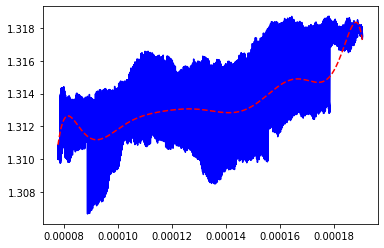

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import utils
batches, epoch_size, sec_per_batch, losses, learning_rates = parse_loss(training_log_lines)
def smooth(data, window_width):
    ret = np.cumsum(np.insert(data, 0, 0)) 
    return (ret[window_width:] - ret[:-window_width]) / window_width
    
smooth_window = 100
start_idx = 0
end_idx = len(losses)
#end_idx -= 20

smooth_batches = smooth(batches[start_idx:end_idx], smooth_window)
smooth_loss = smooth(losses[start_idx:end_idx], smooth_window)
smooth_learning = smooth(learning_rates[start_idx:end_idx], smooth_window)
print(smooth_loss)
print(smooth_learning)

print(max(learning_rates))
a, y = np.polyfit(smooth_batches, np.log(smooth_loss), 1)

y_vals = predicted_value(smooth_batches, a, y)

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 16), dpi=80)
ax1.set_title("Loss and Learning Rate")
ax3.set_title("Predicted Loss")
ax3.set_xlabel("Batch")
ax3.set_ylabel("Loss")

ax2 = ax1.twinx()

print(f"y = {a}x + {y}")

ax1.set_xlabel("Batch")
ax1.set_ylabel("Loss")
ax1.plot(smooth_batches, smooth_loss, label="Loss", color="blue")
ax1.plot(smooth_batches, y_vals, label="Trend Line", linestyle="--", color="green")

ax2.set_xlabel("Batch")
ax2.set_ylabel("Learning Rate")
ax2.plot(smooth_batches, smooth_learning, label="Learning Rate", color="red")

predict_batch = []
predicted_loss = []
last_batch = smooth_batches[-1]
loss_height = max(smooth_loss) - min(smooth_loss)
learning_height = max(smooth_learning) - min(smooth_learning)
for perc in np.arange(0, 1.1, 0.1):
    batch_idx = int(len(smooth_batches) * perc)
    batch_idx = min(batch_idx, len(smooth_batches)-1)
    print(batch_idx)
    
    batch = smooth_batches[batch_idx]
    loss_y = smooth_loss[batch_idx]
    ax1.text(batch, loss_y, f"{loss_y:.3g}", size=10)
    
    learning_y = smooth_learning[batch_idx]
    ax1.text(batch, learning_y, f"{learning_y:.3g}", size=10)


total_width = smooth_batches[0] + epoch_size 
def calc_point(ax, add, a, y, text_size=10):
    x = utils.round_to_multiple(last_batch + add, 100)
    y = predicted_value_exp(x, a, y)

    predict_batch.append(x)
    predicted_loss.append(y)
    
    ax.text(x+0.05*total_width, y, f"{y:.3g}", size=text_size)
    add_hours = add/sec_per_batch/3600
    print(f"{add/epoch_size:+0.2f}% epoches | {add_hours:+06.2f} hours | batch {int(x):>8d}: {y:06.3f} | {np.exp(y):0.3f}")



#fig, ax3 = plt.subplots()

for percent_future in np.arange(-1.0, 2.1, 0.2):
    calc_point(ax3, epoch_size*percent_future, a, y)


ax3.plot([last_batch, last_batch], [min(predicted_loss), max(predicted_loss)], linestyle="--", color="red", label="Last Batch") 

ax3.plot([last_batch+epoch_size, last_batch+epoch_size], [min(predicted_loss), max(predicted_loss)], linestyle="--", color="green", label="+1 Epoch") 
margin = (predict_batch[-1] - predict_batch[0]) * 0.1
percent_finished = smooth_batches[-1] / epoch_size


ax3.set_xlim(predict_batch[0]-margin, predict_batch[-1]+margin)
ax3.plot(predict_batch, predicted_loss, linestyle='--', color="blue")
ax3.scatter(predict_batch, predicted_loss, marker="x", label="Predicted Loss")

ax1.legend()
ax2.legend()
ax3.legend()
fig.show()

In [ ]:
from collections import defaultdict
learning_to_loss = defaultdict(list)

sort_idx = np.argsort(smooth_learning)
sorted_learning = smooth_learning[sort_idx]
sorted_loss = smooth_loss[sort_idx]

for idx in sort_idx:
    learning_to_loss[sorted_learning[idx]].append(sorted_loss[idx])
    
    
x_vals = []
y_vals = []
for key in sorted_learning:
    x_vals.append(key)
    y_vals.append(np.mean(learning_to_loss[key]))
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)

coffs = np.polyfit(x_vals, y_vals, 10)
  
print(a, b, y)
print(y_vals)
plt.plot(x_vals, y_vals, color='blue')
plt.plot(x_vals, predicted_value_poly(x_vals, coffs), color='red', linestyle='--')

In [10]:
training_log_lines = """
Starting training
Starting epoch 0
   99/58367 batches | batch/sec  1.34 | rem mins   722 | loss 1.032029 | ppl   2.8068
Learning rate: [1.0479731350443782e-05]
  199/58367 batches | batch/sec  2.05 | rem mins   472 | loss 1.028975 | ppl   2.7982
Learning rate: [1.0959462700887502e-05]
  299/58367 batches | batch/sec  2.05 | rem mins   472 | loss 1.029672 | ppl   2.8001
Learning rate: [1.1439194051331283e-05]
  399/58367 batches | batch/sec  2.05 | rem mins   472 | loss 1.033171 | ppl   2.8100
Learning rate: [1.1918925401775003e-05]
  499/58367 batches | batch/sec  2.05 | rem mins   471 | loss 1.027274 | ppl   2.7934
Learning rate: [1.2398656752218785e-05]
  599/58367 batches | batch/sec  2.05 | rem mins   470 | loss 1.029117 | ppl   2.7986
Learning rate: [1.2878388102662503e-05]
  699/58367 batches | batch/sec  2.05 | rem mins   470 | loss 1.032396 | ppl   2.8078
Learning rate: [1.3358119453106286e-05]
  799/58367 batches | batch/sec  2.05 | rem mins   469 | loss 1.027453 | ppl   2.7939
Learning rate: [1.3837850803550004e-05]
  899/58367 batches | batch/sec  2.05 | rem mins   468 | loss 1.022352 | ppl   2.7797
Learning rate: [1.4317582153993787e-05]
  999/58367 batches | batch/sec  2.05 | rem mins   468 | loss 1.027938 | ppl   2.7953
Learning rate: [1.4797313504437506e-05]
 1099/58367 batches | batch/sec  2.05 | rem mins   467 | loss 1.024437 | ppl   2.7855
Learning rate: [1.5277044854881287e-05]
 1199/58367 batches | batch/sec  2.05 | rem mins   466 | loss 1.031851 | ppl   2.8063
Learning rate: [1.5756776205325007e-05]
 1299/58367 batches | batch/sec  2.05 | rem mins   465 | loss 1.029954 | ppl   2.8009
Learning rate: [1.6236507555768788e-05]
 1399/58367 batches | batch/sec  2.05 | rem mins   464 | loss 1.024873 | ppl   2.7867
Learning rate: [1.671623890621251e-05]
 1499/58367 batches | batch/sec  2.05 | rem mins   463 | loss 1.028943 | ppl   2.7981
Learning rate: [1.719597025665629e-05]
 1599/58367 batches | batch/sec  2.05 | rem mins   462 | loss 1.034703 | ppl   2.8143
Learning rate: [1.767570160710001e-05]
 1699/58367 batches | batch/sec  2.04 | rem mins   462 | loss 1.015022 | ppl   2.7594
Learning rate: [1.815543295754379e-05]
 1799/58367 batches | batch/sec  2.04 | rem mins   461 | loss 1.014339 | ppl   2.7575
Learning rate: [1.863516430798751e-05]
 1899/58367 batches | batch/sec  2.05 | rem mins   460 | loss 1.035722 | ppl   2.8171
Learning rate: [1.9114895658431292e-05]
 1999/58367 batches | batch/sec  2.05 | rem mins   459 | loss 1.028476 | ppl   2.7968
Learning rate: [1.9594627008875012e-05]
 2099/58367 batches | batch/sec  2.04 | rem mins   459 | loss 1.023482 | ppl   2.7829
Learning rate: [2.0074358359318793e-05]
 2199/58367 batches | batch/sec  2.05 | rem mins   458 | loss 1.025941 | ppl   2.7897
Learning rate: [2.0554089709762514e-05]
 2299/58367 batches | batch/sec  2.05 | rem mins   457 | loss 1.019142 | ppl   2.7708
Learning rate: [2.1033821060206295e-05]
 2399/58367 batches | batch/sec  2.05 | rem mins   456 | loss 1.026712 | ppl   2.7919
Learning rate: [2.1513552410650015e-05]
 2499/58367 batches | batch/sec  2.04 | rem mins   456 | loss 1.022603 | ppl   2.7804
Learning rate: [2.1993283761093796e-05]
 2599/58367 batches | batch/sec  2.05 | rem mins   454 | loss 1.023876 | ppl   2.7840
Learning rate: [2.2473015111537516e-05]
 2699/58367 batches | batch/sec  2.04 | rem mins   454 | loss 1.036367 | ppl   2.8190
Learning rate: [2.2952746461981297e-05]
 2799/58367 batches | batch/sec  2.05 | rem mins   453 | loss 1.024865 | ppl   2.7867
Learning rate: [2.3432477812425018e-05]
 2899/58367 batches | batch/sec  2.04 | rem mins   452 | loss 1.023504 | ppl   2.7829
Learning rate: [2.39122091628688e-05]
 2999/58367 batches | batch/sec  2.05 | rem mins   451 | loss 1.014534 | ppl   2.7581
Learning rate: [2.439194051331252e-05]
 3099/58367 batches | batch/sec  2.04 | rem mins   450 | loss 1.029050 | ppl   2.7984
Learning rate: [2.48716718637563e-05]
 3199/58367 batches | batch/sec  2.05 | rem mins   450 | loss 1.021724 | ppl   2.7780
Learning rate: [2.535140321420002e-05]
 3299/58367 batches | batch/sec  2.04 | rem mins   449 | loss 1.025447 | ppl   2.7883
Learning rate: [2.58311345646438e-05]
 3399/58367 batches | batch/sec  2.05 | rem mins   448 | loss 1.020811 | ppl   2.7754
Learning rate: [2.6310865915087582e-05]
 3499/58367 batches | batch/sec  2.04 | rem mins   447 | loss 1.039893 | ppl   2.8289
Learning rate: [2.6790597265531303e-05]
 3599/58367 batches | batch/sec  2.05 | rem mins   446 | loss 1.019992 | ppl   2.7732
Learning rate: [2.7270328615975084e-05]
 3699/58367 batches | batch/sec  2.05 | rem mins   445 | loss 1.031026 | ppl   2.8039
Learning rate: [2.7750059966418804e-05]
 3799/58367 batches | batch/sec  2.05 | rem mins   445 | loss 1.030329 | ppl   2.8020
Learning rate: [2.8229791316862585e-05]
 3899/58367 batches | batch/sec  2.04 | rem mins   444 | loss 1.027337 | ppl   2.7936
Learning rate: [2.8709522667306305e-05]
 3999/58367 batches | batch/sec  2.04 | rem mins   443 | loss 1.033892 | ppl   2.8120
Learning rate: [2.9189254017750086e-05]
 4099/58367 batches | batch/sec  2.04 | rem mins   443 | loss 1.026938 | ppl   2.7925
Learning rate: [2.9668985368193807e-05]
 4199/58367 batches | batch/sec  2.04 | rem mins   442 | loss 1.031494 | ppl   2.8053
Learning rate: [3.0148716718637588e-05]
 4299/58367 batches | batch/sec  2.04 | rem mins   441 | loss 1.023508 | ppl   2.7829
Learning rate: [3.062844806908131e-05]
 4399/58367 batches | batch/sec  2.04 | rem mins   442 | loss 1.031366 | ppl   2.8049
Learning rate: [3.110817941952509e-05]
 4499/58367 batches | batch/sec  2.04 | rem mins   439 | loss 1.036422 | ppl   2.8191
Learning rate: [3.158791076996881e-05]
 4599/58367 batches | batch/sec  2.04 | rem mins   439 | loss 1.025136 | ppl   2.7875
Learning rate: [3.206764212041259e-05]
 4699/58367 batches | batch/sec  2.05 | rem mins   437 | loss 1.035614 | ppl   2.8168
Learning rate: [3.254737347085631e-05]
 4799/58367 batches | batch/sec  2.04 | rem mins   437 | loss 1.028795 | ppl   2.7977
Learning rate: [3.302710482130009e-05]
 4899/58367 batches | batch/sec  2.05 | rem mins   436 | loss 1.027238 | ppl   2.7933
Learning rate: [3.350683617174381e-05]
 4999/58367 batches | batch/sec  2.04 | rem mins   435 | loss 1.022256 | ppl   2.7795
Learning rate: [3.398656752218759e-05]
 5099/58367 batches | batch/sec  2.04 | rem mins   434 | loss 1.030576 | ppl   2.8027
Learning rate: [3.446629887263131e-05]
 5199/58367 batches | batch/sec  2.04 | rem mins   434 | loss 1.024501 | ppl   2.7857
Learning rate: [3.4946030223075094e-05]
 5299/58367 batches | batch/sec  2.04 | rem mins   433 | loss 1.030354 | ppl   2.8021
Learning rate: [3.5425761573518814e-05]
 5399/58367 batches | batch/sec  2.05 | rem mins   431 | loss 1.034045 | ppl   2.8124
Learning rate: [3.5905492923962596e-05]
 5499/58367 batches | batch/sec  2.04 | rem mins   431 | loss 1.027297 | ppl   2.7935
Learning rate: [3.638522427440631e-05]
 5599/58367 batches | batch/sec  2.04 | rem mins   430 | loss 1.023908 | ppl   2.7841
Learning rate: [3.68649556248501e-05]
 5699/58367 batches | batch/sec  2.05 | rem mins   429 | loss 1.026094 | ppl   2.7901
Learning rate: [3.734468697529381e-05]
 5799/58367 batches | batch/sec  2.04 | rem mins   429 | loss 1.017072 | ppl   2.7651
Learning rate: [3.78244183257376e-05]
 5899/58367 batches | batch/sec  2.05 | rem mins   428 | loss 1.024482 | ppl   2.7857
Learning rate: [3.830414967618131e-05]
 5999/58367 batches | batch/sec  2.05 | rem mins   427 | loss 1.023522 | ppl   2.7830
Learning rate: [3.878388102662509e-05]
 6099/58367 batches | batch/sec  2.04 | rem mins   426 | loss 1.019090 | ppl   2.7707
Learning rate: [3.926361237706881e-05]
 6199/58367 batches | batch/sec  2.04 | rem mins   425 | loss 1.024208 | ppl   2.7849
Learning rate: [3.9743343727512594e-05]
 6299/58367 batches | batch/sec  2.04 | rem mins   424 | loss 1.027660 | ppl   2.7945
Learning rate: [4.0223075077956314e-05]
 6399/58367 batches | batch/sec  2.04 | rem mins   424 | loss 1.022457 | ppl   2.7800
Learning rate: [4.0702806428400095e-05]
 6499/58367 batches | batch/sec  2.04 | rem mins   423 | loss 1.020762 | ppl   2.7753
Learning rate: [4.1182537778843816e-05]
 6599/58367 batches | batch/sec  2.05 | rem mins   421 | loss 1.029816 | ppl   2.8006
Learning rate: [4.16622691292876e-05]
 6699/58367 batches | batch/sec  2.04 | rem mins   421 | loss 1.030880 | ppl   2.8035
Learning rate: [4.214200047973138e-05]
 6799/58367 batches | batch/sec  2.04 | rem mins   421 | loss 1.024141 | ppl   2.7847
Learning rate: [4.26217318301751e-05]
 6899/58367 batches | batch/sec  2.04 | rem mins   419 | loss 1.035447 | ppl   2.8164
Learning rate: [4.310146318061882e-05]
 6999/58367 batches | batch/sec  2.05 | rem mins   418 | loss 1.015131 | ppl   2.7597
Learning rate: [4.35811945310626e-05]
 7099/58367 batches | batch/sec  2.04 | rem mins   418 | loss 1.024076 | ppl   2.7845
Learning rate: [4.406092588150638e-05]
 7199/58367 batches | batch/sec  2.05 | rem mins   417 | loss 1.019199 | ppl   2.7710
Learning rate: [4.45406572319501e-05]
 7299/58367 batches | batch/sec  2.05 | rem mins   416 | loss 1.024315 | ppl   2.7852
Learning rate: [4.502038858239388e-05]
 7399/58367 batches | batch/sec  2.05 | rem mins   415 | loss 1.026300 | ppl   2.7907
Learning rate: [4.55001199328376e-05]
 7499/58367 batches | batch/sec  2.05 | rem mins   414 | loss 1.025358 | ppl   2.7881
Learning rate: [4.597985128328138e-05]
 7599/58367 batches | batch/sec  2.05 | rem mins   413 | loss 1.025924 | ppl   2.7897
Learning rate: [4.64595826337251e-05]
 7699/58367 batches | batch/sec  2.04 | rem mins   413 | loss 1.030289 | ppl   2.8019
Learning rate: [4.6939313984168884e-05]
 7799/58367 batches | batch/sec  2.04 | rem mins   412 | loss 1.030852 | ppl   2.8035
Learning rate: [4.7419045334612605e-05]
 7899/58367 batches | batch/sec  2.05 | rem mins   411 | loss 1.020260 | ppl   2.7739
Learning rate: [4.7898776685056386e-05]
 7999/58367 batches | batch/sec  2.05 | rem mins   410 | loss 1.034700 | ppl   2.8143
Learning rate: [4.8378508035500106e-05]
 8099/58367 batches | batch/sec  2.04 | rem mins   410 | loss 1.022487 | ppl   2.7801
Learning rate: [4.885823938594389e-05]
 8199/58367 batches | batch/sec  2.04 | rem mins   409 | loss 1.026318 | ppl   2.7908
Learning rate: [4.933797073638761e-05]
 8299/58367 batches | batch/sec  2.04 | rem mins   408 | loss 1.028206 | ppl   2.7960
Learning rate: [4.981770208683139e-05]
 8399/58367 batches | batch/sec  2.05 | rem mins   407 | loss 1.032065 | ppl   2.8069
Learning rate: [5.029743343727511e-05]
 8499/58367 batches | batch/sec  2.04 | rem mins   407 | loss 1.022524 | ppl   2.7802
Learning rate: [5.077716478771889e-05]
 8599/58367 batches | batch/sec  2.04 | rem mins   406 | loss 1.022584 | ppl   2.7804
Learning rate: [5.125689613816261e-05]
 8699/58367 batches | batch/sec  2.05 | rem mins   404 | loss 1.031084 | ppl   2.8041
Learning rate: [5.173662748860639e-05]
""".split("\n")

SyntaxError: invalid syntax (1576101915.py, line 1)

In [11]:
training_log_lines = """
   49/104227 batches | batch/sec  0.87 | rem mins  2000 | loss 1.310506 | ppl   3.7081
Learning rate: [7.037418686316275e-05]
   99/104227 batches | batch/sec  1.63 | rem mins  1063 | loss 1.300770 | ppl   3.6721
Learning rate: [7.07483737263255e-05]
  149/104227 batches | batch/sec  1.63 | rem mins  1066 | loss 1.299314 | ppl   3.6668
Learning rate: [7.112256058948824e-05]
  199/104227 batches | batch/sec  1.62 | rem mins  1067 | loss 1.304251 | ppl   3.6849
Learning rate: [7.149674745265094e-05]
  249/104227 batches | batch/sec  1.63 | rem mins  1066 | loss 1.298336 | ppl   3.6632
Learning rate: [7.18709343158137e-05]
  299/104227 batches | batch/sec  1.62 | rem mins  1066 | loss 1.291254 | ppl   3.6373
Learning rate: [7.224512117897644e-05]
  349/104227 batches | batch/sec  1.62 | rem mins  1066 | loss 1.313227 | ppl   3.7182
Learning rate: [7.261930804213919e-05]
  399/104227 batches | batch/sec  1.62 | rem mins  1066 | loss 1.317505 | ppl   3.7341
Learning rate: [7.299349490530194e-05]
  449/104227 batches | batch/sec  1.62 | rem mins  1067 | loss 1.329384 | ppl   3.7787
Learning rate: [7.33676817684647e-05]
  499/104227 batches | batch/sec  1.62 | rem mins  1065 | loss 1.311706 | ppl   3.7125
Learning rate: [7.374186863162745e-05]
  549/104227 batches | batch/sec  1.62 | rem mins  1065 | loss 1.306187 | ppl   3.6921
Learning rate: [7.411605549479014e-05]
  599/104227 batches | batch/sec  1.62 | rem mins  1065 | loss 1.299516 | ppl   3.6675
Learning rate: [7.44902423579529e-05]
  649/104227 batches | batch/sec  1.62 | rem mins  1064 | loss 1.307883 | ppl   3.6983
Learning rate: [7.486442922111565e-05]
  699/104227 batches | batch/sec  1.62 | rem mins  1064 | loss 1.309654 | ppl   3.7049
Learning rate: [7.523861608427839e-05]
  749/104227 batches | batch/sec  1.62 | rem mins  1064 | loss 1.315957 | ppl   3.7283
Learning rate: [7.561280294744114e-05]
  799/104227 batches | batch/sec  1.62 | rem mins  1063 | loss 1.292144 | ppl   3.6406
Learning rate: [7.59869898106039e-05]
  849/104227 batches | batch/sec  1.62 | rem mins  1064 | loss 1.313390 | ppl   3.7188
Learning rate: [7.636117667376665e-05]
  899/104227 batches | batch/sec  1.62 | rem mins  1061 | loss 1.303846 | ppl   3.6834
Learning rate: [7.673536353692934e-05]
  949/104227 batches | batch/sec  1.62 | rem mins  1060 | loss 1.298848 | ppl   3.6651
Learning rate: [7.710955040009209e-05]
  999/104227 batches | batch/sec  1.62 | rem mins  1059 | loss 1.308388 | ppl   3.7002
Learning rate: [7.748373726325484e-05]
 1049/104227 batches | batch/sec  1.62 | rem mins  1060 | loss 1.294395 | ppl   3.6488
Learning rate: [7.785792412641758e-05]
 1099/104227 batches | batch/sec  1.62 | rem mins  1058 | loss 1.284911 | ppl   3.6143
Learning rate: [7.823211098958034e-05]
 1149/104227 batches | batch/sec  1.62 | rem mins  1058 | loss 1.310754 | ppl   3.7090
Learning rate: [7.860629785274309e-05]
 1199/104227 batches | batch/sec  1.62 | rem mins  1059 | loss 1.307191 | ppl   3.6958
Learning rate: [7.898048471590579e-05]
 1249/104227 batches | batch/sec  1.62 | rem mins  1058 | loss 1.301867 | ppl   3.6762
Learning rate: [7.935467157906853e-05]
 1299/104227 batches | batch/sec  1.63 | rem mins  1055 | loss 1.317495 | ppl   3.7341
Learning rate: [7.972885844223129e-05]
 1349/104227 batches | batch/sec  1.62 | rem mins  1057 | loss 1.302162 | ppl   3.6772
Learning rate: [8.010304530539404e-05]
 1399/104227 batches | batch/sec  1.62 | rem mins  1055 | loss 1.300084 | ppl   3.6696
Learning rate: [8.04772321685568e-05]
 1449/104227 batches | batch/sec  1.62 | rem mins  1055 | loss 1.309489 | ppl   3.7043
Learning rate: [8.085141903171954e-05]
 1499/104227 batches | batch/sec  1.62 | rem mins  1055 | loss 1.316339 | ppl   3.7297
Learning rate: [8.122560589488229e-05]
 1549/104227 batches | batch/sec  1.62 | rem mins  1055 | loss 1.314310 | ppl   3.7222
Learning rate: [8.159979275804499e-05]
 1599/104227 batches | batch/sec  1.62 | rem mins  1053 | loss 1.299103 | ppl   3.6660
Learning rate: [8.197397962120774e-05]
 1649/104227 batches | batch/sec  1.62 | rem mins  1052 | loss 1.287868 | ppl   3.6251
Learning rate: [8.234816648437048e-05]
 1699/104227 batches | batch/sec  1.62 | rem mins  1053 | loss 1.288818 | ppl   3.6285
Learning rate: [8.272235334753324e-05]
 1749/104227 batches | batch/sec  1.62 | rem mins  1055 | loss 1.283303 | ppl   3.6085
Learning rate: [8.309654021069599e-05]
 1799/104227 batches | batch/sec  1.62 | rem mins  1053 | loss 1.297083 | ppl   3.6586
Learning rate: [8.347072707385875e-05]
 1849/104227 batches | batch/sec  1.63 | rem mins  1050 | loss 1.290177 | ppl   3.6334
Learning rate: [8.384491393702149e-05]
 1899/104227 batches | batch/sec  1.62 | rem mins  1050 | loss 1.310863 | ppl   3.7094
Learning rate: [8.421910080018419e-05]
 1949/104227 batches | batch/sec  1.62 | rem mins  1050 | loss 1.295698 | ppl   3.6535
Learning rate: [8.459328766334694e-05]
 1999/104227 batches | batch/sec  1.62 | rem mins  1051 | loss 1.306737 | ppl   3.6941
Learning rate: [8.49674745265097e-05]
 2049/104227 batches | batch/sec  1.62 | rem mins  1049 | loss 1.298446 | ppl   3.6636
Learning rate: [8.534166138967244e-05]
 2099/104227 batches | batch/sec  1.62 | rem mins  1050 | loss 1.300977 | ppl   3.6729
Learning rate: [8.571584825283519e-05]
 2149/104227 batches | batch/sec  1.62 | rem mins  1049 | loss 1.321005 | ppl   3.7472
Learning rate: [8.609003511599794e-05]
 2199/104227 batches | batch/sec  1.62 | rem mins  1049 | loss 1.291961 | ppl   3.6399
Learning rate: [8.646422197916068e-05]
 2249/104227 batches | batch/sec  1.62 | rem mins  1049 | loss 1.302725 | ppl   3.6793
Learning rate: [8.683840884232338e-05]
 2299/104227 batches | batch/sec  1.62 | rem mins  1047 | loss 1.303744 | ppl   3.6831
Learning rate: [8.721259570548614e-05]
 2349/104227 batches | batch/sec  1.62 | rem mins  1048 | loss 1.305772 | ppl   3.6905
Learning rate: [8.758678256864889e-05]
 2399/104227 batches | batch/sec  1.62 | rem mins  1046 | loss 1.334242 | ppl   3.7971
Learning rate: [8.796096943181165e-05]
 2449/104227 batches | batch/sec  1.62 | rem mins  1044 | loss 1.317791 | ppl   3.7352
Learning rate: [8.833515629497439e-05]
 2499/104227 batches | batch/sec  1.62 | rem mins  1047 | loss 1.308299 | ppl   3.6999
Learning rate: [8.870934315813714e-05]
 2549/104227 batches | batch/sec  1.62 | rem mins  1044 | loss 1.289262 | ppl   3.6301
Learning rate: [8.90835300212999e-05]
 2599/104227 batches | batch/sec  1.63 | rem mins  1042 | loss 1.299632 | ppl   3.6679
Learning rate: [8.945771688446258e-05]
 2649/104227 batches | batch/sec  1.62 | rem mins  1046 | loss 1.303945 | ppl   3.6838
Learning rate: [8.983190374762533e-05]
 2699/104227 batches | batch/sec  1.62 | rem mins  1042 | loss 1.314003 | ppl   3.7210
Learning rate: [9.020609061078809e-05]
 2749/104227 batches | batch/sec  1.62 | rem mins  1042 | loss 1.316987 | ppl   3.7322
Learning rate: [9.058027747395084e-05]
 2799/104227 batches | batch/sec  1.62 | rem mins  1041 | loss 1.311710 | ppl   3.7125
Learning rate: [9.09544643371136e-05]
 2849/104227 batches | batch/sec  1.62 | rem mins  1041 | loss 1.302462 | ppl   3.6783
Learning rate: [9.132865120027634e-05]
 2899/104227 batches | batch/sec  1.62 | rem mins  1042 | loss 1.318774 | ppl   3.7388
Learning rate: [9.170283806343909e-05]
 2949/104227 batches | batch/sec  1.62 | rem mins  1041 | loss 1.317130 | ppl   3.7327
Learning rate: [9.207702492660178e-05]
 2999/104227 batches | batch/sec  1.62 | rem mins  1039 | loss 1.297287 | ppl   3.6594
Learning rate: [9.245121178976453e-05]
 3049/104227 batches | batch/sec  1.62 | rem mins  1040 | loss 1.311767 | ppl   3.7127
Learning rate: [9.282539865292729e-05]
 3099/104227 batches | batch/sec  1.62 | rem mins  1039 | loss 1.311485 | ppl   3.7117
Learning rate: [9.319958551609004e-05]
 3149/104227 batches | batch/sec  1.62 | rem mins  1037 | loss 1.294859 | ppl   3.6505
Learning rate: [9.35737723792528e-05]
 3199/104227 batches | batch/sec  1.62 | rem mins  1038 | loss 1.294974 | ppl   3.6509
Learning rate: [9.394795924241553e-05]
 3249/104227 batches | batch/sec  1.63 | rem mins  1035 | loss 1.316472 | ppl   3.7302
Learning rate: [9.432214610557829e-05]
 3299/104227 batches | batch/sec  1.62 | rem mins  1037 | loss 1.305163 | ppl   3.6883
Learning rate: [9.469633296874099e-05]
 3349/104227 batches | batch/sec  1.62 | rem mins  1035 | loss 1.299309 | ppl   3.6668
Learning rate: [9.507051983190373e-05]
 3399/104227 batches | batch/sec  1.62 | rem mins  1035 | loss 1.289982 | ppl   3.6327
Learning rate: [9.544470669506648e-05]
 3449/104227 batches | batch/sec  1.62 | rem mins  1035 | loss 1.305047 | ppl   3.6879
Learning rate: [9.581889355822924e-05]
 3499/104227 batches | batch/sec  1.62 | rem mins  1035 | loss 1.311890 | ppl   3.7132
Learning rate: [9.619308042139199e-05]
 3549/104227 batches | batch/sec  1.62 | rem mins  1038 | loss 1.310824 | ppl   3.7092
Learning rate: [9.656726728455474e-05]
 3599/104227 batches | batch/sec  1.62 | rem mins  1034 | loss 1.319817 | ppl   3.7427
Learning rate: [9.694145414771743e-05]
 3649/104227 batches | batch/sec  1.62 | rem mins  1033 | loss 1.301603 | ppl   3.6752
Learning rate: [9.731564101088018e-05]
 3699/104227 batches | batch/sec  1.62 | rem mins  1032 | loss 1.321201 | ppl   3.7479
Learning rate: [9.768982787404293e-05]
 3749/104227 batches | batch/sec  1.62 | rem mins  1032 | loss 1.300081 | ppl   3.6696
Learning rate: [9.806401473720568e-05]
 3799/104227 batches | batch/sec  1.62 | rem mins  1032 | loss 1.312902 | ppl   3.7169
Learning rate: [9.843820160036843e-05]
 3849/104227 batches | batch/sec  1.62 | rem mins  1032 | loss 1.301967 | ppl   3.6765
Learning rate: [9.881238846353119e-05]
 3899/104227 batches | batch/sec  1.62 | rem mins  1029 | loss 1.300441 | ppl   3.6709
Learning rate: [9.918657532669394e-05]
 3949/104227 batches | batch/sec  1.62 | rem mins  1030 | loss 1.309462 | ppl   3.7042
Learning rate: [9.956076218985663e-05]
 3999/104227 batches | batch/sec  1.62 | rem mins  1028 | loss 1.314894 | ppl   3.7244
Learning rate: [9.993494905301938e-05]
 4049/104227 batches | batch/sec  1.62 | rem mins  1029 | loss 1.300271 | ppl   3.6703
Learning rate: [0.00010030913591618214]
 4099/104227 batches | batch/sec  1.62 | rem mins  1029 | loss 1.316826 | ppl   3.7316
Learning rate: [0.00010068332277934488]
 4149/104227 batches | batch/sec  1.62 | rem mins  1028 | loss 1.304061 | ppl   3.6842
Learning rate: [0.00010105750964250763]
 4199/104227 batches | batch/sec  1.62 | rem mins  1028 | loss 1.316828 | ppl   3.7316
Learning rate: [0.00010143169650567038]
 4249/104227 batches | batch/sec  1.62 | rem mins  1028 | loss 1.321603 | ppl   3.7494
Learning rate: [0.00010180588336883314]
 4299/104227 batches | batch/sec  1.62 | rem mins  1028 | loss 1.296345 | ppl   3.6559
Learning rate: [0.00010218007023199584]
 4349/104227 batches | batch/sec  1.62 | rem mins  1027 | loss 1.305959 | ppl   3.6912
Learning rate: [0.00010255425709515858]
 4399/104227 batches | batch/sec  1.62 | rem mins  1025 | loss 1.326296 | ppl   3.7671
Learning rate: [0.00010292844395832133]
 4449/104227 batches | batch/sec  1.62 | rem mins  1029 | loss 1.305355 | ppl   3.6890
Learning rate: [0.00010330263082148407]
 4499/104227 batches | batch/sec  1.62 | rem mins  1026 | loss 1.303500 | ppl   3.6822
Learning rate: [0.00010367681768464683]
 4549/104227 batches | batch/sec  1.62 | rem mins  1026 | loss 1.307064 | ppl   3.6953
Learning rate: [0.00010405100454780958]
 4599/104227 batches | batch/sec  1.62 | rem mins  1023 | loss 1.320875 | ppl   3.7467
Learning rate: [0.00010442519141097228]
 4649/104227 batches | batch/sec  1.62 | rem mins  1023 | loss 1.311882 | ppl   3.7132
Learning rate: [0.00010479937827413504]
 4699/104227 batches | batch/sec  1.62 | rem mins  1023 | loss 1.301058 | ppl   3.6732
Learning rate: [0.00010517356513729779]
 4749/104227 batches | batch/sec  1.62 | rem mins  1022 | loss 1.306378 | ppl   3.6928
Learning rate: [0.00010554775200046053]
 4799/104227 batches | batch/sec  1.62 | rem mins  1022 | loss 1.332547 | ppl   3.7907
Learning rate: [0.00010592193886362328]
 4849/104227 batches | batch/sec  1.62 | rem mins  1021 | loss 1.317999 | ppl   3.7359
Learning rate: [0.00010629612572678602]
 4899/104227 batches | batch/sec  1.62 | rem mins  1020 | loss 1.306368 | ppl   3.6927
Learning rate: [0.00010667031258994878]
 4949/104227 batches | batch/sec  1.62 | rem mins  1020 | loss 1.309848 | ppl   3.7056
Learning rate: [0.00010704449945311148]
 4999/104227 batches | batch/sec  1.62 | rem mins  1020 | loss 1.311903 | ppl   3.7132
Learning rate: [0.00010741868631627423]
 5049/104227 batches | batch/sec  1.62 | rem mins  1020 | loss 1.313565 | ppl   3.7194
Learning rate: [0.00010779287317943699]
 5099/104227 batches | batch/sec  1.62 | rem mins  1019 | loss 1.301033 | ppl   3.6731
Learning rate: [0.00010816706004259974]
 5149/104227 batches | batch/sec  1.62 | rem mins  1019 | loss 1.315801 | ppl   3.7277
Learning rate: [0.00010854124690576248]
 5199/104227 batches | batch/sec  1.62 | rem mins  1018 | loss 1.307434 | ppl   3.6967
Learning rate: [0.00010891543376892523]
 5249/104227 batches | batch/sec  1.62 | rem mins  1018 | loss 1.309518 | ppl   3.7044
Learning rate: [0.00010928962063208798]
 5299/104227 batches | batch/sec  1.61 | rem mins  1021 | loss 1.311674 | ppl   3.7124
Learning rate: [0.00010966380749525068]
 5349/104227 batches | batch/sec  1.62 | rem mins  1018 | loss 1.315727 | ppl   3.7275
Learning rate: [0.00011003799435841343]
 5399/104227 batches | batch/sec  1.62 | rem mins  1016 | loss 1.327824 | ppl   3.7728
Learning rate: [0.00011041218122157618]
 5449/104227 batches | batch/sec  1.62 | rem mins  1016 | loss 1.312107 | ppl   3.7140
Learning rate: [0.00011078636808473894]
 5499/104227 batches | batch/sec  1.62 | rem mins  1016 | loss 1.319425 | ppl   3.7413
Learning rate: [0.00011116055494790168]
 5549/104227 batches | batch/sec  1.62 | rem mins  1015 | loss 1.316798 | ppl   3.7315
Learning rate: [0.00011153474181106443]
 5599/104227 batches | batch/sec  1.62 | rem mins  1014 | loss 1.311116 | ppl   3.7103
Learning rate: [0.00011190892867422719]
 5649/104227 batches | batch/sec  1.62 | rem mins  1015 | loss 1.321768 | ppl   3.7500
Learning rate: [0.00011228311553738987]
 5699/104227 batches | batch/sec  1.62 | rem mins  1014 | loss 1.289994 | ppl   3.6328
Learning rate: [0.00011265730240055263]
 5749/104227 batches | batch/sec  1.62 | rem mins  1012 | loss 1.318880 | ppl   3.7392
Learning rate: [0.00011303148926371538]
 5799/104227 batches | batch/sec  1.62 | rem mins  1013 | loss 1.313185 | ppl   3.7180
Learning rate: [0.00011340567612687813]
 5849/104227 batches | batch/sec  1.62 | rem mins  1012 | loss 1.317865 | ppl   3.7354
Learning rate: [0.00011377986299004089]
 5899/104227 batches | batch/sec  1.62 | rem mins  1013 | loss 1.321395 | ppl   3.7486
Learning rate: [0.00011415404985320363]
 5949/104227 batches | batch/sec  1.62 | rem mins  1012 | loss 1.313725 | ppl   3.7200
Learning rate: [0.00011452823671636638]
 5999/104227 batches | batch/sec  1.62 | rem mins  1012 | loss 1.327974 | ppl   3.7734
Learning rate: [0.00011490242357952907]
 6049/104227 batches | batch/sec  1.62 | rem mins  1012 | loss 1.342281 | ppl   3.8278
Learning rate: [0.00011527661044269182]
 6099/104227 batches | batch/sec  1.62 | rem mins  1010 | loss 1.322052 | ppl   3.7511
Learning rate: [0.00011565079730585458]
 6149/104227 batches | batch/sec  1.62 | rem mins  1010 | loss 1.315683 | ppl   3.7273
Learning rate: [0.00011602498416901733]
 6199/104227 batches | batch/sec  1.61 | rem mins  1014 | loss 1.324377 | ppl   3.7598
Learning rate: [0.00011639917103218009]
 6249/104227 batches | batch/sec  1.62 | rem mins  1011 | loss 1.296450 | ppl   3.6563
Learning rate: [0.00011677335789534284]
 6299/104227 batches | batch/sec  1.62 | rem mins  1008 | loss 1.315279 | ppl   3.7258
Learning rate: [0.00011714754475850558]
 6349/104227 batches | batch/sec  1.62 | rem mins  1008 | loss 1.306483 | ppl   3.6932
Learning rate: [0.00011752173162166827]
 6399/104227 batches | batch/sec  1.62 | rem mins  1008 | loss 1.314023 | ppl   3.7211
Learning rate: [0.00011789591848483102]
 6449/104227 batches | batch/sec  1.61 | rem mins  1009 | loss 1.307509 | ppl   3.6970
Learning rate: [0.00011827010534799377]
 6499/104227 batches | batch/sec  1.62 | rem mins  1007 | loss 1.322232 | ppl   3.7518
Learning rate: [0.00011864429221115653]
 6549/104227 batches | batch/sec  1.62 | rem mins  1007 | loss 1.328636 | ppl   3.7759
Learning rate: [0.00011901847907431928]
 6599/104227 batches | batch/sec  1.62 | rem mins  1007 | loss 1.331901 | ppl   3.7882
Learning rate: [0.00011939266593748204]
 6649/104227 batches | batch/sec  1.62 | rem mins  1007 | loss 1.321138 | ppl   3.7477
Learning rate: [0.00011976685280064479]
 6699/104227 batches | batch/sec  1.62 | rem mins  1005 | loss 1.322546 | ppl   3.7530
Learning rate: [0.00012014103966380748]
 6749/104227 batches | batch/sec  1.62 | rem mins  1005 | loss 1.316216 | ppl   3.7293
Learning rate: [0.00012051522652697022]
 6799/104227 batches | batch/sec  1.62 | rem mins  1005 | loss 1.318641 | ppl   3.7383
Learning rate: [0.00012088941339013297]
 6849/104227 batches | batch/sec  1.62 | rem mins  1003 | loss 1.295362 | ppl   3.6523
Learning rate: [0.00012126360025329573]
 6899/104227 batches | batch/sec  1.61 | rem mins  1005 | loss 1.324631 | ppl   3.7608
Learning rate: [0.00012163778711645848]
 6949/104227 batches | batch/sec  1.61 | rem mins  1004 | loss 1.310054 | ppl   3.7064
Learning rate: [0.00012201197397962123]
 6999/104227 batches | batch/sec  1.62 | rem mins  1003 | loss 1.307636 | ppl   3.6974
Learning rate: [0.000122386160842784]
 7049/104227 batches | batch/sec  1.62 | rem mins  1002 | loss 1.323000 | ppl   3.7547
Learning rate: [0.0001227603477059467]
 7099/104227 batches | batch/sec  1.61 | rem mins  1004 | loss 1.323363 | ppl   3.7560
Learning rate: [0.00012313453456910941]
 7149/104227 batches | batch/sec  1.62 | rem mins  1000 | loss 1.318938 | ppl   3.7394
Learning rate: [0.00012350872143227217]
 7199/104227 batches | batch/sec  1.61 | rem mins  1002 | loss 1.304760 | ppl   3.6868
Learning rate: [0.00012388290829543492]
 7249/104227 batches | batch/sec  1.62 | rem mins  1000 | loss 1.304490 | ppl   3.6858
Learning rate: [0.00012425709515859768]
 7299/104227 batches | batch/sec  1.62 | rem mins  1000 | loss 1.312997 | ppl   3.7173
Learning rate: [0.00012463128202176043]
 7349/104227 batches | batch/sec  1.62 | rem mins   999 | loss 1.333352 | ppl   3.7937
Learning rate: [0.00012500546888492318]
 7399/104227 batches | batch/sec  1.62 | rem mins   998 | loss 1.315362 | ppl   3.7261
Learning rate: [0.00012537965574808588]
 7449/104227 batches | batch/sec  1.61 | rem mins   999 | loss 1.308559 | ppl   3.7008
Learning rate: [0.0001257538426112486]
 7499/104227 batches | batch/sec  1.62 | rem mins   998 | loss 1.301142 | ppl   3.6735
Learning rate: [0.00012612802947441137]
 7549/104227 batches | batch/sec  1.62 | rem mins   997 | loss 1.305267 | ppl   3.6887
Learning rate: [0.00012650221633757412]
 7599/104227 batches | batch/sec  1.62 | rem mins   996 | loss 1.313308 | ppl   3.7185
Learning rate: [0.00012687640320073687]
 7649/104227 batches | batch/sec  1.62 | rem mins   996 | loss 1.312679 | ppl   3.7161
Learning rate: [0.00012725059006389963]
 7699/104227 batches | batch/sec  1.61 | rem mins   997 | loss 1.315651 | ppl   3.7272
Learning rate: [0.00012762477692706238]
 7749/104227 batches | batch/sec  1.61 | rem mins   996 | loss 1.316487 | ppl   3.7303
Learning rate: [0.00012799896379022508]
 7799/104227 batches | batch/sec  1.62 | rem mins   995 | loss 1.307569 | ppl   3.6972
Learning rate: [0.0001283731506533878]
 7849/104227 batches | batch/sec  1.61 | rem mins   995 | loss 1.339469 | ppl   3.8170
Learning rate: [0.0001287473375165506]
 7899/104227 batches | batch/sec  1.61 | rem mins   994 | loss 1.306616 | ppl   3.6937
Learning rate: [0.00012912152437971332]
 7949/104227 batches | batch/sec  1.62 | rem mins   993 | loss 1.305111 | ppl   3.6881
Learning rate: [0.00012949571124287607]
 7999/104227 batches | batch/sec  1.61 | rem mins   996 | loss 1.305106 | ppl   3.6881
Learning rate: [0.00012986989810603877]
 8049/104227 batches | batch/sec  1.61 | rem mins   994 | loss 1.313811 | ppl   3.7203
Learning rate: [0.00013024408496920152]
 8099/104227 batches | batch/sec  1.62 | rem mins   992 | loss 1.307054 | ppl   3.6953
Learning rate: [0.00013061827183236428]
 8149/104227 batches | batch/sec  1.62 | rem mins   991 | loss 1.305846 | ppl   3.6908
Learning rate: [0.00013099245869552703]
 8199/104227 batches | batch/sec  1.61 | rem mins   991 | loss 1.319466 | ppl   3.7414
Learning rate: [0.00013136664555868979]
 8249/104227 batches | batch/sec  1.62 | rem mins   990 | loss 1.304047 | ppl   3.6842
Learning rate: [0.0001317408324218525]
 8299/104227 batches | batch/sec  1.62 | rem mins   989 | loss 1.300983 | ppl   3.6729
Learning rate: [0.0001321150192850153]
 8349/104227 batches | batch/sec  1.62 | rem mins   989 | loss 1.310548 | ppl   3.7082
Learning rate: [0.00013248920614817797]
 8399/104227 batches | batch/sec  1.62 | rem mins   988 | loss 1.328465 | ppl   3.7752
Learning rate: [0.00013286339301134072]
 8449/104227 batches | batch/sec  1.61 | rem mins   990 | loss 1.320401 | ppl   3.7449
Learning rate: [0.00013323757987450347]
 8499/104227 batches | batch/sec  1.61 | rem mins   990 | loss 1.317105 | ppl   3.7326
Learning rate: [0.0001336117667376662]
 8549/104227 batches | batch/sec  1.62 | rem mins   987 | loss 1.308359 | ppl   3.7001
Learning rate: [0.00013398595360082898]
 8599/104227 batches | batch/sec  1.61 | rem mins   987 | loss 1.318216 | ppl   3.7367
Learning rate: [0.0001343601404639917]
 8649/104227 batches | batch/sec  1.61 | rem mins   987 | loss 1.314503 | ppl   3.7229
Learning rate: [0.0001347343273271545]
 8699/104227 batches | batch/sec  1.61 | rem mins   988 | loss 1.305339 | ppl   3.6889
Learning rate: [0.00013510851419031716]
 8749/104227 batches | batch/sec  1.61 | rem mins   986 | loss 1.319285 | ppl   3.7407
Learning rate: [0.00013548270105347992]
 8799/104227 batches | batch/sec  1.61 | rem mins   985 | loss 1.322525 | ppl   3.7529
Learning rate: [0.00013585688791664267]
 8849/104227 batches | batch/sec  1.61 | rem mins   987 | loss 1.316845 | ppl   3.7316
Learning rate: [0.00013623107477980543]
 8899/104227 batches | batch/sec  1.61 | rem mins   984 | loss 1.315338 | ppl   3.7260
Learning rate: [0.00013660526164296818]
 8949/104227 batches | batch/sec  1.61 | rem mins   983 | loss 1.312373 | ppl   3.7150
Learning rate: [0.0001369794485061309]
 8999/104227 batches | batch/sec  1.61 | rem mins   983 | loss 1.316219 | ppl   3.7293
Learning rate: [0.0001373536353692937]
 9049/104227 batches | batch/sec  1.61 | rem mins   983 | loss 1.308184 | ppl   3.6994
Learning rate: [0.00013772782223245636]
 9099/104227 batches | batch/sec  1.61 | rem mins   983 | loss 1.305590 | ppl   3.6899
Learning rate: [0.00013810200909561911]
 9149/104227 batches | batch/sec  1.61 | rem mins   983 | loss 1.333571 | ppl   3.7946
Learning rate: [0.00013847619595878187]
 9199/104227 batches | batch/sec  1.61 | rem mins   983 | loss 1.319260 | ppl   3.7407
Learning rate: [0.00013885038282194462]
 9249/104227 batches | batch/sec  1.61 | rem mins   982 | loss 1.315801 | ppl   3.7277
Learning rate: [0.00013922456968510738]
 9299/104227 batches | batch/sec  1.61 | rem mins   980 | loss 1.317581 | ppl   3.7344
Learning rate: [0.0001395987565482701]
 9349/104227 batches | batch/sec  1.61 | rem mins   980 | loss 1.311814 | ppl   3.7129
Learning rate: [0.00013997294341143288]
 9399/104227 batches | batch/sec  1.61 | rem mins   979 | loss 1.320937 | ppl   3.7469
Learning rate: [0.00014034713027459556]
 9449/104227 batches | batch/sec  1.61 | rem mins   980 | loss 1.331313 | ppl   3.7860
Learning rate: [0.0001407213171377583]
 9499/104227 batches | batch/sec  1.61 | rem mins   978 | loss 1.314149 | ppl   3.7216
Learning rate: [0.00014109550400092107]
 9549/104227 batches | batch/sec  1.61 | rem mins   978 | loss 1.315641 | ppl   3.7271
Learning rate: [0.00014146969086408382]
 9599/104227 batches | batch/sec  1.61 | rem mins   977 | loss 1.320099 | ppl   3.7438
Learning rate: [0.00014184387772724657]
 9649/104227 batches | batch/sec  1.61 | rem mins   977 | loss 1.320991 | ppl   3.7471
Learning rate: [0.00014221806459040933]
 9699/104227 batches | batch/sec  1.62 | rem mins   974 | loss 1.311644 | ppl   3.7123
Learning rate: [0.00014259225145357208]
 9749/104227 batches | batch/sec  1.61 | rem mins   980 | loss 1.317342 | ppl   3.7335
Learning rate: [0.00014296643831673475]
 9799/104227 batches | batch/sec  1.61 | rem mins   975 | loss 1.333427 | ppl   3.7940
Learning rate: [0.00014334062517989754]
 9849/104227 batches | batch/sec  1.61 | rem mins   975 | loss 1.300362 | ppl   3.6706
Learning rate: [0.00014371481204306026]
 9899/104227 batches | batch/sec  1.61 | rem mins   975 | loss 1.319088 | ppl   3.7400
Learning rate: [0.00014408899890622302]
 9949/104227 batches | batch/sec  1.61 | rem mins   974 | loss 1.328972 | ppl   3.7772
Learning rate: [0.00014446318576938577]
 9999/104227 batches | batch/sec  1.61 | rem mins   973 | loss 1.313764 | ppl   3.7201
Learning rate: [0.00014483737263254852]
10049/104227 batches | batch/sec  1.61 | rem mins   972 | loss 1.321718 | ppl   3.7499
Learning rate: [0.00014521155949571128]
10099/104227 batches | batch/sec  1.62 | rem mins   971 | loss 1.320987 | ppl   3.7471
Learning rate: [0.00014558574635887395]
10149/104227 batches | batch/sec  1.61 | rem mins   973 | loss 1.321789 | ppl   3.7501
Learning rate: [0.00014595993322203673]
10199/104227 batches | batch/sec  1.61 | rem mins   972 | loss 1.320459 | ppl   3.7451
Learning rate: [0.00014633412008519946]
10249/104227 batches | batch/sec  1.62 | rem mins   968 | loss 1.333715 | ppl   3.7951
Learning rate: [0.00014670830694836221]
10299/104227 batches | batch/sec  1.61 | rem mins   970 | loss 1.294388 | ppl   3.6488
Learning rate: [0.00014708249381152497]
10349/104227 batches | batch/sec  1.61 | rem mins   969 | loss 1.310633 | ppl   3.7085
Learning rate: [0.00014745668067468772]
10399/104227 batches | batch/sec  1.61 | rem mins   970 | loss 1.321396 | ppl   3.7486
Learning rate: [0.00014783086753785048]
10449/104227 batches | batch/sec  1.61 | rem mins   968 | loss 1.327806 | ppl   3.7728
Learning rate: [0.00014820505440101315]
10499/104227 batches | batch/sec  1.61 | rem mins   969 | loss 1.318901 | ppl   3.7393
Learning rate: [0.00014857924126417593]
10549/104227 batches | batch/sec  1.61 | rem mins   967 | loss 1.313854 | ppl   3.7205
Learning rate: [0.00014895342812733866]
10599/104227 batches | batch/sec  1.61 | rem mins   967 | loss 1.306768 | ppl   3.6942
Learning rate: [0.0001493276149905014]
10649/104227 batches | batch/sec  1.61 | rem mins   970 | loss 1.331832 | ppl   3.7880
Learning rate: [0.00014970180185366416]
10699/104227 batches | batch/sec  1.61 | rem mins   967 | loss 1.318411 | ppl   3.7375
Learning rate: [0.00015007598871682692]
10749/104227 batches | batch/sec  1.62 | rem mins   965 | loss 1.315216 | ppl   3.7256
Learning rate: [0.00015045017557998967]
10799/104227 batches | batch/sec  1.62 | rem mins   964 | loss 1.312829 | ppl   3.7167
Learning rate: [0.00015082436244315235]
10849/104227 batches | batch/sec  1.62 | rem mins   964 | loss 1.313506 | ppl   3.7192
Learning rate: [0.00015119854930631513]
10899/104227 batches | batch/sec  1.62 | rem mins   963 | loss 1.309102 | ppl   3.7028
Learning rate: [0.00015157273616947785]
10949/104227 batches | batch/sec  1.62 | rem mins   962 | loss 1.319333 | ppl   3.7409
Learning rate: [0.00015194692303264063]
10999/104227 batches | batch/sec  1.62 | rem mins   962 | loss 1.315726 | ppl   3.7275
Learning rate: [0.00015232110989580336]
11049/104227 batches | batch/sec  1.62 | rem mins   961 | loss 1.311890 | ppl   3.7132
Learning rate: [0.00015269529675896606]
11099/104227 batches | batch/sec  1.61 | rem mins   962 | loss 1.326279 | ppl   3.7670
Learning rate: [0.00015306948362212887]
11149/104227 batches | batch/sec  1.62 | rem mins   959 | loss 1.313887 | ppl   3.7206
Learning rate: [0.00015344367048529157]
11199/104227 batches | batch/sec  1.62 | rem mins   959 | loss 1.307952 | ppl   3.6986
Learning rate: [0.00015381785734845432]
11249/104227 batches | batch/sec  1.62 | rem mins   958 | loss 1.310754 | ppl   3.7090
Learning rate: [0.00015419204421161705]
11299/104227 batches | batch/sec  1.62 | rem mins   958 | loss 1.309695 | ppl   3.7050
Learning rate: [0.00015456623107477983]
11349/104227 batches | batch/sec  1.62 | rem mins   956 | loss 1.331958 | ppl   3.7885
Learning rate: [0.00015494041793794256]
11399/104227 batches | batch/sec  1.62 | rem mins   957 | loss 1.331055 | ppl   3.7850
Learning rate: [0.00015531460480110526]
11449/104227 batches | batch/sec  1.62 | rem mins   956 | loss 1.305106 | ppl   3.6881
Learning rate: [0.00015568879166426807]
11499/104227 batches | batch/sec  1.62 | rem mins   955 | loss 1.323906 | ppl   3.7581
Learning rate: [0.00015606297852743077]
11549/104227 batches | batch/sec  1.61 | rem mins   957 | loss 1.320039 | ppl   3.7436
Learning rate: [0.00015643716539059352]
11599/104227 batches | batch/sec  1.62 | rem mins   954 | loss 1.314215 | ppl   3.7218
Learning rate: [0.00015681135225375625]
11649/104227 batches | batch/sec  1.62 | rem mins   953 | loss 1.303490 | ppl   3.6821
Learning rate: [0.00015718553911691903]
11699/104227 batches | batch/sec  1.62 | rem mins   955 | loss 1.320688 | ppl   3.7460
Learning rate: [0.00015755972598008176]
11749/104227 batches | batch/sec  1.62 | rem mins   953 | loss 1.306624 | ppl   3.6937
Learning rate: [0.00015793391284324446]
11799/104227 batches | batch/sec  1.62 | rem mins   952 | loss 1.308444 | ppl   3.7004
Learning rate: [0.00015830809970640726]
11849/104227 batches | batch/sec  1.62 | rem mins   950 | loss 1.312682 | ppl   3.7161
Learning rate: [0.00015868228656956996]
11899/104227 batches | batch/sec  1.62 | rem mins   951 | loss 1.307785 | ppl   3.6980
Learning rate: [0.00015905647343273272]
11949/104227 batches | batch/sec  1.62 | rem mins   950 | loss 1.317271 | ppl   3.7332
Learning rate: [0.00015943066029589544]
11999/104227 batches | batch/sec  1.62 | rem mins   948 | loss 1.321723 | ppl   3.7499
Learning rate: [0.00015980484715905823]
12049/104227 batches | batch/sec  1.62 | rem mins   948 | loss 1.326048 | ppl   3.7661
Learning rate: [0.00016017903402222095]
12099/104227 batches | batch/sec  1.62 | rem mins   948 | loss 1.332109 | ppl   3.7890
Learning rate: [0.00016055322088538365]
12149/104227 batches | batch/sec  1.62 | rem mins   948 | loss 1.304560 | ppl   3.6861
Learning rate: [0.00016092740774854646]
12199/104227 batches | batch/sec  1.62 | rem mins   948 | loss 1.326369 | ppl   3.7673
Learning rate: [0.00016130159461170916]
12249/104227 batches | batch/sec  1.61 | rem mins   950 | loss 1.303613 | ppl   3.6826
Learning rate: [0.00016167578147487191]
12299/104227 batches | batch/sec  1.62 | rem mins   948 | loss 1.324287 | ppl   3.7595
Learning rate: [0.00016204996833803467]
12349/104227 batches | batch/sec  1.62 | rem mins   946 | loss 1.337953 | ppl   3.8112
Learning rate: [0.00016242415520119742]
12399/104227 batches | batch/sec  1.62 | rem mins   946 | loss 1.320219 | ppl   3.7442
Learning rate: [0.00016279834206436015]
12449/104227 batches | batch/sec  1.61 | rem mins   948 | loss 1.313610 | ppl   3.7196
Learning rate: [0.00016317252892752288]
12499/104227 batches | batch/sec  1.62 | rem mins   946 | loss 1.326754 | ppl   3.7688
Learning rate: [0.0001635467157906856]
12549/104227 batches | batch/sec  1.62 | rem mins   944 | loss 1.307647 | ppl   3.6975
Learning rate: [0.00016392090265384836]
12599/104227 batches | batch/sec  1.62 | rem mins   942 | loss 1.327681 | ppl   3.7723
Learning rate: [0.0001642950895170111]
12649/104227 batches | batch/sec  1.62 | rem mins   943 | loss 1.306929 | ppl   3.6948
Learning rate: [0.00016466927638017387]
12699/104227 batches | batch/sec  1.62 | rem mins   943 | loss 1.310943 | ppl   3.7097
Learning rate: [0.00016504346324333662]
12749/104227 batches | batch/sec  1.62 | rem mins   942 | loss 1.324594 | ppl   3.7607
Learning rate: [0.00016541765010649935]
12799/104227 batches | batch/sec  1.62 | rem mins   941 | loss 1.301676 | ppl   3.6754
Learning rate: [0.00016579183696966207]
12849/104227 batches | batch/sec  1.62 | rem mins   940 | loss 1.312815 | ppl   3.7166
Learning rate: [0.0001661660238328248]
12899/104227 batches | batch/sec  1.62 | rem mins   940 | loss 1.310374 | ppl   3.7076
Learning rate: [0.00016654021069598755]
12949/104227 batches | batch/sec  1.62 | rem mins   939 | loss 1.334165 | ppl   3.7968
Learning rate: [0.0001669143975591503]
12999/104227 batches | batch/sec  1.62 | rem mins   939 | loss 1.303897 | ppl   3.6836
Learning rate: [0.00016728858442231306]
13049/104227 batches | batch/sec  1.62 | rem mins   939 | loss 1.316594 | ppl   3.7307
Learning rate: [0.00016766277128547582]
13099/104227 batches | batch/sec  1.62 | rem mins   938 | loss 1.327978 | ppl   3.7734
Learning rate: [0.00016803695814863854]
13149/104227 batches | batch/sec  1.62 | rem mins   937 | loss 1.340662 | ppl   3.8216
Learning rate: [0.00016841114501180127]
13199/104227 batches | batch/sec  1.62 | rem mins   936 | loss 1.315414 | ppl   3.7263
Learning rate: [0.000168785331874964]
13249/104227 batches | batch/sec  1.62 | rem mins   937 | loss 1.321235 | ppl   3.7480
Learning rate: [0.00016915951873812678]
13299/104227 batches | batch/sec  1.62 | rem mins   937 | loss 1.323908 | ppl   3.7581
Learning rate: [0.0001695337056012895]
13349/104227 batches | batch/sec  1.62 | rem mins   936 | loss 1.309270 | ppl   3.7035
Learning rate: [0.00016990789246445226]
13399/104227 batches | batch/sec  1.62 | rem mins   934 | loss 1.307854 | ppl   3.6982
Learning rate: [0.000170282079327615]
13449/104227 batches | batch/sec  1.62 | rem mins   933 | loss 1.320684 | ppl   3.7460
Learning rate: [0.00017065626619077777]
13499/104227 batches | batch/sec  1.62 | rem mins   932 | loss 1.316153 | ppl   3.7290
Learning rate: [0.00017103045305394047]
13549/104227 batches | batch/sec  1.62 | rem mins   932 | loss 1.328062 | ppl   3.7737
Learning rate: [0.0001714046399171032]
13599/104227 batches | batch/sec  1.62 | rem mins   933 | loss 1.320257 | ppl   3.7444
Learning rate: [0.00017177882678026598]
13649/104227 batches | batch/sec  1.62 | rem mins   933 | loss 1.319380 | ppl   3.7411
Learning rate: [0.0001721530136434287]
13699/104227 batches | batch/sec  1.62 | rem mins   931 | loss 1.329702 | ppl   3.7799
Learning rate: [0.00017252720050659146]
13749/104227 batches | batch/sec  1.62 | rem mins   931 | loss 1.307600 | ppl   3.6973
Learning rate: [0.0001729013873697542]
13799/104227 batches | batch/sec  1.62 | rem mins   931 | loss 1.336172 | ppl   3.8045
Learning rate: [0.00017327557423291696]
13849/104227 batches | batch/sec  1.62 | rem mins   929 | loss 1.328821 | ppl   3.7766
Learning rate: [0.00017364976109607966]
13899/104227 batches | batch/sec  1.62 | rem mins   929 | loss 1.326960 | ppl   3.7696
Learning rate: [0.0001740239479592424]
13949/104227 batches | batch/sec  1.62 | rem mins   930 | loss 1.318014 | ppl   3.7360
Learning rate: [0.00017439813482240517]
13999/104227 batches | batch/sec  1.62 | rem mins   929 | loss 1.327084 | ppl   3.7700
Learning rate: [0.0001747723216855679]
14049/104227 batches | batch/sec  1.62 | rem mins   927 | loss 1.322799 | ppl   3.7539
Learning rate: [0.00017514650854873065]
14099/104227 batches | batch/sec  1.62 | rem mins   927 | loss 1.318845 | ppl   3.7391
Learning rate: [0.0001755206954118934]
14149/104227 batches | batch/sec  1.62 | rem mins   927 | loss 1.331441 | ppl   3.7865
Learning rate: [0.00017589488227505616]
14199/104227 batches | batch/sec  1.62 | rem mins   929 | loss 1.314298 | ppl   3.7221
Learning rate: [0.00017626906913821886]
14249/104227 batches | batch/sec  1.62 | rem mins   924 | loss 1.321850 | ppl   3.7504
Learning rate: [0.0001766432560013816]
14299/104227 batches | batch/sec  1.62 | rem mins   925 | loss 1.315451 | ppl   3.7264
Learning rate: [0.00017701744286454437]
14349/104227 batches | batch/sec  1.62 | rem mins   924 | loss 1.315407 | ppl   3.7263
Learning rate: [0.0001773916297277071]
14399/104227 batches | batch/sec  1.62 | rem mins   925 | loss 1.314367 | ppl   3.7224
Learning rate: [0.00017776581659086988]
14449/104227 batches | batch/sec  1.62 | rem mins   922 | loss 1.319096 | ppl   3.7400
Learning rate: [0.0001781400034540326]
14499/104227 batches | batch/sec  1.62 | rem mins   923 | loss 1.320319 | ppl   3.7446
Learning rate: [0.00017851419031719536]
14549/104227 batches | batch/sec  1.62 | rem mins   924 | loss 1.318621 | ppl   3.7383
Learning rate: [0.00017888837718035806]
14599/104227 batches | batch/sec  1.62 | rem mins   922 | loss 1.322799 | ppl   3.7539
Learning rate: [0.00017926256404352079]
14649/104227 batches | batch/sec  1.62 | rem mins   921 | loss 1.319066 | ppl   3.7399
Learning rate: [0.00017963675090668357]
14699/104227 batches | batch/sec  1.62 | rem mins   921 | loss 1.322567 | ppl   3.7530
Learning rate: [0.0001800109377698463]
14749/104227 batches | batch/sec  1.62 | rem mins   921 | loss 1.334397 | ppl   3.7977
Learning rate: [0.00018038512463300907]
14799/104227 batches | batch/sec  1.62 | rem mins   919 | loss 1.323384 | ppl   3.7561
Learning rate: [0.0001807593114961718]
14849/104227 batches | batch/sec  1.62 | rem mins   918 | loss 1.303546 | ppl   3.6823
Learning rate: [0.00018113349835933456]
14899/104227 batches | batch/sec  1.62 | rem mins   920 | loss 1.327867 | ppl   3.7730
Learning rate: [0.00018150768522249726]
14949/104227 batches | batch/sec  1.62 | rem mins   919 | loss 1.317363 | ppl   3.7336
Learning rate: [0.00018188187208566]
14999/104227 batches | batch/sec  1.62 | rem mins   918 | loss 1.328766 | ppl   3.7764
Learning rate: [0.00018225605894882276]
15049/104227 batches | batch/sec  1.62 | rem mins   919 | loss 1.319500 | ppl   3.7415
Learning rate: [0.0001826302458119855]
15099/104227 batches | batch/sec  1.62 | rem mins   919 | loss 1.330408 | ppl   3.7826
Learning rate: [0.00018300443267514827]
15149/104227 batches | batch/sec  1.62 | rem mins   916 | loss 1.303867 | ppl   3.6835
Learning rate: [0.00018337861953831094]
15199/104227 batches | batch/sec  1.62 | rem mins   917 | loss 1.319657 | ppl   3.7421
Learning rate: [0.00018375280640147378]
15249/104227 batches | batch/sec  1.62 | rem mins   916 | loss 1.303312 | ppl   3.6815
Learning rate: [0.00018412699326463645]
15299/104227 batches | batch/sec  1.62 | rem mins   915 | loss 1.306975 | ppl   3.6950
Learning rate: [0.0001845011801277992]
15349/104227 batches | batch/sec  1.62 | rem mins   914 | loss 1.311560 | ppl   3.7120
Learning rate: [0.00018487536699096196]
15399/104227 batches | batch/sec  1.62 | rem mins   913 | loss 1.323364 | ppl   3.7560
Learning rate: [0.0001852495538541247]
15449/104227 batches | batch/sec  1.62 | rem mins   914 | loss 1.322418 | ppl   3.7525
Learning rate: [0.00018562374071728747]
15499/104227 batches | batch/sec  1.62 | rem mins   914 | loss 1.327586 | ppl   3.7719
Learning rate: [0.00018599792758045014]
15549/104227 batches | batch/sec  1.62 | rem mins   911 | loss 1.301175 | ppl   3.6736
Learning rate: [0.00018637211444361298]
15599/104227 batches | batch/sec  1.62 | rem mins   911 | loss 1.312776 | ppl   3.7165
Learning rate: [0.00018674630130677565]
15649/104227 batches | batch/sec  1.62 | rem mins   911 | loss 1.312975 | ppl   3.7172
Learning rate: [0.0001871204881699384]
15699/104227 batches | batch/sec  1.62 | rem mins   911 | loss 1.303759 | ppl   3.6831
Learning rate: [0.00018749467503310116]
15749/104227 batches | batch/sec  1.62 | rem mins   910 | loss 1.319690 | ppl   3.7423
Learning rate: [0.0001878688618962639]
15799/104227 batches | batch/sec  1.62 | rem mins   910 | loss 1.313302 | ppl   3.7184
Learning rate: [0.00018824304875942667]
15849/104227 batches | batch/sec  1.62 | rem mins   910 | loss 1.312878 | ppl   3.7169
Learning rate: [0.00018861723562258934]
15899/104227 batches | batch/sec  1.62 | rem mins   909 | loss 1.309113 | ppl   3.7029
Learning rate: [0.00018899142248575217]
15949/104227 batches | batch/sec  1.62 | rem mins   908 | loss 1.328662 | ppl   3.7760
Learning rate: [0.00018936560934891485]
15999/104227 batches | batch/sec  1.61 | rem mins   911 | loss 1.312322 | ppl   3.7148
Learning rate: [0.0001897397962120776]
16049/104227 batches | batch/sec  1.62 | rem mins   907 | loss 1.322260 | ppl   3.7519
Learning rate: [0.00019011398307524035]
16099/104227 batches | batch/sec  1.62 | rem mins   907 | loss 1.314829 | ppl   3.7241
Learning rate: [0.0001904881699384031]
16149/104227 batches | batch/sec  1.62 | rem mins   905 | loss 1.318253 | ppl   3.7369
Learning rate: [0.00019086235680156586]
16199/104227 batches | batch/sec  1.62 | rem mins   905 | loss 1.310068 | ppl   3.7064
Learning rate: [0.00019123654366472853]
16249/104227 batches | batch/sec  1.62 | rem mins   903 | loss 1.325796 | ppl   3.7652
Learning rate: [0.00019161073052789137]
16299/104227 batches | batch/sec  1.62 | rem mins   905 | loss 1.315596 | ppl   3.7270
Learning rate: [0.00019198491739105404]
16349/104227 batches | batch/sec  1.62 | rem mins   904 | loss 1.318114 | ppl   3.7364
Learning rate: [0.0001923591042542168]
16399/104227 batches | batch/sec  1.62 | rem mins   902 | loss 1.311076 | ppl   3.7102
Learning rate: [0.00019273329111737955]
16449/104227 batches | batch/sec  1.62 | rem mins   902 | loss 1.321895 | ppl   3.7505
Learning rate: [0.0001931074779805423]
16499/104227 batches | batch/sec  1.62 | rem mins   902 | loss 1.318887 | ppl   3.7393
Learning rate: [0.00019348166484370506]
16549/104227 batches | batch/sec  1.62 | rem mins   903 | loss 1.326145 | ppl   3.7665
Learning rate: [0.00019385585170686776]
16599/104227 batches | batch/sec  1.62 | rem mins   902 | loss 1.320043 | ppl   3.7436
Learning rate: [0.00019423003857003049]
16649/104227 batches | batch/sec  1.62 | rem mins   900 | loss 1.320000 | ppl   3.7434
Learning rate: [0.00019460422543319324]
16699/104227 batches | batch/sec  1.62 | rem mins   900 | loss 1.331510 | ppl   3.7868
Learning rate: [0.000194978412296356]
16749/104227 batches | batch/sec  1.62 | rem mins   899 | loss 1.312505 | ppl   3.7155
Learning rate: [0.00019535259915951875]
16799/104227 batches | batch/sec  1.62 | rem mins   899 | loss 1.304511 | ppl   3.6859
Learning rate: [0.0001957267860226815]
16849/104227 batches | batch/sec  1.62 | rem mins   901 | loss 1.319667 | ppl   3.7422
Learning rate: [0.00019610097288584426]
16899/104227 batches | batch/sec  1.62 | rem mins   898 | loss 1.315655 | ppl   3.7272
Learning rate: [0.00019647515974900696]
16949/104227 batches | batch/sec  1.62 | rem mins   898 | loss 1.318395 | ppl   3.7374
Learning rate: [0.0001968493466121697]
16999/104227 batches | batch/sec  1.62 | rem mins   898 | loss 1.305664 | ppl   3.6901
Learning rate: [0.00019722353347533244]
17049/104227 batches | batch/sec  1.62 | rem mins   897 | loss 1.318023 | ppl   3.7360
Learning rate: [0.0001975977203384952]
17099/104227 batches | batch/sec  1.62 | rem mins   897 | loss 1.318373 | ppl   3.7373
Learning rate: [0.00019797190720165795]
17149/104227 batches | batch/sec  1.62 | rem mins   895 | loss 1.313152 | ppl   3.7179
Learning rate: [0.0001983460940648207]
17199/104227 batches | batch/sec  1.62 | rem mins   895 | loss 1.318296 | ppl   3.7370
Learning rate: [0.00019872028092798345]
17249/104227 batches | batch/sec  1.62 | rem mins   894 | loss 1.322736 | ppl   3.7537
Learning rate: [0.00019909446779114615]
17299/104227 batches | batch/sec  1.62 | rem mins   894 | loss 1.311210 | ppl   3.7107
Learning rate: [0.0001994686546543089]
17349/104227 batches | batch/sec  1.62 | rem mins   894 | loss 1.323784 | ppl   3.7576
Learning rate: [0.00019984284151747166]
17399/104227 batches | batch/sec  1.62 | rem mins   893 | loss 1.291890 | ppl   3.6397
Learning rate: [0.00019978297161936563]
17449/104227 batches | batch/sec  1.62 | rem mins   894 | loss 1.326920 | ppl   3.7694
Learning rate: [0.00019940878475620288]
17499/104227 batches | batch/sec  1.62 | rem mins   893 | loss 1.319178 | ppl   3.7403
Learning rate: [0.00019903459789304018]
17549/104227 batches | batch/sec  1.62 | rem mins   892 | loss 1.313273 | ppl   3.7183
Learning rate: [0.00019866041102987737]
17599/104227 batches | batch/sec  1.62 | rem mins   892 | loss 1.313608 | ppl   3.7196
Learning rate: [0.00019828622416671467]
17649/104227 batches | batch/sec  1.62 | rem mins   890 | loss 1.330215 | ppl   3.7819
Learning rate: [0.00019791203730355186]
17699/104227 batches | batch/sec  1.62 | rem mins   889 | loss 1.309755 | ppl   3.7053
Learning rate: [0.00019753785044038916]
17749/104227 batches | batch/sec  1.62 | rem mins   891 | loss 1.323272 | ppl   3.7557
Learning rate: [0.0001971636635772264]
17799/104227 batches | batch/sec  1.62 | rem mins   890 | loss 1.318193 | ppl   3.7367
Learning rate: [0.00019678947671406368]
17849/104227 batches | batch/sec  1.62 | rem mins   888 | loss 1.324318 | ppl   3.7596
Learning rate: [0.00019641528985090098]
17899/104227 batches | batch/sec  1.62 | rem mins   887 | loss 1.325596 | ppl   3.7644
Learning rate: [0.00019604110298773817]
17949/104227 batches | batch/sec  1.62 | rem mins   887 | loss 1.313716 | ppl   3.7200
Learning rate: [0.00019566691612457547]
17999/104227 batches | batch/sec  1.62 | rem mins   886 | loss 1.323255 | ppl   3.7556
Learning rate: [0.00019529272926141266]
18049/104227 batches | batch/sec  1.62 | rem mins   886 | loss 1.320588 | ppl   3.7456
Learning rate: [0.00019491854239824996]
18099/104227 batches | batch/sec  1.62 | rem mins   886 | loss 1.314647 | ppl   3.7234
Learning rate: [0.0001945443555350872]
18149/104227 batches | batch/sec  1.62 | rem mins   885 | loss 1.325738 | ppl   3.7650
Learning rate: [0.00019417016867192448]
18199/104227 batches | batch/sec  1.62 | rem mins   885 | loss 1.305238 | ppl   3.6886
Learning rate: [0.00019379598180876178]
18249/104227 batches | batch/sec  1.62 | rem mins   886 | loss 1.325888 | ppl   3.7655
Learning rate: [0.00019342179494559898]
18299/104227 batches | batch/sec  1.62 | rem mins   883 | loss 1.314269 | ppl   3.7220
Learning rate: [0.00019304760808243628]
18349/104227 batches | batch/sec  1.62 | rem mins   884 | loss 1.325248 | ppl   3.7631
Learning rate: [0.00019267342121927352]
18399/104227 batches | batch/sec  1.62 | rem mins   883 | loss 1.317397 | ppl   3.7337
Learning rate: [0.00019229923435611077]
18449/104227 batches | batch/sec  1.62 | rem mins   882 | loss 1.303983 | ppl   3.6839
Learning rate: [0.000191925047492948]
18499/104227 batches | batch/sec  1.62 | rem mins   882 | loss 1.321979 | ppl   3.7508
Learning rate: [0.00019155086062978529]
18549/104227 batches | batch/sec  1.62 | rem mins   882 | loss 1.320786 | ppl   3.7464
Learning rate: [0.00019117667376662256]
18599/104227 batches | batch/sec  1.62 | rem mins   881 | loss 1.319759 | ppl   3.7425
Learning rate: [0.00019080248690345978]
18649/104227 batches | batch/sec  1.61 | rem mins   884 | loss 1.317899 | ppl   3.7356
Learning rate: [0.00019042830004029708]
18699/104227 batches | batch/sec  1.62 | rem mins   879 | loss 1.336674 | ppl   3.8064
Learning rate: [0.00019005411317713432]
18749/104227 batches | batch/sec  1.62 | rem mins   879 | loss 1.326291 | ppl   3.7670
Learning rate: [0.00018967992631397157]
18799/104227 batches | batch/sec  1.62 | rem mins   879 | loss 1.320345 | ppl   3.7447
Learning rate: [0.00018930573945080882]
18849/104227 batches | batch/sec  1.62 | rem mins   877 | loss 1.316183 | ppl   3.7292
Learning rate: [0.0001889315525876461]
18899/104227 batches | batch/sec  1.62 | rem mins   878 | loss 1.328310 | ppl   3.7747
Learning rate: [0.00018855736572448336]
18949/104227 batches | batch/sec  1.62 | rem mins   878 | loss 1.311252 | ppl   3.7108
Learning rate: [0.00018818317886132058]
18999/104227 batches | batch/sec  1.62 | rem mins   878 | loss 1.311426 | ppl   3.7115
Learning rate: [0.00018780899199815788]
19049/104227 batches | batch/sec  1.62 | rem mins   876 | loss 1.318886 | ppl   3.7393
Learning rate: [0.00018743480513499513]
19099/104227 batches | batch/sec  1.62 | rem mins   877 | loss 1.321515 | ppl   3.7491
Learning rate: [0.00018706061827183237]
19149/104227 batches | batch/sec  1.62 | rem mins   874 | loss 1.309274 | ppl   3.7035
Learning rate: [0.00018668643140866962]
19199/104227 batches | batch/sec  1.62 | rem mins   876 | loss 1.343789 | ppl   3.8335
Learning rate: [0.0001863122445455069]
19249/104227 batches | batch/sec  1.62 | rem mins   875 | loss 1.333625 | ppl   3.7948
Learning rate: [0.00018593805768234417]
19299/104227 batches | batch/sec  1.62 | rem mins   874 | loss 1.316640 | ppl   3.7309
Learning rate: [0.00018556387081918138]
19349/104227 batches | batch/sec  1.62 | rem mins   872 | loss 1.306702 | ppl   3.6940
Learning rate: [0.00018518968395601866]
19399/104227 batches | batch/sec  1.62 | rem mins   873 | loss 1.314822 | ppl   3.7241
Learning rate: [0.00018481549709285593]
19449/104227 batches | batch/sec  1.62 | rem mins   873 | loss 1.306131 | ppl   3.6919
Learning rate: [0.00018444131022969318]
19499/104227 batches | batch/sec  1.62 | rem mins   871 | loss 1.324492 | ppl   3.7603
Learning rate: [0.00018406712336653042]
19549/104227 batches | batch/sec  1.62 | rem mins   873 | loss 1.311356 | ppl   3.7112
Learning rate: [0.00018369293650336767]
19599/104227 batches | batch/sec  1.62 | rem mins   870 | loss 1.310008 | ppl   3.7062
Learning rate: [0.00018331874964020497]
19649/104227 batches | batch/sec  1.62 | rem mins   869 | loss 1.303871 | ppl   3.6835
Learning rate: [0.0001829445627770422]
19699/104227 batches | batch/sec  1.62 | rem mins   870 | loss 1.326163 | ppl   3.7666
Learning rate: [0.00018257037591387946]
19749/104227 batches | batch/sec  1.62 | rem mins   868 | loss 1.316556 | ppl   3.7306
Learning rate: [0.00018219618905071673]
19799/104227 batches | batch/sec  1.62 | rem mins   869 | loss 1.323952 | ppl   3.7582
Learning rate: [0.00018182200218755398]
19849/104227 batches | batch/sec  1.62 | rem mins   868 | loss 1.305746 | ppl   3.6904
Learning rate: [0.00018144781532439123]
19899/104227 batches | batch/sec  1.62 | rem mins   868 | loss 1.314972 | ppl   3.7246
Learning rate: [0.00018107362846122847]
19949/104227 batches | batch/sec  1.62 | rem mins   867 | loss 1.322982 | ppl   3.7546
Learning rate: [0.00018069944159806577]
19999/104227 batches | batch/sec  1.62 | rem mins   866 | loss 1.313596 | ppl   3.7195
Learning rate: [0.000180325254734903]
20049/104227 batches | batch/sec  1.62 | rem mins   866 | loss 1.335458 | ppl   3.8017
Learning rate: [0.00017995106787174026]
20099/104227 batches | batch/sec  1.62 | rem mins   865 | loss 1.326778 | ppl   3.7689
Learning rate: [0.00017957688100857754]
20149/104227 batches | batch/sec  1.62 | rem mins   864 | loss 1.309591 | ppl   3.7047
Learning rate: [0.00017920269414541478]
20199/104227 batches | batch/sec  1.62 | rem mins   864 | loss 1.310079 | ppl   3.7065
Learning rate: [0.00017882850728225203]
20249/104227 batches | batch/sec  1.62 | rem mins   864 | loss 1.312692 | ppl   3.7162
Learning rate: [0.00017845432041908927]
20299/104227 batches | batch/sec  1.62 | rem mins   863 | loss 1.306007 | ppl   3.6914
Learning rate: [0.00017808013355592657]
20349/104227 batches | batch/sec  1.62 | rem mins   863 | loss 1.335111 | ppl   3.8004
Learning rate: [0.00017770594669276377]
20399/104227 batches | batch/sec  1.62 | rem mins   863 | loss 1.325464 | ppl   3.7639
Learning rate: [0.00017733175982960107]
20449/104227 batches | batch/sec  1.62 | rem mins   864 | loss 1.305724 | ppl   3.6904
Learning rate: [0.00017695757296643834]
20499/104227 batches | batch/sec  1.62 | rem mins   861 | loss 1.318235 | ppl   3.7368
Learning rate: [0.00017658338610327556]
20549/104227 batches | batch/sec  1.62 | rem mins   861 | loss 1.308583 | ppl   3.7009
Learning rate: [0.00017620919924011283]
20599/104227 batches | batch/sec  1.62 | rem mins   861 | loss 1.307333 | ppl   3.6963
Learning rate: [0.00017583501237695008]
20649/104227 batches | batch/sec  1.62 | rem mins   860 | loss 1.322791 | ppl   3.7539
Learning rate: [0.00017546082551378738]
20699/104227 batches | batch/sec  1.62 | rem mins   859 | loss 1.320750 | ppl   3.7462
Learning rate: [0.00017508663865062457]
20749/104227 batches | batch/sec  1.62 | rem mins   859 | loss 1.313813 | ppl   3.7203
Learning rate: [0.00017471245178746187]
20799/104227 batches | batch/sec  1.62 | rem mins   858 | loss 1.316049 | ppl   3.7287
Learning rate: [0.00017433826492429914]
20849/104227 batches | batch/sec  1.62 | rem mins   857 | loss 1.305646 | ppl   3.6901
Learning rate: [0.00017396407806113636]
20899/104227 batches | batch/sec  1.62 | rem mins   857 | loss 1.308200 | ppl   3.6995
Learning rate: [0.00017358989119797363]
20949/104227 batches | batch/sec  1.62 | rem mins   857 | loss 1.305683 | ppl   3.6902
Learning rate: [0.00017321570433481088]
20999/104227 batches | batch/sec  1.62 | rem mins   856 | loss 1.315962 | ppl   3.7283
Learning rate: [0.00017284151747164818]
21049/104227 batches | batch/sec  1.62 | rem mins   856 | loss 1.320666 | ppl   3.7459
Learning rate: [0.00017246733060848537]
21099/104227 batches | batch/sec  1.62 | rem mins   854 | loss 1.307817 | ppl   3.6981
Learning rate: [0.00017209314374532267]
21149/104227 batches | batch/sec  1.62 | rem mins   854 | loss 1.300146 | ppl   3.6698
Learning rate: [0.00017171895688215995]
21199/104227 batches | batch/sec  1.62 | rem mins   855 | loss 1.299302 | ppl   3.6667
Learning rate: [0.00017134477001899716]
21249/104227 batches | batch/sec  1.62 | rem mins   855 | loss 1.324447 | ppl   3.7601
Learning rate: [0.0001709705831558345]
21299/104227 batches | batch/sec  1.62 | rem mins   855 | loss 1.300114 | ppl   3.6697
Learning rate: [0.00017059639629267166]
21349/104227 batches | batch/sec  1.62 | rem mins   852 | loss 1.317651 | ppl   3.7346
Learning rate: [0.00017022220942950898]
21399/104227 batches | batch/sec  1.62 | rem mins   853 | loss 1.322723 | ppl   3.7536
Learning rate: [0.00016984802256634618]
21449/104227 batches | batch/sec  1.62 | rem mins   849 | loss 1.312718 | ppl   3.7163
Learning rate: [0.00016947383570318348]
21499/104227 batches | batch/sec  1.62 | rem mins   851 | loss 1.299920 | ppl   3.6690
Learning rate: [0.00016909964884002075]
21549/104227 batches | batch/sec  1.62 | rem mins   850 | loss 1.317406 | ppl   3.7337
Learning rate: [0.00016872546197685797]
21599/104227 batches | batch/sec  1.62 | rem mins   850 | loss 1.308530 | ppl   3.7007
Learning rate: [0.0001683512751136953]
21649/104227 batches | batch/sec  1.62 | rem mins   850 | loss 1.326625 | ppl   3.7683
Learning rate: [0.00016797708825053246]
21699/104227 batches | batch/sec  1.62 | rem mins   848 | loss 1.318567 | ppl   3.7381
Learning rate: [0.0001676029013873698]
21749/104227 batches | batch/sec  1.62 | rem mins   849 | loss 1.324186 | ppl   3.7591
Learning rate: [0.00016722871452420698]
21799/104227 batches | batch/sec  1.62 | rem mins   847 | loss 1.326686 | ppl   3.7685
Learning rate: [0.00016685452766104428]
21849/104227 batches | batch/sec  1.62 | rem mins   847 | loss 1.305362 | ppl   3.6890
Learning rate: [0.00016648034079788152]
21899/104227 batches | batch/sec  1.62 | rem mins   846 | loss 1.311319 | ppl   3.7111
Learning rate: [0.00016610615393471877]
21949/104227 batches | batch/sec  1.62 | rem mins   846 | loss 1.312014 | ppl   3.7136
Learning rate: [0.0001657319670715561]
21999/104227 batches | batch/sec  1.62 | rem mins   846 | loss 1.313413 | ppl   3.7188
Learning rate: [0.00016535778020839326]
22049/104227 batches | batch/sec  1.62 | rem mins   845 | loss 1.320016 | ppl   3.7435
Learning rate: [0.0001649835933452306]
22099/104227 batches | batch/sec  1.62 | rem mins   845 | loss 1.315521 | ppl   3.7267
Learning rate: [0.00016460940648206784]
22149/104227 batches | batch/sec  1.62 | rem mins   846 | loss 1.311480 | ppl   3.7117
Learning rate: [0.00016423521961890508]
22199/104227 batches | batch/sec  1.62 | rem mins   846 | loss 1.321089 | ppl   3.7475
Learning rate: [0.00016386103275574233]
22249/104227 batches | batch/sec  1.62 | rem mins   844 | loss 1.321283 | ppl   3.7482
Learning rate: [0.00016348684589257957]
22299/104227 batches | batch/sec  1.62 | rem mins   841 | loss 1.333925 | ppl   3.7959
Learning rate: [0.0001631126590294169]
22349/104227 batches | batch/sec  1.62 | rem mins   843 | loss 1.324926 | ppl   3.7619
Learning rate: [0.00016273847216625407]
22399/104227 batches | batch/sec  1.62 | rem mins   841 | loss 1.312023 | ppl   3.7137
Learning rate: [0.0001623642853030914]
22449/104227 batches | batch/sec  1.62 | rem mins   840 | loss 1.316870 | ppl   3.7317
Learning rate: [0.00016199009843992864]
22499/104227 batches | batch/sec  1.62 | rem mins   841 | loss 1.322814 | ppl   3.7540
Learning rate: [0.00016161591157676588]
22549/104227 batches | batch/sec  1.62 | rem mins   841 | loss 1.316256 | ppl   3.7294
Learning rate: [0.00016124172471360313]
22599/104227 batches | batch/sec  1.62 | rem mins   840 | loss 1.301522 | ppl   3.6749
Learning rate: [0.00016086753785044038]
22649/104227 batches | batch/sec  1.62 | rem mins   839 | loss 1.321094 | ppl   3.7475
Learning rate: [0.0001604933509872777]
22699/104227 batches | batch/sec  1.62 | rem mins   838 | loss 1.313670 | ppl   3.7198
Learning rate: [0.00016011916412411487]
22749/104227 batches | batch/sec  1.62 | rem mins   838 | loss 1.313187 | ppl   3.7180
Learning rate: [0.0001597449772609522]
22799/104227 batches | batch/sec  1.62 | rem mins   838 | loss 1.335567 | ppl   3.8021
Learning rate: [0.00015937079039778941]
22849/104227 batches | batch/sec  1.62 | rem mins   837 | loss 1.320601 | ppl   3.7457
Learning rate: [0.0001589966035346267]
22899/104227 batches | batch/sec  1.62 | rem mins   835 | loss 1.315209 | ppl   3.7255
Learning rate: [0.00015862241667146393]
22949/104227 batches | batch/sec  1.62 | rem mins   837 | loss 1.321054 | ppl   3.7474
Learning rate: [0.00015824822980830118]
22999/104227 batches | batch/sec  1.62 | rem mins   835 | loss 1.318765 | ppl   3.7388
Learning rate: [0.0001578740429451385]
23049/104227 batches | batch/sec  1.62 | rem mins   835 | loss 1.320970 | ppl   3.7471
Learning rate: [0.00015749985608197567]
23099/104227 batches | batch/sec  1.62 | rem mins   836 | loss 1.313897 | ppl   3.7206
Learning rate: [0.000157125669218813]
23149/104227 batches | batch/sec  1.62 | rem mins   835 | loss 1.313885 | ppl   3.7206
Learning rate: [0.00015675148235565022]
23199/104227 batches | batch/sec  1.62 | rem mins   834 | loss 1.331789 | ppl   3.7878
Learning rate: [0.0001563772954924875]
23249/104227 batches | batch/sec  1.62 | rem mins   832 | loss 1.316211 | ppl   3.7293
Learning rate: [0.00015600310862932474]
23299/104227 batches | batch/sec  1.62 | rem mins   833 | loss 1.322814 | ppl   3.7540
Learning rate: [0.00015562892176616198]
23349/104227 batches | batch/sec  1.62 | rem mins   831 | loss 1.303869 | ppl   3.6835
Learning rate: [0.00015525473490299928]
23399/104227 batches | batch/sec  1.62 | rem mins   831 | loss 1.316805 | ppl   3.7315
Learning rate: [0.00015488054803983647]
23449/104227 batches | batch/sec  1.62 | rem mins   830 | loss 1.307966 | ppl   3.6986
Learning rate: [0.0001545063611766738]
23499/104227 batches | batch/sec  1.62 | rem mins   831 | loss 1.331054 | ppl   3.7850
Learning rate: [0.00015413217431351102]
23549/104227 batches | batch/sec  1.62 | rem mins   829 | loss 1.323316 | ppl   3.7559
Learning rate: [0.0001537579874503483]
23599/104227 batches | batch/sec  1.62 | rem mins   830 | loss 1.316379 | ppl   3.7299
Learning rate: [0.00015338380058718554]
23649/104227 batches | batch/sec  1.62 | rem mins   828 | loss 1.320497 | ppl   3.7453
Learning rate: [0.00015300961372402279]
23699/104227 batches | batch/sec  1.62 | rem mins   828 | loss 1.304414 | ppl   3.6855
Learning rate: [0.00015263542686086009]
23749/104227 batches | batch/sec  1.62 | rem mins   827 | loss 1.323106 | ppl   3.7551
Learning rate: [0.00015226123999769728]
23799/104227 batches | batch/sec  1.62 | rem mins   827 | loss 1.301425 | ppl   3.6745
Learning rate: [0.0001518870531345346]
23849/104227 batches | batch/sec  1.62 | rem mins   826 | loss 1.297606 | ppl   3.6605
Learning rate: [0.00015151286627137182]
23899/104227 batches | batch/sec  1.62 | rem mins   826 | loss 1.317431 | ppl   3.7338
Learning rate: [0.0001511386794082091]
23949/104227 batches | batch/sec  1.62 | rem mins   825 | loss 1.320360 | ppl   3.7448
Learning rate: [0.00015076449254504632]
23999/104227 batches | batch/sec  1.62 | rem mins   826 | loss 1.314304 | ppl   3.7222
Learning rate: [0.0001503903056818836]
24049/104227 batches | batch/sec  1.62 | rem mins   824 | loss 1.330505 | ppl   3.7830
Learning rate: [0.0001500161188187209]
24099/104227 batches | batch/sec  1.62 | rem mins   823 | loss 1.320152 | ppl   3.7440
Learning rate: [0.00014964193195555808]
24149/104227 batches | batch/sec  1.62 | rem mins   826 | loss 1.326897 | ppl   3.7693
Learning rate: [0.0001492677450923954]
24199/104227 batches | batch/sec  1.62 | rem mins   822 | loss 1.312081 | ppl   3.7139
Learning rate: [0.00014889355822923263]
24249/104227 batches | batch/sec  1.62 | rem mins   824 | loss 1.319496 | ppl   3.7415
Learning rate: [0.0001485193713660699]
24299/104227 batches | batch/sec  1.62 | rem mins   821 | loss 1.323729 | ppl   3.7574
Learning rate: [0.00014814518450290712]
24349/104227 batches | batch/sec  1.62 | rem mins   822 | loss 1.307749 | ppl   3.6978
Learning rate: [0.0001477709976397444]
24399/104227 batches | batch/sec  1.62 | rem mins   822 | loss 1.310104 | ppl   3.7066
Learning rate: [0.0001473968107765817]
24449/104227 batches | batch/sec  1.62 | rem mins   821 | loss 1.324810 | ppl   3.7615
Learning rate: [0.00014702262391341888]
24499/104227 batches | batch/sec  1.62 | rem mins   820 | loss 1.321870 | ppl   3.7504
Learning rate: [0.00014664843705025618]
24549/104227 batches | batch/sec  1.62 | rem mins   820 | loss 1.333116 | ppl   3.7928
Learning rate: [0.00014627425018709343]
24599/104227 batches | batch/sec  1.62 | rem mins   819 | loss 1.310831 | ppl   3.7093
Learning rate: [0.0001459000633239307]
24649/104227 batches | batch/sec  1.62 | rem mins   818 | loss 1.309627 | ppl   3.7048
Learning rate: [0.00014552587646076792]
24699/104227 batches | batch/sec  1.62 | rem mins   817 | loss 1.307886 | ppl   3.6983
Learning rate: [0.0001451516895976052]
24749/104227 batches | batch/sec  1.62 | rem mins   819 | loss 1.318487 | ppl   3.7378
Learning rate: [0.0001447775027344425]
24799/104227 batches | batch/sec  1.62 | rem mins   818 | loss 1.308988 | ppl   3.7024
Learning rate: [0.0001444033158712797]
24849/104227 batches | batch/sec  1.62 | rem mins   816 | loss 1.306935 | ppl   3.6948
Learning rate: [0.000144029129008117]
24899/104227 batches | batch/sec  1.62 | rem mins   818 | loss 1.313533 | ppl   3.7193
Learning rate: [0.00014365494214495423]
24949/104227 batches | batch/sec  1.62 | rem mins   815 | loss 1.310483 | ppl   3.7080
Learning rate: [0.0001432807552817915]
24999/104227 batches | batch/sec  1.62 | rem mins   814 | loss 1.330284 | ppl   3.7821
Learning rate: [0.00014290656841862878]
25049/104227 batches | batch/sec  1.62 | rem mins   814 | loss 1.321796 | ppl   3.7501
Learning rate: [0.000142532381555466]
25099/104227 batches | batch/sec  1.62 | rem mins   814 | loss 1.312061 | ppl   3.7138
Learning rate: [0.0001421581946923033]
25149/104227 batches | batch/sec  1.62 | rem mins   813 | loss 1.324387 | ppl   3.7599
Learning rate: [0.0001417840078291405]
25199/104227 batches | batch/sec  1.62 | rem mins   812 | loss 1.307309 | ppl   3.6962
Learning rate: [0.0001414098209659778]
25249/104227 batches | batch/sec  1.62 | rem mins   813 | loss 1.312610 | ppl   3.7159
Learning rate: [0.00014103563410281504]
25299/104227 batches | batch/sec  1.62 | rem mins   812 | loss 1.311949 | ppl   3.7134
Learning rate: [0.0001406614472396523]
25349/104227 batches | batch/sec  1.62 | rem mins   811 | loss 1.298228 | ppl   3.6628
Learning rate: [0.00014028726037648958]
25399/104227 batches | batch/sec  1.62 | rem mins   810 | loss 1.329349 | ppl   3.7786
Learning rate: [0.0001399130735133268]
25449/104227 batches | batch/sec  1.62 | rem mins   811 | loss 1.291706 | ppl   3.6390
Learning rate: [0.00013953888665016407]
25499/104227 batches | batch/sec  1.62 | rem mins   809 | loss 1.306616 | ppl   3.6937
Learning rate: [0.0001391646997870013]
25549/104227 batches | batch/sec  1.62 | rem mins   809 | loss 1.311762 | ppl   3.7127
Learning rate: [0.0001387905129238386]
25599/104227 batches | batch/sec  1.62 | rem mins   810 | loss 1.298762 | ppl   3.6648
Learning rate: [0.00013841632606067584]
25649/104227 batches | batch/sec  1.62 | rem mins   807 | loss 1.312288 | ppl   3.7147
Learning rate: [0.00013804213919751308]
25699/104227 batches | batch/sec  1.62 | rem mins   808 | loss 1.299265 | ppl   3.6666
Learning rate: [0.00013766795233435039]
25749/104227 batches | batch/sec  1.62 | rem mins   810 | loss 1.308081 | ppl   3.6991
Learning rate: [0.0001372937654711876]
25799/104227 batches | batch/sec  1.62 | rem mins   808 | loss 1.338803 | ppl   3.8145
Learning rate: [0.00013691957860802488]
25849/104227 batches | batch/sec  1.62 | rem mins   807 | loss 1.316191 | ppl   3.7292
Learning rate: [0.0001365453917448621]
25899/104227 batches | batch/sec  1.62 | rem mins   805 | loss 1.313860 | ppl   3.7205
Learning rate: [0.0001361712048816994]
25949/104227 batches | batch/sec  1.62 | rem mins   805 | loss 1.304543 | ppl   3.6860
Learning rate: [0.00013579701801853664]
25999/104227 batches | batch/sec  1.62 | rem mins   805 | loss 1.323728 | ppl   3.7574
Learning rate: [0.0001354228311553739]
26049/104227 batches | batch/sec  1.62 | rem mins   804 | loss 1.315711 | ppl   3.7274
Learning rate: [0.0001350486442922112]
26099/104227 batches | batch/sec  1.62 | rem mins   804 | loss 1.316451 | ppl   3.7302
Learning rate: [0.0001346744574290484]
26149/104227 batches | batch/sec  1.62 | rem mins   803 | loss 1.322749 | ppl   3.7537
Learning rate: [0.00013430027056588568]
26199/104227 batches | batch/sec  1.62 | rem mins   802 | loss 1.315146 | ppl   3.7253
Learning rate: [0.00013392608370272295]
26249/104227 batches | batch/sec  1.62 | rem mins   802 | loss 1.320743 | ppl   3.7462
Learning rate: [0.0001335518968395602]
26299/104227 batches | batch/sec  1.62 | rem mins   800 | loss 1.314131 | ppl   3.7215
Learning rate: [0.00013317770997639745]
26349/104227 batches | batch/sec  1.62 | rem mins   800 | loss 1.312785 | ppl   3.7165
Learning rate: [0.0001328035231132347]
26399/104227 batches | batch/sec  1.62 | rem mins   801 | loss 1.312467 | ppl   3.7153
Learning rate: [0.000132429336250072]
26449/104227 batches | batch/sec  1.62 | rem mins   799 | loss 1.321426 | ppl   3.7488
Learning rate: [0.00013205514938690918]
26499/104227 batches | batch/sec  1.62 | rem mins   799 | loss 1.306852 | ppl   3.6945
Learning rate: [0.00013168096252374648]
26549/104227 batches | batch/sec  1.62 | rem mins   799 | loss 1.319908 | ppl   3.7431
Learning rate: [0.00013130677566058376]
26599/104227 batches | batch/sec  1.62 | rem mins   798 | loss 1.323185 | ppl   3.7554
Learning rate: [0.000130932588797421]
26649/104227 batches | batch/sec  1.62 | rem mins   800 | loss 1.316848 | ppl   3.7316
Learning rate: [0.00013055840193425825]
26699/104227 batches | batch/sec  1.62 | rem mins   797 | loss 1.301934 | ppl   3.6764
Learning rate: [0.0001301842150710955]
26749/104227 batches | batch/sec  1.62 | rem mins   798 | loss 1.301595 | ppl   3.6752
Learning rate: [0.0001298100282079328]
26799/104227 batches | batch/sec  1.62 | rem mins   797 | loss 1.334282 | ppl   3.7973
Learning rate: [0.00012943584134476999]
26849/104227 batches | batch/sec  1.62 | rem mins   796 | loss 1.305016 | ppl   3.6877
Learning rate: [0.00012906165448160729]
26899/104227 batches | batch/sec  1.62 | rem mins   794 | loss 1.320363 | ppl   3.7448
Learning rate: [0.00012868746761844456]
26949/104227 batches | batch/sec  1.62 | rem mins   794 | loss 1.310004 | ppl   3.7062
Learning rate: [0.00012831328075528178]
26999/104227 batches | batch/sec  1.62 | rem mins   794 | loss 1.300816 | ppl   3.6723
Learning rate: [0.00012793909389211905]
27049/104227 batches | batch/sec  1.62 | rem mins   793 | loss 1.315523 | ppl   3.7267
Learning rate: [0.0001275649070289563]
27099/104227 batches | batch/sec  1.62 | rem mins   793 | loss 1.333360 | ppl   3.7938
Learning rate: [0.0001271907201657936]
27149/104227 batches | batch/sec  1.62 | rem mins   792 | loss 1.306916 | ppl   3.6948
Learning rate: [0.0001268165333026308]
27199/104227 batches | batch/sec  1.62 | rem mins   792 | loss 1.310262 | ppl   3.7071
Learning rate: [0.0001264423464394681]
27249/104227 batches | batch/sec  1.62 | rem mins   791 | loss 1.303919 | ppl   3.6837
Learning rate: [0.00012606815957630536]
27299/104227 batches | batch/sec  1.62 | rem mins   791 | loss 1.327346 | ppl   3.7710
Learning rate: [0.00012569397271314258]
27349/104227 batches | batch/sec  1.62 | rem mins   790 | loss 1.314838 | ppl   3.7241
Learning rate: [0.00012531978584997985]
27399/104227 batches | batch/sec  1.62 | rem mins   791 | loss 1.330933 | ppl   3.7846
Learning rate: [0.0001249455989868171]
27449/104227 batches | batch/sec  1.62 | rem mins   789 | loss 1.319512 | ppl   3.7416
Learning rate: [0.0001245714121236544]
27499/104227 batches | batch/sec  1.62 | rem mins   788 | loss 1.322408 | ppl   3.7524
Learning rate: [0.0001241972252604916]
27549/104227 batches | batch/sec  1.62 | rem mins   791 | loss 1.313518 | ppl   3.7192
Learning rate: [0.0001238230383973289]
27599/104227 batches | batch/sec  1.62 | rem mins   788 | loss 1.331526 | ppl   3.7868
Learning rate: [0.00012344885153416614]
27649/104227 batches | batch/sec  1.62 | rem mins   788 | loss 1.314394 | ppl   3.7225
Learning rate: [0.00012307466467100338]
27699/104227 batches | batch/sec  1.62 | rem mins   786 | loss 1.327473 | ppl   3.7715
Learning rate: [0.00012270047780784066]
27749/104227 batches | batch/sec  1.62 | rem mins   787 | loss 1.311596 | ppl   3.7121
Learning rate: [0.0001223262909446779]
27799/104227 batches | batch/sec  1.62 | rem mins   786 | loss 1.314243 | ppl   3.7219
Learning rate: [0.0001219521040815152]
27849/104227 batches | batch/sec  1.62 | rem mins   785 | loss 1.328615 | ppl   3.7758
Learning rate: [0.0001215779172183524]
27899/104227 batches | batch/sec  1.62 | rem mins   784 | loss 1.306878 | ppl   3.6946
Learning rate: [0.0001212037303551897]
27949/104227 batches | batch/sec  1.62 | rem mins   784 | loss 1.312705 | ppl   3.7162
Learning rate: [0.00012082954349202694]
27999/104227 batches | batch/sec  1.62 | rem mins   783 | loss 1.315415 | ppl   3.7263
Learning rate: [0.00012045535662886419]
28049/104227 batches | batch/sec  1.62 | rem mins   782 | loss 1.312119 | ppl   3.7140
Learning rate: [0.00012008116976570145]
28099/104227 batches | batch/sec  1.62 | rem mins   782 | loss 1.311683 | ppl   3.7124
Learning rate: [0.00011970698290253869]
28149/104227 batches | batch/sec  1.62 | rem mins   782 | loss 1.323143 | ppl   3.7552
Learning rate: [0.000119332796039376]
28199/104227 batches | batch/sec  1.62 | rem mins   781 | loss 1.318936 | ppl   3.7394
Learning rate: [0.0001189586091762132]
28249/104227 batches | batch/sec  1.62 | rem mins   780 | loss 1.316494 | ppl   3.7303
Learning rate: [0.0001185844223130505]
28299/104227 batches | batch/sec  1.62 | rem mins   780 | loss 1.328476 | ppl   3.7753
Learning rate: [0.00011821023544988774]
28349/104227 batches | batch/sec  1.62 | rem mins   781 | loss 1.309695 | ppl   3.7050
Learning rate: [0.00011783604858672499]
28399/104227 batches | batch/sec  1.62 | rem mins   779 | loss 1.337871 | ppl   3.8109
Learning rate: [0.00011746186172356224]
28449/104227 batches | batch/sec  1.62 | rem mins   780 | loss 1.311423 | ppl   3.7114
Learning rate: [0.0001170876748603995]
28499/104227 batches | batch/sec  1.62 | rem mins   778 | loss 1.319198 | ppl   3.7404
Learning rate: [0.00011671348799723681]
28549/104227 batches | batch/sec  1.62 | rem mins   777 | loss 1.308573 | ppl   3.7009
Learning rate: [0.000116339301134074]
28599/104227 batches | batch/sec  1.62 | rem mins   777 | loss 1.311678 | ppl   3.7124
Learning rate: [0.0001159651142709113]
28649/104227 batches | batch/sec  1.62 | rem mins   777 | loss 1.314018 | ppl   3.7211
Learning rate: [0.00011559092740774855]
28699/104227 batches | batch/sec  1.62 | rem mins   776 | loss 1.320908 | ppl   3.7468
Learning rate: [0.0001152167405445858]
28749/104227 batches | batch/sec  1.62 | rem mins   776 | loss 1.307208 | ppl   3.6958
Learning rate: [0.00011484255368142304]
28799/104227 batches | batch/sec  1.62 | rem mins   775 | loss 1.315706 | ppl   3.7274
Learning rate: [0.0001144683668182603]
28849/104227 batches | batch/sec  1.62 | rem mins   775 | loss 1.314049 | ppl   3.7212
Learning rate: [0.00011409417995509761]
28899/104227 batches | batch/sec  1.62 | rem mins   774 | loss 1.319609 | ppl   3.7420
Learning rate: [0.00011371999309193479]
28949/104227 batches | batch/sec  1.62 | rem mins   775 | loss 1.319755 | ppl   3.7425
Learning rate: [0.0001133458062287721]
28999/104227 batches | batch/sec  1.62 | rem mins   773 | loss 1.316268 | ppl   3.7295
Learning rate: [0.00011297161936560935]
29049/104227 batches | batch/sec  1.62 | rem mins   773 | loss 1.305963 | ppl   3.6912
Learning rate: [0.0001125974325024466]
29099/104227 batches | batch/sec  1.62 | rem mins   772 | loss 1.323563 | ppl   3.7568
Learning rate: [0.0001122232456392839]
29149/104227 batches | batch/sec  1.62 | rem mins   772 | loss 1.321966 | ppl   3.7508
Learning rate: [0.00011184905877612109]
29199/104227 batches | batch/sec  1.62 | rem mins   772 | loss 1.309746 | ppl   3.7052
Learning rate: [0.0001114748719129584]
29249/104227 batches | batch/sec  1.62 | rem mins   771 | loss 1.328105 | ppl   3.7739
Learning rate: [0.0001111006850497956]
29299/104227 batches | batch/sec  1.62 | rem mins   773 | loss 1.322316 | ppl   3.7521
Learning rate: [0.00011072649818663291]
29349/104227 batches | batch/sec  1.62 | rem mins   771 | loss 1.338560 | ppl   3.8135
Learning rate: [0.00011035231132347015]
29399/104227 batches | batch/sec  1.62 | rem mins   770 | loss 1.301831 | ppl   3.6760
Learning rate: [0.0001099781244603074]
29449/104227 batches | batch/sec  1.62 | rem mins   770 | loss 1.314872 | ppl   3.7243
Learning rate: [0.0001096039375971447]
29499/104227 batches | batch/sec  1.62 | rem mins   770 | loss 1.313188 | ppl   3.7180
Learning rate: [0.00010922975073398189]
29549/104227 batches | batch/sec  1.62 | rem mins   769 | loss 1.307116 | ppl   3.6955
Learning rate: [0.0001088555638708192]
29599/104227 batches | batch/sec  1.62 | rem mins   769 | loss 1.309058 | ppl   3.7027
Learning rate: [0.0001084813770076564]
29649/104227 batches | batch/sec  1.62 | rem mins   769 | loss 1.326696 | ppl   3.7686
Learning rate: [0.00010810719014449371]
29699/104227 batches | batch/sec  1.62 | rem mins   768 | loss 1.309295 | ppl   3.7036
Learning rate: [0.00010773300328133096]
29749/104227 batches | batch/sec  1.61 | rem mins   769 | loss 1.328466 | ppl   3.7752
Learning rate: [0.0001073588164181682]
29799/104227 batches | batch/sec  1.62 | rem mins   768 | loss 1.309471 | ppl   3.7042
Learning rate: [0.0001069846295550055]
29849/104227 batches | batch/sec  1.61 | rem mins   768 | loss 1.309948 | ppl   3.7060
Learning rate: [0.0001066104426918427]
29899/104227 batches | batch/sec  1.62 | rem mins   766 | loss 1.310650 | ppl   3.7086
Learning rate: [0.00010623625582868]
29949/104227 batches | batch/sec  1.62 | rem mins   766 | loss 1.306806 | ppl   3.6944
Learning rate: [0.00010586206896551725]
29999/104227 batches | batch/sec  1.61 | rem mins   766 | loss 1.308482 | ppl   3.7006
Learning rate: [0.0001054878821023545]
30049/104227 batches | batch/sec  1.62 | rem mins   765 | loss 1.328727 | ppl   3.7762
Learning rate: [0.00010511369523919176]
30099/104227 batches | batch/sec  1.62 | rem mins   764 | loss 1.307370 | ppl   3.6964
Learning rate: [0.000104739508376029]
30149/104227 batches | batch/sec  1.61 | rem mins   765 | loss 1.314817 | ppl   3.7241
Learning rate: [0.0001043653215128663]
30199/104227 batches | batch/sec  1.61 | rem mins   767 | loss 1.305120 | ppl   3.6881
Learning rate: [0.0001039911346497035]
30249/104227 batches | batch/sec  1.61 | rem mins   764 | loss 1.308338 | ppl   3.7000
Learning rate: [0.0001036169477865408]
30299/104227 batches | batch/sec  1.61 | rem mins   763 | loss 1.321061 | ppl   3.7474
Learning rate: [0.00010324276092337806]
30349/104227 batches | batch/sec  1.61 | rem mins   763 | loss 1.329086 | ppl   3.7776
Learning rate: [0.0001028685740602153]
30399/104227 batches | batch/sec  1.61 | rem mins   762 | loss 1.335987 | ppl   3.8037
Learning rate: [0.00010249438719705255]
30449/104227 batches | batch/sec  1.62 | rem mins   761 | loss 1.304780 | ppl   3.6869
Learning rate: [0.00010212020033388981]
30499/104227 batches | batch/sec  1.61 | rem mins   761 | loss 1.323663 | ppl   3.7572
Learning rate: [0.00010174601347072711]
30549/104227 batches | batch/sec  1.61 | rem mins   761 | loss 1.320134 | ppl   3.7439
Learning rate: [0.0001013718266075643]
30599/104227 batches | batch/sec  1.61 | rem mins   761 | loss 1.302228 | ppl   3.6775
Learning rate: [0.0001009976397444016]
30649/104227 batches | batch/sec  1.61 | rem mins   760 | loss 1.320240 | ppl   3.7443
Learning rate: [0.00010062345288123885]
30699/104227 batches | batch/sec  1.61 | rem mins   760 | loss 1.303508 | ppl   3.6822
Learning rate: [0.0001002492660180761]
30749/104227 batches | batch/sec  1.61 | rem mins   759 | loss 1.310926 | ppl   3.7096
Learning rate: [9.987507915491335e-05]
30799/104227 batches | batch/sec  1.61 | rem mins   758 | loss 1.311530 | ppl   3.7118
Learning rate: [9.95008922917506e-05]
30849/104227 batches | batch/sec  1.61 | rem mins   759 | loss 1.308062 | ppl   3.6990
Learning rate: [9.912670542858791e-05]
30899/104227 batches | batch/sec  1.61 | rem mins   758 | loss 1.324022 | ppl   3.7585
Learning rate: [9.87525185654251e-05]
30949/104227 batches | batch/sec  1.61 | rem mins   756 | loss 1.334312 | ppl   3.7974
Learning rate: [9.83783317022624e-05]
30999/104227 batches | batch/sec  1.61 | rem mins   756 | loss 1.306663 | ppl   3.6938
Learning rate: [9.800414483909965e-05]
31049/104227 batches | batch/sec  1.61 | rem mins   756 | loss 1.323734 | ppl   3.7574
Learning rate: [9.762995797593691e-05]
31099/104227 batches | batch/sec  1.61 | rem mins   757 | loss 1.311705 | ppl   3.7125
Learning rate: [9.725577111277416e-05]
31149/104227 batches | batch/sec  1.61 | rem mins   754 | loss 1.336518 | ppl   3.8058
Learning rate: [9.68815842496114e-05]
31199/104227 batches | batch/sec  1.61 | rem mins   754 | loss 1.312660 | ppl   3.7160
Learning rate: [9.650739738644871e-05]
31249/104227 batches | batch/sec  1.61 | rem mins   754 | loss 1.315718 | ppl   3.7274
Learning rate: [9.61332105232859e-05]
31299/104227 batches | batch/sec  1.62 | rem mins   752 | loss 1.313118 | ppl   3.7177
Learning rate: [9.57590236601232e-05]
31349/104227 batches | batch/sec  1.62 | rem mins   751 | loss 1.311007 | ppl   3.7099
Learning rate: [9.538483679696045e-05]
31399/104227 batches | batch/sec  1.62 | rem mins   751 | loss 1.323197 | ppl   3.7554
Learning rate: [9.50106499337977e-05]
31449/104227 batches | batch/sec  1.62 | rem mins   751 | loss 1.327509 | ppl   3.7716
Learning rate: [9.463646307063496e-05]
31499/104227 batches | batch/sec  1.61 | rem mins   751 | loss 1.314834 | ppl   3.7241
Learning rate: [9.42622762074722e-05]
31549/104227 batches | batch/sec  1.62 | rem mins   750 | loss 1.312144 | ppl   3.7141
Learning rate: [9.388808934430952e-05]
31599/104227 batches | batch/sec  1.62 | rem mins   749 | loss 1.333196 | ppl   3.7931
Learning rate: [9.351390248114671e-05]
31649/104227 batches | batch/sec  1.62 | rem mins   748 | loss 1.313846 | ppl   3.7205
Learning rate: [9.313971561798401e-05]
31699/104227 batches | batch/sec  1.62 | rem mins   747 | loss 1.312051 | ppl   3.7138
Learning rate: [9.276552875482126e-05]
31749/104227 batches | batch/sec  1.62 | rem mins   747 | loss 1.299554 | ppl   3.6677
Learning rate: [9.23913418916585e-05]
31799/104227 batches | batch/sec  1.62 | rem mins   746 | loss 1.319488 | ppl   3.7415
Learning rate: [9.201715502849575e-05]
31849/104227 batches | batch/sec  1.62 | rem mins   746 | loss 1.321492 | ppl   3.7490
Learning rate: [9.164296816533301e-05]
31899/104227 batches | batch/sec  1.62 | rem mins   745 | loss 1.301579 | ppl   3.6751
Learning rate: [9.126878130217031e-05]
31949/104227 batches | batch/sec  1.62 | rem mins   744 | loss 1.305946 | ppl   3.6912
Learning rate: [9.08945944390075e-05]
31999/104227 batches | batch/sec  1.61 | rem mins   746 | loss 1.315178 | ppl   3.7254
Learning rate: [9.052040757584481e-05]
32049/104227 batches | batch/sec  1.62 | rem mins   743 | loss 1.310532 | ppl   3.7081
Learning rate: [9.014622071268206e-05]
32099/104227 batches | batch/sec  1.62 | rem mins   743 | loss 1.298257 | ppl   3.6629
Learning rate: [8.97720338495193e-05]
32149/104227 batches | batch/sec  1.62 | rem mins   743 | loss 1.304786 | ppl   3.6869
Learning rate: [8.939784698635655e-05]
32199/104227 batches | batch/sec  1.62 | rem mins   742 | loss 1.314123 | ppl   3.7215
Learning rate: [8.90236601231938e-05]
32249/104227 batches | batch/sec  1.62 | rem mins   741 | loss 1.303323 | ppl   3.6815
Learning rate: [8.864947326003111e-05]
32299/104227 batches | batch/sec  1.62 | rem mins   741 | loss 1.309362 | ppl   3.7038
Learning rate: [8.82752863968683e-05]
32349/104227 batches | batch/sec  1.62 | rem mins   740 | loss 1.315314 | ppl   3.7259
Learning rate: [8.790109953370562e-05]
32399/104227 batches | batch/sec  1.62 | rem mins   739 | loss 1.314601 | ppl   3.7233
Learning rate: [8.752691267054286e-05]
32449/104227 batches | batch/sec  1.62 | rem mins   739 | loss 1.308406 | ppl   3.7003
Learning rate: [8.715272580738011e-05]
32499/104227 batches | batch/sec  1.62 | rem mins   738 | loss 1.311577 | ppl   3.7120
Learning rate: [8.677853894421735e-05]
32549/104227 batches | batch/sec  1.62 | rem mins   737 | loss 1.313858 | ppl   3.7205
Learning rate: [8.64043520810546e-05]
32599/104227 batches | batch/sec  1.62 | rem mins   738 | loss 1.305997 | ppl   3.6914
Learning rate: [8.603016521789191e-05]
32649/104227 batches | batch/sec  1.62 | rem mins   737 | loss 1.302279 | ppl   3.6777
Learning rate: [8.56559783547291e-05]
32699/104227 batches | batch/sec  1.62 | rem mins   737 | loss 1.293071 | ppl   3.6440
Learning rate: [8.52817914915664e-05]
32749/104227 batches | batch/sec  1.62 | rem mins   735 | loss 1.313134 | ppl   3.7178
Learning rate: [8.490760462840366e-05]
32799/104227 batches | batch/sec  1.62 | rem mins   736 | loss 1.304852 | ppl   3.6871
Learning rate: [8.453341776524091e-05]
32849/104227 batches | batch/sec  1.62 | rem mins   735 | loss 1.330101 | ppl   3.7814
Learning rate: [8.415923090207821e-05]
32899/104227 batches | batch/sec  1.62 | rem mins   736 | loss 1.298242 | ppl   3.6629
Learning rate: [8.37850440389154e-05]
32949/104227 batches | batch/sec  1.62 | rem mins   733 | loss 1.318461 | ppl   3.7377
Learning rate: [8.341085717575272e-05]
32999/104227 batches | batch/sec  1.62 | rem mins   733 | loss 1.312193 | ppl   3.7143
Learning rate: [8.303667031258991e-05]
33049/104227 batches | batch/sec  1.62 | rem mins   732 | loss 1.318392 | ppl   3.7374
Learning rate: [8.266248344942721e-05]
33099/104227 batches | batch/sec  1.62 | rem mins   732 | loss 1.304982 | ppl   3.6876
Learning rate: [8.228829658626445e-05]
33149/104227 batches | batch/sec  1.62 | rem mins   732 | loss 1.314578 | ppl   3.7232
Learning rate: [8.191410972310171e-05]
33199/104227 batches | batch/sec  1.62 | rem mins   731 | loss 1.291859 | ppl   3.6395
Learning rate: [8.153992285993901e-05]
33249/104227 batches | batch/sec  1.62 | rem mins   730 | loss 1.312451 | ppl   3.7153
Learning rate: [8.11657359967762e-05]
33299/104227 batches | batch/sec  1.62 | rem mins   730 | loss 1.323323 | ppl   3.7559
Learning rate: [8.07915491336135e-05]
33349/104227 batches | batch/sec  1.62 | rem mins   729 | loss 1.327805 | ppl   3.7728
Learning rate: [8.04173622704507e-05]
33399/104227 batches | batch/sec  1.62 | rem mins   729 | loss 1.313128 | ppl   3.7178
Learning rate: [8.004317540728801e-05]
33449/104227 batches | batch/sec  1.62 | rem mins   728 | loss 1.314733 | ppl   3.7238
Learning rate: [7.966898854412526e-05]
33499/104227 batches | batch/sec  1.62 | rem mins   729 | loss 1.314181 | ppl   3.7217
Learning rate: [7.929480168096252e-05]
33549/104227 batches | batch/sec  1.62 | rem mins   728 | loss 1.312350 | ppl   3.7149
Learning rate: [7.892061481779982e-05]
33599/104227 batches | batch/sec  1.62 | rem mins   726 | loss 1.315534 | ppl   3.7267
Learning rate: [7.854642795463701e-05]
33649/104227 batches | batch/sec  1.62 | rem mins   726 | loss 1.311761 | ppl   3.7127
Learning rate: [7.817224109147431e-05]
33699/104227 batches | batch/sec  1.62 | rem mins   726 | loss 1.309072 | ppl   3.7027
Learning rate: [7.77980542283115e-05]
33749/104227 batches | batch/sec  1.61 | rem mins   728 | loss 1.318176 | ppl   3.7366
Learning rate: [7.742386736514881e-05]
33799/104227 batches | batch/sec  1.62 | rem mins   726 | loss 1.324577 | ppl   3.7606
Learning rate: [7.704968050198606e-05]
33849/104227 batches | batch/sec  1.62 | rem mins   724 | loss 1.311917 | ppl   3.7133
Learning rate: [7.66754936388233e-05]
33899/104227 batches | batch/sec  1.62 | rem mins   724 | loss 1.313916 | ppl   3.7207
Learning rate: [7.630130677566062e-05]
33949/104227 batches | batch/sec  1.62 | rem mins   723 | loss 1.316635 | ppl   3.7308
Learning rate: [7.592711991249781e-05]
33999/104227 batches | batch/sec  1.62 | rem mins   723 | loss 1.301135 | ppl   3.6735
Learning rate: [7.555293304933511e-05]
34049/104227 batches | batch/sec  1.62 | rem mins   723 | loss 1.324177 | ppl   3.7591
Learning rate: [7.517874618617236e-05]
34099/104227 batches | batch/sec  1.62 | rem mins   722 | loss 1.323454 | ppl   3.7564
Learning rate: [7.480455932300962e-05]
34149/104227 batches | batch/sec  1.62 | rem mins   722 | loss 1.310397 | ppl   3.7076
Learning rate: [7.443037245984686e-05]
34199/104227 batches | batch/sec  1.62 | rem mins   721 | loss 1.313524 | ppl   3.7193
Learning rate: [7.405618559668411e-05]
34249/104227 batches | batch/sec  1.62 | rem mins   719 | loss 1.323920 | ppl   3.7581
Learning rate: [7.368199873352142e-05]
34299/104227 batches | batch/sec  1.62 | rem mins   719 | loss 1.309721 | ppl   3.7051
Learning rate: [7.330781187035861e-05]
34349/104227 batches | batch/sec  1.62 | rem mins   719 | loss 1.301895 | ppl   3.6763
Learning rate: [7.293362500719592e-05]
34399/104227 batches | batch/sec  1.62 | rem mins   719 | loss 1.303371 | ppl   3.6817
Learning rate: [7.255943814403316e-05]
34449/104227 batches | batch/sec  1.62 | rem mins   719 | loss 1.320694 | ppl   3.7460
Learning rate: [7.218525128087041e-05]
34499/104227 batches | batch/sec  1.62 | rem mins   718 | loss 1.318092 | ppl   3.7363
Learning rate: [7.181106441770767e-05]
34549/104227 batches | batch/sec  1.62 | rem mins   716 | loss 1.309581 | ppl   3.7046
Learning rate: [7.143687755454491e-05]
34599/104227 batches | batch/sec  1.62 | rem mins   717 | loss 1.327355 | ppl   3.7711
Learning rate: [7.106269069138221e-05]
34649/104227 batches | batch/sec  1.62 | rem mins   718 | loss 1.299565 | ppl   3.6677
Learning rate: [7.06885038282194e-05]
34699/104227 batches | batch/sec  1.62 | rem mins   715 | loss 1.325246 | ppl   3.7631
Learning rate: [7.031431696505672e-05]
34749/104227 batches | batch/sec  1.62 | rem mins   715 | loss 1.315411 | ppl   3.7263
Learning rate: [7.005388290829547e-05]
34799/104227 batches | batch/sec  1.62 | rem mins   714 | loss 1.316642 | ppl   3.7309
Learning rate: [7.039065108514189e-05]
34849/104227 batches | batch/sec  1.62 | rem mins   714 | loss 1.299487 | ppl   3.6674
Learning rate: [7.072741926198832e-05]
34899/104227 batches | batch/sec  1.62 | rem mins   712 | loss 1.308171 | ppl   3.6994
Learning rate: [7.106418743883485e-05]
34949/104227 batches | batch/sec  1.62 | rem mins   712 | loss 1.316645 | ppl   3.7309
Learning rate: [7.140095561568138e-05]
34999/104227 batches | batch/sec  1.62 | rem mins   712 | loss 1.316104 | ppl   3.7289
Learning rate: [7.17377237925277e-05]
35049/104227 batches | batch/sec  1.62 | rem mins   711 | loss 1.326041 | ppl   3.7661
Learning rate: [7.207449196937422e-05]
35099/104227 batches | batch/sec  1.62 | rem mins   710 | loss 1.316777 | ppl   3.7314
Learning rate: [7.241126014622075e-05]
35149/104227 batches | batch/sec  1.62 | rem mins   710 | loss 1.319896 | ppl   3.7430
Learning rate: [7.274802832306717e-05]
35199/104227 batches | batch/sec  1.62 | rem mins   709 | loss 1.304490 | ppl   3.6858
Learning rate: [7.30847964999136e-05]
35249/104227 batches | batch/sec  1.62 | rem mins   709 | loss 1.316575 | ppl   3.7306
Learning rate: [7.342156467676013e-05]
35299/104227 batches | batch/sec  1.62 | rem mins   708 | loss 1.321828 | ppl   3.7503
Learning rate: [7.375833285360665e-05]
35349/104227 batches | batch/sec  1.62 | rem mins   707 | loss 1.316267 | ppl   3.7295
Learning rate: [7.409510103045298e-05]
35399/104227 batches | batch/sec  1.62 | rem mins   707 | loss 1.310619 | ppl   3.7085
Learning rate: [7.44318692072995e-05]
35449/104227 batches | batch/sec  1.62 | rem mins   707 | loss 1.306433 | ppl   3.6930
Learning rate: [7.476863738414603e-05]
35499/104227 batches | batch/sec  1.62 | rem mins   706 | loss 1.314424 | ppl   3.7226
Learning rate: [7.510540556099246e-05]
35549/104227 batches | batch/sec  1.62 | rem mins   707 | loss 1.323364 | ppl   3.7560
Learning rate: [7.544217373783888e-05]
35599/104227 batches | batch/sec  1.62 | rem mins   705 | loss 1.307520 | ppl   3.6970
Learning rate: [7.57789419146854e-05]
35649/104227 batches | batch/sec  1.62 | rem mins   705 | loss 1.312644 | ppl   3.7160
Learning rate: [7.611571009153193e-05]
35699/104227 batches | batch/sec  1.62 | rem mins   703 | loss 1.311065 | ppl   3.7101
Learning rate: [7.645247826837825e-05]
35749/104227 batches | batch/sec  1.62 | rem mins   703 | loss 1.311716 | ppl   3.7125
Learning rate: [7.678924644522478e-05]
35799/104227 batches | batch/sec  1.62 | rem mins   703 | loss 1.325662 | ppl   3.7647
Learning rate: [7.712601462207131e-05]
35849/104227 batches | batch/sec  1.62 | rem mins   703 | loss 1.314968 | ppl   3.7246
Learning rate: [7.746278279891774e-05]
35899/104227 batches | batch/sec  1.62 | rem mins   702 | loss 1.313072 | ppl   3.7176
Learning rate: [7.779955097576416e-05]
35949/104227 batches | batch/sec  1.62 | rem mins   701 | loss 1.309559 | ppl   3.7045
Learning rate: [7.813631915261068e-05]
35999/104227 batches | batch/sec  1.62 | rem mins   700 | loss 1.307943 | ppl   3.6986
Learning rate: [7.847308732945722e-05]
36049/104227 batches | batch/sec  1.62 | rem mins   700 | loss 1.314881 | ppl   3.7243
Learning rate: [7.880985550630353e-05]
36099/104227 batches | batch/sec  1.62 | rem mins   700 | loss 1.313447 | ppl   3.7190
Learning rate: [7.914662368315006e-05]
36149/104227 batches | batch/sec  1.62 | rem mins   699 | loss 1.313322 | ppl   3.7185
Learning rate: [7.948339185999658e-05]
36199/104227 batches | batch/sec  1.62 | rem mins   699 | loss 1.310529 | ppl   3.7081
Learning rate: [7.982016003684301e-05]
36249/104227 batches | batch/sec  1.62 | rem mins   698 | loss 1.308781 | ppl   3.7017
Learning rate: [8.015692821368943e-05]
36299/104227 batches | batch/sec  1.62 | rem mins   697 | loss 1.340395 | ppl   3.8206
Learning rate: [8.049369639053597e-05]
36349/104227 batches | batch/sec  1.62 | rem mins   697 | loss 1.316565 | ppl   3.7306
Learning rate: [8.083046456738239e-05]
36399/104227 batches | batch/sec  1.62 | rem mins   697 | loss 1.335327 | ppl   3.8012
Learning rate: [8.116723274422881e-05]
36449/104227 batches | batch/sec  1.62 | rem mins   698 | loss 1.315000 | ppl   3.7248
Learning rate: [8.150400092107535e-05]
36499/104227 batches | batch/sec  1.62 | rem mins   696 | loss 1.313334 | ppl   3.7186
Learning rate: [8.184076909792187e-05]
36549/104227 batches | batch/sec  1.62 | rem mins   695 | loss 1.299975 | ppl   3.6692
Learning rate: [8.217753727476829e-05]
36599/104227 batches | batch/sec  1.62 | rem mins   694 | loss 1.329018 | ppl   3.7773
Learning rate: [8.251430545161472e-05]
36649/104227 batches | batch/sec  1.62 | rem mins   694 | loss 1.327436 | ppl   3.7714
Learning rate: [8.285107362846125e-05]
36699/104227 batches | batch/sec  1.62 | rem mins   693 | loss 1.299354 | ppl   3.6669
Learning rate: [8.318784180530767e-05]
36749/104227 batches | batch/sec  1.62 | rem mins   693 | loss 1.307686 | ppl   3.6976
Learning rate: [8.35246099821541e-05]
36799/104227 batches | batch/sec  1.62 | rem mins   693 | loss 1.309531 | ppl   3.7044
Learning rate: [8.386137815900062e-05]
36849/104227 batches | batch/sec  1.62 | rem mins   692 | loss 1.316700 | ppl   3.7311
Learning rate: [8.419814633584715e-05]
36899/104227 batches | batch/sec  1.62 | rem mins   692 | loss 1.310031 | ppl   3.7063
Learning rate: [8.453491451269357e-05]
36949/104227 batches | batch/sec  1.62 | rem mins   691 | loss 1.335301 | ppl   3.8011
Learning rate: [8.487168268954e-05]
36999/104227 batches | batch/sec  1.62 | rem mins   690 | loss 1.313063 | ppl   3.7175
Learning rate: [8.520845086638652e-05]
37049/104227 batches | batch/sec  1.62 | rem mins   690 | loss 1.321705 | ppl   3.7498
Learning rate: [8.554521904323296e-05]
37099/104227 batches | batch/sec  1.62 | rem mins   690 | loss 1.304924 | ppl   3.6874
Learning rate: [8.588198722007937e-05]
37149/104227 batches | batch/sec  1.62 | rem mins   689 | loss 1.315592 | ppl   3.7270
Learning rate: [8.62187553969259e-05]
37199/104227 batches | batch/sec  1.62 | rem mins   689 | loss 1.308291 | ppl   3.6998
Learning rate: [8.655552357377243e-05]
37249/104227 batches | batch/sec  1.62 | rem mins   688 | loss 1.318673 | ppl   3.7385
Learning rate: [8.689229175061886e-05]
37299/104227 batches | batch/sec  1.62 | rem mins   689 | loss 1.306659 | ppl   3.6938
Learning rate: [8.722905992746528e-05]
37349/104227 batches | batch/sec  1.62 | rem mins   687 | loss 1.305581 | ppl   3.6898
Learning rate: [8.75658281043118e-05]
37399/104227 batches | batch/sec  1.62 | rem mins   686 | loss 1.311005 | ppl   3.7099
Learning rate: [8.790259628115822e-05]
37449/104227 batches | batch/sec  1.62 | rem mins   685 | loss 1.315341 | ppl   3.7260
Learning rate: [8.823936445800465e-05]
37499/104227 batches | batch/sec  1.62 | rem mins   685 | loss 1.313714 | ppl   3.7200
Learning rate: [8.857613263485118e-05]
37549/104227 batches | batch/sec  1.62 | rem mins   685 | loss 1.310832 | ppl   3.7093
Learning rate: [8.891290081169771e-05]
37599/104227 batches | batch/sec  1.62 | rem mins   685 | loss 1.322086 | ppl   3.7512
Learning rate: [8.924966898854413e-05]
37649/104227 batches | batch/sec  1.62 | rem mins   684 | loss 1.324587 | ppl   3.7606
Learning rate: [8.958643716539055e-05]
37699/104227 batches | batch/sec  1.62 | rem mins   683 | loss 1.300784 | ppl   3.6722
Learning rate: [8.992320534223708e-05]
37749/104227 batches | batch/sec  1.62 | rem mins   683 | loss 1.307895 | ppl   3.6984
Learning rate: [9.025997351908351e-05]
37799/104227 batches | batch/sec  1.62 | rem mins   682 | loss 1.300393 | ppl   3.6707
Learning rate: [9.059674169592993e-05]
37849/104227 batches | batch/sec  1.62 | rem mins   683 | loss 1.320605 | ppl   3.7457
Learning rate: [9.093350987277645e-05]
37899/104227 batches | batch/sec  1.62 | rem mins   682 | loss 1.319399 | ppl   3.7412
Learning rate: [9.127027804962298e-05]
37949/104227 batches | batch/sec  1.62 | rem mins   681 | loss 1.320525 | ppl   3.7454
Learning rate: [9.160704622646941e-05]
37999/104227 batches | batch/sec  1.62 | rem mins   681 | loss 1.303320 | ppl   3.6815
Learning rate: [9.194381440331583e-05]
38049/104227 batches | batch/sec  1.62 | rem mins   681 | loss 1.316877 | ppl   3.7317
Learning rate: [9.228058258016237e-05]
38099/104227 batches | batch/sec  1.62 | rem mins   681 | loss 1.311803 | ppl   3.7129
Learning rate: [9.261735075700879e-05]
38149/104227 batches | batch/sec  1.62 | rem mins   679 | loss 1.295018 | ppl   3.6511
Learning rate: [9.295411893385521e-05]
38199/104227 batches | batch/sec  1.61 | rem mins   681 | loss 1.312235 | ppl   3.7145
Learning rate: [9.329088711070173e-05]
38249/104227 batches | batch/sec  1.62 | rem mins   678 | loss 1.319375 | ppl   3.7411
Learning rate: [9.362765528754827e-05]
38299/104227 batches | batch/sec  1.62 | rem mins   678 | loss 1.324483 | ppl   3.7602
Learning rate: [9.396442346439469e-05]
38349/104227 batches | batch/sec  1.62 | rem mins   678 | loss 1.306131 | ppl   3.6919
Learning rate: [9.430119164124112e-05]
38399/104227 batches | batch/sec  1.62 | rem mins   677 | loss 1.309389 | ppl   3.7039
Learning rate: [9.463795981808765e-05]
38449/104227 batches | batch/sec  1.62 | rem mins   677 | loss 1.289588 | ppl   3.6313
Learning rate: [9.497472799493406e-05]
38499/104227 batches | batch/sec  1.62 | rem mins   676 | loss 1.313643 | ppl   3.7197
Learning rate: [9.53114961717805e-05]
38549/104227 batches | batch/sec  1.62 | rem mins   675 | loss 1.286876 | ppl   3.6215
Learning rate: [9.564826434862702e-05]
38599/104227 batches | batch/sec  1.62 | rem mins   675 | loss 1.308789 | ppl   3.7017
Learning rate: [9.598503252547355e-05]
38649/104227 batches | batch/sec  1.62 | rem mins   676 | loss 1.323559 | ppl   3.7568
Learning rate: [9.632180070231997e-05]
38699/104227 batches | batch/sec  1.62 | rem mins   675 | loss 1.317333 | ppl   3.7335
Learning rate: [9.665856887916638e-05]
38749/104227 batches | batch/sec  1.62 | rem mins   673 | loss 1.319441 | ppl   3.7413
Learning rate: [9.699533705601292e-05]
38799/104227 batches | batch/sec  1.62 | rem mins   673 | loss 1.308811 | ppl   3.7018
Learning rate: [9.733210523285934e-05]
38849/104227 batches | batch/sec  1.62 | rem mins   673 | loss 1.309862 | ppl   3.7057
Learning rate: [9.766887340970577e-05]
38899/104227 batches | batch/sec  1.62 | rem mins   673 | loss 1.302699 | ppl   3.6792
Learning rate: [9.80056415865523e-05]
38949/104227 batches | batch/sec  1.62 | rem mins   672 | loss 1.302910 | ppl   3.6800
Learning rate: [9.834240976339882e-05]
38999/104227 batches | batch/sec  1.62 | rem mins   671 | loss 1.296775 | ppl   3.6575
Learning rate: [9.867917794024526e-05]
39049/104227 batches | batch/sec  1.62 | rem mins   670 | loss 1.324283 | ppl   3.7595
Learning rate: [9.901594611709167e-05]
39099/104227 batches | batch/sec  1.61 | rem mins   672 | loss 1.326519 | ppl   3.7679
Learning rate: [9.93527142939382e-05]
39149/104227 batches | batch/sec  1.62 | rem mins   670 | loss 1.313385 | ppl   3.7187
Learning rate: [9.968948247078462e-05]
39199/104227 batches | batch/sec  1.62 | rem mins   669 | loss 1.317208 | ppl   3.7330
Learning rate: [0.00010002625064763105]
39249/104227 batches | batch/sec  1.62 | rem mins   668 | loss 1.312205 | ppl   3.7144
Learning rate: [0.00010036301882447758]
39299/104227 batches | batch/sec  1.62 | rem mins   667 | loss 1.318238 | ppl   3.7368
Learning rate: [0.0001006997870013241]
39349/104227 batches | batch/sec  1.62 | rem mins   668 | loss 1.330264 | ppl   3.7820
Learning rate: [0.00010103655517817054]
39399/104227 batches | batch/sec  1.62 | rem mins   667 | loss 1.307247 | ppl   3.6960
Learning rate: [0.00010137332335501695]
39449/104227 batches | batch/sec  1.62 | rem mins   667 | loss 1.319187 | ppl   3.7404
Learning rate: [0.00010171009153186348]
39499/104227 batches | batch/sec  1.62 | rem mins   666 | loss 1.307635 | ppl   3.6974
Learning rate: [0.00010204685970870991]
39549/104227 batches | batch/sec  1.62 | rem mins   667 | loss 1.304575 | ppl   3.6861
Learning rate: [0.00010238362788555632]
39599/104227 batches | batch/sec  1.62 | rem mins   664 | loss 1.311315 | ppl   3.7110
Learning rate: [0.00010272039606240286]
39649/104227 batches | batch/sec  1.62 | rem mins   664 | loss 1.308161 | ppl   3.6994
Learning rate: [0.00010305716423924938]
39699/104227 batches | batch/sec  1.62 | rem mins   662 | loss 1.314532 | ppl   3.7230
Learning rate: [0.00010339393241609581]
39749/104227 batches | batch/sec  1.62 | rem mins   663 | loss 1.302449 | ppl   3.6783
Learning rate: [0.00010373070059294223]
39799/104227 batches | batch/sec  1.62 | rem mins   663 | loss 1.306362 | ppl   3.6927
Learning rate: [0.00010406746876978875]
39849/104227 batches | batch/sec  1.62 | rem mins   662 | loss 1.305555 | ppl   3.6897
Learning rate: [0.00010440423694663519]
39899/104227 batches | batch/sec  1.62 | rem mins   661 | loss 1.290764 | ppl   3.6356
Learning rate: [0.0001047410051234816]
39949/104227 batches | batch/sec  1.62 | rem mins   661 | loss 1.297877 | ppl   3.6615
Learning rate: [0.00010507777330032813]
39999/104227 batches | batch/sec  1.62 | rem mins   662 | loss 1.304617 | ppl   3.6863
Learning rate: [0.00010541454147717467]
40049/104227 batches | batch/sec  1.62 | rem mins   660 | loss 1.305400 | ppl   3.6892
Learning rate: [0.00010575130965402109]
40099/104227 batches | batch/sec  1.62 | rem mins   660 | loss 1.309490 | ppl   3.7043
Learning rate: [0.00010608807783086752]
40149/104227 batches | batch/sec  1.62 | rem mins   659 | loss 1.317486 | ppl   3.7340
Learning rate: [0.00010642484600771403]
40199/104227 batches | batch/sec  1.62 | rem mins   659 | loss 1.300807 | ppl   3.6723
Learning rate: [0.00010676161418456047]
40249/104227 batches | batch/sec  1.62 | rem mins   659 | loss 1.302435 | ppl   3.6782
Learning rate: [0.00010709838236140688]
40299/104227 batches | batch/sec  1.62 | rem mins   658 | loss 1.310023 | ppl   3.7063
Learning rate: [0.00010743515053825342]
40349/104227 batches | batch/sec  1.62 | rem mins   659 | loss 1.319552 | ppl   3.7417
Learning rate: [0.00010777191871509995]
40399/104227 batches | batch/sec  1.62 | rem mins   656 | loss 1.311275 | ppl   3.7109
Learning rate: [0.00010810868689194636]
40449/104227 batches | batch/sec  1.62 | rem mins   656 | loss 1.300977 | ppl   3.6729
Learning rate: [0.0001084454550687928]
40499/104227 batches | batch/sec  1.62 | rem mins   655 | loss 1.301749 | ppl   3.6757
Learning rate: [0.00010878222324563932]
40549/104227 batches | batch/sec  1.62 | rem mins   656 | loss 1.295574 | ppl   3.6531
Learning rate: [0.00010911899142248574]
40599/104227 batches | batch/sec  1.62 | rem mins   654 | loss 1.321249 | ppl   3.7481
Learning rate: [0.00010945575959933217]
40649/104227 batches | batch/sec  1.62 | rem mins   655 | loss 1.312720 | ppl   3.7163
Learning rate: [0.00010979252777617869]
40699/104227 batches | batch/sec  1.62 | rem mins   654 | loss 1.320979 | ppl   3.7471
Learning rate: [0.00011012929595302522]
40749/104227 batches | batch/sec  1.62 | rem mins   653 | loss 1.314189 | ppl   3.7217
Learning rate: [0.00011046606412987164]
40799/104227 batches | batch/sec  1.62 | rem mins   652 | loss 1.316739 | ppl   3.7312
Learning rate: [0.00011080283230671807]
40849/104227 batches | batch/sec  1.62 | rem mins   653 | loss 1.306767 | ppl   3.6942
Learning rate: [0.0001111396004835646]
40899/104227 batches | batch/sec  1.62 | rem mins   653 | loss 1.318025 | ppl   3.7360
Learning rate: [0.00011147636866041101]
40949/104227 batches | batch/sec  1.62 | rem mins   651 | loss 1.333487 | ppl   3.7943
Learning rate: [0.00011181313683725745]
40999/104227 batches | batch/sec  1.62 | rem mins   650 | loss 1.313245 | ppl   3.7182
Learning rate: [0.00011214990501410397]
41049/104227 batches | batch/sec  1.62 | rem mins   650 | loss 1.322986 | ppl   3.7546
Learning rate: [0.0001124866731909505]
41099/104227 batches | batch/sec  1.62 | rem mins   650 | loss 1.297867 | ppl   3.6615
Learning rate: [0.00011282344136779693]
41149/104227 batches | batch/sec  1.62 | rem mins   649 | loss 1.293593 | ppl   3.6459
Learning rate: [0.00011316020954464335]
41199/104227 batches | batch/sec  1.62 | rem mins   648 | loss 1.313247 | ppl   3.7182
Learning rate: [0.00011349697772148988]
41249/104227 batches | batch/sec  1.62 | rem mins   648 | loss 1.317253 | ppl   3.7332
Learning rate: [0.0001138337458983363]
41299/104227 batches | batch/sec  1.62 | rem mins   648 | loss 1.319451 | ppl   3.7414
Learning rate: [0.00011417051407518273]
41349/104227 batches | batch/sec  1.62 | rem mins   647 | loss 1.305794 | ppl   3.6906
Learning rate: [0.00011450728225202925]
41399/104227 batches | batch/sec  1.62 | rem mins   647 | loss 1.311929 | ppl   3.7133
Learning rate: [0.00011484405042887578]
41449/104227 batches | batch/sec  1.62 | rem mins   646 | loss 1.322967 | ppl   3.7545
Learning rate: [0.00011518081860572221]
41499/104227 batches | batch/sec  1.62 | rem mins   646 | loss 1.309413 | ppl   3.7040
Learning rate: [0.00011551758678256862]
41549/104227 batches | batch/sec  1.62 | rem mins   645 | loss 1.315778 | ppl   3.7277
Learning rate: [0.00011585435495941517]
41599/104227 batches | batch/sec  1.62 | rem mins   644 | loss 1.310126 | ppl   3.7066
Learning rate: [0.00011619112313626158]
41649/104227 batches | batch/sec  1.62 | rem mins   645 | loss 1.319572 | ppl   3.7418
Learning rate: [0.000116527891313108]
41699/104227 batches | batch/sec  1.62 | rem mins   641 | loss 1.312726 | ppl   3.7163
Learning rate: [0.00011686465948995453]
41749/104227 batches | batch/sec  1.62 | rem mins   644 | loss 1.311385 | ppl   3.7113
Learning rate: [0.00011720142766680105]
41799/104227 batches | batch/sec  1.62 | rem mins   642 | loss 1.315811 | ppl   3.7278
Learning rate: [0.00011753819584364749]
41849/104227 batches | batch/sec  1.62 | rem mins   642 | loss 1.338141 | ppl   3.8120
Learning rate: [0.0001178749640204939]
41899/104227 batches | batch/sec  1.62 | rem mins   640 | loss 1.292944 | ppl   3.6435
Learning rate: [0.00011821173219734043]
41949/104227 batches | batch/sec  1.62 | rem mins   640 | loss 1.312257 | ppl   3.7145
Learning rate: [0.00011854850037418686]
41999/104227 batches | batch/sec  1.62 | rem mins   639 | loss 1.303205 | ppl   3.6811
Learning rate: [0.00011888526855103328]
42049/104227 batches | batch/sec  1.62 | rem mins   639 | loss 1.314687 | ppl   3.7236
Learning rate: [0.00011922203672787982]
42099/104227 batches | batch/sec  1.62 | rem mins   639 | loss 1.326906 | ppl   3.7694
Learning rate: [0.00011955880490472634]
42149/104227 batches | batch/sec  1.62 | rem mins   638 | loss 1.319972 | ppl   3.7433
Learning rate: [0.00011989557308157266]
42199/104227 batches | batch/sec  1.62 | rem mins   638 | loss 1.323598 | ppl   3.7569
Learning rate: [0.00012023234125841918]
42249/104227 batches | batch/sec  1.62 | rem mins   639 | loss 1.315175 | ppl   3.7254
Learning rate: [0.00012056910943526572]
42299/104227 batches | batch/sec  1.62 | rem mins   637 | loss 1.314566 | ppl   3.7231
Learning rate: [0.00012090587761211214]
42349/104227 batches | batch/sec  1.62 | rem mins   636 | loss 1.305001 | ppl   3.6877
Learning rate: [0.00012124264578895857]
42399/104227 batches | batch/sec  1.62 | rem mins   635 | loss 1.298383 | ppl   3.6634
Learning rate: [0.0001215794139658051]
42449/104227 batches | batch/sec  1.62 | rem mins   636 | loss 1.316798 | ppl   3.7315
Learning rate: [0.00012191618214265162]
42499/104227 batches | batch/sec  1.62 | rem mins   635 | loss 1.312740 | ppl   3.7163
Learning rate: [0.00012225295031949795]
42549/104227 batches | batch/sec  1.62 | rem mins   634 | loss 1.330060 | ppl   3.7813
Learning rate: [0.00012258971849634447]
42599/104227 batches | batch/sec  1.62 | rem mins   633 | loss 1.317157 | ppl   3.7328
Learning rate: [0.00012292648667319099]
42649/104227 batches | batch/sec  1.62 | rem mins   635 | loss 1.309611 | ppl   3.7047
Learning rate: [0.00012326325485003742]
42699/104227 batches | batch/sec  1.62 | rem mins   633 | loss 1.315476 | ppl   3.7265
Learning rate: [0.00012360002302688384]
42749/104227 batches | batch/sec  1.62 | rem mins   633 | loss 1.308769 | ppl   3.7016
Learning rate: [0.00012393679120373035]
42799/104227 batches | batch/sec  1.62 | rem mins   633 | loss 1.324983 | ppl   3.7621
Learning rate: [0.0001242735593805769]
42849/104227 batches | batch/sec  1.62 | rem mins   631 | loss 1.311362 | ppl   3.7112
Learning rate: [0.00012461032755742323]
42899/104227 batches | batch/sec  1.62 | rem mins   630 | loss 1.312118 | ppl   3.7140
Learning rate: [0.00012494709573426975]
42949/104227 batches | batch/sec  1.62 | rem mins   630 | loss 1.308264 | ppl   3.6997
Learning rate: [0.00012528386391111627]
42999/104227 batches | batch/sec  1.62 | rem mins   630 | loss 1.313818 | ppl   3.7203
Learning rate: [0.0001256206320879627]
43049/104227 batches | batch/sec  1.62 | rem mins   629 | loss 1.292579 | ppl   3.6422
Learning rate: [0.00012595740026480912]
43099/104227 batches | batch/sec  1.62 | rem mins   629 | loss 1.317148 | ppl   3.7328
Learning rate: [0.00012629416844165564]
43149/104227 batches | batch/sec  1.62 | rem mins   628 | loss 1.310931 | ppl   3.7096
Learning rate: [0.00012663093661850218]
43199/104227 batches | batch/sec  1.62 | rem mins   628 | loss 1.317510 | ppl   3.7341
Learning rate: [0.00012696770479534849]
43249/104227 batches | batch/sec  1.62 | rem mins   627 | loss 1.338754 | ppl   3.8143
Learning rate: [0.000127304472972195]
43299/104227 batches | batch/sec  1.62 | rem mins   626 | loss 1.305324 | ppl   3.6889
Learning rate: [0.00012764124114904155]
43349/104227 batches | batch/sec  1.62 | rem mins   626 | loss 1.309895 | ppl   3.7058
Learning rate: [0.000127978009325888]
43399/104227 batches | batch/sec  1.62 | rem mins   626 | loss 1.306322 | ppl   3.6926
Learning rate: [0.0001283147775027344]
43449/104227 batches | batch/sec  1.62 | rem mins   625 | loss 1.335759 | ppl   3.8029
Learning rate: [0.00012865154567958092]
43499/104227 batches | batch/sec  1.62 | rem mins   625 | loss 1.306074 | ppl   3.6917
Learning rate: [0.00012898831385642747]
43549/104227 batches | batch/sec  1.62 | rem mins   625 | loss 1.317984 | ppl   3.7359
Learning rate: [0.00012932508203327377]
43599/104227 batches | batch/sec  1.62 | rem mins   624 | loss 1.328184 | ppl   3.7742
Learning rate: [0.00012966185021012031]
43649/104227 batches | batch/sec  1.62 | rem mins   623 | loss 1.302662 | ppl   3.6791
Learning rate: [0.00012999861838696683]
43699/104227 batches | batch/sec  1.62 | rem mins   622 | loss 1.293068 | ppl   3.6439
Learning rate: [0.00013033538656381327]
43749/104227 batches | batch/sec  1.62 | rem mins   624 | loss 1.311065 | ppl   3.7101
Learning rate: [0.00013067215474065968]
43799/104227 batches | batch/sec  1.62 | rem mins   621 | loss 1.316281 | ppl   3.7295
Learning rate: [0.0001310089229175062]
43849/104227 batches | batch/sec  1.62 | rem mins   620 | loss 1.293714 | ppl   3.6463
Learning rate: [0.00013134569109435275]
43899/104227 batches | batch/sec  1.62 | rem mins   620 | loss 1.318776 | ppl   3.7388
Learning rate: [0.00013168245927119908]
43949/104227 batches | batch/sec  1.62 | rem mins   620 | loss 1.321999 | ppl   3.7509
Learning rate: [0.00013201922744804557]
43999/104227 batches | batch/sec  1.62 | rem mins   619 | loss 1.309329 | ppl   3.7037
Learning rate: [0.00013235599562489212]
44049/104227 batches | batch/sec  1.62 | rem mins   619 | loss 1.329048 | ppl   3.7774
Learning rate: [0.00013269276380173853]
44099/104227 batches | batch/sec  1.62 | rem mins   618 | loss 1.310110 | ppl   3.7066
Learning rate: [0.00013302953197858497]
44149/104227 batches | batch/sec  1.62 | rem mins   618 | loss 1.318472 | ppl   3.7377
Learning rate: [0.00013336630015543149]
44199/104227 batches | batch/sec  1.62 | rem mins   617 | loss 1.319635 | ppl   3.7421
Learning rate: [0.00013370306833227792]
44249/104227 batches | batch/sec  1.62 | rem mins   618 | loss 1.307517 | ppl   3.6970
Learning rate: [0.00013403983650912433]
44299/104227 batches | batch/sec  1.62 | rem mins   616 | loss 1.306851 | ppl   3.6945
Learning rate: [0.00013437660468597085]
44349/104227 batches | batch/sec  1.62 | rem mins   616 | loss 1.315616 | ppl   3.7270
Learning rate: [0.0001347133728628174]
44399/104227 batches | batch/sec  1.62 | rem mins   615 | loss 1.293986 | ppl   3.6473
Learning rate: [0.0001350501410396638]
44449/104227 batches | batch/sec  1.62 | rem mins   616 | loss 1.320232 | ppl   3.7443
Learning rate: [0.00013538690921651022]
44499/104227 batches | batch/sec  1.62 | rem mins   614 | loss 1.321596 | ppl   3.7494
Learning rate: [0.00013572367739335677]
44549/104227 batches | batch/sec  1.62 | rem mins   614 | loss 1.311283 | ppl   3.7109
Learning rate: [0.0001360604455702032]
44599/104227 batches | batch/sec  1.62 | rem mins   613 | loss 1.320031 | ppl   3.7435
Learning rate: [0.00013639721374704962]
44649/104227 batches | batch/sec  1.62 | rem mins   613 | loss 1.315633 | ppl   3.7271
Learning rate: [0.00013673398192389614]
44699/104227 batches | batch/sec  1.62 | rem mins   613 | loss 1.316348 | ppl   3.7298
Learning rate: [0.00013707075010074268]
44749/104227 batches | batch/sec  1.62 | rem mins   612 | loss 1.303757 | ppl   3.6831
Learning rate: [0.00013740751827758912]
44799/104227 batches | batch/sec  1.62 | rem mins   612 | loss 1.301172 | ppl   3.6736
Learning rate: [0.0001377442864544355]
44849/104227 batches | batch/sec  1.62 | rem mins   611 | loss 1.299542 | ppl   3.6676
Learning rate: [0.00013808105463128205]
44899/104227 batches | batch/sec  1.62 | rem mins   610 | loss 1.315011 | ppl   3.7248
Learning rate: [0.0001384178228081285]
44949/104227 batches | batch/sec  1.62 | rem mins   611 | loss 1.320937 | ppl   3.7469
Learning rate: [0.0001387545909849749]
44999/104227 batches | batch/sec  1.62 | rem mins   609 | loss 1.316699 | ppl   3.7311
Learning rate: [0.00013909135916182142]
45049/104227 batches | batch/sec  1.62 | rem mins   609 | loss 1.314430 | ppl   3.7226
Learning rate: [0.00013942812733866796]
45099/104227 batches | batch/sec  1.62 | rem mins   608 | loss 1.318695 | ppl   3.7385
Learning rate: [0.00013976489551551438]
45149/104227 batches | batch/sec  1.62 | rem mins   608 | loss 1.314888 | ppl   3.7243
Learning rate: [0.0001401016636923608]
45199/104227 batches | batch/sec  1.62 | rem mins   608 | loss 1.314190 | ppl   3.7217
Learning rate: [0.00014043843186920733]
45249/104227 batches | batch/sec  1.62 | rem mins   607 | loss 1.324490 | ppl   3.7603
Learning rate: [0.00014077520004605377]
45299/104227 batches | batch/sec  1.61 | rem mins   608 | loss 1.306854 | ppl   3.6945
Learning rate: [0.00014111196822290015]
45349/104227 batches | batch/sec  1.62 | rem mins   606 | loss 1.317955 | ppl   3.7358
Learning rate: [0.0001414487363997467]
45399/104227 batches | batch/sec  1.62 | rem mins   606 | loss 1.320693 | ppl   3.7460
Learning rate: [0.00014178550457659322]
45449/104227 batches | batch/sec  1.62 | rem mins   606 | loss 1.315209 | ppl   3.7255
Learning rate: [0.00014212227275343966]
45499/104227 batches | batch/sec  1.62 | rem mins   605 | loss 1.304240 | ppl   3.6849
Learning rate: [0.00014245904093028607]
45549/104227 batches | batch/sec  1.62 | rem mins   604 | loss 1.318934 | ppl   3.7394
Learning rate: [0.00014279580910713262]
45599/104227 batches | batch/sec  1.62 | rem mins   603 | loss 1.312109 | ppl   3.7140
Learning rate: [0.00014313257728397903]
45649/104227 batches | batch/sec  1.62 | rem mins   603 | loss 1.322774 | ppl   3.7538
Learning rate: [0.00014346934546082546]
45699/104227 batches | batch/sec  1.62 | rem mins   604 | loss 1.307256 | ppl   3.6960
Learning rate: [0.00014380611363767198]
45749/104227 batches | batch/sec  1.62 | rem mins   601 | loss 1.310020 | ppl   3.7062
Learning rate: [0.00014414288181451853]
45799/104227 batches | batch/sec  1.62 | rem mins   602 | loss 1.317171 | ppl   3.7328
Learning rate: [0.00014447964999136491]
45849/104227 batches | batch/sec  1.62 | rem mins   601 | loss 1.306600 | ppl   3.6936
Learning rate: [0.00014481641816821135]
45899/104227 batches | batch/sec  1.62 | rem mins   599 | loss 1.312630 | ppl   3.7159
Learning rate: [0.0001451531863450579]
45949/104227 batches | batch/sec  1.62 | rem mins   600 | loss 1.316886 | ppl   3.7318
Learning rate: [0.0001454899545219043]
45999/104227 batches | batch/sec  1.62 | rem mins   599 | loss 1.320316 | ppl   3.7446
Learning rate: [0.00014582672269875072]
46049/104227 batches | batch/sec  1.62 | rem mins   598 | loss 1.296709 | ppl   3.6572
Learning rate: [0.00014616349087559727]
46099/104227 batches | batch/sec  1.62 | rem mins   597 | loss 1.321313 | ppl   3.7483
Learning rate: [0.00014650025905244379]
46149/104227 batches | batch/sec  1.62 | rem mins   597 | loss 1.305903 | ppl   3.6910
Learning rate: [0.0001468370272292902]
46199/104227 batches | batch/sec  1.61 | rem mins   599 | loss 1.315169 | ppl   3.7254
Learning rate: [0.00014717379540613663]
46249/104227 batches | batch/sec  1.62 | rem mins   597 | loss 1.314906 | ppl   3.7244
Learning rate: [0.00014751056358298318]
46299/104227 batches | batch/sec  1.62 | rem mins   597 | loss 1.300909 | ppl   3.6726
Learning rate: [0.00014784733175982956]
46349/104227 batches | batch/sec  1.62 | rem mins   595 | loss 1.316032 | ppl   3.7286
Learning rate: [0.000148184099936676]
46399/104227 batches | batch/sec  1.62 | rem mins   596 | loss 1.299133 | ppl   3.6661
Learning rate: [0.00014852086811352255]
46449/104227 batches | batch/sec  1.62 | rem mins   594 | loss 1.303366 | ppl   3.6817
Learning rate: [0.00014885763629036907]
46499/104227 batches | batch/sec  1.62 | rem mins   594 | loss 1.310215 | ppl   3.7070
Learning rate: [0.00014919440446721548]
46549/104227 batches | batch/sec  1.62 | rem mins   593 | loss 1.309431 | ppl   3.7041
Learning rate: [0.00014953117264406192]
46599/104227 batches | batch/sec  1.62 | rem mins   593 | loss 1.321015 | ppl   3.7472
Learning rate: [0.00014986794082090846]
46649/104227 batches | batch/sec  1.62 | rem mins   592 | loss 1.298357 | ppl   3.6633
Learning rate: [0.00015020470899775487]
46699/104227 batches | batch/sec  1.62 | rem mins   592 | loss 1.305854 | ppl   3.6908
Learning rate: [0.00015054147717460129]
46749/104227 batches | batch/sec  1.62 | rem mins   591 | loss 1.339974 | ppl   3.8189
Learning rate: [0.00015087824535144783]
46799/104227 batches | batch/sec  1.62 | rem mins   591 | loss 1.304900 | ppl   3.6873
Learning rate: [0.00015121501352829435]
46849/104227 batches | batch/sec  1.62 | rem mins   591 | loss 1.298309 | ppl   3.6631
Learning rate: [0.00015155178170514076]
46899/104227 batches | batch/sec  1.62 | rem mins   591 | loss 1.317429 | ppl   3.7338
Learning rate: [0.0001518885498819872]
46949/104227 batches | batch/sec  1.62 | rem mins   590 | loss 1.302442 | ppl   3.6783
Learning rate: [0.00015222531805883372]
46999/104227 batches | batch/sec  1.62 | rem mins   589 | loss 1.317464 | ppl   3.7339
Learning rate: [0.00015256208623568016]
47049/104227 batches | batch/sec  1.62 | rem mins   588 | loss 1.315236 | ppl   3.7256
Learning rate: [0.00015289885441252657]
47099/104227 batches | batch/sec  1.61 | rem mins   590 | loss 1.300316 | ppl   3.6705
Learning rate: [0.00015323562258937311]
47149/104227 batches | batch/sec  1.62 | rem mins   588 | loss 1.319362 | ppl   3.7410
Learning rate: [0.0001535723907662196]
47199/104227 batches | batch/sec  1.62 | rem mins   587 | loss 1.310164 | ppl   3.7068
Learning rate: [0.00015390915894306604]
47249/104227 batches | batch/sec  1.62 | rem mins   587 | loss 1.328112 | ppl   3.7739
Learning rate: [0.00015424592711991248]
47299/104227 batches | batch/sec  1.62 | rem mins   585 | loss 1.315484 | ppl   3.7266
Learning rate: [0.000154582695296759]
47349/104227 batches | batch/sec  1.62 | rem mins   585 | loss 1.314274 | ppl   3.7220
Learning rate: [0.0001549194634736054]
47399/104227 batches | batch/sec  1.62 | rem mins   585 | loss 1.303677 | ppl   3.6828
Learning rate: [0.00015525623165045185]
47449/104227 batches | batch/sec  1.62 | rem mins   584 | loss 1.327847 | ppl   3.7729
Learning rate: [0.00015559299982729837]
47499/104227 batches | batch/sec  1.62 | rem mins   585 | loss 1.318252 | ppl   3.7369
Learning rate: [0.0001559297680041449]
47549/104227 batches | batch/sec  1.62 | rem mins   582 | loss 1.307085 | ppl   3.6954
Learning rate: [0.00015626653618099133]
47599/104227 batches | batch/sec  1.62 | rem mins   583 | loss 1.300402 | ppl   3.6708
Learning rate: [0.00015660330435783777]
47649/104227 batches | batch/sec  1.62 | rem mins   582 | loss 1.317998 | ppl   3.7359
Learning rate: [0.00015694007253468428]
47699/104227 batches | batch/sec  1.62 | rem mins   582 | loss 1.298273 | ppl   3.6630
Learning rate: [0.0001572768407115307]
47749/104227 batches | batch/sec  1.62 | rem mins   580 | loss 1.310690 | ppl   3.7087
Learning rate: [0.00015761360888837713]
47799/104227 batches | batch/sec  1.62 | rem mins   580 | loss 1.317101 | ppl   3.7326
Learning rate: [0.00015795037706522368]
47849/104227 batches | batch/sec  1.62 | rem mins   580 | loss 1.313716 | ppl   3.7200
Learning rate: [0.00015828714524207017]
47899/104227 batches | batch/sec  1.62 | rem mins   579 | loss 1.305694 | ppl   3.6902
Learning rate: [0.0001586239134189166]
47949/104227 batches | batch/sec  1.62 | rem mins   579 | loss 1.305177 | ppl   3.6883
Learning rate: [0.00015896068159576305]
47999/104227 batches | batch/sec  1.62 | rem mins   580 | loss 1.314408 | ppl   3.7225
Learning rate: [0.00015929744977260957]
48049/104227 batches | batch/sec  1.62 | rem mins   578 | loss 1.304195 | ppl   3.6847
Learning rate: [0.00015963421794945598]
48099/104227 batches | batch/sec  1.62 | rem mins   577 | loss 1.306505 | ppl   3.6932
Learning rate: [0.00015997098612630242]
48149/104227 batches | batch/sec  1.62 | rem mins   577 | loss 1.333975 | ppl   3.7961
Learning rate: [0.00016030775430314894]
48199/104227 batches | batch/sec  1.62 | rem mins   576 | loss 1.306127 | ppl   3.6918
Learning rate: [0.00016064452247999545]
48249/104227 batches | batch/sec  1.62 | rem mins   575 | loss 1.313909 | ppl   3.7207
Learning rate: [0.0001609812906568419]
48299/104227 batches | batch/sec  1.62 | rem mins   576 | loss 1.320174 | ppl   3.7441
Learning rate: [0.00016131805883368833]
48349/104227 batches | batch/sec  1.62 | rem mins   574 | loss 1.326146 | ppl   3.7665
Learning rate: [0.00016165482701053482]
48399/104227 batches | batch/sec  1.62 | rem mins   574 | loss 1.322318 | ppl   3.7521
Learning rate: [0.00016199159518738126]
48449/104227 batches | batch/sec  1.62 | rem mins   573 | loss 1.285958 | ppl   3.6181
Learning rate: [0.0001623283633642277]
48499/104227 batches | batch/sec  1.62 | rem mins   573 | loss 1.320338 | ppl   3.7447
Learning rate: [0.00016266513154107422]
48549/104227 batches | batch/sec  1.62 | rem mins   572 | loss 1.318059 | ppl   3.7362
Learning rate: [0.00016300189971792074]
48599/104227 batches | batch/sec  1.62 | rem mins   572 | loss 1.304846 | ppl   3.6871
Learning rate: [0.00016333866789476718]
48649/104227 batches | batch/sec  1.62 | rem mins   572 | loss 1.311348 | ppl   3.7112
Learning rate: [0.0001636754360716136]
48699/104227 batches | batch/sec  1.62 | rem mins   570 | loss 1.321118 | ppl   3.7476
Learning rate: [0.0001640122042484601]
48749/104227 batches | batch/sec  1.62 | rem mins   570 | loss 1.317206 | ppl   3.7330
Learning rate: [0.00016434897242530654]
48799/104227 batches | batch/sec  1.62 | rem mins   570 | loss 1.324161 | ppl   3.7590
Learning rate: [0.00016468574060215298]
48849/104227 batches | batch/sec  1.62 | rem mins   570 | loss 1.308339 | ppl   3.7000
Learning rate: [0.0001650225087789995]
48899/104227 batches | batch/sec  1.62 | rem mins   570 | loss 1.308086 | ppl   3.6991
Learning rate: [0.00016535927695584602]
48949/104227 batches | batch/sec  1.62 | rem mins   569 | loss 1.316442 | ppl   3.7301
Learning rate: [0.00016569604513269246]
48999/104227 batches | batch/sec  1.62 | rem mins   568 | loss 1.332284 | ppl   3.7897
Learning rate: [0.00016603281330953887]
49049/104227 batches | batch/sec  1.62 | rem mins   568 | loss 1.312301 | ppl   3.7147
Learning rate: [0.0001663695814863854]
49099/104227 batches | batch/sec  1.62 | rem mins   567 | loss 1.313711 | ppl   3.7200
Learning rate: [0.00016670634966323183]
49149/104227 batches | batch/sec  1.62 | rem mins   566 | loss 1.322181 | ppl   3.7516
Learning rate: [0.00016704311784007826]
49199/104227 batches | batch/sec  1.62 | rem mins   566 | loss 1.308182 | ppl   3.6994
Learning rate: [0.00016737988601692476]
49249/104227 batches | batch/sec  1.62 | rem mins   566 | loss 1.320261 | ppl   3.7444
Learning rate: [0.0001677166541937713]
49299/104227 batches | batch/sec  1.62 | rem mins   565 | loss 1.309961 | ppl   3.7060
Learning rate: [0.00016805342237061774]
49349/104227 batches | batch/sec  1.62 | rem mins   565 | loss 1.332294 | ppl   3.7897
Learning rate: [0.00016839019054746415]
49399/104227 batches | batch/sec  1.62 | rem mins   564 | loss 1.306276 | ppl   3.6924
Learning rate: [0.00016872695872431067]
49449/104227 batches | batch/sec  1.62 | rem mins   563 | loss 1.312424 | ppl   3.7152
Learning rate: [0.0001690637269011571]
49499/104227 batches | batch/sec  1.62 | rem mins   563 | loss 1.310395 | ppl   3.7076
Learning rate: [0.00016940049507800352]
49549/104227 batches | batch/sec  1.62 | rem mins   562 | loss 1.310178 | ppl   3.7068
Learning rate: [0.00016973726325485004]
49599/104227 batches | batch/sec  1.62 | rem mins   562 | loss 1.311947 | ppl   3.7134
Learning rate: [0.00017007403143169659]
49649/104227 batches | batch/sec  1.62 | rem mins   562 | loss 1.311427 | ppl   3.7115
Learning rate: [0.00017041079960854302]
49699/104227 batches | batch/sec  1.62 | rem mins   562 | loss 1.316431 | ppl   3.7301
Learning rate: [0.00017074756778538943]
49749/104227 batches | batch/sec  1.62 | rem mins   562 | loss 1.300980 | ppl   3.6729
Learning rate: [0.00017108433596223595]
49799/104227 batches | batch/sec  1.62 | rem mins   561 | loss 1.301188 | ppl   3.6737
Learning rate: [0.0001714211041390824]
49849/104227 batches | batch/sec  1.62 | rem mins   559 | loss 1.315529 | ppl   3.7267
Learning rate: [0.00017175787231592883]
49899/104227 batches | batch/sec  1.62 | rem mins   560 | loss 1.309895 | ppl   3.7058
Learning rate: [0.00017209464049277532]
49949/104227 batches | batch/sec  1.62 | rem mins   559 | loss 1.298688 | ppl   3.6645
Learning rate: [0.00017243140866962187]
49999/104227 batches | batch/sec  1.62 | rem mins   558 | loss 1.320045 | ppl   3.7436
Learning rate: [0.0001727681768464682]
50049/104227 batches | batch/sec  1.62 | rem mins   557 | loss 1.311994 | ppl   3.7136
Learning rate: [0.00017310494502331472]
50099/104227 batches | batch/sec  1.62 | rem mins   557 | loss 1.321259 | ppl   3.7481
Learning rate: [0.00017344171320016124]
50149/104227 batches | batch/sec  1.62 | rem mins   556 | loss 1.302102 | ppl   3.6770
Learning rate: [0.00017377848137700767]
50199/104227 batches | batch/sec  1.62 | rem mins   557 | loss 1.304196 | ppl   3.6847
Learning rate: [0.00017411524955385409]
50249/104227 batches | batch/sec  1.62 | rem mins   555 | loss 1.320352 | ppl   3.7447
Learning rate: [0.0001744520177307006]
50299/104227 batches | batch/sec  1.62 | rem mins   554 | loss 1.317350 | ppl   3.7335
Learning rate: [0.00017478878590754715]
50349/104227 batches | batch/sec  1.62 | rem mins   554 | loss 1.313946 | ppl   3.7208
Learning rate: [0.00017512555408439348]
50399/104227 batches | batch/sec  1.62 | rem mins   553 | loss 1.313745 | ppl   3.7201
Learning rate: [0.00017546232226123997]
50449/104227 batches | batch/sec  1.62 | rem mins   553 | loss 1.321059 | ppl   3.7474
Learning rate: [0.00017579909043808652]
50499/104227 batches | batch/sec  1.62 | rem mins   552 | loss 1.300352 | ppl   3.6706
Learning rate: [0.00017613585861493293]
50549/104227 batches | batch/sec  1.62 | rem mins   552 | loss 1.325323 | ppl   3.7634
Learning rate: [0.00017647262679177937]
50599/104227 batches | batch/sec  1.62 | rem mins   552 | loss 1.308957 | ppl   3.7023
Learning rate: [0.0001768093949686259]
50649/104227 batches | batch/sec  1.62 | rem mins   552 | loss 1.308968 | ppl   3.7024
Learning rate: [0.00017714616314547243]
50699/104227 batches | batch/sec  1.62 | rem mins   551 | loss 1.318009 | ppl   3.7360
Learning rate: [0.00017748293132231874]
50749/104227 batches | batch/sec  1.62 | rem mins   550 | loss 1.309248 | ppl   3.7034
Learning rate: [0.00017781969949916526]
50799/104227 batches | batch/sec  1.62 | rem mins   550 | loss 1.321356 | ppl   3.7485
Learning rate: [0.0001781564676760118]
50849/104227 batches | batch/sec  1.62 | rem mins   549 | loss 1.328541 | ppl   3.7755
Learning rate: [0.00017849323585285824]
50899/104227 batches | batch/sec  1.62 | rem mins   549 | loss 1.310367 | ppl   3.7075
Learning rate: [0.00017883000402970462]
50949/104227 batches | batch/sec  1.62 | rem mins   548 | loss 1.297163 | ppl   3.6589
Learning rate: [0.00017916677220655117]
50999/104227 batches | batch/sec  1.62 | rem mins   547 | loss 1.311961 | ppl   3.7134
Learning rate: [0.00017950354038339772]
51049/104227 batches | batch/sec  1.62 | rem mins   548 | loss 1.302119 | ppl   3.6771
Learning rate: [0.00017984030856024402]
51099/104227 batches | batch/sec  1.62 | rem mins   547 | loss 1.328453 | ppl   3.7752
Learning rate: [0.00018017707673709054]
51149/104227 batches | batch/sec  1.62 | rem mins   545 | loss 1.323784 | ppl   3.7576
Learning rate: [0.00018051384491393708]
51199/104227 batches | batch/sec  1.62 | rem mins   545 | loss 1.309023 | ppl   3.7026
Learning rate: [0.00018085061309078352]
51249/104227 batches | batch/sec  1.62 | rem mins   545 | loss 1.313089 | ppl   3.7176
Learning rate: [0.00018118738126762993]
51299/104227 batches | batch/sec  1.62 | rem mins   545 | loss 1.301290 | ppl   3.6740
Learning rate: [0.00018152414944447645]
51349/104227 batches | batch/sec  1.62 | rem mins   544 | loss 1.303090 | ppl   3.6807
Learning rate: [0.000181860917621323]
51399/104227 batches | batch/sec  1.62 | rem mins   544 | loss 1.307609 | ppl   3.6973
Learning rate: [0.0001821976857981693]
51449/104227 batches | batch/sec  1.62 | rem mins   543 | loss 1.311506 | ppl   3.7118
Learning rate: [0.00018253445397501582]
51499/104227 batches | batch/sec  1.62 | rem mins   543 | loss 1.325945 | ppl   3.7657
Learning rate: [0.00018287122215186237]
51549/104227 batches | batch/sec  1.61 | rem mins   544 | loss 1.325877 | ppl   3.7655
Learning rate: [0.00018320799032870878]
51599/104227 batches | batch/sec  1.62 | rem mins   541 | loss 1.317426 | ppl   3.7338
Learning rate: [0.00018354475850555522]
51649/104227 batches | batch/sec  1.62 | rem mins   541 | loss 1.319081 | ppl   3.7400
Learning rate: [0.00018388152668240174]
51699/104227 batches | batch/sec  1.62 | rem mins   540 | loss 1.305168 | ppl   3.6883
Learning rate: [0.00018421829485924828]
51749/104227 batches | batch/sec  1.62 | rem mins   540 | loss 1.309428 | ppl   3.7041
Learning rate: [0.00018455506303609456]
51799/104227 batches | batch/sec  1.62 | rem mins   540 | loss 1.310781 | ppl   3.7091
Learning rate: [0.0001848918312129411]
51849/104227 batches | batch/sec  1.62 | rem mins   539 | loss 1.316707 | ppl   3.7311
Learning rate: [0.00018522859938978762]
51899/104227 batches | batch/sec  1.62 | rem mins   538 | loss 1.295210 | ppl   3.6518
Learning rate: [0.00018556536756663406]
51949/104227 batches | batch/sec  1.62 | rem mins   538 | loss 1.316634 | ppl   3.7308
Learning rate: [0.00018590213574348047]
51999/104227 batches | batch/sec  1.62 | rem mins   537 | loss 1.316701 | ppl   3.7311
Learning rate: [0.00018623890392032702]
52049/104227 batches | batch/sec  1.62 | rem mins   537 | loss 1.301841 | ppl   3.6761
Learning rate: [0.00018657567209717346]
52099/104227 batches | batch/sec  1.62 | rem mins   536 | loss 1.321266 | ppl   3.7482
Learning rate: [0.00018691244027401984]
52149/104227 batches | batch/sec  1.62 | rem mins   536 | loss 1.311961 | ppl   3.7135
Learning rate: [0.00018675079154913365]
52199/104227 batches | batch/sec  1.62 | rem mins   535 | loss 1.314922 | ppl   3.7245
Learning rate: [0.0001864140233722871]
52249/104227 batches | batch/sec  1.62 | rem mins   534 | loss 1.309600 | ppl   3.7047
Learning rate: [0.00018607725519544067]
52299/104227 batches | batch/sec  1.62 | rem mins   534 | loss 1.317957 | ppl   3.7358
Learning rate: [0.00018574048701859426]
52349/104227 batches | batch/sec  1.62 | rem mins   533 | loss 1.313230 | ppl   3.7182
Learning rate: [0.00018540371884174774]
52399/104227 batches | batch/sec  1.62 | rem mins   532 | loss 1.306723 | ppl   3.6940
Learning rate: [0.0001850669506649013]
52449/104227 batches | batch/sec  1.61 | rem mins   535 | loss 1.318981 | ppl   3.7396
Learning rate: [0.0001847301824880549]
52499/104227 batches | batch/sec  1.62 | rem mins   532 | loss 1.302210 | ppl   3.6774
Learning rate: [0.00018439341431120837]
52549/104227 batches | batch/sec  1.62 | rem mins   531 | loss 1.301294 | ppl   3.6740
Learning rate: [0.00018405664613436182]
52599/104227 batches | batch/sec  1.62 | rem mins   531 | loss 1.320253 | ppl   3.7444
Learning rate: [0.0001837198779575154]
52649/104227 batches | batch/sec  1.62 | rem mins   531 | loss 1.310096 | ppl   3.7065
Learning rate: [0.00018338310978066897]
52699/104227 batches | batch/sec  1.62 | rem mins   530 | loss 1.320847 | ppl   3.7466
Learning rate: [0.00018304634160382245]
52749/104227 batches | batch/sec  1.62 | rem mins   529 | loss 1.308343 | ppl   3.7000
Learning rate: [0.00018270957342697602]
52799/104227 batches | batch/sec  1.62 | rem mins   529 | loss 1.306932 | ppl   3.6948
Learning rate: [0.00018237280525012958]
52849/104227 batches | batch/sec  1.62 | rem mins   528 | loss 1.308928 | ppl   3.7022
Learning rate: [0.00018203603707328306]
52899/104227 batches | batch/sec  1.62 | rem mins   528 | loss 1.324720 | ppl   3.7611
Learning rate: [0.00018169926889643654]
52949/104227 batches | batch/sec  1.62 | rem mins   527 | loss 1.320181 | ppl   3.7441
Learning rate: [0.00018136250071959013]
52999/104227 batches | batch/sec  1.62 | rem mins   527 | loss 1.317608 | ppl   3.7345
Learning rate: [0.00018102573254274372]
53049/104227 batches | batch/sec  1.62 | rem mins   526 | loss 1.312555 | ppl   3.7157
Learning rate: [0.00018068896436589717]
53099/104227 batches | batch/sec  1.62 | rem mins   526 | loss 1.318614 | ppl   3.7382
Learning rate: [0.00018035219618905073]
53149/104227 batches | batch/sec  1.62 | rem mins   525 | loss 1.311164 | ppl   3.7105
Learning rate: [0.0001800154280122043]
53199/104227 batches | batch/sec  1.62 | rem mins   524 | loss 1.314184 | ppl   3.7217
Learning rate: [0.0001796786598353578]
53249/104227 batches | batch/sec  1.62 | rem mins   524 | loss 1.313748 | ppl   3.7201
Learning rate: [0.00017934189165851126]
53299/104227 batches | batch/sec  1.62 | rem mins   525 | loss 1.301275 | ppl   3.6740
Learning rate: [0.00017900512348166485]
53349/104227 batches | batch/sec  1.62 | rem mins   523 | loss 1.321886 | ppl   3.7505
Learning rate: [0.00017866835530481844]
53399/104227 batches | batch/sec  1.62 | rem mins   523 | loss 1.340182 | ppl   3.8197
Learning rate: [0.0001783315871279719]
53449/104227 batches | batch/sec  1.62 | rem mins   522 | loss 1.328870 | ppl   3.7768
Learning rate: [0.00017799481895112545]
53499/104227 batches | batch/sec  1.62 | rem mins   522 | loss 1.322416 | ppl   3.7525
Learning rate: [0.00017765805077427907]
53549/104227 batches | batch/sec  1.62 | rem mins   521 | loss 1.307015 | ppl   3.6951
Learning rate: [0.00017732128259743252]
53599/104227 batches | batch/sec  1.62 | rem mins   520 | loss 1.307614 | ppl   3.6973
Learning rate: [0.00017698451442058597]
53649/104227 batches | batch/sec  1.62 | rem mins   520 | loss 1.318929 | ppl   3.7394
Learning rate: [0.00017664774624373956]
53699/104227 batches | batch/sec  1.62 | rem mins   520 | loss 1.327389 | ppl   3.7712
Learning rate: [0.00017631097806689315]
53749/104227 batches | batch/sec  1.62 | rem mins   519 | loss 1.310960 | ppl   3.7097
Learning rate: [0.0001759742098900466]
53799/104227 batches | batch/sec  1.62 | rem mins   518 | loss 1.304744 | ppl   3.6867
Learning rate: [0.0001756374417132002]
53849/104227 batches | batch/sec  1.62 | rem mins   518 | loss 1.308420 | ppl   3.7003
Learning rate: [0.00017530067353635376]
53899/104227 batches | batch/sec  1.62 | rem mins   517 | loss 1.305412 | ppl   3.6892
Learning rate: [0.00017496390535950724]
53949/104227 batches | batch/sec  1.62 | rem mins   517 | loss 1.311519 | ppl   3.7118
Learning rate: [0.0001746271371826607]
53999/104227 batches | batch/sec  1.62 | rem mins   517 | loss 1.292446 | ppl   3.6417
Learning rate: [0.00017429036900581428]
54049/104227 batches | batch/sec  1.62 | rem mins   515 | loss 1.300893 | ppl   3.6726
Learning rate: [0.00017395360082896787]
54099/104227 batches | batch/sec  1.62 | rem mins   516 | loss 1.303118 | ppl   3.6808
Learning rate: [0.00017361683265212132]
54149/104227 batches | batch/sec  1.62 | rem mins   514 | loss 1.316550 | ppl   3.7305
Learning rate: [0.0001732800644752749]
54199/104227 batches | batch/sec  1.62 | rem mins   516 | loss 1.323004 | ppl   3.7547
Learning rate: [0.0001729432962984285]
54249/104227 batches | batch/sec  1.62 | rem mins   513 | loss 1.311787 | ppl   3.7128
Learning rate: [0.00017260652812158196]
54299/104227 batches | batch/sec  1.62 | rem mins   513 | loss 1.331293 | ppl   3.7859
Learning rate: [0.0001722697599447354]
54349/104227 batches | batch/sec  1.62 | rem mins   513 | loss 1.308041 | ppl   3.6989
Learning rate: [0.00017193299176788903]
54399/104227 batches | batch/sec  1.62 | rem mins   512 | loss 1.322612 | ppl   3.7532
Learning rate: [0.0001715962235910426]
54449/104227 batches | batch/sec  1.62 | rem mins   511 | loss 1.318323 | ppl   3.7371
Learning rate: [0.00017125945541419604]
54499/104227 batches | batch/sec  1.62 | rem mins   511 | loss 1.309888 | ppl   3.7058
Learning rate: [0.00017092268723734963]
54549/104227 batches | batch/sec  1.62 | rem mins   510 | loss 1.308067 | ppl   3.6990
Learning rate: [0.00017058591906050322]
54599/104227 batches | batch/sec  1.62 | rem mins   511 | loss 1.316988 | ppl   3.7322
Learning rate: [0.00017024915088365667]
54649/104227 batches | batch/sec  1.62 | rem mins   510 | loss 1.313778 | ppl   3.7202
Learning rate: [0.00016991238270681015]
54699/104227 batches | batch/sec  1.62 | rem mins   509 | loss 1.317508 | ppl   3.7341
Learning rate: [0.00016957561452996372]
54749/104227 batches | batch/sec  1.62 | rem mins   508 | loss 1.298752 | ppl   3.6647
Learning rate: [0.0001692388463531173]
54799/104227 batches | batch/sec  1.63 | rem mins   506 | loss 1.306613 | ppl   3.6936
Learning rate: [0.00016890207817627076]
54849/104227 batches | batch/sec  1.63 | rem mins   506 | loss 1.318859 | ppl   3.7392
Learning rate: [0.00016856530999942435]
54899/104227 batches | batch/sec  1.62 | rem mins   506 | loss 1.324000 | ppl   3.7584
Learning rate: [0.00016822854182257794]
54949/104227 batches | batch/sec  1.62 | rem mins   506 | loss 1.311704 | ppl   3.7125
Learning rate: [0.0001678917736457314]
54999/104227 batches | batch/sec  1.62 | rem mins   505 | loss 1.315615 | ppl   3.7270
Learning rate: [0.00016755500546888487]
55049/104227 batches | batch/sec  1.62 | rem mins   506 | loss 1.316771 | ppl   3.7314
Learning rate: [0.00016721823729203846]
55099/104227 batches | batch/sec  1.62 | rem mins   506 | loss 1.315783 | ppl   3.7277
Learning rate: [0.00016688146911519202]
55149/104227 batches | batch/sec  1.62 | rem mins   504 | loss 1.327793 | ppl   3.7727
Learning rate: [0.0001665447009383455]
55199/104227 batches | batch/sec  1.62 | rem mins   504 | loss 1.315962 | ppl   3.7283
Learning rate: [0.00016620793276149906]
55249/104227 batches | batch/sec  1.63 | rem mins   502 | loss 1.299674 | ppl   3.6681
Learning rate: [0.00016587116458465265]
55299/104227 batches | batch/sec  1.62 | rem mins   502 | loss 1.311232 | ppl   3.7107
Learning rate: [0.0001655343964078061]
55349/104227 batches | batch/sec  1.62 | rem mins   502 | loss 1.309314 | ppl   3.7036
Learning rate: [0.00016519762823095962]
55399/104227 batches | batch/sec  1.62 | rem mins   502 | loss 1.298396 | ppl   3.6634
Learning rate: [0.00016486086005411318]
55449/104227 batches | batch/sec  1.62 | rem mins   501 | loss 1.312100 | ppl   3.7140
Learning rate: [0.00016452409187726674]
55499/104227 batches | batch/sec  1.62 | rem mins   501 | loss 1.313911 | ppl   3.7207
Learning rate: [0.00016418732370042022]
55549/104227 batches | batch/sec  1.62 | rem mins   500 | loss 1.315337 | ppl   3.7260
Learning rate: [0.0001638505555235738]
55599/104227 batches | batch/sec  1.62 | rem mins   500 | loss 1.298492 | ppl   3.6638
Learning rate: [0.00016351378734672737]
55649/104227 batches | batch/sec  1.62 | rem mins   500 | loss 1.311070 | ppl   3.7101
Learning rate: [0.00016317701916988085]
55699/104227 batches | batch/sec  1.62 | rem mins   500 | loss 1.295555 | ppl   3.6530
Learning rate: [0.0001628402509930343]
55749/104227 batches | batch/sec  1.62 | rem mins   499 | loss 1.315458 | ppl   3.7265
Learning rate: [0.0001625034828161879]
55799/104227 batches | batch/sec  1.62 | rem mins   498 | loss 1.307508 | ppl   3.6969
Learning rate: [0.00016216671463934146]
55849/104227 batches | batch/sec  1.62 | rem mins   498 | loss 1.323407 | ppl   3.7562
Learning rate: [0.00016182994646249494]
55899/104227 batches | batch/sec  1.62 | rem mins   497 | loss 1.308126 | ppl   3.6992
Learning rate: [0.00016149317828564853]
55949/104227 batches | batch/sec  1.62 | rem mins   496 | loss 1.310802 | ppl   3.7091
Learning rate: [0.0001611564101088021]
55999/104227 batches | batch/sec  1.62 | rem mins   497 | loss 1.315705 | ppl   3.7274
Learning rate: [0.00016081964193195554]
56049/104227 batches | batch/sec  1.62 | rem mins   496 | loss 1.343985 | ppl   3.8343
Learning rate: [0.00016048287375510902]
56099/104227 batches | batch/sec  1.62 | rem mins   496 | loss 1.309879 | ppl   3.7057
Learning rate: [0.0001601461055782626]
56149/104227 batches | batch/sec  1.62 | rem mins   496 | loss 1.298414 | ppl   3.6635
Learning rate: [0.00015980933740141617]
56199/104227 batches | batch/sec  1.62 | rem mins   495 | loss 1.305095 | ppl   3.6880
Learning rate: [0.00015947256922456965]
56249/104227 batches | batch/sec  1.62 | rem mins   494 | loss 1.309262 | ppl   3.7034
Learning rate: [0.00015913580104772324]
56299/104227 batches | batch/sec  1.62 | rem mins   494 | loss 1.298048 | ppl   3.6621
Learning rate: [0.0001587990328708768]
56349/104227 batches | batch/sec  1.62 | rem mins   493 | loss 1.294599 | ppl   3.6495
Learning rate: [0.00015846226469403026]
56399/104227 batches | batch/sec  1.62 | rem mins   492 | loss 1.326938 | ppl   3.7695
Learning rate: [0.00015812549651718377]
56449/104227 batches | batch/sec  1.62 | rem mins   492 | loss 1.303402 | ppl   3.6818
Learning rate: [0.00015778872834033733]
56499/104227 batches | batch/sec  1.61 | rem mins   493 | loss 1.318522 | ppl   3.7379
Learning rate: [0.0001574519601634909]
56549/104227 batches | batch/sec  1.62 | rem mins   491 | loss 1.305536 | ppl   3.6897
Learning rate: [0.00015711519198664437]
56599/104227 batches | batch/sec  1.62 | rem mins   491 | loss 1.321581 | ppl   3.7493
Learning rate: [0.00015677842380979796]
56649/104227 batches | batch/sec  1.62 | rem mins   491 | loss 1.300126 | ppl   3.6698
Learning rate: [0.00015644165563295152]
56699/104227 batches | batch/sec  1.62 | rem mins   490 | loss 1.304933 | ppl   3.6874
Learning rate: [0.000156104887456105]
56749/104227 batches | batch/sec  1.62 | rem mins   489 | loss 1.313564 | ppl   3.7194
Learning rate: [0.00015576811927925848]
56799/104227 batches | batch/sec  1.62 | rem mins   489 | loss 1.325110 | ppl   3.7626
Learning rate: [0.00015543135110241205]
56849/104227 batches | batch/sec  1.62 | rem mins   488 | loss 1.324339 | ppl   3.7597
Learning rate: [0.0001550945829255656]
56899/104227 batches | batch/sec  1.61 | rem mins   490 | loss 1.314652 | ppl   3.7235
Learning rate: [0.00015475781474871912]
56949/104227 batches | batch/sec  1.61 | rem mins   488 | loss 1.305940 | ppl   3.6912
Learning rate: [0.00015442104657187268]
56999/104227 batches | batch/sec  1.62 | rem mins   487 | loss 1.311229 | ppl   3.7107
Learning rate: [0.00015408427839502624]
57049/104227 batches | batch/sec  1.62 | rem mins   487 | loss 1.321933 | ppl   3.7507
Learning rate: [0.00015374751021817972]
57099/104227 batches | batch/sec  1.61 | rem mins   486 | loss 1.301466 | ppl   3.6747
Learning rate: [0.0001534107420413332]
57149/104227 batches | batch/sec  1.61 | rem mins   487 | loss 1.322470 | ppl   3.7527
Learning rate: [0.00015307397386448676]
57199/104227 batches | batch/sec  1.61 | rem mins   486 | loss 1.295861 | ppl   3.6541
Learning rate: [0.00015273720568764035]
57249/104227 batches | batch/sec  1.61 | rem mins   485 | loss 1.310815 | ppl   3.7092
Learning rate: [0.00015240043751079383]
57299/104227 batches | batch/sec  1.61 | rem mins   485 | loss 1.302680 | ppl   3.6791
Learning rate: [0.0001520636693339474]
57349/104227 batches | batch/sec  1.61 | rem mins   484 | loss 1.325194 | ppl   3.7629
Learning rate: [0.00015172690115710096]
57399/104227 batches | batch/sec  1.61 | rem mins   483 | loss 1.304134 | ppl   3.6845
Learning rate: [0.00015139013298025447]
57449/104227 batches | batch/sec  1.62 | rem mins   483 | loss 1.332988 | ppl   3.7924
Learning rate: [0.00015105336480340792]
57499/104227 batches | batch/sec  1.61 | rem mins   483 | loss 1.316793 | ppl   3.7314
Learning rate: [0.00015071659662656148]
57549/104227 batches | batch/sec  1.61 | rem mins   482 | loss 1.300796 | ppl   3.6722
Learning rate: [0.00015037982844971507]
57599/104227 batches | batch/sec  1.61 | rem mins   482 | loss 1.318519 | ppl   3.7379
Learning rate: [0.00015004306027286855]
57649/104227 batches | batch/sec  1.61 | rem mins   481 | loss 1.297907 | ppl   3.6616
Learning rate: [0.0001497062920960221]
57699/104227 batches | batch/sec  1.61 | rem mins   481 | loss 1.318611 | ppl   3.7382
Learning rate: [0.0001493695239191757]
57749/104227 batches | batch/sec  1.61 | rem mins   481 | loss 1.310281 | ppl   3.7072
Learning rate: [0.00014903275574232916]
57799/104227 batches | batch/sec  1.61 | rem mins   480 | loss 1.299888 | ppl   3.6689
Learning rate: [0.00014869598756548264]
57849/104227 batches | batch/sec  1.62 | rem mins   478 | loss 1.314061 | ppl   3.7213
Learning rate: [0.0001483592193886363]
57899/104227 batches | batch/sec  1.62 | rem mins   478 | loss 1.307208 | ppl   3.6958
Learning rate: [0.0001480224512117898]
57949/104227 batches | batch/sec  1.62 | rem mins   478 | loss 1.311251 | ppl   3.7108
Learning rate: [0.00014768568303494327]
57999/104227 batches | batch/sec  1.62 | rem mins   477 | loss 1.308006 | ppl   3.6988
Learning rate: [0.00014734891485809683]
58049/104227 batches | batch/sec  1.62 | rem mins   476 | loss 1.323316 | ppl   3.7559
Learning rate: [0.0001470121466812504]
58099/104227 batches | batch/sec  1.62 | rem mins   476 | loss 1.312016 | ppl   3.7137
Learning rate: [0.0001466753785044039]
58149/104227 batches | batch/sec  1.62 | rem mins   475 | loss 1.310525 | ppl   3.7081
Learning rate: [0.00014633861032755735]
58199/104227 batches | batch/sec  1.62 | rem mins   475 | loss 1.298406 | ppl   3.6635
Learning rate: [0.00014600184215071102]
58249/104227 batches | batch/sec  1.62 | rem mins   474 | loss 1.316722 | ppl   3.7312
Learning rate: [0.0001456650739738645]
58299/104227 batches | batch/sec  1.62 | rem mins   473 | loss 1.289921 | ppl   3.6325
Learning rate: [0.00014532830579701799]
58349/104227 batches | batch/sec  1.62 | rem mins   473 | loss 1.321417 | ppl   3.7487
Learning rate: [0.00014499153762017155]
58399/104227 batches | batch/sec  1.62 | rem mins   472 | loss 1.332240 | ppl   3.7895
Learning rate: [0.00014465476944332514]
58449/104227 batches | batch/sec  1.62 | rem mins   471 | loss 1.314862 | ppl   3.7242
Learning rate: [0.00014431800126647862]
58499/104227 batches | batch/sec  1.62 | rem mins   471 | loss 1.311784 | ppl   3.7128
Learning rate: [0.00014398123308963207]
58549/104227 batches | batch/sec  1.62 | rem mins   470 | loss 1.290819 | ppl   3.6358
Learning rate: [0.00014364446491278574]
58599/104227 batches | batch/sec  1.62 | rem mins   470 | loss 1.305243 | ppl   3.6886
Learning rate: [0.00014330769673593922]
58649/104227 batches | batch/sec  1.62 | rem mins   470 | loss 1.308972 | ppl   3.7024
Learning rate: [0.0001429709285590927]
58699/104227 batches | batch/sec  1.62 | rem mins   469 | loss 1.310677 | ppl   3.7087
Learning rate: [0.00014263416038224626]
58749/104227 batches | batch/sec  1.62 | rem mins   468 | loss 1.327499 | ppl   3.7716
Learning rate: [0.00014229739220539985]
58799/104227 batches | batch/sec  1.62 | rem mins   467 | loss 1.316727 | ppl   3.7312
Learning rate: [0.00014196062402855333]
58849/104227 batches | batch/sec  1.62 | rem mins   467 | loss 1.304737 | ppl   3.6867
Learning rate: [0.0001416238558517068]
58899/104227 batches | batch/sec  1.62 | rem mins   467 | loss 1.313243 | ppl   3.7182
Learning rate: [0.00014128708767486046]
58949/104227 batches | batch/sec  1.62 | rem mins   466 | loss 1.308251 | ppl   3.6997
Learning rate: [0.00014095031949801397]
58999/104227 batches | batch/sec  1.62 | rem mins   466 | loss 1.320105 | ppl   3.7438
Learning rate: [0.00014061355132116742]
59049/104227 batches | batch/sec  1.62 | rem mins   465 | loss 1.316199 | ppl   3.7292
Learning rate: [0.00014027678314432098]
59099/104227 batches | batch/sec  1.62 | rem mins   465 | loss 1.282916 | ppl   3.6071
Learning rate: [0.00013994001496747457]
59149/104227 batches | batch/sec  1.62 | rem mins   464 | loss 1.315837 | ppl   3.7279
Learning rate: [0.00013960324679062805]
59199/104227 batches | batch/sec  1.62 | rem mins   464 | loss 1.315705 | ppl   3.7274
Learning rate: [0.0001392664786137815]
59249/104227 batches | batch/sec  1.62 | rem mins   463 | loss 1.301326 | ppl   3.6742
Learning rate: [0.0001389297104369352]
59299/104227 batches | batch/sec  1.62 | rem mins   462 | loss 1.320840 | ppl   3.7466
Learning rate: [0.00013859294226008868]
59349/104227 batches | batch/sec  1.62 | rem mins   462 | loss 1.316392 | ppl   3.7299
Learning rate: [0.00013825617408324214]
59399/104227 batches | batch/sec  1.62 | rem mins   461 | loss 1.305268 | ppl   3.6887
Learning rate: [0.0001379194059063957]
59449/104227 batches | batch/sec  1.62 | rem mins   461 | loss 1.306105 | ppl   3.6918
Learning rate: [0.00013758263772954932]
59499/104227 batches | batch/sec  1.62 | rem mins   460 | loss 1.296525 | ppl   3.6566
Learning rate: [0.00013724586955270277]
59549/104227 batches | batch/sec  1.61 | rem mins   461 | loss 1.315021 | ppl   3.7248
Learning rate: [0.00013690910137585625]
59599/104227 batches | batch/sec  1.62 | rem mins   459 | loss 1.323550 | ppl   3.7567
Learning rate: [0.00013657233319900992]
59649/104227 batches | batch/sec  1.62 | rem mins   459 | loss 1.309563 | ppl   3.7046
Learning rate: [0.0001362355650221634]
59699/104227 batches | batch/sec  1.62 | rem mins   458 | loss 1.315607 | ppl   3.7270
Learning rate: [0.00013589879684531685]
59749/104227 batches | batch/sec  1.62 | rem mins   458 | loss 1.329050 | ppl   3.7775
Learning rate: [0.00013556202866847044]
59799/104227 batches | batch/sec  1.62 | rem mins   457 | loss 1.326160 | ppl   3.7666
Learning rate: [0.000135225260491624]
59849/104227 batches | batch/sec  1.62 | rem mins   457 | loss 1.313861 | ppl   3.7205
Learning rate: [0.0001348884923147775]
59899/104227 batches | batch/sec  1.62 | rem mins   456 | loss 1.316550 | ppl   3.7305
Learning rate: [0.00013455172413793105]
59949/104227 batches | batch/sec  1.62 | rem mins   456 | loss 1.322144 | ppl   3.7515
Learning rate: [0.00013421495596108464]
59999/104227 batches | batch/sec  1.62 | rem mins   455 | loss 1.296090 | ppl   3.6550
Learning rate: [0.00013387818778423812]
60049/104227 batches | batch/sec  1.62 | rem mins   455 | loss 1.311284 | ppl   3.7109
Learning rate: [0.00013354141960739157]
60099/104227 batches | batch/sec  1.62 | rem mins   454 | loss 1.317099 | ppl   3.7326
Learning rate: [0.00013320465143054516]
60149/104227 batches | batch/sec  1.62 | rem mins   453 | loss 1.309764 | ppl   3.7053
Learning rate: [0.00013286788325369875]
60199/104227 batches | batch/sec  1.62 | rem mins   453 | loss 1.294552 | ppl   3.6494
Learning rate: [0.0001325311150768522]
60249/104227 batches | batch/sec  1.62 | rem mins   453 | loss 1.322519 | ppl   3.7529
Learning rate: [0.0001321943469000058]
60299/104227 batches | batch/sec  1.62 | rem mins   452 | loss 1.292822 | ppl   3.6431
Learning rate: [0.00013185757872315936]
60349/104227 batches | batch/sec  1.62 | rem mins   451 | loss 1.328324 | ppl   3.7747
Learning rate: [0.00013152081054631284]
60399/104227 batches | batch/sec  1.62 | rem mins   451 | loss 1.325957 | ppl   3.7658
Learning rate: [0.0001311840423694663]
60449/104227 batches | batch/sec  1.62 | rem mins   451 | loss 1.306357 | ppl   3.6927
Learning rate: [0.00013084727419261988]
60499/104227 batches | batch/sec  1.62 | rem mins   450 | loss 1.312429 | ppl   3.7152
Learning rate: [0.00013051050601577347]
60549/104227 batches | batch/sec  1.62 | rem mins   449 | loss 1.301340 | ppl   3.6742
Learning rate: [0.00013017373783892692]
60599/104227 batches | batch/sec  1.62 | rem mins   448 | loss 1.323190 | ppl   3.7554
Learning rate: [0.0001298369696620805]
60649/104227 batches | batch/sec  1.62 | rem mins   448 | loss 1.314432 | ppl   3.7226
Learning rate: [0.00012950020148523407]
60699/104227 batches | batch/sec  1.62 | rem mins   448 | loss 1.328342 | ppl   3.7748
Learning rate: [0.00012916343330838755]
60749/104227 batches | batch/sec  1.62 | rem mins   447 | loss 1.304843 | ppl   3.6871
Learning rate: [0.00012882666513154103]
60799/104227 batches | batch/sec  1.62 | rem mins   446 | loss 1.302987 | ppl   3.6803
Learning rate: [0.0001284898969546946]
60849/104227 batches | batch/sec  1.62 | rem mins   446 | loss 1.315799 | ppl   3.7277
Learning rate: [0.00012815312877784819]
60899/104227 batches | batch/sec  1.62 | rem mins   445 | loss 1.317018 | ppl   3.7323
Learning rate: [0.00012781636060100164]
60949/104227 batches | batch/sec  1.62 | rem mins   445 | loss 1.308298 | ppl   3.6999
Learning rate: [0.00012747959242415523]
60999/104227 batches | batch/sec  1.62 | rem mins   445 | loss 1.304599 | ppl   3.6862
Learning rate: [0.00012714282424730882]
61049/104227 batches | batch/sec  1.62 | rem mins   444 | loss 1.298977 | ppl   3.6655
Learning rate: [0.00012680605607046227]
61099/104227 batches | batch/sec  1.62 | rem mins   444 | loss 1.308260 | ppl   3.6997
Learning rate: [0.00012646928789361575]
61149/104227 batches | batch/sec  1.62 | rem mins   443 | loss 1.322563 | ppl   3.7530
Learning rate: [0.0001261325197167693]
61199/104227 batches | batch/sec  1.62 | rem mins   443 | loss 1.311801 | ppl   3.7129
Learning rate: [0.0001257957515399229]
61249/104227 batches | batch/sec  1.62 | rem mins   442 | loss 1.322942 | ppl   3.7545
Learning rate: [0.00012545898336307636]
61299/104227 batches | batch/sec  1.62 | rem mins   443 | loss 1.306054 | ppl   3.6916
Learning rate: [0.00012512221518622995]
61349/104227 batches | batch/sec  1.62 | rem mins   441 | loss 1.318973 | ppl   3.7396
Learning rate: [0.00012478544700938353]
61399/104227 batches | batch/sec  1.62 | rem mins   440 | loss 1.324655 | ppl   3.7609
Learning rate: [0.000124448678832537]
61449/104227 batches | batch/sec  1.62 | rem mins   440 | loss 1.314644 | ppl   3.7234
Learning rate: [0.00012411191065569047]
61499/104227 batches | batch/sec  1.62 | rem mins   440 | loss 1.300165 | ppl   3.6699
Learning rate: [0.00012377514247884403]
61549/104227 batches | batch/sec  1.62 | rem mins   439 | loss 1.310477 | ppl   3.7079
Learning rate: [0.00012343837430199762]
61599/104227 batches | batch/sec  1.62 | rem mins   439 | loss 1.309478 | ppl   3.7042
Learning rate: [0.00012310160612515107]
61649/104227 batches | batch/sec  1.62 | rem mins   438 | loss 1.290219 | ppl   3.6336
Learning rate: [0.00012276483794830466]
61699/104227 batches | batch/sec  1.62 | rem mins   437 | loss 1.302678 | ppl   3.6791
Learning rate: [0.00012242806977145825]
61749/104227 batches | batch/sec  1.62 | rem mins   437 | loss 1.330290 | ppl   3.7821
Learning rate: [0.0001220913015946117]
61799/104227 batches | batch/sec  1.62 | rem mins   436 | loss 1.310104 | ppl   3.7066
Learning rate: [0.00012175453341776519]
61849/104227 batches | batch/sec  1.62 | rem mins   435 | loss 1.303377 | ppl   3.6817
Learning rate: [0.00012141776524091876]
61899/104227 batches | batch/sec  1.62 | rem mins   435 | loss 1.328805 | ppl   3.7765
Learning rate: [0.00012108099706407234]
61949/104227 batches | batch/sec  1.62 | rem mins   435 | loss 1.315339 | ppl   3.7260
Learning rate: [0.00012074422888722582]
61999/104227 batches | batch/sec  1.62 | rem mins   434 | loss 1.309749 | ppl   3.7052
Learning rate: [0.00012040746071037938]
62049/104227 batches | batch/sec  1.62 | rem mins   433 | loss 1.289408 | ppl   3.6306
Learning rate: [0.00012007069253353297]
62099/104227 batches | batch/sec  1.62 | rem mins   433 | loss 1.301201 | ppl   3.6737
Learning rate: [0.00011973392435668644]
62149/104227 batches | batch/sec  1.62 | rem mins   432 | loss 1.303428 | ppl   3.6819
Learning rate: [0.0001193971561798399]
62199/104227 batches | batch/sec  1.62 | rem mins   433 | loss 1.318720 | ppl   3.7386
Learning rate: [0.00011906038800299349]
62249/104227 batches | batch/sec  1.62 | rem mins   432 | loss 1.298806 | ppl   3.6649
Learning rate: [0.00011872361982614705]
62299/104227 batches | batch/sec  1.62 | rem mins   432 | loss 1.319054 | ppl   3.7399
Learning rate: [0.00011838685164930053]
62349/104227 batches | batch/sec  1.62 | rem mins   431 | loss 1.321550 | ppl   3.7492
Learning rate: [0.0001180500834724541]
62399/104227 batches | batch/sec  1.62 | rem mins   431 | loss 1.316312 | ppl   3.7296
Learning rate: [0.00011771331529560769]
62449/104227 batches | batch/sec  1.62 | rem mins   430 | loss 1.294234 | ppl   3.6482
Learning rate: [0.00011737654711876115]
62499/104227 batches | batch/sec  1.62 | rem mins   429 | loss 1.291668 | ppl   3.6389
Learning rate: [0.00011703977894191462]
62549/104227 batches | batch/sec  1.62 | rem mins   429 | loss 1.309340 | ppl   3.7037
Learning rate: [0.00011670301076506821]
62599/104227 batches | batch/sec  1.62 | rem mins   428 | loss 1.318282 | ppl   3.7370
Learning rate: [0.00011636624258822177]
62649/104227 batches | batch/sec  1.62 | rem mins   428 | loss 1.329090 | ppl   3.7776
Learning rate: [0.00011602947441137525]
62699/104227 batches | batch/sec  1.62 | rem mins   427 | loss 1.288768 | ppl   3.6283
Learning rate: [0.00011569270623452883]
62749/104227 batches | batch/sec  1.62 | rem mins   427 | loss 1.321666 | ppl   3.7497
Learning rate: [0.0001153559380576824]
62799/104227 batches | batch/sec  1.62 | rem mins   426 | loss 1.322880 | ppl   3.7542
Learning rate: [0.00011501916988083588]
62849/104227 batches | batch/sec  1.62 | rem mins   425 | loss 1.301680 | ppl   3.6755
Learning rate: [0.00011468240170398935]
62899/104227 batches | batch/sec  1.62 | rem mins   425 | loss 1.329941 | ppl   3.7808
Learning rate: [0.00011434563352714293]
62949/104227 batches | batch/sec  1.62 | rem mins   425 | loss 1.318724 | ppl   3.7386
Learning rate: [0.0001140088653502965]
62999/104227 batches | batch/sec  1.62 | rem mins   424 | loss 1.321288 | ppl   3.7482
Learning rate: [0.00011367209717344997]
63049/104227 batches | batch/sec  1.62 | rem mins   424 | loss 1.318599 | ppl   3.7382
Learning rate: [0.00011333532899660356]
63099/104227 batches | batch/sec  1.61 | rem mins   425 | loss 1.323585 | ppl   3.7569
Learning rate: [0.00011299856081975712]
63149/104227 batches | batch/sec  1.62 | rem mins   423 | loss 1.320891 | ppl   3.7468
Learning rate: [0.0001126617926429106]
63199/104227 batches | batch/sec  1.62 | rem mins   422 | loss 1.301999 | ppl   3.6766
Learning rate: [0.00011232502446606407]
63249/104227 batches | batch/sec  1.62 | rem mins   422 | loss 1.308662 | ppl   3.7012
Learning rate: [0.00011198825628921764]
63299/104227 batches | batch/sec  1.62 | rem mins   421 | loss 1.326630 | ppl   3.7683
Learning rate: [0.00011165148811237122]
63349/104227 batches | batch/sec  1.62 | rem mins   421 | loss 1.323358 | ppl   3.7560
Learning rate: [0.00011131471993552469]
63399/104227 batches | batch/sec  1.62 | rem mins   420 | loss 1.296391 | ppl   3.6561
Learning rate: [0.00011097795175867828]
63449/104227 batches | batch/sec  1.62 | rem mins   420 | loss 1.298156 | ppl   3.6625
Learning rate: [0.00011064118358183184]
63499/104227 batches | batch/sec  1.62 | rem mins   419 | loss 1.314738 | ppl   3.7238
Learning rate: [0.00011030441540498532]
63549/104227 batches | batch/sec  1.62 | rem mins   419 | loss 1.296322 | ppl   3.6558
Learning rate: [0.00010996764722813879]
63599/104227 batches | batch/sec  1.61 | rem mins   419 | loss 1.313977 | ppl   3.7209
Learning rate: [0.00010963087905129236]
63649/104227 batches | batch/sec  1.62 | rem mins   419 | loss 1.286652 | ppl   3.6206
Learning rate: [0.00010929411087444594]
63699/104227 batches | batch/sec  1.62 | rem mins   417 | loss 1.324736 | ppl   3.7612
Learning rate: [0.0001089573426975994]
63749/104227 batches | batch/sec  1.62 | rem mins   417 | loss 1.311420 | ppl   3.7114
Learning rate: [0.000108620574520753]
63799/104227 batches | batch/sec  1.62 | rem mins   416 | loss 1.301227 | ppl   3.6738
Learning rate: [0.00010828380634390656]
63849/104227 batches | batch/sec  1.62 | rem mins   416 | loss 1.314503 | ppl   3.7229
Learning rate: [0.00010794703816706004]
63899/104227 batches | batch/sec  1.62 | rem mins   415 | loss 1.313854 | ppl   3.7205
Learning rate: [0.00010761026999021352]
63949/104227 batches | batch/sec  1.61 | rem mins   416 | loss 1.296117 | ppl   3.6551
Learning rate: [0.00010727350181336708]
63999/104227 batches | batch/sec  1.61 | rem mins   415 | loss 1.303104 | ppl   3.6807
Learning rate: [0.00010693673363652067]
64049/104227 batches | batch/sec  1.62 | rem mins   413 | loss 1.304343 | ppl   3.6853
Learning rate: [0.00010659996545967414]
64099/104227 batches | batch/sec  1.62 | rem mins   414 | loss 1.312904 | ppl   3.7170
Learning rate: [0.00010626319728282771]
64149/104227 batches | batch/sec  1.62 | rem mins   413 | loss 1.306581 | ppl   3.6935
Learning rate: [0.00010592642910598129]
64199/104227 batches | batch/sec  1.62 | rem mins   413 | loss 1.312826 | ppl   3.7167
Learning rate: [0.00010558966092913475]
64249/104227 batches | batch/sec  1.62 | rem mins   412 | loss 1.319079 | ppl   3.7400
Learning rate: [0.00010525289275228823]
64299/104227 batches | batch/sec  1.62 | rem mins   412 | loss 1.317906 | ppl   3.7356
Learning rate: [0.0001049161245754418]
64349/104227 batches | batch/sec  1.62 | rem mins   411 | loss 1.307842 | ppl   3.6982
Learning rate: [0.00010457935639859539]
64399/104227 batches | batch/sec  1.62 | rem mins   411 | loss 1.320552 | ppl   3.7455
Learning rate: [0.00010424258822174885]
64449/104227 batches | batch/sec  1.62 | rem mins   410 | loss 1.311631 | ppl   3.7122
Learning rate: [0.00010390582004490243]
64499/104227 batches | batch/sec  1.62 | rem mins   410 | loss 1.318622 | ppl   3.7383
Learning rate: [0.000103569051868056]
64549/104227 batches | batch/sec  1.62 | rem mins   408 | loss 1.311242 | ppl   3.7108
Learning rate: [0.00010323228369120947]
64599/104227 batches | batch/sec  1.62 | rem mins   409 | loss 1.301172 | ppl   3.6736
Learning rate: [0.00010289551551436295]
64649/104227 batches | batch/sec  1.62 | rem mins   408 | loss 1.313336 | ppl   3.7186
Learning rate: [0.00010255874733751653]
64699/104227 batches | batch/sec  1.62 | rem mins   407 | loss 1.313674 | ppl   3.7198
Learning rate: [0.0001022219791606701]
64749/104227 batches | batch/sec  1.62 | rem mins   406 | loss 1.313876 | ppl   3.7206
Learning rate: [0.00010188521098382358]
64799/104227 batches | batch/sec  1.62 | rem mins   406 | loss 1.300250 | ppl   3.6702
Learning rate: [0.00010154844280697715]
64849/104227 batches | batch/sec  1.62 | rem mins   406 | loss 1.324628 | ppl   3.7608
Learning rate: [0.00010121167463013073]
64899/104227 batches | batch/sec  1.61 | rem mins   407 | loss 1.306970 | ppl   3.6950
Learning rate: [0.0001008749064532842]
64949/104227 batches | batch/sec  1.62 | rem mins   405 | loss 1.301085 | ppl   3.6733
Learning rate: [0.00010053813827643767]
64999/104227 batches | batch/sec  1.62 | rem mins   404 | loss 1.298264 | ppl   3.6629
Learning rate: [0.00010020137009959124]
65049/104227 batches | batch/sec  1.62 | rem mins   404 | loss 1.327134 | ppl   3.7702
Learning rate: [9.986460192274482e-05]
65099/104227 batches | batch/sec  1.62 | rem mins   403 | loss 1.304714 | ppl   3.6866
Learning rate: [9.95278337458983e-05]
65149/104227 batches | batch/sec  1.61 | rem mins   403 | loss 1.331715 | ppl   3.7875
Learning rate: [9.919106556905188e-05]
65199/104227 batches | batch/sec  1.62 | rem mins   402 | loss 1.307485 | ppl   3.6969
Learning rate: [9.885429739220545e-05]
65249/104227 batches | batch/sec  1.62 | rem mins   402 | loss 1.334808 | ppl   3.7993
Learning rate: [9.851752921535892e-05]
65299/104227 batches | batch/sec  1.62 | rem mins   401 | loss 1.312056 | ppl   3.7138
Learning rate: [9.818076103851239e-05]
65349/104227 batches | batch/sec  1.62 | rem mins   401 | loss 1.311138 | ppl   3.7104
Learning rate: [9.784399286166596e-05]
65399/104227 batches | batch/sec  1.62 | rem mins   401 | loss 1.307580 | ppl   3.6972
Learning rate: [9.750722468481954e-05]
65449/104227 batches | batch/sec  1.61 | rem mins   400 | loss 1.314048 | ppl   3.7212
Learning rate: [9.717045650797302e-05]
65499/104227 batches | batch/sec  1.62 | rem mins   400 | loss 1.308351 | ppl   3.7001
Learning rate: [9.68336883311266e-05]
65549/104227 batches | batch/sec  1.62 | rem mins   399 | loss 1.312924 | ppl   3.7170
Learning rate: [9.649692015428017e-05]
65599/104227 batches | batch/sec  1.62 | rem mins   398 | loss 1.311800 | ppl   3.7129
Learning rate: [9.616015197743364e-05]
65649/104227 batches | batch/sec  1.62 | rem mins   398 | loss 1.297970 | ppl   3.6619
Learning rate: [9.58233838005871e-05]
65699/104227 batches | batch/sec  1.62 | rem mins   397 | loss 1.292347 | ppl   3.6413
Learning rate: [9.548661562374079e-05]
65749/104227 batches | batch/sec  1.61 | rem mins   398 | loss 1.298968 | ppl   3.6655
Learning rate: [9.514984744689427e-05]
65799/104227 batches | batch/sec  1.61 | rem mins   397 | loss 1.308514 | ppl   3.7007
Learning rate: [9.481307927004774e-05]
65849/104227 batches | batch/sec  1.62 | rem mins   395 | loss 1.303727 | ppl   3.6830
Learning rate: [9.447631109320131e-05]
65899/104227 batches | batch/sec  1.62 | rem mins   395 | loss 1.309975 | ppl   3.7061
Learning rate: [9.413954291635489e-05]
65949/104227 batches | batch/sec  1.62 | rem mins   394 | loss 1.309971 | ppl   3.7061
Learning rate: [9.380277473950837e-05]
65999/104227 batches | batch/sec  1.62 | rem mins   394 | loss 1.313206 | ppl   3.7181
Learning rate: [9.346600656266183e-05]
66049/104227 batches | batch/sec  1.62 | rem mins   393 | loss 1.315791 | ppl   3.7277
Learning rate: [9.312923838581552e-05]
66099/104227 batches | batch/sec  1.62 | rem mins   393 | loss 1.322299 | ppl   3.7520
Learning rate: [9.279247020896899e-05]
66149/104227 batches | batch/sec  1.62 | rem mins   392 | loss 1.324935 | ppl   3.7619
Learning rate: [9.245570203212245e-05]
66199/104227 batches | batch/sec  1.62 | rem mins   392 | loss 1.304188 | ppl   3.6847
Learning rate: [9.211893385527603e-05]
66249/104227 batches | batch/sec  1.62 | rem mins   392 | loss 1.307289 | ppl   3.6961
Learning rate: [9.17821656784296e-05]
66299/104227 batches | batch/sec  1.62 | rem mins   391 | loss 1.320084 | ppl   3.7437
Learning rate: [9.144539750158308e-05]
66349/104227 batches | batch/sec  1.62 | rem mins   391 | loss 1.311983 | ppl   3.7135
Learning rate: [9.110862932473655e-05]
66399/104227 batches | batch/sec  1.62 | rem mins   390 | loss 1.306386 | ppl   3.6928
Learning rate: [9.077186114789024e-05]
66449/104227 batches | batch/sec  1.62 | rem mins   390 | loss 1.325034 | ppl   3.7623
Learning rate: [9.04350929710437e-05]
66499/104227 batches | batch/sec  1.62 | rem mins   389 | loss 1.300036 | ppl   3.6694
Learning rate: [9.009832479419718e-05]
66549/104227 batches | batch/sec  1.62 | rem mins   388 | loss 1.303875 | ppl   3.6835
Learning rate: [8.976155661735076e-05]
66599/104227 batches | batch/sec  1.61 | rem mins   389 | loss 1.325251 | ppl   3.7631
Learning rate: [8.942478844050432e-05]
66649/104227 batches | batch/sec  1.61 | rem mins   388 | loss 1.314264 | ppl   3.7220
Learning rate: [8.90880202636578e-05]
66699/104227 batches | batch/sec  1.62 | rem mins   387 | loss 1.302829 | ppl   3.6797
Learning rate: [8.875125208681127e-05]
66749/104227 batches | batch/sec  1.62 | rem mins   387 | loss 1.299977 | ppl   3.6692
Learning rate: [8.841448390996495e-05]
66799/104227 batches | batch/sec  1.61 | rem mins   387 | loss 1.323629 | ppl   3.7570
Learning rate: [8.807771573311843e-05]
66849/104227 batches | batch/sec  1.62 | rem mins   385 | loss 1.303542 | ppl   3.6823
Learning rate: [8.77409475562719e-05]
66899/104227 batches | batch/sec  1.62 | rem mins   385 | loss 1.319788 | ppl   3.7426
Learning rate: [8.740417937942548e-05]
66949/104227 batches | batch/sec  1.62 | rem mins   385 | loss 1.305163 | ppl   3.6883
Learning rate: [8.706741120257905e-05]
66999/104227 batches | batch/sec  1.62 | rem mins   384 | loss 1.316382 | ppl   3.7299
Learning rate: [8.673064302573252e-05]
67049/104227 batches | batch/sec  1.62 | rem mins   383 | loss 1.323863 | ppl   3.7579
Learning rate: [8.6393874848886e-05]
67099/104227 batches | batch/sec  1.61 | rem mins   383 | loss 1.326668 | ppl   3.7685
Learning rate: [8.605710667203967e-05]
67149/104227 batches | batch/sec  1.61 | rem mins   383 | loss 1.322793 | ppl   3.7539
Learning rate: [8.572033849519315e-05]
67199/104227 batches | batch/sec  1.61 | rem mins   382 | loss 1.320509 | ppl   3.7453
Learning rate: [8.538357031834662e-05]
67249/104227 batches | batch/sec  1.61 | rem mins   382 | loss 1.315128 | ppl   3.7252
Learning rate: [8.50468021415002e-05]
67299/104227 batches | batch/sec  1.61 | rem mins   381 | loss 1.310942 | ppl   3.7097
Learning rate: [8.471003396465377e-05]
67349/104227 batches | batch/sec  1.62 | rem mins   380 | loss 1.319234 | ppl   3.7406
Learning rate: [8.437326578780724e-05]
67399/104227 batches | batch/sec  1.62 | rem mins   380 | loss 1.319041 | ppl   3.7398
Learning rate: [8.403649761096072e-05]
67449/104227 batches | batch/sec  1.62 | rem mins   379 | loss 1.302288 | ppl   3.6777
Learning rate: [8.36997294341144e-05]
67499/104227 batches | batch/sec  1.62 | rem mins   379 | loss 1.293715 | ppl   3.6463
Learning rate: [8.336296125726787e-05]
67549/104227 batches | batch/sec  1.61 | rem mins   379 | loss 1.301956 | ppl   3.6765
Learning rate: [8.302619308042134e-05]
67599/104227 batches | batch/sec  1.62 | rem mins   378 | loss 1.324589 | ppl   3.7606
Learning rate: [8.268942490357491e-05]
67649/104227 batches | batch/sec  1.62 | rem mins   377 | loss 1.305358 | ppl   3.6890
Learning rate: [8.235265672672849e-05]
67699/104227 batches | batch/sec  1.62 | rem mins   377 | loss 1.325761 | ppl   3.7650
Learning rate: [8.201588854988197e-05]
67749/104227 batches | batch/sec  1.62 | rem mins   376 | loss 1.306376 | ppl   3.6928
Learning rate: [8.167912037303554e-05]
67799/104227 batches | batch/sec  1.62 | rem mins   376 | loss 1.304288 | ppl   3.6851
Learning rate: [8.134235219618912e-05]
67849/104227 batches | batch/sec  1.62 | rem mins   375 | loss 1.307288 | ppl   3.6961
Learning rate: [8.100558401934259e-05]
67899/104227 batches | batch/sec  1.62 | rem mins   375 | loss 1.313457 | ppl   3.7190
Learning rate: [8.066881584249607e-05]
67949/104227 batches | batch/sec  1.62 | rem mins   374 | loss 1.312785 | ppl   3.7165
Learning rate: [8.033204766564963e-05]
67999/104227 batches | batch/sec  1.61 | rem mins   374 | loss 1.312827 | ppl   3.7167
Learning rate: [7.999527948880322e-05]
68049/104227 batches | batch/sec  1.61 | rem mins   374 | loss 1.300748 | ppl   3.6720
Learning rate: [7.965851131195668e-05]
68099/104227 batches | batch/sec  1.61 | rem mins   374 | loss 1.308991 | ppl   3.7024
Learning rate: [7.932174313511026e-05]
68149/104227 batches | batch/sec  1.61 | rem mins   372 | loss 1.314711 | ppl   3.7237
Learning rate: [7.898497495826384e-05]
68199/104227 batches | batch/sec  1.61 | rem mins   372 | loss 1.298592 | ppl   3.6641
Learning rate: [7.86482067814173e-05]
68249/104227 batches | batch/sec  1.61 | rem mins   372 | loss 1.295334 | ppl   3.6522
Learning rate: [7.831143860457078e-05]
68299/104227 batches | batch/sec  1.61 | rem mins   371 | loss 1.303841 | ppl   3.6834
Learning rate: [7.797467042772436e-05]
68349/104227 batches | batch/sec  1.62 | rem mins   370 | loss 1.297397 | ppl   3.6598
Learning rate: [7.763790225087793e-05]
68399/104227 batches | batch/sec  1.62 | rem mins   370 | loss 1.323970 | ppl   3.7583
Learning rate: [7.73011340740314e-05]
68449/104227 batches | batch/sec  1.61 | rem mins   370 | loss 1.302612 | ppl   3.6789
Learning rate: [7.696436589718498e-05]
68499/104227 batches | batch/sec  1.62 | rem mins   368 | loss 1.316270 | ppl   3.7295
Learning rate: [7.662759772033855e-05]
68549/104227 batches | batch/sec  1.61 | rem mins   369 | loss 1.327718 | ppl   3.7724
Learning rate: [7.629082954349203e-05]
68599/104227 batches | batch/sec  1.62 | rem mins   367 | loss 1.304554 | ppl   3.6860
Learning rate: [7.59540613666455e-05]
68649/104227 batches | batch/sec  1.61 | rem mins   367 | loss 1.310603 | ppl   3.7084
Learning rate: [7.561729318979908e-05]
68699/104227 batches | batch/sec  1.62 | rem mins   366 | loss 1.299610 | ppl   3.6679
Learning rate: [7.528052501295265e-05]
68749/104227 batches | batch/sec  1.62 | rem mins   366 | loss 1.305749 | ppl   3.6905
Learning rate: [7.494375683610612e-05]
68799/104227 batches | batch/sec  1.62 | rem mins   365 | loss 1.314214 | ppl   3.7218
Learning rate: [7.46069886592597e-05]
68849/104227 batches | batch/sec  1.62 | rem mins   365 | loss 1.301173 | ppl   3.6736
Learning rate: [7.427022048241328e-05]
68899/104227 batches | batch/sec  1.62 | rem mins   365 | loss 1.326303 | ppl   3.7671
Learning rate: [7.393345230556675e-05]
68949/104227 batches | batch/sec  1.61 | rem mins   364 | loss 1.315686 | ppl   3.7273
Learning rate: [7.359668412872022e-05]
68999/104227 batches | batch/sec  1.61 | rem mins   364 | loss 1.299654 | ppl   3.6680
Learning rate: [7.32599159518738e-05]
69049/104227 batches | batch/sec  1.62 | rem mins   363 | loss 1.296880 | ppl   3.6579
Learning rate: [7.292314777502737e-05]
69099/104227 batches | batch/sec  1.61 | rem mins   363 | loss 1.309659 | ppl   3.7049
Learning rate: [7.258637959818085e-05]
69149/104227 batches | batch/sec  1.62 | rem mins   361 | loss 1.306929 | ppl   3.6948
Learning rate: [7.224961142133443e-05]
69199/104227 batches | batch/sec  1.62 | rem mins   361 | loss 1.303818 | ppl   3.6833
Learning rate: [7.1912843244488e-05]
69249/104227 batches | batch/sec  1.62 | rem mins   361 | loss 1.316733 | ppl   3.7312
Learning rate: [7.157607506764147e-05]
69299/104227 batches | batch/sec  1.62 | rem mins   360 | loss 1.279808 | ppl   3.5959
Learning rate: [7.123930689079494e-05]
69349/104227 batches | batch/sec  1.61 | rem mins   361 | loss 1.303634 | ppl   3.6827
Learning rate: [7.090253871394852e-05]
69399/104227 batches | batch/sec  1.62 | rem mins   359 | loss 1.329232 | ppl   3.7781
Learning rate: [7.05657705371021e-05]
69449/104227 batches | batch/sec  1.62 | rem mins   358 | loss 1.300780 | ppl   3.6722
Learning rate: [7.022900236025557e-05]
69499/104227 batches | batch/sec  1.62 | rem mins   358 | loss 1.325919 | ppl   3.7656
Learning rate: [7.009698923493176e-05]
69549/104227 batches | batch/sec  1.62 | rem mins   357 | loss 1.318411 | ppl   3.7375
Learning rate: [7.040008059409363e-05]
69599/104227 batches | batch/sec  1.62 | rem mins   357 | loss 1.286582 | ppl   3.6204
Learning rate: [7.070317195325542e-05]
69649/104227 batches | batch/sec  1.61 | rem mins   357 | loss 1.312310 | ppl   3.7147
Learning rate: [7.10062633124172e-05]
69699/104227 batches | batch/sec  1.61 | rem mins   356 | loss 1.308520 | ppl   3.7007
Learning rate: [7.130935467157907e-05]
69749/104227 batches | batch/sec  1.62 | rem mins   356 | loss 1.315178 | ppl   3.7254
Learning rate: [7.161244603074086e-05]
69799/104227 batches | batch/sec  1.62 | rem mins   355 | loss 1.311435 | ppl   3.7115
Learning rate: [7.191553738990272e-05]
69849/104227 batches | batch/sec  1.61 | rem mins   355 | loss 1.303768 | ppl   3.6831
Learning rate: [7.221862874906451e-05]
69899/104227 batches | batch/sec  1.62 | rem mins   354 | loss 1.320917 | ppl   3.7469
Learning rate: [7.252172010822639e-05]
69949/104227 batches | batch/sec  1.62 | rem mins   353 | loss 1.304443 | ppl   3.6856
Learning rate: [7.282481146738816e-05]
69999/104227 batches | batch/sec  1.62 | rem mins   353 | loss 1.293785 | ppl   3.6466
Learning rate: [7.312790282654995e-05]
70049/104227 batches | batch/sec  1.62 | rem mins   352 | loss 1.294605 | ppl   3.6496
Learning rate: [7.343099418571183e-05]
70099/104227 batches | batch/sec  1.61 | rem mins   352 | loss 1.308071 | ppl   3.6990
Learning rate: [7.37340855448736e-05]
70149/104227 batches | batch/sec  1.62 | rem mins   351 | loss 1.312276 | ppl   3.7146
Learning rate: [7.403717690403548e-05]
70199/104227 batches | batch/sec  1.61 | rem mins   352 | loss 1.303727 | ppl   3.6830
Learning rate: [7.434026826319727e-05]
70249/104227 batches | batch/sec  1.62 | rem mins   350 | loss 1.314287 | ppl   3.7221
Learning rate: [7.464335962235914e-05]
70299/104227 batches | batch/sec  1.62 | rem mins   350 | loss 1.308791 | ppl   3.7017
Learning rate: [7.494645098152092e-05]
70349/104227 batches | batch/sec  1.61 | rem mins   350 | loss 1.311262 | ppl   3.7109
Learning rate: [7.52495423406827e-05]
70399/104227 batches | batch/sec  1.62 | rem mins   349 | loss 1.307978 | ppl   3.6987
Learning rate: [7.555263369984458e-05]
70449/104227 batches | batch/sec  1.61 | rem mins   349 | loss 1.327144 | ppl   3.7703
Learning rate: [7.585572505900636e-05]
70499/104227 batches | batch/sec  1.62 | rem mins   348 | loss 1.314969 | ppl   3.7246
Learning rate: [7.615881641816823e-05]
70549/104227 batches | batch/sec  1.62 | rem mins   347 | loss 1.317825 | ppl   3.7353
Learning rate: [7.646190777733002e-05]
70599/104227 batches | batch/sec  1.62 | rem mins   347 | loss 1.311612 | ppl   3.7122
Learning rate: [7.676499913649188e-05]
70649/104227 batches | batch/sec  1.61 | rem mins   347 | loss 1.301053 | ppl   3.6732
Learning rate: [7.706809049565367e-05]
70699/104227 batches | batch/sec  1.62 | rem mins   346 | loss 1.320322 | ppl   3.7446
Learning rate: [7.737118185481546e-05]
70749/104227 batches | batch/sec  1.62 | rem mins   345 | loss 1.332271 | ppl   3.7896
Learning rate: [7.767427321397732e-05]
70799/104227 batches | batch/sec  1.62 | rem mins   345 | loss 1.310599 | ppl   3.7084
Learning rate: [7.797736457313911e-05]
70849/104227 batches | batch/sec  1.62 | rem mins   344 | loss 1.300715 | ppl   3.6719
Learning rate: [7.828045593230099e-05]
70899/104227 batches | batch/sec  1.62 | rem mins   344 | loss 1.331157 | ppl   3.7854
Learning rate: [7.858354729146276e-05]
70949/104227 batches | batch/sec  1.62 | rem mins   343 | loss 1.304828 | ppl   3.6871
Learning rate: [7.888663865062464e-05]
70999/104227 batches | batch/sec  1.62 | rem mins   343 | loss 1.321731 | ppl   3.7499
Learning rate: [7.918973000978643e-05]
71049/104227 batches | batch/sec  1.62 | rem mins   342 | loss 1.316851 | ppl   3.7317
Learning rate: [7.94928213689482e-05]
71099/104227 batches | batch/sec  1.61 | rem mins   342 | loss 1.319244 | ppl   3.7406
Learning rate: [7.979591272811008e-05]
71149/104227 batches | batch/sec  1.62 | rem mins   341 | loss 1.308674 | ppl   3.7013
Learning rate: [8.009900408727187e-05]
71199/104227 batches | batch/sec  1.62 | rem mins   341 | loss 1.307877 | ppl   3.6983
Learning rate: [8.040209544643374e-05]
71249/104227 batches | batch/sec  1.62 | rem mins   340 | loss 1.323956 | ppl   3.7583
Learning rate: [8.070518680559552e-05]
71299/104227 batches | batch/sec  1.62 | rem mins   340 | loss 1.300731 | ppl   3.6720
Learning rate: [8.100827816475739e-05]
71349/104227 batches | batch/sec  1.62 | rem mins   338 | loss 1.319447 | ppl   3.7414
Learning rate: [8.131136952391918e-05]
71399/104227 batches | batch/sec  1.61 | rem mins   339 | loss 1.320604 | ppl   3.7457
Learning rate: [8.161446088308096e-05]
71449/104227 batches | batch/sec  1.62 | rem mins   338 | loss 1.305373 | ppl   3.6891
Learning rate: [8.191755224224283e-05]
71499/104227 batches | batch/sec  1.62 | rem mins   338 | loss 1.324859 | ppl   3.7617
Learning rate: [8.222064360140462e-05]
71549/104227 batches | batch/sec  1.61 | rem mins   337 | loss 1.284615 | ppl   3.6133
Learning rate: [8.252373496056648e-05]
71599/104227 batches | batch/sec  1.62 | rem mins   337 | loss 1.313817 | ppl   3.7203
Learning rate: [8.282682631972827e-05]
71649/104227 batches | batch/sec  1.61 | rem mins   336 | loss 1.308481 | ppl   3.7005
Learning rate: [8.312991767889015e-05]
71699/104227 batches | batch/sec  1.61 | rem mins   336 | loss 1.321651 | ppl   3.7496
Learning rate: [8.343300903805192e-05]
71749/104227 batches | batch/sec  1.61 | rem mins   335 | loss 1.299465 | ppl   3.6673
Learning rate: [8.373610039721371e-05]
71799/104227 batches | batch/sec  1.61 | rem mins   335 | loss 1.317825 | ppl   3.7353
Learning rate: [8.403919175637559e-05]
71849/104227 batches | batch/sec  1.61 | rem mins   334 | loss 1.311878 | ppl   3.7131
Learning rate: [8.434228311553736e-05]
71899/104227 batches | batch/sec  1.61 | rem mins   334 | loss 1.311592 | ppl   3.7121
Learning rate: [8.464537447469924e-05]
71949/104227 batches | batch/sec  1.62 | rem mins   333 | loss 1.301860 | ppl   3.6761
Learning rate: [8.494846583386101e-05]
71999/104227 batches | batch/sec  1.61 | rem mins   334 | loss 1.300584 | ppl   3.6714
Learning rate: [8.52515571930229e-05]
72049/104227 batches | batch/sec  1.62 | rem mins   332 | loss 1.303705 | ppl   3.6829
Learning rate: [8.555464855218468e-05]
72099/104227 batches | batch/sec  1.62 | rem mins   331 | loss 1.310452 | ppl   3.7078
Learning rate: [8.585773991134645e-05]
72149/104227 batches | batch/sec  1.61 | rem mins   331 | loss 1.315291 | ppl   3.7258
Learning rate: [8.616083127050834e-05]
72199/104227 batches | batch/sec  1.62 | rem mins   330 | loss 1.302849 | ppl   3.6798
Learning rate: [8.646392262967012e-05]
72249/104227 batches | batch/sec  1.62 | rem mins   329 | loss 1.327099 | ppl   3.7701
Learning rate: [8.676701398883199e-05]
72299/104227 batches | batch/sec  1.62 | rem mins   329 | loss 1.311594 | ppl   3.7121
Learning rate: [8.707010534799377e-05]
72349/104227 batches | batch/sec  1.62 | rem mins   329 | loss 1.319022 | ppl   3.7398
Learning rate: [8.737319670715566e-05]
72399/104227 batches | batch/sec  1.62 | rem mins   328 | loss 1.307091 | ppl   3.6954
Learning rate: [8.767628806631743e-05]
72449/104227 batches | batch/sec  1.62 | rem mins   328 | loss 1.301029 | ppl   3.6731
Learning rate: [8.797937942547921e-05]
72499/104227 batches | batch/sec  1.61 | rem mins   327 | loss 1.302872 | ppl   3.6798
Learning rate: [8.828247078464108e-05]
72549/104227 batches | batch/sec  1.62 | rem mins   327 | loss 1.303425 | ppl   3.6819
Learning rate: [8.858556214380287e-05]
72599/104227 batches | batch/sec  1.61 | rem mins   327 | loss 1.323051 | ppl   3.7549
Learning rate: [8.888865350296473e-05]
72649/104227 batches | batch/sec  1.62 | rem mins   326 | loss 1.309058 | ppl   3.7027
Learning rate: [8.919174486212652e-05]
72699/104227 batches | batch/sec  1.62 | rem mins   325 | loss 1.308305 | ppl   3.6999
Learning rate: [8.949483622128831e-05]
72749/104227 batches | batch/sec  1.61 | rem mins   325 | loss 1.316655 | ppl   3.7309
Learning rate: [8.979792758045019e-05]
72799/104227 batches | batch/sec  1.62 | rem mins   324 | loss 1.301487 | ppl   3.6748
Learning rate: [9.010101893961196e-05]
72849/104227 batches | batch/sec  1.62 | rem mins   323 | loss 1.303315 | ppl   3.6815
Learning rate: [9.040411029877384e-05]
72899/104227 batches | batch/sec  1.61 | rem mins   325 | loss 1.290709 | ppl   3.6354
Learning rate: [9.070720165793561e-05]
72949/104227 batches | batch/sec  1.62 | rem mins   323 | loss 1.316091 | ppl   3.7288
Learning rate: [9.10102930170975e-05]
72999/104227 batches | batch/sec  1.61 | rem mins   322 | loss 1.326527 | ppl   3.7679
Learning rate: [9.131338437625927e-05]
73049/104227 batches | batch/sec  1.61 | rem mins   322 | loss 1.313798 | ppl   3.7203
Learning rate: [9.161647573542105e-05]
73099/104227 batches | batch/sec  1.61 | rem mins   322 | loss 1.336004 | ppl   3.8038
Learning rate: [9.191956709458293e-05]
73149/104227 batches | batch/sec  1.62 | rem mins   321 | loss 1.319656 | ppl   3.7421
Learning rate: [9.222265845374472e-05]
73199/104227 batches | batch/sec  1.62 | rem mins   320 | loss 1.317790 | ppl   3.7352
Learning rate: [9.252574981290659e-05]
73249/104227 batches | batch/sec  1.62 | rem mins   319 | loss 1.319478 | ppl   3.7415
Learning rate: [9.282884117206837e-05]
73299/104227 batches | batch/sec  1.62 | rem mins   319 | loss 1.314909 | ppl   3.7244
Learning rate: [9.313193253123025e-05]
73349/104227 batches | batch/sec  1.61 | rem mins   319 | loss 1.318261 | ppl   3.7369
Learning rate: [9.343502389039203e-05]
73399/104227 batches | batch/sec  1.62 | rem mins   318 | loss 1.314922 | ppl   3.7245
Learning rate: [9.373811524955381e-05]
73449/104227 batches | batch/sec  1.62 | rem mins   317 | loss 1.306652 | ppl   3.6938
Learning rate: [9.404120660871568e-05]
73499/104227 batches | batch/sec  1.62 | rem mins   317 | loss 1.309297 | ppl   3.7036
Learning rate: [9.434429796787747e-05]
73549/104227 batches | batch/sec  1.62 | rem mins   316 | loss 1.322978 | ppl   3.7546
Learning rate: [9.464738932703933e-05]
73599/104227 batches | batch/sec  1.61 | rem mins   316 | loss 1.289806 | ppl   3.6321
Learning rate: [9.495048068620112e-05]
73649/104227 batches | batch/sec  1.62 | rem mins   315 | loss 1.299534 | ppl   3.6676
Learning rate: [9.5253572045363e-05]
73699/104227 batches | batch/sec  1.62 | rem mins   315 | loss 1.312539 | ppl   3.7156
Learning rate: [9.555666340452479e-05]
73749/104227 batches | batch/sec  1.61 | rem mins   315 | loss 1.298269 | ppl   3.6630
Learning rate: [9.585975476368656e-05]
73799/104227 batches | batch/sec  1.62 | rem mins   314 | loss 1.291911 | ppl   3.6397
Learning rate: [9.616284612284844e-05]
73849/104227 batches | batch/sec  1.62 | rem mins   313 | loss 1.327205 | ppl   3.7705
Learning rate: [9.646593748201021e-05]
73899/104227 batches | batch/sec  1.62 | rem mins   312 | loss 1.308392 | ppl   3.7002
Learning rate: [9.67690288411721e-05]
73949/104227 batches | batch/sec  1.62 | rem mins   312 | loss 1.307303 | ppl   3.6962
Learning rate: [9.707212020033387e-05]
73999/104227 batches | batch/sec  1.62 | rem mins   312 | loss 1.334875 | ppl   3.7995
Learning rate: [9.737521155949575e-05]
74049/104227 batches | batch/sec  1.62 | rem mins   311 | loss 1.307339 | ppl   3.6963
Learning rate: [9.767830291865753e-05]
74099/104227 batches | batch/sec  1.62 | rem mins   311 | loss 1.316921 | ppl   3.7319
Learning rate: [9.798139427781932e-05]
74149/104227 batches | batch/sec  1.62 | rem mins   310 | loss 1.309057 | ppl   3.7027
Learning rate: [9.828448563698119e-05]
74199/104227 batches | batch/sec  1.62 | rem mins   309 | loss 1.304805 | ppl   3.6870
Learning rate: [9.858757699614297e-05]
74249/104227 batches | batch/sec  1.62 | rem mins   309 | loss 1.314204 | ppl   3.7218
Learning rate: [9.889066835530484e-05]
74299/104227 batches | batch/sec  1.62 | rem mins   309 | loss 1.314534 | ppl   3.7230
Learning rate: [9.919375971446663e-05]
74349/104227 batches | batch/sec  1.62 | rem mins   308 | loss 1.322312 | ppl   3.7521
Learning rate: [9.94968510736285e-05]
74399/104227 batches | batch/sec  1.62 | rem mins   307 | loss 1.300841 | ppl   3.6724
Learning rate: [9.979994243279028e-05]
74449/104227 batches | batch/sec  1.62 | rem mins   307 | loss 1.299304 | ppl   3.6667
Learning rate: [0.00010010303379195207]
74499/104227 batches | batch/sec  1.62 | rem mins   306 | loss 1.310833 | ppl   3.7093
Learning rate: [0.00010040612515111393]
74549/104227 batches | batch/sec  1.62 | rem mins   306 | loss 1.307567 | ppl   3.6972
Learning rate: [0.00010070921651027573]
74599/104227 batches | batch/sec  1.62 | rem mins   305 | loss 1.300804 | ppl   3.6722
Learning rate: [0.0001010123078694376]
74649/104227 batches | batch/sec  1.61 | rem mins   306 | loss 1.316817 | ppl   3.7315
Learning rate: [0.00010131539922859939]
74699/104227 batches | batch/sec  1.62 | rem mins   305 | loss 1.304684 | ppl   3.6865
Learning rate: [0.00010161849058776125]
74749/104227 batches | batch/sec  1.62 | rem mins   303 | loss 1.318046 | ppl   3.7361
Learning rate: [0.00010192158194692304]
74799/104227 batches | batch/sec  1.62 | rem mins   303 | loss 1.326995 | ppl   3.7697
Learning rate: [0.00010222467330608481]
74849/104227 batches | batch/sec  1.62 | rem mins   302 | loss 1.331023 | ppl   3.7849
Learning rate: [0.00010252776466524669]
74899/104227 batches | batch/sec  1.62 | rem mins   302 | loss 1.311172 | ppl   3.7105
Learning rate: [0.00010283085602440847]
74949/104227 batches | batch/sec  1.62 | rem mins   302 | loss 1.311744 | ppl   3.7126
Learning rate: [0.00010313394738357035]
74999/104227 batches | batch/sec  1.61 | rem mins   302 | loss 1.309370 | ppl   3.7038
Learning rate: [0.00010343703874273212]
75049/104227 batches | batch/sec  1.61 | rem mins   301 | loss 1.300497 | ppl   3.6711
Learning rate: [0.000103740130101894]
75099/104227 batches | batch/sec  1.62 | rem mins   301 | loss 1.300607 | ppl   3.6715
Learning rate: [0.00010404322146105579]
75149/104227 batches | batch/sec  1.62 | rem mins   300 | loss 1.301648 | ppl   3.6753
Learning rate: [0.00010434631282021757]
75199/104227 batches | batch/sec  1.61 | rem mins   300 | loss 1.294629 | ppl   3.6496
Learning rate: [0.00010464940417937944]
75249/104227 batches | batch/sec  1.62 | rem mins   299 | loss 1.316778 | ppl   3.7314
Learning rate: [0.00010495249553854123]
75299/104227 batches | batch/sec  1.61 | rem mins   299 | loss 1.320826 | ppl   3.7465
Learning rate: [0.0001052555868977031]
75349/104227 batches | batch/sec  1.62 | rem mins   298 | loss 1.287329 | ppl   3.6231
Learning rate: [0.00010555867825686488]
75399/104227 batches | batch/sec  1.62 | rem mins   297 | loss 1.302595 | ppl   3.6788
Learning rate: [0.00010586176961602676]
75449/104227 batches | batch/sec  1.61 | rem mins   297 | loss 1.300822 | ppl   3.6723
Learning rate: [0.00010616486097518853]
75499/104227 batches | batch/sec  1.62 | rem mins   296 | loss 1.318699 | ppl   3.7386
Learning rate: [0.00010646795233435032]
75549/104227 batches | batch/sec  1.61 | rem mins   297 | loss 1.320917 | ppl   3.7469
Learning rate: [0.0001067710436935122]
75599/104227 batches | batch/sec  1.62 | rem mins   295 | loss 1.292667 | ppl   3.6425
Learning rate: [0.00010707413505267398]
75649/104227 batches | batch/sec  1.62 | rem mins   295 | loss 1.309175 | ppl   3.7031
Learning rate: [0.00010737722641183585]
75699/104227 batches | batch/sec  1.61 | rem mins   295 | loss 1.309116 | ppl   3.7029
Learning rate: [0.00010768031777099764]
75749/104227 batches | batch/sec  1.61 | rem mins   294 | loss 1.303852 | ppl   3.6835
Learning rate: [0.0001079834091301595]
75799/104227 batches | batch/sec  1.62 | rem mins   293 | loss 1.326248 | ppl   3.7669
Learning rate: [0.00010828650048932129]
75849/104227 batches | batch/sec  1.62 | rem mins   293 | loss 1.320107 | ppl   3.7438
Learning rate: [0.00010858959184848306]
75899/104227 batches | batch/sec  1.62 | rem mins   292 | loss 1.299992 | ppl   3.6693
Learning rate: [0.00010889268320764495]
75949/104227 batches | batch/sec  1.61 | rem mins   292 | loss 1.313999 | ppl   3.7210
Learning rate: [0.00010919577456680672]
75999/104227 batches | batch/sec  1.62 | rem mins   291 | loss 1.332983 | ppl   3.7923
Learning rate: [0.0001094988659259686]
76049/104227 batches | batch/sec  1.62 | rem mins   291 | loss 1.313554 | ppl   3.7194
Learning rate: [0.00010980195728513038]
76099/104227 batches | batch/sec  1.62 | rem mins   290 | loss 1.295968 | ppl   3.6545
Learning rate: [0.00011010504864429225]
76149/104227 batches | batch/sec  1.62 | rem mins   289 | loss 1.314577 | ppl   3.7232
Learning rate: [0.00011040814000345404]
76199/104227 batches | batch/sec  1.62 | rem mins   289 | loss 1.309166 | ppl   3.7031
Learning rate: [0.00011071123136261582]
76249/104227 batches | batch/sec  1.62 | rem mins   288 | loss 1.318799 | ppl   3.7389
Learning rate: [0.0001110143227217777]
76299/104227 batches | batch/sec  1.62 | rem mins   288 | loss 1.313772 | ppl   3.7202
Learning rate: [0.00011131741408093948]
76349/104227 batches | batch/sec  1.62 | rem mins   287 | loss 1.319650 | ppl   3.7421
Learning rate: [0.00011162050544010136]
76399/104227 batches | batch/sec  1.62 | rem mins   287 | loss 1.311964 | ppl   3.7135
Learning rate: [0.00011192359679926313]
76449/104227 batches | batch/sec  1.61 | rem mins   287 | loss 1.330347 | ppl   3.7824
Learning rate: [0.00011222668815842492]
76499/104227 batches | batch/sec  1.61 | rem mins   286 | loss 1.317532 | ppl   3.7342
Learning rate: [0.00011252977951758678]
76549/104227 batches | batch/sec  1.62 | rem mins   285 | loss 1.307695 | ppl   3.6976
Learning rate: [0.00011283287087674858]
76599/104227 batches | batch/sec  1.62 | rem mins   285 | loss 1.313260 | ppl   3.7183
Learning rate: [0.00011313596223591045]
76649/104227 batches | batch/sec  1.62 | rem mins   284 | loss 1.301886 | ppl   3.6762
Learning rate: [0.00011343905359507224]
76699/104227 batches | batch/sec  1.61 | rem mins   284 | loss 1.310790 | ppl   3.7091
Learning rate: [0.0001137421449542341]
76749/104227 batches | batch/sec  1.62 | rem mins   283 | loss 1.314901 | ppl   3.7244
Learning rate: [0.00011404523631339589]
76799/104227 batches | batch/sec  1.62 | rem mins   283 | loss 1.325452 | ppl   3.7639
Learning rate: [0.00011434832767255766]
76849/104227 batches | batch/sec  1.62 | rem mins   282 | loss 1.294908 | ppl   3.6507
Learning rate: [0.00011465141903171954]
76899/104227 batches | batch/sec  1.62 | rem mins   282 | loss 1.324433 | ppl   3.7601
Learning rate: [0.00011495451039088132]
76949/104227 batches | batch/sec  1.62 | rem mins   281 | loss 1.314467 | ppl   3.7228
Learning rate: [0.0001152576017500432]
76999/104227 batches | batch/sec  1.62 | rem mins   281 | loss 1.341078 | ppl   3.8232
Learning rate: [0.00011556069310920498]
77049/104227 batches | batch/sec  1.62 | rem mins   280 | loss 1.321184 | ppl   3.7479
Learning rate: [0.00011586378446836685]
77099/104227 batches | batch/sec  1.62 | rem mins   279 | loss 1.317700 | ppl   3.7348
Learning rate: [0.00011616687582752864]
77149/104227 batches | batch/sec  1.62 | rem mins   279 | loss 1.323609 | ppl   3.7570
Learning rate: [0.00011646996718669042]
77199/104227 batches | batch/sec  1.62 | rem mins   279 | loss 1.302861 | ppl   3.6798
Learning rate: [0.00011677305854585229]
77249/104227 batches | batch/sec  1.62 | rem mins   278 | loss 1.311382 | ppl   3.7113
Learning rate: [0.00011707614990501408]
77299/104227 batches | batch/sec  1.62 | rem mins   278 | loss 1.321782 | ppl   3.7501
Learning rate: [0.00011737924126417596]
77349/104227 batches | batch/sec  1.61 | rem mins   278 | loss 1.313562 | ppl   3.7194
Learning rate: [0.00011768233262333773]
77399/104227 batches | batch/sec  1.62 | rem mins   276 | loss 1.312193 | ppl   3.7143
Learning rate: [0.00011798542398249961]
77449/104227 batches | batch/sec  1.62 | rem mins   276 | loss 1.327521 | ppl   3.7717
Learning rate: [0.00011828851534166138]
77499/104227 batches | batch/sec  1.62 | rem mins   275 | loss 1.337012 | ppl   3.8077
Learning rate: [0.00011859160670082318]
77549/104227 batches | batch/sec  1.62 | rem mins   275 | loss 1.320231 | ppl   3.7443
Learning rate: [0.00011889469805998505]
77599/104227 batches | batch/sec  1.62 | rem mins   274 | loss 1.303194 | ppl   3.6810
Learning rate: [0.00011919778941914684]
77649/104227 batches | batch/sec  1.61 | rem mins   274 | loss 1.317518 | ppl   3.7341
Learning rate: [0.00011950088077830869]
77699/104227 batches | batch/sec  1.62 | rem mins   273 | loss 1.318519 | ppl   3.7379
Learning rate: [0.00011980397213747049]
77749/104227 batches | batch/sec  1.62 | rem mins   273 | loss 1.315548 | ppl   3.7268
Learning rate: [0.00012010706349663237]
77799/104227 batches | batch/sec  1.62 | rem mins   272 | loss 1.310223 | ppl   3.7070
Learning rate: [0.00012041015485579414]
77849/104227 batches | batch/sec  1.62 | rem mins   272 | loss 1.313890 | ppl   3.7206
Learning rate: [0.00012071324621495592]
77899/104227 batches | batch/sec  1.62 | rem mins   271 | loss 1.305110 | ppl   3.6881
Learning rate: [0.0001210163375741178]
77949/104227 batches | batch/sec  1.62 | rem mins   271 | loss 1.308848 | ppl   3.7019
Learning rate: [0.00012131942893327957]
77999/104227 batches | batch/sec  1.62 | rem mins   271 | loss 1.306146 | ppl   3.6919
Learning rate: [0.00012162252029244145]
78049/104227 batches | batch/sec  1.61 | rem mins   270 | loss 1.307947 | ppl   3.6986
Learning rate: [0.00012192561165160324]
78099/104227 batches | batch/sec  1.61 | rem mins   270 | loss 1.311406 | ppl   3.7114
Learning rate: [0.0001222287030107651]
78149/104227 batches | batch/sec  1.62 | rem mins   269 | loss 1.313557 | ppl   3.7194
Learning rate: [0.0001225317943699269]
78199/104227 batches | batch/sec  1.61 | rem mins   270 | loss 1.308248 | ppl   3.6997
Learning rate: [0.00012283488572908868]
78249/104227 batches | batch/sec  1.61 | rem mins   268 | loss 1.303923 | ppl   3.6837
Learning rate: [0.00012313797708825056]
78299/104227 batches | batch/sec  1.62 | rem mins   268 | loss 1.315844 | ppl   3.7279
Learning rate: [0.00012344106844741233]
78349/104227 batches | batch/sec  1.62 | rem mins   267 | loss 1.305914 | ppl   3.6911
Learning rate: [0.0001237441598065742]
78399/104227 batches | batch/sec  1.62 | rem mins   266 | loss 1.288988 | ppl   3.6291
Learning rate: [0.00012404725116573598]
78449/104227 batches | batch/sec  1.62 | rem mins   266 | loss 1.320717 | ppl   3.7461
Learning rate: [0.00012435034252489786]
78499/104227 batches | batch/sec  1.61 | rem mins   266 | loss 1.305826 | ppl   3.6907
Learning rate: [0.00012465343388405966]
78549/104227 batches | batch/sec  1.62 | rem mins   265 | loss 1.307378 | ppl   3.6965
Learning rate: [0.00012495652524322144]
78599/104227 batches | batch/sec  1.62 | rem mins   264 | loss 1.304994 | ppl   3.6877
Learning rate: [0.0001252596166023833]
78649/104227 batches | batch/sec  1.62 | rem mins   264 | loss 1.301517 | ppl   3.6749
Learning rate: [0.0001255627079615451]
78699/104227 batches | batch/sec  1.62 | rem mins   263 | loss 1.309094 | ppl   3.7028
Learning rate: [0.00012586579932070697]
78749/104227 batches | batch/sec  1.62 | rem mins   263 | loss 1.311377 | ppl   3.7113
Learning rate: [0.00012616889067986874]
78799/104227 batches | batch/sec  1.62 | rem mins   262 | loss 1.301804 | ppl   3.6759
Learning rate: [0.00012647198203903062]
78849/104227 batches | batch/sec  1.62 | rem mins   262 | loss 1.308200 | ppl   3.6995
Learning rate: [0.0001267750733981924]
78899/104227 batches | batch/sec  1.62 | rem mins   261 | loss 1.304823 | ppl   3.6870
Learning rate: [0.00012707816475735417]
78949/104227 batches | batch/sec  1.62 | rem mins   261 | loss 1.308762 | ppl   3.7016
Learning rate: [0.00012738125611651605]
78999/104227 batches | batch/sec  1.61 | rem mins   260 | loss 1.305187 | ppl   3.6884
Learning rate: [0.00012768434747567782]
79049/104227 batches | batch/sec  1.62 | rem mins   259 | loss 1.310464 | ppl   3.7079
Learning rate: [0.0001279874388348397]
79099/104227 batches | batch/sec  1.61 | rem mins   260 | loss 1.298344 | ppl   3.6632
Learning rate: [0.0001282905301940015]
79149/104227 batches | batch/sec  1.62 | rem mins   258 | loss 1.301284 | ppl   3.6740
Learning rate: [0.00012859362155316336]
79199/104227 batches | batch/sec  1.62 | rem mins   258 | loss 1.294525 | ppl   3.6493
Learning rate: [0.00012889671291232516]
79249/104227 batches | batch/sec  1.62 | rem mins   258 | loss 1.310388 | ppl   3.7076
Learning rate: [0.00012919980427148693]
79299/104227 batches | batch/sec  1.62 | rem mins   257 | loss 1.302105 | ppl   3.6770
Learning rate: [0.0001295028956306488]
79349/104227 batches | batch/sec  1.61 | rem mins   257 | loss 1.309777 | ppl   3.7053
Learning rate: [0.00012980598698981058]
79399/104227 batches | batch/sec  1.62 | rem mins   256 | loss 1.318047 | ppl   3.7361
Learning rate: [0.00013010907834897246]
79449/104227 batches | batch/sec  1.61 | rem mins   256 | loss 1.301395 | ppl   3.6744
Learning rate: [0.00013041216970813426]
79499/104227 batches | batch/sec  1.61 | rem mins   255 | loss 1.311254 | ppl   3.7108
Learning rate: [0.00013071526106729612]
79549/104227 batches | batch/sec  1.61 | rem mins   255 | loss 1.325020 | ppl   3.7623
Learning rate: [0.0001310183524264579]
79599/104227 batches | batch/sec  1.62 | rem mins   254 | loss 1.302143 | ppl   3.6772
Learning rate: [0.0001313214437856197]
79649/104227 batches | batch/sec  1.62 | rem mins   254 | loss 1.304521 | ppl   3.6859
Learning rate: [0.00013162453514478157]
79699/104227 batches | batch/sec  1.62 | rem mins   253 | loss 1.314753 | ppl   3.7238
Learning rate: [0.00013192762650394334]
79749/104227 batches | batch/sec  1.61 | rem mins   253 | loss 1.308499 | ppl   3.7006
Learning rate: [0.00013223071786310522]
79799/104227 batches | batch/sec  1.62 | rem mins   252 | loss 1.308532 | ppl   3.7007
Learning rate: [0.000132533809222267]
79849/104227 batches | batch/sec  1.62 | rem mins   251 | loss 1.300086 | ppl   3.6696
Learning rate: [0.00013283690058142888]
79899/104227 batches | batch/sec  1.62 | rem mins   251 | loss 1.305388 | ppl   3.6891
Learning rate: [0.00013313999194059065]
79949/104227 batches | batch/sec  1.62 | rem mins   250 | loss 1.308755 | ppl   3.7016
Learning rate: [0.00013344308329975242]
79999/104227 batches | batch/sec  1.61 | rem mins   250 | loss 1.302781 | ppl   3.6795
Learning rate: [0.0001337461746589143]
80049/104227 batches | batch/sec  1.62 | rem mins   249 | loss 1.304407 | ppl   3.6855
Learning rate: [0.0001340492660180761]
80099/104227 batches | batch/sec  1.61 | rem mins   249 | loss 1.299536 | ppl   3.6676
Learning rate: [0.00013435235737723795]
80149/104227 batches | batch/sec  1.62 | rem mins   248 | loss 1.298338 | ppl   3.6632
Learning rate: [0.00013465544873639973]
80199/104227 batches | batch/sec  1.61 | rem mins   248 | loss 1.320425 | ppl   3.7450
Learning rate: [0.0001349585400955616]
80249/104227 batches | batch/sec  1.62 | rem mins   247 | loss 1.302272 | ppl   3.6776
Learning rate: [0.0001352616314547234]
80299/104227 batches | batch/sec  1.62 | rem mins   247 | loss 1.316618 | ppl   3.7308
Learning rate: [0.00013556472281388518]
80349/104227 batches | batch/sec  1.62 | rem mins   246 | loss 1.312021 | ppl   3.7137
Learning rate: [0.00013586781417304706]
80399/104227 batches | batch/sec  1.62 | rem mins   245 | loss 1.309122 | ppl   3.7029
Learning rate: [0.00013617090553220886]
80449/104227 batches | batch/sec  1.62 | rem mins   245 | loss 1.324419 | ppl   3.7600
Learning rate: [0.00013647399689137071]
80499/104227 batches | batch/sec  1.62 | rem mins   244 | loss 1.282120 | ppl   3.6043
Learning rate: [0.00013677708825053251]
80549/104227 batches | batch/sec  1.61 | rem mins   244 | loss 1.317110 | ppl   3.7326
Learning rate: [0.0001370801796096943]
80599/104227 batches | batch/sec  1.61 | rem mins   244 | loss 1.294831 | ppl   3.6504
Learning rate: [0.00013738327096885617]
80649/104227 batches | batch/sec  1.61 | rem mins   243 | loss 1.305048 | ppl   3.6879
Learning rate: [0.00013768636232801794]
80699/104227 batches | batch/sec  1.62 | rem mins   243 | loss 1.311477 | ppl   3.7117
Learning rate: [0.00013798945368717982]
80749/104227 batches | batch/sec  1.62 | rem mins   242 | loss 1.311888 | ppl   3.7132
Learning rate: [0.0001382925450463416]
80799/104227 batches | batch/sec  1.62 | rem mins   242 | loss 1.302497 | ppl   3.6785
Learning rate: [0.00013859563640550347]
80849/104227 batches | batch/sec  1.61 | rem mins   241 | loss 1.323592 | ppl   3.7569
Learning rate: [0.00013889872776466525]
80899/104227 batches | batch/sec  1.61 | rem mins   241 | loss 1.307686 | ppl   3.6976
Learning rate: [0.00013920181912382702]
80949/104227 batches | batch/sec  1.62 | rem mins   240 | loss 1.295280 | ppl   3.6520
Learning rate: [0.0001395049104829889]
80999/104227 batches | batch/sec  1.61 | rem mins   240 | loss 1.328656 | ppl   3.7760
Learning rate: [0.00013980800184215067]
81049/104227 batches | batch/sec  1.62 | rem mins   239 | loss 1.301906 | ppl   3.6763
Learning rate: [0.00014011109320131255]
81099/104227 batches | batch/sec  1.61 | rem mins   239 | loss 1.308064 | ppl   3.6990
Learning rate: [0.00014041418456047433]
81149/104227 batches | batch/sec  1.62 | rem mins   238 | loss 1.313306 | ppl   3.7184
Learning rate: [0.0001407172759196362]
81199/104227 batches | batch/sec  1.62 | rem mins   238 | loss 1.317880 | ppl   3.7355
Learning rate: [0.000141020367278798]
81249/104227 batches | batch/sec  1.62 | rem mins   237 | loss 1.330836 | ppl   3.7842
Learning rate: [0.00014132345863795978]
81299/104227 batches | batch/sec  1.62 | rem mins   236 | loss 1.308665 | ppl   3.7012
Learning rate: [0.00014162654999712166]
81349/104227 batches | batch/sec  1.62 | rem mins   236 | loss 1.305732 | ppl   3.6904
Learning rate: [0.00014192964135628346]
81399/104227 batches | batch/sec  1.62 | rem mins   235 | loss 1.314872 | ppl   3.7243
Learning rate: [0.00014223273271544531]
81449/104227 batches | batch/sec  1.61 | rem mins   235 | loss 1.314745 | ppl   3.7238
Learning rate: [0.0001425358240746071]
81499/104227 batches | batch/sec  1.62 | rem mins   234 | loss 1.300468 | ppl   3.6710
Learning rate: [0.00014283891543376897]
81549/104227 batches | batch/sec  1.62 | rem mins   234 | loss 1.301955 | ppl   3.6765
Learning rate: [0.00014314200679293077]
81599/104227 batches | batch/sec  1.62 | rem mins   233 | loss 1.311666 | ppl   3.7124
Learning rate: [0.00014344509815209254]
81649/104227 batches | batch/sec  1.62 | rem mins   233 | loss 1.297107 | ppl   3.6587
Learning rate: [0.00014374818951125442]
81699/104227 batches | batch/sec  1.62 | rem mins   232 | loss 1.310451 | ppl   3.7078
Learning rate: [0.0001440512808704162]
81749/104227 batches | batch/sec  1.61 | rem mins   232 | loss 1.309546 | ppl   3.7045
Learning rate: [0.00014435437222957807]
81799/104227 batches | batch/sec  1.62 | rem mins   231 | loss 1.317829 | ppl   3.7353
Learning rate: [0.00014465746358873985]
81849/104227 batches | batch/sec  1.62 | rem mins   231 | loss 1.294480 | ppl   3.6491
Learning rate: [0.00014496055494790173]
81899/104227 batches | batch/sec  1.62 | rem mins   230 | loss 1.329241 | ppl   3.7782
Learning rate: [0.0001452636463070635]
81949/104227 batches | batch/sec  1.62 | rem mins   230 | loss 1.300590 | ppl   3.6715
Learning rate: [0.00014556673766622527]
81999/104227 batches | batch/sec  1.62 | rem mins   229 | loss 1.316248 | ppl   3.7294
Learning rate: [0.00014586982902538715]
82049/104227 batches | batch/sec  1.62 | rem mins   229 | loss 1.297700 | ppl   3.6609
Learning rate: [0.00014617292038454893]
82099/104227 batches | batch/sec  1.62 | rem mins   228 | loss 1.299468 | ppl   3.6673
Learning rate: [0.0001464760117437108]
82149/104227 batches | batch/sec  1.62 | rem mins   228 | loss 1.305909 | ppl   3.6910
Learning rate: [0.0001467791031028726]
82199/104227 batches | batch/sec  1.62 | rem mins   227 | loss 1.321042 | ppl   3.7473
Learning rate: [0.00014708219446203446]
82249/104227 batches | batch/sec  1.61 | rem mins   227 | loss 1.306638 | ppl   3.6937
Learning rate: [0.00014738528582119626]
82299/104227 batches | batch/sec  1.61 | rem mins   227 | loss 1.309159 | ppl   3.7031
Learning rate: [0.00014768837718035806]
82349/104227 batches | batch/sec  1.62 | rem mins   226 | loss 1.300877 | ppl   3.6725
Learning rate: [0.0001479914685395199]
82399/104227 batches | batch/sec  1.61 | rem mins   225 | loss 1.316994 | ppl   3.7322
Learning rate: [0.00014829455989868169]
82449/104227 batches | batch/sec  1.61 | rem mins   225 | loss 1.305923 | ppl   3.6911
Learning rate: [0.00014859765125784357]
82499/104227 batches | batch/sec  1.62 | rem mins   224 | loss 1.323471 | ppl   3.7564
Learning rate: [0.00014890074261700537]
82549/104227 batches | batch/sec  1.61 | rem mins   224 | loss 1.313669 | ppl   3.7198
Learning rate: [0.00014920383397616725]
82599/104227 batches | batch/sec  1.62 | rem mins   223 | loss 1.304553 | ppl   3.6860
Learning rate: [0.00014950692533532902]
82649/104227 batches | batch/sec  1.61 | rem mins   223 | loss 1.310470 | ppl   3.7079
Learning rate: [0.0001498100166944908]
82699/104227 batches | batch/sec  1.62 | rem mins   222 | loss 1.327444 | ppl   3.7714
Learning rate: [0.00015011310805365267]
82749/104227 batches | batch/sec  1.61 | rem mins   222 | loss 1.314722 | ppl   3.7237
Learning rate: [0.00015041619941281444]
82799/104227 batches | batch/sec  1.62 | rem mins   221 | loss 1.301703 | ppl   3.6756
Learning rate: [0.00015071929077197633]
82849/104227 batches | batch/sec  1.62 | rem mins   221 | loss 1.310959 | ppl   3.7097
Learning rate: [0.0001510223821311381]
82899/104227 batches | batch/sec  1.62 | rem mins   220 | loss 1.307021 | ppl   3.6952
Learning rate: [0.00015132547349029998]
82949/104227 batches | batch/sec  1.62 | rem mins   219 | loss 1.318431 | ppl   3.7376
Learning rate: [0.00015162856484946175]
82999/104227 batches | batch/sec  1.62 | rem mins   219 | loss 1.306251 | ppl   3.6923
Learning rate: [0.00015193165620862352]
83049/104227 batches | batch/sec  1.62 | rem mins   218 | loss 1.324593 | ppl   3.7607
Learning rate: [0.0001522347475677854]
83099/104227 batches | batch/sec  1.62 | rem mins   218 | loss 1.318898 | ppl   3.7393
Learning rate: [0.0001525378389269472]
83149/104227 batches | batch/sec  1.62 | rem mins   217 | loss 1.303092 | ppl   3.6807
Learning rate: [0.00015284093028610906]
83199/104227 batches | batch/sec  1.62 | rem mins   217 | loss 1.311009 | ppl   3.7099
Learning rate: [0.00015314402164527086]
83249/104227 batches | batch/sec  1.62 | rem mins   216 | loss 1.322588 | ppl   3.7531
Learning rate: [0.0001534471130044327]
83299/104227 batches | batch/sec  1.62 | rem mins   216 | loss 1.324998 | ppl   3.7622
Learning rate: [0.0001537502043635945]
83349/104227 batches | batch/sec  1.62 | rem mins   215 | loss 1.323044 | ppl   3.7548
Learning rate: [0.00015405329572275628]
83399/104227 batches | batch/sec  1.62 | rem mins   215 | loss 1.311376 | ppl   3.7113
Learning rate: [0.00015435638708191817]
83449/104227 batches | batch/sec  1.62 | rem mins   214 | loss 1.299524 | ppl   3.6676
Learning rate: [0.00015465947844107996]
83499/104227 batches | batch/sec  1.62 | rem mins   214 | loss 1.315960 | ppl   3.7283
Learning rate: [0.00015496256980024185]
83549/104227 batches | batch/sec  1.61 | rem mins   214 | loss 1.320366 | ppl   3.7448
Learning rate: [0.00015526566115940362]
83599/104227 batches | batch/sec  1.62 | rem mins   213 | loss 1.318104 | ppl   3.7363
Learning rate: [0.00015556875251856547]
83649/104227 batches | batch/sec  1.62 | rem mins   212 | loss 1.286767 | ppl   3.6211
Learning rate: [0.00015587184387772727]
83699/104227 batches | batch/sec  1.62 | rem mins   212 | loss 1.300109 | ppl   3.6697
Learning rate: [0.00015617493523688904]
83749/104227 batches | batch/sec  1.62 | rem mins   211 | loss 1.314190 | ppl   3.7217
Learning rate: [0.00015647802659605092]
83799/104227 batches | batch/sec  1.62 | rem mins   211 | loss 1.300891 | ppl   3.6726
Learning rate: [0.0001567811179552127]
83849/104227 batches | batch/sec  1.61 | rem mins   210 | loss 1.312364 | ppl   3.7149
Learning rate: [0.00015708420931437458]
83899/104227 batches | batch/sec  1.62 | rem mins   210 | loss 1.320372 | ppl   3.7448
Learning rate: [0.00015738730067353635]
83949/104227 batches | batch/sec  1.62 | rem mins   209 | loss 1.292875 | ppl   3.6432
Learning rate: [0.00015769039203269823]
83999/104227 batches | batch/sec  1.61 | rem mins   209 | loss 1.305017 | ppl   3.6878
Learning rate: [0.00015799348339186]
84049/104227 batches | batch/sec  1.61 | rem mins   208 | loss 1.306504 | ppl   3.6932
Learning rate: [0.0001582965747510218]
84099/104227 batches | batch/sec  1.62 | rem mins   207 | loss 1.317818 | ppl   3.7353
Learning rate: [0.00015859966611018366]
84149/104227 batches | batch/sec  1.62 | rem mins   207 | loss 1.313673 | ppl   3.7198
Learning rate: [0.00015890275746934546]
84199/104227 batches | batch/sec  1.61 | rem mins   207 | loss 1.325922 | ppl   3.7657
Learning rate: [0.0001592058488285073]
84249/104227 batches | batch/sec  1.62 | rem mins   206 | loss 1.314163 | ppl   3.7216
Learning rate: [0.0001595089401876691]
84299/104227 batches | batch/sec  1.62 | rem mins   205 | loss 1.308317 | ppl   3.6999
Learning rate: [0.00015981203154683088]
84349/104227 batches | batch/sec  1.62 | rem mins   205 | loss 1.288627 | ppl   3.6278
Learning rate: [0.00016011512290599276]
84399/104227 batches | batch/sec  1.62 | rem mins   205 | loss 1.321099 | ppl   3.7475
Learning rate: [0.00016041821426515456]
84449/104227 batches | batch/sec  1.61 | rem mins   205 | loss 1.306346 | ppl   3.6927
Learning rate: [0.00016072130562431644]
84499/104227 batches | batch/sec  1.61 | rem mins   204 | loss 1.313012 | ppl   3.7174
Learning rate: [0.00016102439698347822]
84549/104227 batches | batch/sec  1.61 | rem mins   203 | loss 1.307846 | ppl   3.6982
Learning rate: [0.00016132748834264007]
84599/104227 batches | batch/sec  1.61 | rem mins   203 | loss 1.313635 | ppl   3.7197
Learning rate: [0.00016163057970180187]
84649/104227 batches | batch/sec  1.61 | rem mins   202 | loss 1.310749 | ppl   3.7090
Learning rate: [0.00016193367106096364]
84699/104227 batches | batch/sec  1.62 | rem mins   201 | loss 1.310988 | ppl   3.7098
Learning rate: [0.00016223676242012552]
84749/104227 batches | batch/sec  1.61 | rem mins   201 | loss 1.300847 | ppl   3.6724
Learning rate: [0.0001625398537792873]
84799/104227 batches | batch/sec  1.62 | rem mins   200 | loss 1.298759 | ppl   3.6647
Learning rate: [0.00016284294513844918]
84849/104227 batches | batch/sec  1.62 | rem mins   200 | loss 1.312339 | ppl   3.7149
Learning rate: [0.00016314603649761095]
84899/104227 batches | batch/sec  1.62 | rem mins   199 | loss 1.309247 | ppl   3.7034
Learning rate: [0.00016344912785677283]
84949/104227 batches | batch/sec  1.61 | rem mins   199 | loss 1.313148 | ppl   3.7179
Learning rate: [0.0001637522192159346]
84999/104227 batches | batch/sec  1.62 | rem mins   198 | loss 1.302037 | ppl   3.6768
Learning rate: [0.00016405531057509638]
85049/104227 batches | batch/sec  1.62 | rem mins   198 | loss 1.299299 | ppl   3.6667
Learning rate: [0.00016435840193425826]
85099/104227 batches | batch/sec  1.62 | rem mins   197 | loss 1.305392 | ppl   3.6891
Learning rate: [0.00016466149329342003]
85149/104227 batches | batch/sec  1.62 | rem mins   197 | loss 1.310553 | ppl   3.7082
Learning rate: [0.0001649645846525819]
85199/104227 batches | batch/sec  1.61 | rem mins   197 | loss 1.314915 | ppl   3.7244
Learning rate: [0.0001652676760117437]
85299/104227 batches | batch/sec  1.62 | rem mins   195 | loss 1.315536 | ppl   3.7267
Learning rate: [0.00016587385873006736]
85349/104227 batches | batch/sec  1.61 | rem mins   195 | loss 1.320913 | ppl   3.7468
Learning rate: [0.00016617695008922916]
85399/104227 batches | batch/sec  1.62 | rem mins   194 | loss 1.309117 | ppl   3.7029
Learning rate: [0.00016648004144839102]
85449/104227 batches | batch/sec  1.62 | rem mins   194 | loss 1.291669 | ppl   3.6389
Learning rate: [0.00016678313280755282]
85499/104227 batches | batch/sec  1.61 | rem mins   193 | loss 1.302498 | ppl   3.6785
Learning rate: [0.00016708622416671467]
85549/104227 batches | batch/sec  1.61 | rem mins   193 | loss 1.305307 | ppl   3.6888
Learning rate: [0.00016738931552587647]
85599/104227 batches | batch/sec  1.61 | rem mins   192 | loss 1.310926 | ppl   3.7096
Learning rate: [0.00016769240688503835]
85649/104227 batches | batch/sec  1.62 | rem mins   192 | loss 1.316452 | ppl   3.7302
Learning rate: [0.00016799549824420012]
85699/104227 batches | batch/sec  1.62 | rem mins   191 | loss 1.314639 | ppl   3.7234
Learning rate: [0.0001682985896033619]
85749/104227 batches | batch/sec  1.61 | rem mins   191 | loss 1.313588 | ppl   3.7195
Learning rate: [0.00016860168096252378]
85799/104227 batches | batch/sec  1.61 | rem mins   190 | loss 1.299644 | ppl   3.6680
Learning rate: [0.00016890477232168555]
85849/104227 batches | batch/sec  1.62 | rem mins   190 | loss 1.315735 | ppl   3.7275
Learning rate: [0.00016920786368084743]
85899/104227 batches | batch/sec  1.62 | rem mins   189 | loss 1.293789 | ppl   3.6466
Learning rate: [0.0001695109550400092]
85949/104227 batches | batch/sec  1.62 | rem mins   189 | loss 1.301402 | ppl   3.6744
Learning rate: [0.00016981404639917108]
85999/104227 batches | batch/sec  1.62 | rem mins   188 | loss 1.306570 | ppl   3.6935
Learning rate: [0.00017011713775833286]
86049/104227 batches | batch/sec  1.61 | rem mins   188 | loss 1.308082 | ppl   3.6991
Learning rate: [0.00017042022911749463]
86099/104227 batches | batch/sec  1.61 | rem mins   187 | loss 1.299125 | ppl   3.6661
Learning rate: [0.00017072332047665654]
86149/104227 batches | batch/sec  1.61 | rem mins   187 | loss 1.316436 | ppl   3.7301
Learning rate: [0.00017102641183581828]
""".split("\n")


In [ ]:
[1.86491    1.84589333 1.83776    1.82691667 1.81837333 1.80587
 1.79432667 1.78271    1.76735    1.75001333 1.73785    1.7338
 1.73055667 1.72131333 1.71270667 1.70138667 1.68962   ]
[0.00014511 0.00016257 0.00018003 0.00019749 0.00021495 0.0002324
 0.00024986 0.00026732 0.00028478 0.00030224 0.00031969 0.00033715
 0.00035461 0.00037207 0.00038487 0.00038603 0.00037556]
0.0003930168453292496
y = -3.0435144969129446e-05x + 0.632442312479266
data start 1.8822018954454605 6.567950893187328
data end 1.8812283008465345 6.561559483497548
+0.25% epoches, batch 16600: 1.136 | 3.113
+0.50% epoches, batch 29700: 0.762 | 2.143
+0.75% epoches, batch 42700: 0.513 | 1.671
+1.00% epoches, batch 55700: 0.345 | 1.413

In [ ]:
from ai.stabledisco.utils.mathutils import norm_t

def make_rand_shift(cnt):
        shift = torch.randn((cnt, 768))
        shift /= shift.norm(dim=-1, keepdim=True)
        scale = random_scale(cnt)
        return scale * shift

def random_scale(cnt, mean=0.025, std=0.05, min_scale=0.05):
    return torch.randn((cnt, 1)) * std + mean + min_scale

tens = make_rand_shift(int(768*40))

norms = tens.norm(dim=-1)

tens = norm_t(tens)

svd = torch.linalg.svd(tens)

print(len(tens))
print(torch.min(svd.S/len(tens)), torch.max(svd.S/len(tens)), torch.std(svd.S))

positive_vec = norm_t(torch.ones(768))
neg_vec = -positive_vec

#print(sdutils.calc_singular_vecs(tens, cutoff=0))


#plt.hist(norms, bins=20)
#print("norms", norms)

In [ ]:
import torch_pruning as tp
import ai.torchmodules.pruning as torchprune
ori_size = tp.utils.count_params(to_token_model)

imp = tp.importance.MagnitudeImportance(2) 
#imp = tp.importance.SensitivityImportance() 
ignored_layers = []

for name, module in to_token_model.named_modules():
    if "_rating_out" in name or "embedding" in name or isinstance():
        ignored_layers.append(module)
    elif 'NonDynamicallyQuantizableLinear' in type(module).__name__:
        ignored_layers.append(module)

torchutils.torch_garbage_collect()
total_steps = 1
pruner = tp.pruner.GlobalMagnitudePruner( 
    to_token_model.cpu(),
    example_inputs,
    importance=imp,
    total_steps=total_steps, # number of iterations
    ch_sparsity=0.5, # channel sparsity
    ignored_layers=ignored_layers, # ignored_layers will not be pruned
)

In [ ]:
training_log_lines = """
 Starting training
Starting epoch 0
  100/99489 batches | batch/sec  1.13 | rem mins  1469 | loss 3.07427 | ppl  21.6342
Learning rate: [4.290880000000003e-05]
  200/99489 batches | batch/sec  1.58 | rem mins  1047 | loss 3.04144 | ppl  20.9354
Learning rate: [4.578880000000004e-05]
  300/99489 batches | batch/sec  1.58 | rem mins  1049 | loss 3.04156 | ppl  20.9379
Learning rate: [4.866880000000004e-05]
  400/99489 batches | batch/sec  1.57 | rem mins  1049 | loss 3.01757 | ppl  20.4415
Learning rate: [5.1548800000000044e-05]
  500/99489 batches | batch/sec  1.57 | rem mins  1049 | loss 3.01923 | ppl  20.4755
Learning rate: [5.4428800000000044e-05]
  600/99489 batches | batch/sec  1.57 | rem mins  1048 | loss 3.04944 | ppl  21.1035
Learning rate: [5.730880000000005e-05]
  700/99489 batches | batch/sec  1.58 | rem mins  1045 | loss 3.02444 | ppl  20.5824
Learning rate: [6.018880000000005e-05]
  800/99489 batches | batch/sec  1.57 | rem mins  1045 | loss 3.02687 | ppl  20.6326
Learning rate: [6.306880000000006e-05]
  900/99489 batches | batch/sec  1.57 | rem mins  1044 | loss 3.04210 | ppl  20.9491
Learning rate: [6.594880000000006e-05]
 1000/99489 batches | batch/sec  1.57 | rem mins  1044 | loss 3.01670 | ppl  20.4237
Learning rate: [6.882880000000005e-05]
 1300/99489 batches | batch/sec  1.58 | rem mins  1039 | loss 3.01642 | ppl  20.4181
Learning rate: [7.746880000000007e-05]
 1400/99489 batches | batch/sec  1.57 | rem mins  1039 | loss 3.03772 | ppl  20.8576
Learning rate: [8.034880000000008e-05]
 1500/99489 batches | batch/sec  1.57 | rem mins  1037 | loss 3.02698 | ppl  20.6349
Learning rate: [8.322880000000008e-05]
 1600/99489 batches | batch/sec  1.57 | rem mins  1037 | loss 3.02236 | ppl  20.5397
Learning rate: [8.610880000000008e-05]
 1700/99489 batches | batch/sec  1.57 | rem mins  1036 | loss 3.02438 | ppl  20.5812
Learning rate: [8.898880000000008e-05]
 1800/99489 batches | batch/sec  1.57 | rem mins  1035 | loss 3.02482 | ppl  20.5903
Learning rate: [9.186880000000008e-05]
 1900/99489 batches | batch/sec  1.57 | rem mins  1034 | loss 3.02391 | ppl  20.5716
Learning rate: [9.474879999999992e-05]
 2000/99489 batches | batch/sec  1.57 | rem mins  1032 | loss 3.05349 | ppl  21.1892
Learning rate: [9.762879999999993e-05]
 2100/99489 batches | batch/sec  1.58 | rem mins  1030 | loss 3.02479 | ppl  20.5896
Learning rate: [0.00010050879999999993]
 2200/99489 batches | batch/sec  1.57 | rem mins  1030 | loss 3.03380 | ppl  20.7760
Learning rate: [0.00010338879999999994]
 2300/99489 batches | batch/sec  1.58 | rem mins  1028 | loss 3.02465 | ppl  20.5868
Learning rate: [0.00010626879999999994]
 2400/99489 batches | batch/sec  1.57 | rem mins  1028 | loss 3.02617 | ppl  20.6181
Learning rate: [0.00010914879999999994]
 2500/99489 batches | batch/sec  1.57 | rem mins  1027 | loss 3.05955 | ppl  21.3180
Learning rate: [0.00011202879999999994]
 2600/99489 batches | batch/sec  1.57 | rem mins  1025 | loss 3.01967 | ppl  20.4846
Learning rate: [0.00011490879999999994]
 2700/99489 batches | batch/sec  1.58 | rem mins  1023 | loss 3.03576 | ppl  20.8168
Learning rate: [0.00011778879999999994]
 2800/99489 batches | batch/sec  1.58 | rem mins  1023 | loss 3.04834 | ppl  21.0804
Learning rate: [0.00012066879999999994]
 2900/99489 batches | batch/sec  1.57 | rem mins  1022 | loss 3.05439 | ppl  21.2083
Learning rate: [0.00012354879999999996]
 3000/99489 batches | batch/sec  1.57 | rem mins  1021 | loss 3.05902 | ppl  21.3067
Learning rate: [0.00012642879999999996]
 3100/99489 batches | batch/sec  1.58 | rem mins  1020 | loss 3.04757 | ppl  21.0640
Learning rate: [0.00012930879999999996]
 3200/99489 batches | batch/sec  1.57 | rem mins  1019 | loss 3.03710 | ppl  20.8447
Learning rate: [0.00013218879999999996]
 3300/99489 batches | batch/sec  1.57 | rem mins  1018 | loss 3.04445 | ppl  20.9985
Learning rate: [0.00013506879999999996]
 3400/99489 batches | batch/sec  1.58 | rem mins  1016 | loss 3.06158 | ppl  21.3612
Learning rate: [0.00013794879999999996]
 3500/99489 batches | batch/sec  1.58 | rem mins  1015 | loss 3.01813 | ppl  20.4530
Learning rate: [0.00014082879999999996]
 3600/99489 batches | batch/sec  1.57 | rem mins  1015 | loss 3.05853 | ppl  21.2962
Learning rate: [0.00014370879999999996]
 3700/99489 batches | batch/sec  1.57 | rem mins  1014 | loss 3.04071 | ppl  20.9201
Learning rate: [0.00014658879999999996]
 3800/99489 batches | batch/sec  1.57 | rem mins  1013 | loss 3.06610 | ppl  21.4580
Learning rate: [0.0001494688]
 3900/99489 batches | batch/sec  1.57 | rem mins  1012 | loss 3.03917 | ppl  20.8879
Learning rate: [0.0001523488]
 4000/99489 batches | batch/sec  1.58 | rem mins  1010 | loss 3.06409 | ppl  21.4150
Learning rate: [0.0001552288]
 4100/99489 batches | batch/sec  1.58 | rem mins  1009 | loss 3.05472 | ppl  21.2152
Learning rate: [0.00015810879999999999]
 4200/99489 batches | batch/sec  1.58 | rem mins  1008 | loss 3.05307 | ppl  21.1802
Learning rate: [0.00016098879999999999]
 4300/99489 batches | batch/sec  1.57 | rem mins  1007 | loss 3.05616 | ppl  21.2458
Learning rate: [0.00016386879999999999]
 4400/99489 batches | batch/sec  1.57 | rem mins  1007 | loss 3.02554 | ppl  20.6052
Learning rate: [0.00016674879999999998]
 4500/99489 batches | batch/sec  1.58 | rem mins  1005 | loss 3.04604 | ppl  21.0318
Learning rate: [0.00016962879999999998]
 4600/99489 batches | batch/sec  1.57 | rem mins  1004 | loss 3.04623 | ppl  21.0358
Learning rate: [0.00017250879999999998]
 4700/99489 batches | batch/sec  1.57 | rem mins  1004 | loss 3.04291 | ppl  20.9661
Learning rate: [0.00017538879999999998]
 4800/99489 batches | batch/sec  1.57 | rem mins  1003 | loss 3.03741 | ppl  20.8511
Learning rate: [0.0001782688]
 4900/99489 batches | batch/sec  1.58 | rem mins  1001 | loss 3.02868 | ppl  20.6699
Learning rate: [0.0001811488]
 5000/99489 batches | batch/sec  1.57 | rem mins  1001 | loss 3.03773 | ppl  20.8578
Learning rate: [0.0001840288]
 5100/99489 batches | batch/sec  1.58 | rem mins   999 | loss 3.02667 | ppl  20.6285
Learning rate: [0.0001869088]
 5200/99489 batches | batch/sec  1.57 | rem mins   998 | loss 3.04937 | ppl  21.1020
Learning rate: [0.0001897888]
 5300/99489 batches | batch/sec  1.57 | rem mins   998 | loss 3.03507 | ppl  20.8025
Learning rate: [0.0001926688]
 5400/99489 batches | batch/sec  1.58 | rem mins   995 | loss 3.02489 | ppl  20.5917
Learning rate: [0.0001955488]
 5500/99489 batches | batch/sec  1.58 | rem mins   994 | loss 3.03319 | ppl  20.7633
Learning rate: [0.0001984288]
 5600/99489 batches | batch/sec  1.57 | rem mins   994 | loss 3.04220 | ppl  20.9513
Learning rate: [0.0002013088]
 5700/99489 batches | batch/sec  1.57 | rem mins   994 | loss 3.03960 | ppl  20.8968
Learning rate: [0.00020418880000000003]
 5800/99489 batches | batch/sec  1.57 | rem mins   992 | loss 3.03581 | ppl  20.8179
Learning rate: [0.00020706880000000003]
 5900/99489 batches | batch/sec  1.58 | rem mins   990 | loss 3.04514 | ppl  21.0129
Learning rate: [0.00020994880000000003]
 6000/99489 batches | batch/sec  1.57 | rem mins   990 | loss 3.02850 | ppl  20.6662
Learning rate: [0.00021282880000000003]
 6100/99489 batches | batch/sec  1.58 | rem mins   988 | loss 3.04919 | ppl  21.0983
Learning rate: [0.00021570880000000003]
 6200/99489 batches | batch/sec  1.57 | rem mins   987 | loss 3.05216 | ppl  21.1611
Learning rate: [0.00021858880000000003]
 6300/99489 batches | batch/sec  1.58 | rem mins   985 | loss 3.04441 | ppl  20.9977
Learning rate: [0.00022146880000000003]
 6400/99489 batches | batch/sec  1.57 | rem mins   986 | loss 3.01872 | ppl  20.4651
Learning rate: [0.00022434880000000003]
 6500/99489 batches | batch/sec  1.57 | rem mins   985 | loss 3.04918 | ppl  21.0981
Learning rate: [0.00022722880000000006]
 6600/99489 batches | batch/sec  1.58 | rem mins   983 | loss 3.02609 | ppl  20.6164
Learning rate: [0.00023010880000000006]
 6700/99489 batches | batch/sec  1.57 | rem mins   982 | loss 3.01756 | ppl  20.4414
Learning rate: [0.00023298880000000006]
 6800/99489 batches | batch/sec  1.57 | rem mins   981 | loss 3.02822 | ppl  20.6605
Learning rate: [0.00023586880000000005]
 6900/99489 batches | batch/sec  1.58 | rem mins   980 | loss 3.04450 | ppl  20.9994
Learning rate: [0.00023874880000000005]
 7000/99489 batches | batch/sec  1.58 | rem mins   978 | loss 3.01636 | ppl  20.4168
Learning rate: [0.00024162880000000005]
 7100/99489 batches | batch/sec  1.58 | rem mins   977 | loss 3.03515 | ppl  20.8041
Learning rate: [0.00024450880000000005]
 7200/99489 batches | batch/sec  1.58 | rem mins   976 | loss 3.04261 | ppl  20.9598
Learning rate: [0.0002473888000000001]
 7300/99489 batches | batch/sec  1.58 | rem mins   975 | loss 3.02960 | ppl  20.6889
Learning rate: [0.00025026880000000005]
 7400/99489 batches | batch/sec  1.58 | rem mins   974 | loss 3.04064 | ppl  20.9187
Learning rate: [0.0002531488000000001]
 7500/99489 batches | batch/sec  1.58 | rem mins   973 | loss 3.06267 | ppl  21.3846
Learning rate: [0.0002560288000000001]
 7600/99489 batches | batch/sec  1.57 | rem mins   973 | loss 3.04423 | ppl  20.9939
Learning rate: [0.0002589088000000001]
 7700/99489 batches | batch/sec  1.58 | rem mins   971 | loss 3.07206 | ppl  21.5864
Learning rate: [0.0002617888000000001]
 7800/99489 batches | batch/sec  1.57 | rem mins   970 | loss 3.04298 | ppl  20.9676
Learning rate: [0.0002646688000000001]
 7900/99489 batches | batch/sec  1.57 | rem mins   970 | loss 3.03984 | ppl  20.9019
Learning rate: [0.0002675488000000001]
 8000/99489 batches | batch/sec  1.58 | rem mins   968 | loss 3.03335 | ppl  20.7668
Learning rate: [0.0002704288000000001]
 8100/99489 batches | batch/sec  1.57 | rem mins   967 | loss 3.04035 | ppl  20.9126
Learning rate: [0.0002733088000000001]
 8200/99489 batches | batch/sec  1.57 | rem mins   966 | loss 3.05636 | ppl  21.2501
Learning rate: [0.00027618880000000013]
 8300/99489 batches | batch/sec  1.57 | rem mins   966 | loss 3.05487 | ppl  21.2185
Learning rate: [0.0002790688000000001]
 8400/99489 batches | batch/sec  1.58 | rem mins   964 | loss 3.02947 | ppl  20.6863
Learning rate: [0.00028194880000000013]
 8500/99489 batches | batch/sec  1.57 | rem mins   963 | loss 3.03854 | ppl  20.8748
Learning rate: [0.0002848288000000001]
 8600/99489 batches | batch/sec  1.57 | rem mins   963 | loss 3.02846 | ppl  20.6655
Learning rate: [0.00028770880000000013]
 8700/99489 batches | batch/sec  1.57 | rem mins   961 | loss 3.04142 | ppl  20.9349
Learning rate: [0.0002905888000000001]
 8800/99489 batches | batch/sec  1.58 | rem mins   959 | loss 3.03323 | ppl  20.7643
Learning rate: [0.0002934688000000001]
 8900/99489 batches | batch/sec  1.58 | rem mins   958 | loss 3.06547 | ppl  21.4445
Learning rate: [0.0002963488000000001]
 9000/99489 batches | batch/sec  1.58 | rem mins   957 | loss 3.05161 | ppl  21.1494
Learning rate: [0.0002992288000000001]
 9100/99489 batches | batch/sec  1.58 | rem mins   956 | loss 3.04129 | ppl  20.9322
Learning rate: [0.00030210879999999994]
 9200/99489 batches | batch/sec  1.57 | rem mins   956 | loss 3.04471 | ppl  21.0040
Learning rate: [0.00030498879999999996]
 9300/99489 batches | batch/sec  1.58 | rem mins   954 | loss 3.06007 | ppl  21.3290
Learning rate: [0.00030786879999999993]
 9400/99489 batches | batch/sec  1.58 | rem mins   953 | loss 3.05090 | ppl  21.1343
Learning rate: [0.00031074879999999996]
 9500/99489 batches | batch/sec  1.57 | rem mins   952 | loss 3.06023 | ppl  21.3325
Learning rate: [0.0003136288]
 9600/99489 batches | batch/sec  1.58 | rem mins   951 | loss 3.05288 | ppl  21.1762
Learning rate: [0.00031650879999999996]
 9700/99489 batches | batch/sec  1.58 | rem mins   950 | loss 3.02620 | ppl  20.6188
Learning rate: [0.0003193888]
 9800/99489 batches | batch/sec  1.58 | rem mins   948 | loss 3.05475 | ppl  21.2158
Learning rate: [0.00032226879999999996]
 9900/99489 batches | batch/sec  1.58 | rem mins   948 | loss 3.03472 | ppl  20.7952
Learning rate: [0.0003251488]
10000/99489 batches | batch/sec  1.58 | rem mins   947 | loss 3.06065 | ppl  21.3414
Learning rate: [0.00032802879999999996]
10100/99489 batches | batch/sec  1.58 | rem mins   945 | loss 3.04824 | ppl  21.0782
Learning rate: [0.0003309088]
10200/99489 batches | batch/sec  1.58 | rem mins   944 | loss 3.05494 | ppl  21.2199
Learning rate: [0.0003337888]
10300/99489 batches | batch/sec  1.58 | rem mins   942 | loss 3.04929 | ppl  21.1003
Learning rate: [0.0003366688]
10400/99489 batches | batch/sec  1.58 | rem mins   942 | loss 3.04985 | ppl  21.1122
Learning rate: [0.0003395488]
10500/99489 batches | batch/sec  1.58 | rem mins   941 | loss 3.02429 | ppl  20.5794
Learning rate: [0.0003424288]
10600/99489 batches | batch/sec  1.58 | rem mins   939 | loss 3.04732 | ppl  21.0589
Learning rate: [0.0003453088]
10700/99489 batches | batch/sec  1.58 | rem mins   938 | loss 3.06266 | ppl  21.3843
Learning rate: [0.0003481888]
10800/99489 batches | batch/sec  1.58 | rem mins   937 | loss 3.06438 | ppl  21.4211
Learning rate: [0.0003510688]
10900/99489 batches | batch/sec  1.58 | rem mins   935 | loss 3.04285 | ppl  20.9648
Learning rate: [0.0003539488]
11000/99489 batches | batch/sec  1.58 | rem mins   935 | loss 3.05010 | ppl  21.1175
Learning rate: [0.0003568288]
11100/99489 batches | batch/sec  1.58 | rem mins   934 | loss 3.06314 | ppl  21.3947
Learning rate: [0.00035970880000000003]
11200/99489 batches | batch/sec  1.58 | rem mins   932 | loss 3.03137 | ppl  20.7256
Learning rate: [0.0003625888]
11300/99489 batches | batch/sec  1.58 | rem mins   932 | loss 3.05974 | ppl  21.3220
Learning rate: [0.00036546880000000003]
11400/99489 batches | batch/sec  1.58 | rem mins   932 | loss 3.07783 | ppl  21.7112
Learning rate: [0.0003683488]
11500/99489 batches | batch/sec  1.58 | rem mins   930 | loss 3.04664 | ppl  21.0445
Learning rate: [0.00037122880000000003]
11600/99489 batches | batch/sec  1.58 | rem mins   929 | loss 3.05464 | ppl  21.2136
Learning rate: [0.0003741088]
11700/99489 batches | batch/sec  1.58 | rem mins   929 | loss 3.06994 | ppl  21.5406
Learning rate: [0.00037698880000000003]
11800/99489 batches | batch/sec  1.58 | rem mins   927 | loss 3.05759 | ppl  21.2762
Learning rate: [0.0003798688]
11900/99489 batches | batch/sec  1.57 | rem mins   927 | loss 3.05263 | ppl  21.1709
Learning rate: [0.00038274880000000003]
12000/99489 batches | batch/sec  1.57 | rem mins   927 | loss 3.06384 | ppl  21.4095
Learning rate: [0.00038562880000000006]
12100/99489 batches | batch/sec  1.57 | rem mins   925 | loss 3.04384 | ppl  20.9856
Learning rate: [0.00038850880000000003]
12200/99489 batches | batch/sec  1.57 | rem mins   924 | loss 3.07561 | ppl  21.6630
Learning rate: [0.00039138880000000006]
12300/99489 batches | batch/sec  1.57 | rem mins   923 | loss 3.05374 | ppl  21.1944
Learning rate: [0.00039426880000000003]
12400/99489 batches | batch/sec  1.57 | rem mins   924 | loss 3.05767 | ppl  21.2780
Learning rate: [0.00039714880000000006]
12500/99489 batches | batch/sec  1.57 | rem mins   921 | loss 3.06178 | ppl  21.3656
Learning rate: [0.0003999712]
12600/99489 batches | batch/sec  1.57 | rem mins   921 | loss 3.05312 | ppl  21.1813
Learning rate: [0.0003970912]
12700/99489 batches | batch/sec  1.57 | rem mins   920 | loss 3.07439 | ppl  21.6367
Learning rate: [0.0003942112]
12800/99489 batches | batch/sec  1.57 | rem mins   920 | loss 3.05917 | ppl  21.3098
Learning rate: [0.0003913312]
12900/99489 batches | batch/sec  1.57 | rem mins   919 | loss 3.05712 | ppl  21.2663
Learning rate: [0.00038845119999999996]
13000/99489 batches | batch/sec  1.57 | rem mins   917 | loss 3.04948 | ppl  21.1044
Learning rate: [0.00038557120000000015]
13100/99489 batches | batch/sec  1.57 | rem mins   917 | loss 3.07613 | ppl  21.6744
Learning rate: [0.0003826912000000001]
13200/99489 batches | batch/sec  1.57 | rem mins   916 | loss 3.05646 | ppl  21.2521
Learning rate: [0.00037981120000000015]
13300/99489 batches | batch/sec  1.57 | rem mins   915 | loss 3.07489 | ppl  21.6476
Learning rate: [0.0003769312000000001]
13400/99489 batches | batch/sec  1.57 | rem mins   914 | loss 3.03786 | ppl  20.8605
Learning rate: [0.00037405120000000015]
13500/99489 batches | batch/sec  1.57 | rem mins   912 | loss 3.06986 | ppl  21.5389
Learning rate: [0.0003711712000000001]
13600/99489 batches | batch/sec  1.57 | rem mins   911 | loss 3.05018 | ppl  21.1192
Learning rate: [0.0003682912000000001]
13700/99489 batches | batch/sec  1.57 | rem mins   909 | loss 3.05517 | ppl  21.2247
Learning rate: [0.0003654112000000001]
13800/99489 batches | batch/sec  1.57 | rem mins   908 | loss 3.03548 | ppl  20.8109
Learning rate: [0.0003625312000000001]
13900/99489 batches | batch/sec  1.57 | rem mins   907 | loss 3.05231 | ppl  21.1642
Learning rate: [0.0003596512000000001]
14000/99489 batches | batch/sec  1.57 | rem mins   906 | loss 3.04224 | ppl  20.9521
Learning rate: [0.0003567712000000001]
14100/99489 batches | batch/sec  1.57 | rem mins   905 | loss 3.06125 | ppl  21.3542
Learning rate: [0.0003538912000000001]
14200/99489 batches | batch/sec  1.57 | rem mins   904 | loss 3.04563 | ppl  21.0233
Learning rate: [0.0003510112000000001]
14300/99489 batches | batch/sec  1.57 | rem mins   903 | loss 3.04691 | ppl  21.0502
Learning rate: [0.0003481312000000001]
14400/99489 batches | batch/sec  1.58 | rem mins   900 | loss 3.04306 | ppl  20.9693
Learning rate: [0.0003452512000000001]
14500/99489 batches | batch/sec  1.58 | rem mins   899 | loss 3.03796 | ppl  20.8627
Learning rate: [0.0003423712000000001]
14600/99489 batches | batch/sec  1.58 | rem mins   898 | loss 3.03271 | ppl  20.7534
Learning rate: [0.0003394912000000001]
14700/99489 batches | batch/sec  1.58 | rem mins   896 | loss 3.04386 | ppl  20.9861
Learning rate: [0.0003366112000000001]
14800/99489 batches | batch/sec  1.57 | rem mins   897 | loss 3.05623 | ppl  21.2473
Learning rate: [0.0003337312000000001]
14900/99489 batches | batch/sec  1.58 | rem mins   895 | loss 3.03616 | ppl  20.8252
Learning rate: [0.0003308512000000001]
15000/99489 batches | batch/sec  1.57 | rem mins   895 | loss 3.04840 | ppl  21.0815
Learning rate: [0.0003279712000000001]
15100/99489 batches | batch/sec  1.57 | rem mins   894 | loss 3.04412 | ppl  20.9916
Learning rate: [0.0003250912000000001]
15200/99489 batches | batch/sec  1.57 | rem mins   893 | loss 3.03257 | ppl  20.7505
Learning rate: [0.00032221120000000005]
15300/99489 batches | batch/sec  1.58 | rem mins   890 | loss 3.04870 | ppl  21.0880
Learning rate: [0.0003193312000000001]
15400/99489 batches | batch/sec  1.58 | rem mins   889 | loss 3.04297 | ppl  20.9674
Learning rate: [0.00031645120000000005]
15500/99489 batches | batch/sec  1.58 | rem mins   888 | loss 3.05317 | ppl  21.1825
Learning rate: [0.0003135712000000001]
15600/99489 batches | batch/sec  1.57 | rem mins   888 | loss 3.03841 | ppl  20.8721
Learning rate: [0.00031069120000000005]
15700/99489 batches | batch/sec  1.58 | rem mins   886 | loss 3.03643 | ppl  20.8308
Learning rate: [0.0003078112000000001]
15800/99489 batches | batch/sec  1.58 | rem mins   884 | loss 3.04120 | ppl  20.9303
Learning rate: [0.00030493120000000005]
15900/99489 batches | batch/sec  1.58 | rem mins   884 | loss 3.05452 | ppl  21.2110
Learning rate: [0.0003020512000000001]
16000/99489 batches | batch/sec  1.58 | rem mins   883 | loss 3.04046 | ppl  20.9149
Learning rate: [0.00029917120000000005]
16100/99489 batches | batch/sec  1.58 | rem mins   881 | loss 3.04276 | ppl  20.9630
Learning rate: [0.00029629120000000003]
16200/99489 batches | batch/sec  1.58 | rem mins   881 | loss 3.02564 | ppl  20.6073
Learning rate: [0.00029341120000000005]
16300/99489 batches | batch/sec  1.58 | rem mins   879 | loss 3.03379 | ppl  20.7758
Learning rate: [0.00029053120000000003]
16400/99489 batches | batch/sec  1.58 | rem mins   879 | loss 3.03719 | ppl  20.8465
Learning rate: [0.00028765120000000006]
16500/99489 batches | batch/sec  1.58 | rem mins   877 | loss 3.05069 | ppl  21.1299
Learning rate: [0.00028477120000000003]
16600/99489 batches | batch/sec  1.58 | rem mins   876 | loss 3.01702 | ppl  20.4303
Learning rate: [0.00028189120000000006]
16700/99489 batches | batch/sec  1.58 | rem mins   875 | loss 3.04158 | ppl  20.9384
Learning rate: [0.00027901120000000003]
16800/99489 batches | batch/sec  1.58 | rem mins   874 | loss 3.03716 | ppl  20.8459
Learning rate: [0.00027613120000000006]
16900/99489 batches | batch/sec  1.58 | rem mins   873 | loss 3.02332 | ppl  20.5595
Learning rate: [0.00027325120000000003]
17000/99489 batches | batch/sec  1.58 | rem mins   872 | loss 3.02929 | ppl  20.6825
Learning rate: [0.00027037120000000006]
17100/99489 batches | batch/sec  1.58 | rem mins   871 | loss 3.02344 | ppl  20.5620
Learning rate: [0.00026749120000000003]
17200/99489 batches | batch/sec  1.58 | rem mins   869 | loss 3.05259 | ppl  21.1702
Learning rate: [0.00026461120000000006]
17300/99489 batches | batch/sec  1.58 | rem mins   868 | loss 3.02256 | ppl  20.5439
Learning rate: [0.00026173120000000003]
17400/99489 batches | batch/sec  1.58 | rem mins   867 | loss 3.03590 | ppl  20.8198
Learning rate: [0.0002588512]
17500/99489 batches | batch/sec  1.58 | rem mins   866 | loss 3.03604 | ppl  20.8227
Learning rate: [0.00025597120000000003]
17600/99489 batches | batch/sec  1.58 | rem mins   864 | loss 3.01852 | ppl  20.4611
Learning rate: [0.0002530912]
17700/99489 batches | batch/sec  1.58 | rem mins   864 | loss 3.00882 | ppl  20.2635
Learning rate: [0.00025021120000000003]
17800/99489 batches | batch/sec  1.58 | rem mins   864 | loss 3.03817 | ppl  20.8669
Learning rate: [0.0002473312]
17900/99489 batches | batch/sec  1.58 | rem mins   862 | loss 3.03115 | ppl  20.7211
Learning rate: [0.00024445120000000004]
18000/99489 batches | batch/sec  1.58 | rem mins   862 | loss 3.00677 | ppl  20.2220
Learning rate: [0.0002415712]
18100/99489 batches | batch/sec  1.58 | rem mins   861 | loss 3.02588 | ppl  20.6122
Learning rate: [0.0002386912]
18200/99489 batches | batch/sec  1.58 | rem mins   859 | loss 3.01718 | ppl  20.4335
Learning rate: [0.00023581119999999998]
18300/99489 batches | batch/sec  1.58 | rem mins   859 | loss 3.01244 | ppl  20.3370
Learning rate: [0.00023293119999999998]
18400/99489 batches | batch/sec  1.58 | rem mins   857 | loss 3.02895 | ppl  20.6755
Learning rate: [0.00023005119999999998]
18500/99489 batches | batch/sec  1.57 | rem mins   857 | loss 3.02411 | ppl  20.5757
Learning rate: [0.00022717119999999998]
18600/99489 batches | batch/sec  1.57 | rem mins   856 | loss 3.02975 | ppl  20.6921
Learning rate: [0.00022429119999999998]
18700/99489 batches | batch/sec  1.59 | rem mins   847 | loss 2.99326 | ppl  19.9505
Learning rate: [0.00022141119999999999]
18800/99489 batches | batch/sec  1.67 | rem mins   804 | loss 3.02426 | ppl  20.5788
Learning rate: [0.00021853119999999999]
18900/99489 batches | batch/sec  1.67 | rem mins   803 | loss 3.00274 | ppl  20.1406
Learning rate: [0.00021565119999999999]
19000/99489 batches | batch/sec  1.67 | rem mins   803 | loss 3.00193 | ppl  20.1244
Learning rate: [0.00021277119999999996]
19100/99489 batches | batch/sec  1.67 | rem mins   801 | loss 2.99459 | ppl  19.9772
Learning rate: [0.00020989119999999996]
19200/99489 batches | batch/sec  1.67 | rem mins   801 | loss 2.99826 | ppl  20.0507
Learning rate: [0.00020701119999999996]
19300/99489 batches | batch/sec  1.67 | rem mins   800 | loss 2.99384 | ppl  19.9622
Learning rate: [0.00020413119999999996]
19400/99489 batches | batch/sec  1.67 | rem mins   799 | loss 3.01141 | ppl  20.3159
Learning rate: [0.00020125119999999996]
19500/99489 batches | batch/sec  1.67 | rem mins   798 | loss 2.99968 | ppl  20.0791
Learning rate: [0.00019837119999999996]
19600/99489 batches | batch/sec  1.67 | rem mins   797 | loss 2.98630 | ppl  19.8122
Learning rate: [0.00019549119999999996]
19700/99489 batches | batch/sec  1.67 | rem mins   797 | loss 3.00657 | ppl  20.2178
Learning rate: [0.00019261119999999996]
19800/99489 batches | batch/sec  1.67 | rem mins   795 | loss 3.00414 | ppl  20.1689
Learning rate: [0.00018973119999999996]
19900/99489 batches | batch/sec  1.67 | rem mins   794 | loss 2.99778 | ppl  20.0409
Learning rate: [0.00018685119999999994]
20000/99489 batches | batch/sec  1.67 | rem mins   794 | loss 2.98631 | ppl  19.8124
Learning rate: [0.00018397119999999994]
20100/99489 batches | batch/sec  1.67 | rem mins   793 | loss 3.01315 | ppl  20.3514
Learning rate: [0.00018109119999999994]
20200/99489 batches | batch/sec  1.67 | rem mins   792 | loss 3.00346 | ppl  20.1552
Learning rate: [0.00017821119999999994]
20300/99489 batches | batch/sec  1.67 | rem mins   791 | loss 3.01431 | ppl  20.3751
Learning rate: [0.00017533119999999994]
20400/99489 batches | batch/sec  1.67 | rem mins   790 | loss 3.00076 | ppl  20.1008
Learning rate: [0.00017245119999999994]
20500/99489 batches | batch/sec  1.67 | rem mins   789 | loss 2.99753 | ppl  20.0359
Learning rate: [0.00016957119999999994]
20600/99489 batches | batch/sec  1.67 | rem mins   789 | loss 2.99904 | ppl  20.0663
Learning rate: [0.00016669119999999994]
20700/99489 batches | batch/sec  1.67 | rem mins   787 | loss 3.00112 | ppl  20.1080
Learning rate: [0.0001638111999999999]
20800/99489 batches | batch/sec  1.67 | rem mins   786 | loss 3.01749 | ppl  20.4399
Learning rate: [0.00016093119999999994]
20900/99489 batches | batch/sec  1.67 | rem mins   785 | loss 3.00238 | ppl  20.1334
Learning rate: [0.00015805119999999991]
21000/99489 batches | batch/sec  1.67 | rem mins   784 | loss 3.01165 | ppl  20.3209
Learning rate: [0.00015517119999999991]
21100/99489 batches | batch/sec  1.67 | rem mins   783 | loss 3.00560 | ppl  20.1983
Learning rate: [0.00015229119999999992]
21200/99489 batches | batch/sec  1.67 | rem mins   781 | loss 2.99883 | ppl  20.0621
Learning rate: [0.00014941119999999992]
21300/99489 batches | batch/sec  1.67 | rem mins   780 | loss 3.00480 | ppl  20.1821
Learning rate: [0.00014653119999999992]
21400/99489 batches | batch/sec  1.67 | rem mins   779 | loss 2.99640 | ppl  20.0134
Learning rate: [0.00014365119999999992]
21500/99489 batches | batch/sec  1.67 | rem mins   777 | loss 3.01341 | ppl  20.3566
Learning rate: [0.00014077119999999992]
21600/99489 batches | batch/sec  1.67 | rem mins   776 | loss 3.00407 | ppl  20.1675
Learning rate: [0.00013789119999999992]
21700/99489 batches | batch/sec  1.67 | rem mins   775 | loss 2.99338 | ppl  19.9530
Learning rate: [0.00013501119999999992]
21800/99489 batches | batch/sec  1.67 | rem mins   775 | loss 2.99956 | ppl  20.0766
Learning rate: [0.0001321311999999999]
21900/99489 batches | batch/sec  1.67 | rem mins   772 | loss 3.00962 | ppl  20.2798
Learning rate: [0.0001292511999999999]
22000/99489 batches | batch/sec  1.67 | rem mins   772 | loss 3.00819 | ppl  20.2507
Learning rate: [0.0001263711999999999]
22100/99489 batches | batch/sec  1.68 | rem mins   770 | loss 3.00286 | ppl  20.1431
Learning rate: [0.0001234911999999999]
22200/99489 batches | batch/sec  1.68 | rem mins   768 | loss 2.99322 | ppl  19.9499
Learning rate: [0.00012061119999999989]
22300/99489 batches | batch/sec  1.68 | rem mins   767 | loss 3.01102 | ppl  20.3081
Learning rate: [0.0001177311999999999]
22400/99489 batches | batch/sec  1.68 | rem mins   766 | loss 3.01533 | ppl  20.3958
Learning rate: [0.00011485120000000006]
22500/99489 batches | batch/sec  1.68 | rem mins   765 | loss 2.99970 | ppl  20.0794
Learning rate: [0.00011197120000000003]
22600/99489 batches | batch/sec  1.68 | rem mins   764 | loss 3.00407 | ppl  20.1674
Learning rate: [0.00010909120000000003]
22700/99489 batches | batch/sec  1.68 | rem mins   763 | loss 2.99802 | ppl  20.0457
Learning rate: [0.00010621120000000003]
22800/99489 batches | batch/sec  1.68 | rem mins   762 | loss 2.98946 | ppl  19.8749
Learning rate: [0.00010333120000000003]
22900/99489 batches | batch/sec  1.68 | rem mins   761 | loss 2.98839 | ppl  19.8537
Learning rate: [0.00010045120000000003]
23000/99489 batches | batch/sec  1.68 | rem mins   760 | loss 3.00709 | ppl  20.2284
Learning rate: [9.757120000000003e-05]
23100/99489 batches | batch/sec  1.68 | rem mins   759 | loss 3.01880 | ppl  20.4667
Learning rate: [9.469120000000003e-05]
23200/99489 batches | batch/sec  1.68 | rem mins   758 | loss 2.99033 | ppl  19.8922
Learning rate: [9.181120000000003e-05]
23300/99489 batches | batch/sec  1.68 | rem mins   757 | loss 2.99670 | ppl  20.0195
Learning rate: [8.893120000000002e-05]
23400/99489 batches | batch/sec  1.68 | rem mins   756 | loss 2.99313 | ppl  19.9481
Learning rate: [8.605120000000002e-05]
23500/99489 batches | batch/sec  1.68 | rem mins   755 | loss 2.97948 | ppl  19.6776
Learning rate: [8.317120000000001e-05]
23600/99489 batches | batch/sec  1.68 | rem mins   754 | loss 2.99944 | ppl  20.0743
Learning rate: [8.029120000000001e-05]
23700/99489 batches | batch/sec  1.68 | rem mins   754 | loss 2.99656 | ppl  20.0165
Learning rate: [7.741120000000001e-05]
23800/99489 batches | batch/sec  1.68 | rem mins   752 | loss 3.00522 | ppl  20.1908
Learning rate: [7.453120000000001e-05]
23900/99489 batches | batch/sec  1.68 | rem mins   750 | loss 3.00363 | ppl  20.1587
Learning rate: [7.165120000000001e-05]
24000/99489 batches | batch/sec  1.68 | rem mins   750 | loss 3.01209 | ppl  20.3299
Learning rate: [6.877120000000001e-05]
24100/99489 batches | batch/sec  1.68 | rem mins   749 | loss 2.99595 | ppl  20.0044
Learning rate: [6.58912e-05]
24200/99489 batches | batch/sec  1.68 | rem mins   748 | loss 2.99344 | ppl  19.9542
Learning rate: [6.30112e-05]
24300/99489 batches | batch/sec  1.68 | rem mins   747 | loss 3.00987 | ppl  20.2847
Learning rate: [6.01312e-05]
24400/99489 batches | batch/sec  1.68 | rem mins   746 | loss 3.01977 | ppl  20.4866
Learning rate: [5.725119999999999e-05]
24500/99489 batches | batch/sec  1.68 | rem mins   745 | loss 2.99504 | ppl  19.9862
Learning rate: [5.4371199999999985e-05]
24600/99489 batches | batch/sec  1.68 | rem mins   743 | loss 2.99626 | ppl  20.0105
Learning rate: [5.1491199999999986e-05]
24700/99489 batches | batch/sec  1.68 | rem mins   744 | loss 2.99823 | ppl  20.0501
Learning rate: [4.8611199999999986e-05]
24800/99489 batches | batch/sec  1.68 | rem mins   742 | loss 3.01117 | ppl  20.3112
Learning rate: [4.573119999999998e-05]
24900/99489 batches | batch/sec  1.68 | rem mins   741 | loss 3.02134 | ppl  20.5187
Learning rate: [4.285119999999998e-05]
25000/99489 batches | batch/sec  1.68 | rem mins   741 | loss 2.99734 | ppl  20.0322
Learning rate: [4.0028800000000195e-05]
25100/99489 batches | batch/sec  1.68 | rem mins   740 | loss 2.99182 | ppl  19.9219
Learning rate: [4.2908799999999876e-05]
25200/99489 batches | batch/sec  1.68 | rem mins   739 | loss 3.00483 | ppl  20.1827
Learning rate: [4.5788800000000194e-05]
25300/99489 batches | batch/sec  1.67 | rem mins   738 | loss 2.99914 | ppl  20.0683
Learning rate: [4.866879999999988e-05]
25400/99489 batches | batch/sec  1.68 | rem mins   737 | loss 2.99849 | ppl  20.0552
Learning rate: [5.154880000000021e-05]
25500/99489 batches | batch/sec  1.67 | rem mins   737 | loss 3.00279 | ppl  20.1416
Learning rate: [5.442879999999989e-05]
25600/99489 batches | batch/sec  1.67 | rem mins   736 | loss 3.00862 | ppl  20.2594
Learning rate: [5.7308800000000206e-05]
25700/99489 batches | batch/sec  1.67 | rem mins   735 | loss 3.00326 | ppl  20.1512
Learning rate: [6.0188799999999894e-05]
25800/99489 batches | batch/sec  1.67 | rem mins   734 | loss 2.99489 | ppl  19.9831
Learning rate: [6.306880000000022e-05]
25900/99489 batches | batch/sec  1.67 | rem mins   733 | loss 2.99968 | ppl  20.0792
Learning rate: [6.594879999999989e-05]
26000/99489 batches | batch/sec  1.67 | rem mins   732 | loss 2.99798 | ppl  20.0451
Learning rate: [6.882880000000022e-05]
26100/99489 batches | batch/sec  1.67 | rem mins   732 | loss 3.01063 | ppl  20.3002
Learning rate: [7.17087999999999e-05]
26200/99489 batches | batch/sec  1.67 | rem mins   730 | loss 2.99548 | ppl  19.9950
Learning rate: [7.458880000000022e-05]
26300/99489 batches | batch/sec  1.67 | rem mins   730 | loss 3.01166 | ppl  20.3211
Learning rate: [7.74687999999999e-05]
26400/99489 batches | batch/sec  1.67 | rem mins   729 | loss 3.01127 | ppl  20.3131
Learning rate: [8.034880000000023e-05]
26500/99489 batches | batch/sec  1.67 | rem mins   728 | loss 3.00708 | ppl  20.2283
Learning rate: [8.322879999999992e-05]
26600/99489 batches | batch/sec  1.67 | rem mins   728 | loss 2.98933 | ppl  19.8723
Learning rate: [8.610880000000024e-05]
26700/99489 batches | batch/sec  1.67 | rem mins   727 | loss 3.02440 | ppl  20.5817
Learning rate: [8.898879999999992e-05]
26800/99489 batches | batch/sec  1.67 | rem mins   725 | loss 2.99793 | ppl  20.0441
Learning rate: [9.186880000000024e-05]
26900/99489 batches | batch/sec  1.67 | rem mins   725 | loss 3.01121 | ppl  20.3120
Learning rate: [9.474879999999992e-05]
27000/99489 batches | batch/sec  1.67 | rem mins   725 | loss 3.00122 | ppl  20.1100
Learning rate: [9.762879999999993e-05]
27100/99489 batches | batch/sec  1.67 | rem mins   723 | loss 2.99634 | ppl  20.0121
Learning rate: [0.00010050879999999993]
27200/99489 batches | batch/sec  1.67 | rem mins   723 | loss 3.01558 | ppl  20.4010
Learning rate: [0.00010338879999999994]
27300/99489 batches | batch/sec  1.67 | rem mins   722 | loss 2.99766 | ppl  20.0387
Learning rate: [0.00010626879999999994]
27400/99489 batches | batch/sec  1.67 | rem mins   720 | loss 3.02564 | ppl  20.6071
Learning rate: [0.00010914879999999994]
27500/99489 batches | batch/sec  1.67 | rem mins   720 | loss 3.02039 | ppl  20.4992
Learning rate: [0.00011202879999999994]
27600/99489 batches | batch/sec  1.67 | rem mins   719 | loss 3.00218 | ppl  20.1294
Learning rate: [0.00011490879999999994]
27700/99489 batches | batch/sec  1.67 | rem mins   717 | loss 3.01510 | ppl  20.3911
Learning rate: [0.00011778879999999994]
27800/99489 batches | batch/sec  1.67 | rem mins   716 | loss 2.99808 | ppl  20.0471
Learning rate: [0.00012066879999999994]
27900/99489 batches | batch/sec  1.67 | rem mins   716 | loss 3.02994 | ppl  20.6959
Learning rate: [0.00012354879999999996]
28000/99489 batches | batch/sec  1.67 | rem mins   715 | loss 2.99974 | ppl  20.0803
Learning rate: [0.00012642879999999996]
28100/99489 batches | batch/sec  1.67 | rem mins   713 | loss 2.99911 | ppl  20.0676
Learning rate: [0.00012930879999999996]
28200/99489 batches | batch/sec  1.67 | rem mins   712 | loss 3.00817 | ppl  20.2503
Learning rate: [0.00013218879999999996]
28300/99489 batches | batch/sec  1.67 | rem mins   710 | loss 2.97923 | ppl  19.6727
Learning rate: [0.00013506879999999996]
28400/99489 batches | batch/sec  1.67 | rem mins   709 | loss 2.99272 | ppl  19.9398
Learning rate: [0.00013794879999999996]
28500/99489 batches | batch/sec  1.67 | rem mins   709 | loss 2.98510 | ppl  19.7885
Learning rate: [0.00014082879999999996]
28600/99489 batches | batch/sec  1.67 | rem mins   707 | loss 3.00639 | ppl  20.2143
Learning rate: [0.00014370879999999996]
28700/99489 batches | batch/sec  1.67 | rem mins   706 | loss 2.98676 | ppl  19.8213
Learning rate: [0.00014658879999999996]
28800/99489 batches | batch/sec  1.67 | rem mins   704 | loss 2.98328 | ppl  19.7524
Learning rate: [0.0001494688]
28900/99489 batches | batch/sec  1.67 | rem mins   703 | loss 2.98694 | ppl  19.8249
Learning rate: [0.0001523488]
29000/99489 batches | batch/sec  1.67 | rem mins   702 | loss 3.01412 | ppl  20.3712
Learning rate: [0.0001552288]
29100/99489 batches | batch/sec  1.67 | rem mins   701 | loss 2.98592 | ppl  19.8048
Learning rate: [0.00015810879999999999]
29200/99489 batches | batch/sec  1.67 | rem mins   700 | loss 3.00339 | ppl  20.1537
Learning rate: [0.00016098879999999999]
29300/99489 batches | batch/sec  1.67 | rem mins   699 | loss 3.00225 | ppl  20.1308
Learning rate: [0.00016386879999999999]
29400/99489 batches | batch/sec  1.67 | rem mins   698 | loss 3.00843 | ppl  20.2556
Learning rate: [0.00016674879999999998]
29500/99489 batches | batch/sec  1.67 | rem mins   696 | loss 3.00535 | ppl  20.1932
Learning rate: [0.00016962879999999998]
29600/99489 batches | batch/sec  1.68 | rem mins   695 | loss 3.00907 | ppl  20.2685
Learning rate: [0.00017250879999999998]
29700/99489 batches | batch/sec  1.67 | rem mins   694 | loss 3.01846 | ppl  20.4597
Learning rate: [0.00017538879999999998]
29800/99489 batches | batch/sec  1.67 | rem mins   694 | loss 3.02782 | ppl  20.6522
Learning rate: [0.0001782688]
29900/99489 batches | batch/sec  1.67 | rem mins   693 | loss 2.99067 | ppl  19.8989
Learning rate: [0.0001811488]
30000/99489 batches | batch/sec  1.67 | rem mins   692 | loss 3.02044 | ppl  20.5003
Learning rate: [0.0001840288]
30100/99489 batches | batch/sec  1.67 | rem mins   692 | loss 3.01446 | ppl  20.3781
Learning rate: [0.0001869088]
30200/99489 batches | batch/sec  1.67 | rem mins   690 | loss 2.99230 | ppl  19.9315
Learning rate: [0.0001897888]
30300/99489 batches | batch/sec  1.67 | rem mins   689 | loss 2.99336 | ppl  19.9527
Learning rate: [0.0001926688]
30400/99489 batches | batch/sec  1.67 | rem mins   689 | loss 3.00173 | ppl  20.1204
Learning rate: [0.0001955488]
30500/99489 batches | batch/sec  1.67 | rem mins   687 | loss 3.00403 | ppl  20.1666
Learning rate: [0.0001984288]
30600/99489 batches | batch/sec  1.67 | rem mins   686 | loss 3.01305 | ppl  20.3494
Learning rate: [0.0002013088]
30700/99489 batches | batch/sec  1.68 | rem mins   684 | loss 3.00005 | ppl  20.0866
Learning rate: [0.00020418880000000003]
30800/99489 batches | batch/sec  1.68 | rem mins   683 | loss 2.98225 | ppl  19.7321
Learning rate: [0.00020706880000000003]
30900/99489 batches | batch/sec  1.68 | rem mins   682 | loss 2.99840 | ppl  20.0535
Learning rate: [0.00020994880000000003]
31000/99489 batches | batch/sec  1.68 | rem mins   681 | loss 2.99225 | ppl  19.9304
Learning rate: [0.00021282880000000003]
31100/99489 batches | batch/sec  1.68 | rem mins   680 | loss 3.00525 | ppl  20.1912
Learning rate: [0.00021570880000000003]
31200/99489 batches | batch/sec  1.68 | rem mins   679 | loss 3.01668 | ppl  20.4233
Learning rate: [0.00021858880000000003]
31300/99489 batches | batch/sec  1.68 | rem mins   678 | loss 2.99582 | ppl  20.0019
Learning rate: [0.00022146880000000003]
31400/99489 batches | batch/sec  1.68 | rem mins   677 | loss 2.99068 | ppl  19.8993
Learning rate: [0.00022434880000000003]
31500/99489 batches | batch/sec  1.68 | rem mins   676 | loss 2.99647 | ppl  20.0148
Learning rate: [0.00022722880000000006]
31600/99489 batches | batch/sec  1.67 | rem mins   676 | loss 3.00720 | ppl  20.2307
Learning rate: [0.00023010880000000006]
31700/99489 batches | batch/sec  1.68 | rem mins   674 | loss 2.99479 | ppl  19.9812
Learning rate: [0.00023298880000000006]
31800/99489 batches | batch/sec  1.68 | rem mins   673 | loss 3.00829 | ppl  20.2527
Learning rate: [0.00023586880000000005]
31900/99489 batches | batch/sec  1.68 | rem mins   672 | loss 2.99187 | ppl  19.9230
Learning rate: [0.00023874880000000005]
32000/99489 batches | batch/sec  1.68 | rem mins   671 | loss 2.99863 | ppl  20.0580
Learning rate: [0.00024162880000000005]
32100/99489 batches | batch/sec  1.68 | rem mins   670 | loss 3.00124 | ppl  20.1105
Learning rate: [0.00024450880000000005]
32200/99489 batches | batch/sec  1.68 | rem mins   669 | loss 3.01374 | ppl  20.3635
Learning rate: [0.0002473888000000001]
32300/99489 batches | batch/sec  1.67 | rem mins   669 | loss 3.01195 | ppl  20.3269
Learning rate: [0.00025026880000000005]
32400/99489 batches | batch/sec  1.68 | rem mins   667 | loss 3.01647 | ppl  20.4191
Learning rate: [0.0002531488000000001]
32500/99489 batches | batch/sec  1.68 | rem mins   666 | loss 3.00425 | ppl  20.1710
Learning rate: [0.0002560288000000001]
32600/99489 batches | batch/sec  1.68 | rem mins   665 | loss 3.00382 | ppl  20.1624
Learning rate: [0.0002589088000000001]
32700/99489 batches | batch/sec  1.68 | rem mins   664 | loss 3.00692 | ppl  20.2251
Learning rate: [0.0002617888000000001]
32800/99489 batches | batch/sec  1.68 | rem mins   663 | loss 3.00790 | ppl  20.2449
Learning rate: [0.0002646688000000001]
32900/99489 batches | batch/sec  1.67 | rem mins   663 | loss 3.01220 | ppl  20.3320
Learning rate: [0.0002675488000000001]
33000/99489 batches | batch/sec  1.68 | rem mins   661 | loss 3.01281 | ppl  20.3446
Learning rate: [0.0002704288000000001]
33100/99489 batches | batch/sec  1.68 | rem mins   660 | loss 3.00432 | ppl  20.1726
Learning rate: [0.0002733088000000001]
33200/99489 batches | batch/sec  1.67 | rem mins   660 | loss 2.99111 | ppl  19.9077
Learning rate: [0.00027618880000000013]
33300/99489 batches | batch/sec  1.68 | rem mins   658 | loss 3.01064 | ppl  20.3004
Learning rate: [0.0002790688000000001]
33400/99489 batches | batch/sec  1.68 | rem mins   657 | loss 3.01399 | ppl  20.3685
Learning rate: [0.0002819487999999998]
33500/99489 batches | batch/sec  1.68 | rem mins   656 | loss 3.00042 | ppl  20.0939
Learning rate: [0.0002848288000000001]
33600/99489 batches | batch/sec  1.68 | rem mins   655 | loss 3.02769 | ppl  20.6495
Learning rate: [0.0002877087999999998]
33700/99489 batches | batch/sec  1.68 | rem mins   654 | loss 2.97167 | ppl  19.5245
Learning rate: [0.0002905888000000001]
33800/99489 batches | batch/sec  1.68 | rem mins   653 | loss 2.99575 | ppl  20.0004
Learning rate: [0.0002934687999999998]
33900/99489 batches | batch/sec  1.68 | rem mins   652 | loss 2.98987 | ppl  19.8831
Learning rate: [0.0002963488000000001]
34000/99489 batches | batch/sec  1.68 | rem mins   651 | loss 2.99739 | ppl  20.0333
Learning rate: [0.0002992287999999998]
34100/99489 batches | batch/sec  1.68 | rem mins   650 | loss 3.00851 | ppl  20.2572
Learning rate: [0.0003021088000000001]
34200/99489 batches | batch/sec  1.67 | rem mins   650 | loss 3.00851 | ppl  20.2573
Learning rate: [0.0003049887999999998]
34300/99489 batches | batch/sec  1.67 | rem mins   649 | loss 3.00349 | ppl  20.1558
Learning rate: [0.0003078688000000001]
34400/99489 batches | batch/sec  1.68 | rem mins   648 | loss 3.00334 | ppl  20.1528
Learning rate: [0.0003107487999999998]
34500/99489 batches | batch/sec  1.67 | rem mins   647 | loss 3.02160 | ppl  20.5241
Learning rate: [0.00031362880000000015]
34600/99489 batches | batch/sec  1.68 | rem mins   646 | loss 2.99677 | ppl  20.0207
Learning rate: [0.0003165087999999998]
34700/99489 batches | batch/sec  1.67 | rem mins   645 | loss 2.99685 | ppl  20.0224
Learning rate: [0.00031938880000000015]
34800/99489 batches | batch/sec  1.67 | rem mins   644 | loss 2.99833 | ppl  20.0520
Learning rate: [0.0003222687999999998]
34900/99489 batches | batch/sec  1.67 | rem mins   643 | loss 2.98146 | ppl  19.7167
Learning rate: [0.00032514880000000015]
35000/99489 batches | batch/sec  1.67 | rem mins   642 | loss 3.00147 | ppl  20.1151
Learning rate: [0.0003280287999999998]
35100/99489 batches | batch/sec  1.67 | rem mins   641 | loss 3.01671 | ppl  20.4241
Learning rate: [0.00033090880000000015]
35200/99489 batches | batch/sec  1.67 | rem mins   640 | loss 3.02141 | ppl  20.5201
Learning rate: [0.00033378879999999985]
35300/99489 batches | batch/sec  1.67 | rem mins   639 | loss 3.01815 | ppl  20.4534
Learning rate: [0.00033666880000000015]
35400/99489 batches | batch/sec  1.67 | rem mins   638 | loss 3.01121 | ppl  20.3120
Learning rate: [0.00033954879999999985]
35500/99489 batches | batch/sec  1.67 | rem mins   637 | loss 3.00146 | ppl  20.1148
Learning rate: [0.00034242880000000015]
35600/99489 batches | batch/sec  1.67 | rem mins   636 | loss 3.01323 | ppl  20.3530
Learning rate: [0.00034530879999999985]
35700/99489 batches | batch/sec  1.67 | rem mins   635 | loss 2.99524 | ppl  19.9902
Learning rate: [0.00034818880000000014]
35800/99489 batches | batch/sec  1.67 | rem mins   634 | loss 3.00303 | ppl  20.1464
Learning rate: [0.00035106879999999985]
35900/99489 batches | batch/sec  1.67 | rem mins   633 | loss 3.01000 | ppl  20.2875
Learning rate: [0.00035394880000000014]
36000/99489 batches | batch/sec  1.67 | rem mins   632 | loss 3.00417 | ppl  20.1694
Learning rate: [0.00035682879999999985]
36100/99489 batches | batch/sec  1.67 | rem mins   631 | loss 2.98463 | ppl  19.7791
Learning rate: [0.00035970880000000014]
36200/99489 batches | batch/sec  1.67 | rem mins   630 | loss 3.01208 | ppl  20.3297
Learning rate: [0.00036258879999999984]
36300/99489 batches | batch/sec  1.67 | rem mins   629 | loss 2.99278 | ppl  19.9410
Learning rate: [0.0003654688000000002]
36400/99489 batches | batch/sec  1.67 | rem mins   629 | loss 3.00426 | ppl  20.1712
Learning rate: [0.00036834879999999984]
36500/99489 batches | batch/sec  1.67 | rem mins   627 | loss 3.00324 | ppl  20.1508
Learning rate: [0.0003712288000000002]
36600/99489 batches | batch/sec  1.67 | rem mins   626 | loss 2.98820 | ppl  19.8499
Learning rate: [0.00037410879999999984]
36700/99489 batches | batch/sec  1.67 | rem mins   625 | loss 3.00771 | ppl  20.2411
Learning rate: [0.0003769888000000002]
36800/99489 batches | batch/sec  1.67 | rem mins   624 | loss 3.00171 | ppl  20.1198
Learning rate: [0.0003798687999999999]
36900/99489 batches | batch/sec  1.67 | rem mins   623 | loss 3.02352 | ppl  20.5636
Learning rate: [0.0003827488000000002]
37000/99489 batches | batch/sec  1.67 | rem mins   623 | loss 3.00425 | ppl  20.1710
Learning rate: [0.0003856287999999999]
37100/99489 batches | batch/sec  1.67 | rem mins   621 | loss 2.99964 | ppl  20.0783
Learning rate: [0.0003885088000000002]
37200/99489 batches | batch/sec  1.67 | rem mins   620 | loss 2.99455 | ppl  19.9763
Learning rate: [0.0003913887999999999]
37300/99489 batches | batch/sec  1.67 | rem mins   619 | loss 2.99723 | ppl  20.0300
Learning rate: [0.0003942688000000002]
37400/99489 batches | batch/sec  1.67 | rem mins   618 | loss 2.99016 | ppl  19.8889
Learning rate: [0.0003971487999999999]
37500/99489 batches | batch/sec  1.67 | rem mins   617 | loss 3.01110 | ppl  20.3096
Learning rate: [0.00039997119999999985]
37600/99489 batches | batch/sec  1.68 | rem mins   616 | loss 3.00177 | ppl  20.1211
Learning rate: [0.00039709120000000015]
37700/99489 batches | batch/sec  1.67 | rem mins   615 | loss 2.99427 | ppl  19.9707
Learning rate: [0.00039421119999999985]
37800/99489 batches | batch/sec  1.67 | rem mins   614 | loss 2.99758 | ppl  20.0370
Learning rate: [0.00039133120000000015]
37900/99489 batches | batch/sec  1.67 | rem mins   613 | loss 3.00634 | ppl  20.2133
Learning rate: [0.0003884511999999998]
38000/99489 batches | batch/sec  1.67 | rem mins   613 | loss 3.00813 | ppl  20.2495
Learning rate: [0.00038557120000000015]
38100/99489 batches | batch/sec  1.67 | rem mins   611 | loss 3.00297 | ppl  20.1453
Learning rate: [0.0003826911999999998]
38200/99489 batches | batch/sec  1.67 | rem mins   611 | loss 3.00473 | ppl  20.1807
Learning rate: [0.00037981120000000015]
38300/99489 batches | batch/sec  1.67 | rem mins   609 | loss 3.00474 | ppl  20.1811
Learning rate: [0.0003769311999999998]
38400/99489 batches | batch/sec  1.67 | rem mins   608 | loss 2.99676 | ppl  20.0206
Learning rate: [0.00037405120000000015]
38500/99489 batches | batch/sec  1.67 | rem mins   607 | loss 3.00408 | ppl  20.1677
Learning rate: [0.0003711711999999998]
38600/99489 batches | batch/sec  1.67 | rem mins   606 | loss 3.02143 | ppl  20.5206
Learning rate: [0.0003682912000000001]
38700/99489 batches | batch/sec  1.67 | rem mins   606 | loss 2.99425 | ppl  19.9704
Learning rate: [0.0003654111999999998]
38800/99489 batches | batch/sec  1.67 | rem mins   604 | loss 3.00683 | ppl  20.2232
Learning rate: [0.0003625312000000001]
38900/99489 batches | batch/sec  1.67 | rem mins   604 | loss 3.00694 | ppl  20.2254
Learning rate: [0.0003596511999999998]
39000/99489 batches | batch/sec  1.67 | rem mins   602 | loss 3.02083 | ppl  20.5084
Learning rate: [0.0003567712000000001]
39100/99489 batches | batch/sec  1.67 | rem mins   601 | loss 3.01219 | ppl  20.3319
Learning rate: [0.0003538911999999998]
39200/99489 batches | batch/sec  1.67 | rem mins   600 | loss 3.00208 | ppl  20.1273
Learning rate: [0.0003510112000000001]
39300/99489 batches | batch/sec  1.67 | rem mins   599 | loss 3.01087 | ppl  20.3050
Learning rate: [0.0003481311999999998]
39400/99489 batches | batch/sec  1.67 | rem mins   598 | loss 2.99192 | ppl  19.9238
Learning rate: [0.0003452512000000001]
39500/99489 batches | batch/sec  1.67 | rem mins   597 | loss 3.01226 | ppl  20.3333
Learning rate: [0.0003423712000000001]
39600/99489 batches | batch/sec  1.67 | rem mins   596 | loss 2.99622 | ppl  20.0098
Learning rate: [0.0003394912000000001]
39700/99489 batches | batch/sec  1.67 | rem mins   596 | loss 3.01225 | ppl  20.3332
Learning rate: [0.0003366112000000001]
39800/99489 batches | batch/sec  1.67 | rem mins   594 | loss 2.99780 | ppl  20.0413
Learning rate: [0.0003337312000000001]
39900/99489 batches | batch/sec  1.67 | rem mins   594 | loss 3.00226 | ppl  20.1310
Learning rate: [0.0003308512000000001]
40000/99489 batches | batch/sec  1.67 | rem mins   592 | loss 2.99222 | ppl  19.9298
Learning rate: [0.0003279712000000001]
40100/99489 batches | batch/sec  1.67 | rem mins   591 | loss 3.00486 | ppl  20.1834
Learning rate: [0.0003250912000000001]
40200/99489 batches | batch/sec  1.67 | rem mins   590 | loss 3.00035 | ppl  20.0926
Learning rate: [0.00032221120000000005]
40300/99489 batches | batch/sec  1.67 | rem mins   589 | loss 3.00988 | ppl  20.2849
Learning rate: [0.0003193312000000001]
40400/99489 batches | batch/sec  1.67 | rem mins   588 | loss 2.99946 | ppl  20.0748
Learning rate: [0.00031645120000000005]
40500/99489 batches | batch/sec  1.67 | rem mins   587 | loss 3.00245 | ppl  20.1348
Learning rate: [0.0003135712000000001]
40600/99489 batches | batch/sec  1.68 | rem mins   586 | loss 3.01027 | ppl  20.2929
Learning rate: [0.00031069120000000005]
40700/99489 batches | batch/sec  1.67 | rem mins   585 | loss 3.00250 | ppl  20.1358
Learning rate: [0.0003078112000000001]
40800/99489 batches | batch/sec  1.67 | rem mins   585 | loss 3.00175 | ppl  20.1207
Learning rate: [0.00030493120000000005]
40900/99489 batches | batch/sec  1.67 | rem mins   583 | loss 3.01936 | ppl  20.4781
Learning rate: [0.0003020512000000001]
41000/99489 batches | batch/sec  1.67 | rem mins   582 | loss 3.00461 | ppl  20.1783
Learning rate: [0.00029917120000000005]
41100/99489 batches | batch/sec  1.67 | rem mins   581 | loss 3.00943 | ppl  20.2757
Learning rate: [0.00029629120000000003]
41200/99489 batches | batch/sec  1.67 | rem mins   580 | loss 3.02570 | ppl  20.6084
Learning rate: [0.00029341120000000005]
41300/99489 batches | batch/sec  1.67 | rem mins   579 | loss 3.00547 | ppl  20.1957
Learning rate: [0.00029053120000000003]
41400/99489 batches | batch/sec  1.67 | rem mins   579 | loss 2.98896 | ppl  19.8650
Learning rate: [0.00028765120000000006]
41500/99489 batches | batch/sec  1.67 | rem mins   577 | loss 3.00012 | ppl  20.0879
Learning rate: [0.00028477120000000003]
41600/99489 batches | batch/sec  1.67 | rem mins   577 | loss 3.00662 | ppl  20.2190
Learning rate: [0.00028189120000000006]
41700/99489 batches | batch/sec  1.67 | rem mins   576 | loss 2.99154 | ppl  19.9164
Learning rate: [0.00027901120000000003]
41800/99489 batches | batch/sec  1.67 | rem mins   575 | loss 3.00563 | ppl  20.1990
Learning rate: [0.00027613120000000006]
41900/99489 batches | batch/sec  1.67 | rem mins   574 | loss 3.00711 | ppl  20.2288
Learning rate: [0.00027325120000000003]
42000/99489 batches | batch/sec  1.67 | rem mins   573 | loss 3.00717 | ppl  20.2301
Learning rate: [0.00027037120000000006]
42100/99489 batches | batch/sec  1.67 | rem mins   572 | loss 3.00371 | ppl  20.1603
Learning rate: [0.00026749120000000003]
42200/99489 batches | batch/sec  1.67 | rem mins   571 | loss 2.99716 | ppl  20.0286
Learning rate: [0.00026461120000000006]
42300/99489 batches | batch/sec  1.67 | rem mins   570 | loss 3.00364 | ppl  20.1587
Learning rate: [0.00026173120000000003]
42400/99489 batches | batch/sec  1.67 | rem mins   569 | loss 3.01454 | ppl  20.3797
Learning rate: [0.0002588512]
42500/99489 batches | batch/sec  1.67 | rem mins   568 | loss 3.00740 | ppl  20.2348
Learning rate: [0.00025597120000000003]
42600/99489 batches | batch/sec  1.67 | rem mins   567 | loss 2.99997 | ppl  20.0849
Learning rate: [0.0002530912]
42700/99489 batches | batch/sec  1.67 | rem mins   567 | loss 2.98507 | ppl  19.7879
Learning rate: [0.00025021120000000003]
42800/99489 batches | batch/sec  1.67 | rem mins   565 | loss 3.01259 | ppl  20.3400
Learning rate: [0.0002473312]
42900/99489 batches | batch/sec  1.67 | rem mins   564 | loss 3.00287 | ppl  20.1432
Learning rate: [0.00024445120000000004]
43000/99489 batches | batch/sec  1.67 | rem mins   563 | loss 3.00872 | ppl  20.2614
Learning rate: [0.0002415712]
43100/99489 batches | batch/sec  1.67 | rem mins   563 | loss 3.01705 | ppl  20.4310
Learning rate: [0.0002386912]
43200/99489 batches | batch/sec  1.67 | rem mins   561 | loss 2.99901 | ppl  20.0657
Learning rate: [0.00023581119999999998]
43300/99489 batches | batch/sec  1.67 | rem mins   560 | loss 3.02478 | ppl  20.5894
Learning rate: [0.00023293119999999998]
43400/99489 batches | batch/sec  1.67 | rem mins   559 | loss 3.00521 | ppl  20.1905
Learning rate: [0.00023005119999999998]
43500/99489 batches | batch/sec  1.67 | rem mins   558 | loss 3.02299 | ppl  20.5526
Learning rate: [0.00022717119999999998]
43600/99489 batches | batch/sec  1.67 | rem mins   558 | loss 2.99202 | ppl  19.9259
Learning rate: [0.00022429119999999998]
43700/99489 batches | batch/sec  1.67 | rem mins   557 | loss 2.99846 | ppl  20.0546
Learning rate: [0.00022141119999999999]
43800/99489 batches | batch/sec  1.67 | rem mins   555 | loss 3.00221 | ppl  20.1300
Learning rate: [0.00021853119999999999]
43900/99489 batches | batch/sec  1.67 | rem mins   554 | loss 3.00271 | ppl  20.1400
Learning rate: [0.00021565119999999999]
44000/99489 batches | batch/sec  1.67 | rem mins   554 | loss 3.00424 | ppl  20.1709
Learning rate: [0.00021277119999999996]
44100/99489 batches | batch/sec  1.67 | rem mins   552 | loss 3.01786 | ppl  20.4474
Learning rate: [0.00020989119999999996]
44200/99489 batches | batch/sec  1.67 | rem mins   551 | loss 2.99714 | ppl  20.0282
Learning rate: [0.00020701119999999996]
44300/99489 batches | batch/sec  1.67 | rem mins   550 | loss 3.01904 | ppl  20.4715
Learning rate: [0.00020413119999999996]
44400/99489 batches | batch/sec  1.67 | rem mins   549 | loss 2.99413 | ppl  19.9679
Learning rate: [0.00020125119999999996]
44500/99489 batches | batch/sec  1.67 | rem mins   549 | loss 3.00500 | ppl  20.1862
Learning rate: [0.00019837119999999996]
44600/99489 batches | batch/sec  1.67 | rem mins   548 | loss 3.00521 | ppl  20.1904
Learning rate: [0.00019549119999999996]
44700/99489 batches | batch/sec  1.67 | rem mins   546 | loss 2.99797 | ppl  20.0448
Learning rate: [0.00019261119999999996]
44800/99489 batches | batch/sec  1.67 | rem mins   545 | loss 3.01523 | ppl  20.3938
Learning rate: [0.00018973119999999996]
44900/99489 batches | batch/sec  1.67 | rem mins   544 | loss 3.01560 | ppl  20.4013
Learning rate: [0.00018685119999999994]
45000/99489 batches | batch/sec  1.67 | rem mins   543 | loss 3.01410 | ppl  20.3707
Learning rate: [0.00018397119999999994]
45100/99489 batches | batch/sec  1.67 | rem mins   542 | loss 2.99734 | ppl  20.0322
Learning rate: [0.00018109119999999994]
45200/99489 batches | batch/sec  1.67 | rem mins   542 | loss 2.99227 | ppl  19.9309
Learning rate: [0.00017821119999999994]
45300/99489 batches | batch/sec  1.67 | rem mins   540 | loss 3.00946 | ppl  20.2764
Learning rate: [0.00017533119999999994]
45400/99489 batches | batch/sec  1.67 | rem mins   540 | loss 2.99757 | ppl  20.0369
Learning rate: [0.00017245119999999994]
45500/99489 batches | batch/sec  1.67 | rem mins   539 | loss 3.00827 | ppl  20.2523
Learning rate: [0.00016957119999999994]
45600/99489 batches | batch/sec  1.67 | rem mins   538 | loss 3.01992 | ppl  20.4896
Learning rate: [0.00016669119999999994]
45700/99489 batches | batch/sec  1.67 | rem mins   536 | loss 3.00105 | ppl  20.1067
Learning rate: [0.0001638111999999999]
45800/99489 batches | batch/sec  1.67 | rem mins   535 | loss 3.03499 | ppl  20.8008
Learning rate: [0.00016093119999999994]
45900/99489 batches | batch/sec  1.67 | rem mins   535 | loss 3.01315 | ppl  20.3515
Learning rate: [0.00015805120000000024]
46000/99489 batches | batch/sec  1.67 | rem mins   533 | loss 3.01341 | ppl  20.3566
Learning rate: [0.00015517119999999991]
46100/99489 batches | batch/sec  1.67 | rem mins   533 | loss 3.00432 | ppl  20.1726
Learning rate: [0.00015229120000000024]
46200/99489 batches | batch/sec  1.67 | rem mins   531 | loss 2.99762 | ppl  20.0377
Learning rate: [0.00014941119999999992]
46300/99489 batches | batch/sec  1.67 | rem mins   531 | loss 3.01105 | ppl  20.3087
Learning rate: [0.00014653120000000024]
46400/99489 batches | batch/sec  1.67 | rem mins   529 | loss 3.00122 | ppl  20.1101
Learning rate: [0.00014365119999999992]
46500/99489 batches | batch/sec  1.67 | rem mins   529 | loss 3.00132 | ppl  20.1121
Learning rate: [0.00014077120000000024]
46600/99489 batches | batch/sec  1.67 | rem mins   527 | loss 2.99682 | ppl  20.0218
Learning rate: [0.00013789119999999992]
46700/99489 batches | batch/sec  1.67 | rem mins   526 | loss 3.00485 | ppl  20.1832
Learning rate: [0.00013501120000000022]
46800/99489 batches | batch/sec  1.67 | rem mins   525 | loss 3.00151 | ppl  20.1158
Learning rate: [0.0001321311999999999]
46900/99489 batches | batch/sec  1.67 | rem mins   524 | loss 2.99778 | ppl  20.0411
Learning rate: [0.00012925120000000022]
47000/99489 batches | batch/sec  1.67 | rem mins   524 | loss 3.00742 | ppl  20.2352
Learning rate: [0.0001263711999999999]
47100/99489 batches | batch/sec  1.67 | rem mins   522 | loss 3.00531 | ppl  20.1924
Learning rate: [0.00012349120000000022]
47200/99489 batches | batch/sec  1.67 | rem mins   521 | loss 3.00855 | ppl  20.2580
Learning rate: [0.00012061119999999989]
47300/99489 batches | batch/sec  1.67 | rem mins   520 | loss 2.99250 | ppl  19.9355
Learning rate: [0.00011773120000000022]
47400/99489 batches | batch/sec  1.67 | rem mins   519 | loss 3.01933 | ppl  20.4777
Learning rate: [0.0001148511999999999]
47500/99489 batches | batch/sec  1.67 | rem mins   519 | loss 3.01195 | ppl  20.3271
Learning rate: [0.00011197120000000019]
47600/99489 batches | batch/sec  1.67 | rem mins   518 | loss 2.98684 | ppl  19.8229
Learning rate: [0.00010909119999999987]
47700/99489 batches | batch/sec  1.67 | rem mins   516 | loss 3.01025 | ppl  20.2925
Learning rate: [0.0001062112000000002]
47800/99489 batches | batch/sec  1.67 | rem mins   516 | loss 3.00136 | ppl  20.1128
Learning rate: [0.00010333119999999987]
47900/99489 batches | batch/sec  1.67 | rem mins   514 | loss 3.00461 | ppl  20.1783
Learning rate: [0.0001004512000000002]
48000/99489 batches | batch/sec  1.67 | rem mins   514 | loss 3.01098 | ppl  20.3073
Learning rate: [9.757119999999987e-05]
48100/99489 batches | batch/sec  1.67 | rem mins   512 | loss 3.00262 | ppl  20.1382
Learning rate: [9.46912000000002e-05]
48200/99489 batches | batch/sec  1.67 | rem mins   511 | loss 3.03976 | ppl  20.9001
Learning rate: [9.181119999999987e-05]
48300/99489 batches | batch/sec  1.67 | rem mins   510 | loss 3.01353 | ppl  20.3591
Learning rate: [8.893120000000018e-05]
48400/99489 batches | batch/sec  1.67 | rem mins   510 | loss 2.99551 | ppl  19.9955
Learning rate: [8.605119999999986e-05]
48500/99489 batches | batch/sec  1.67 | rem mins   508 | loss 3.00342 | ppl  20.1544
Learning rate: [8.317120000000017e-05]
48600/99489 batches | batch/sec  1.67 | rem mins   507 | loss 2.99305 | ppl  19.9463
Learning rate: [8.029119999999985e-05]
48700/99489 batches | batch/sec  1.67 | rem mins   507 | loss 2.98034 | ppl  19.6944
Learning rate: [7.741120000000017e-05]
48800/99489 batches | batch/sec  1.67 | rem mins   506 | loss 2.99592 | ppl  20.0038
Learning rate: [7.453119999999985e-05]
48900/99489 batches | batch/sec  1.67 | rem mins   505 | loss 3.00385 | ppl  20.1630
Learning rate: [7.165120000000017e-05]
49000/99489 batches | batch/sec  1.67 | rem mins   503 | loss 2.99430 | ppl  19.9714
Learning rate: [6.877119999999985e-05]
49100/99489 batches | batch/sec  1.67 | rem mins   503 | loss 3.01374 | ppl  20.3633
Learning rate: [6.589120000000016e-05]
49200/99489 batches | batch/sec  1.67 | rem mins   502 | loss 2.99201 | ppl  19.9257
Learning rate: [6.301119999999983e-05]
49300/99489 batches | batch/sec  1.67 | rem mins   501 | loss 3.00361 | ppl  20.1582
Learning rate: [6.0131200000000154e-05]
49400/99489 batches | batch/sec  1.67 | rem mins   500 | loss 2.98420 | ppl  19.7706
Learning rate: [5.7251199999999836e-05]
49500/99489 batches | batch/sec  1.67 | rem mins   498 | loss 2.98923 | ppl  19.8705
Learning rate: [5.437120000000015e-05]
49600/99489 batches | batch/sec  1.67 | rem mins   498 | loss 3.00641 | ppl  20.2147
Learning rate: [5.149119999999982e-05]
49700/99489 batches | batch/sec  1.67 | rem mins   496 | loss 3.01005 | ppl  20.2884
Learning rate: [4.861120000000014e-05]
50000/99489 batches | batch/sec  1.67 | rem mins   493 | loss 3.00357 | ppl  20.1574
Learning rate: [4.002879999999987e-05]
50100/99489 batches | batch/sec  1.67 | rem mins   492 | loss 3.01549 | ppl  20.3990
Learning rate: [4.2908799999999876e-05]
50200/99489 batches | batch/sec  1.67 | rem mins   491 | loss 2.99915 | ppl  20.0684
Learning rate: [4.5788799999999876e-05]
50300/99489 batches | batch/sec  1.67 | rem mins   491 | loss 3.03219 | ppl  20.7426
Learning rate: [4.866879999999988e-05]
50400/99489 batches | batch/sec  1.67 | rem mins   490 | loss 3.01144 | ppl  20.3166
Learning rate: [5.154879999999988e-05]
50500/99489 batches | batch/sec  1.67 | rem mins   489 | loss 3.00632 | ppl  20.2129
Learning rate: [5.442879999999989e-05]
50600/99489 batches | batch/sec  1.67 | rem mins   487 | loss 3.01502 | ppl  20.3894
Learning rate: [5.730879999999989e-05]
50700/99489 batches | batch/sec  1.67 | rem mins   486 | loss 3.01122 | ppl  20.3121
Learning rate: [6.0188799999999894e-05]
50800/99489 batches | batch/sec  1.67 | rem mins   486 | loss 3.01616 | ppl  20.4127
Learning rate: [6.30687999999999e-05]
50900/99489 batches | batch/sec  1.67 | rem mins   484 | loss 3.00491 | ppl  20.1845
Learning rate: [6.594879999999989e-05]
51000/99489 batches | batch/sec  1.67 | rem mins   483 | loss 2.98963 | ppl  19.8783
Learning rate: [6.882879999999989e-05]
51100/99489 batches | batch/sec  1.67 | rem mins   483 | loss 3.00897 | ppl  20.2665
Learning rate: [7.17087999999999e-05]
51200/99489 batches | batch/sec  1.67 | rem mins   482 | loss 3.00639 | ppl  20.2144
Learning rate: [7.45887999999999e-05]
51300/99489 batches | batch/sec  1.67 | rem mins   481 | loss 2.99435 | ppl  19.9724
Learning rate: [7.74687999999999e-05]
51400/99489 batches | batch/sec  1.67 | rem mins   479 | loss 3.00621 | ppl  20.2107
Learning rate: [8.034879999999992e-05]
51500/99489 batches | batch/sec  1.67 | rem mins   479 | loss 2.99953 | ppl  20.0762
Learning rate: [8.322879999999992e-05]
51600/99489 batches | batch/sec  1.67 | rem mins   478 | loss 2.99639 | ppl  20.0131
Learning rate: [8.610879999999992e-05]
51700/99489 batches | batch/sec  1.67 | rem mins   477 | loss 3.00662 | ppl  20.2190
Learning rate: [8.898879999999992e-05]
51800/99489 batches | batch/sec  1.67 | rem mins   475 | loss 3.00979 | ppl  20.2830
Learning rate: [9.186879999999992e-05]
51900/99489 batches | batch/sec  1.67 | rem mins   475 | loss 3.01357 | ppl  20.3600
Learning rate: [9.474879999999992e-05]
52000/99489 batches | batch/sec  1.67 | rem mins   473 | loss 3.01693 | ppl  20.4285
Learning rate: [9.762879999999993e-05]
52100/99489 batches | batch/sec  1.67 | rem mins   473 | loss 2.98086 | ppl  19.7047
Learning rate: [0.00010050879999999993]
52200/99489 batches | batch/sec  1.67 | rem mins   472 | loss 3.01030 | ppl  20.2935
Learning rate: [0.00010338879999999994]
52300/99489 batches | batch/sec  1.67 | rem mins   471 | loss 2.99370 | ppl  19.9593
Learning rate: [0.00010626879999999994]
52400/99489 batches | batch/sec  1.67 | rem mins   469 | loss 2.98565 | ppl  19.7994
Learning rate: [0.00010914879999999994]
52500/99489 batches | batch/sec  1.67 | rem mins   468 | loss 2.99246 | ppl  19.9346
Learning rate: [0.00011202879999999994]
52600/99489 batches | batch/sec  1.67 | rem mins   467 | loss 2.98440 | ppl  19.7746
Learning rate: [0.00011490879999999994]
52700/99489 batches | batch/sec  1.67 | rem mins   467 | loss 2.99824 | ppl  20.0503
Learning rate: [0.00011778879999999994]
52800/99489 batches | batch/sec  1.67 | rem mins   466 | loss 3.03378 | ppl  20.7756
Learning rate: [0.00012066879999999994]
53000/99489 batches | batch/sec  1.67 | rem mins   464 | loss 3.00709 | ppl  20.2285
Learning rate: [0.00012642879999999996]
53100/99489 batches | batch/sec  1.67 | rem mins   463 | loss 2.99580 | ppl  20.0014
Learning rate: [0.00012930879999999996]
53200/99489 batches | batch/sec  1.67 | rem mins   462 | loss 2.99692 | ppl  20.0237
Learning rate: [0.00013218879999999996]
53300/99489 batches | batch/sec  1.67 | rem mins   461 | loss 3.01226 | ppl  20.3332
Learning rate: [0.00013506879999999996]
53400/99489 batches | batch/sec  1.67 | rem mins   460 | loss 2.99438 | ppl  19.9731
Learning rate: [0.00013794879999999996]
53500/99489 batches | batch/sec  1.67 | rem mins   458 | loss 3.00358 | ppl  20.1576
Learning rate: [0.00014082879999999996]
53600/99489 batches | batch/sec  1.67 | rem mins   458 | loss 3.01528 | ppl  20.3948
Learning rate: [0.00014370879999999996]
53700/99489 batches | batch/sec  1.67 | rem mins   457 | loss 3.00669 | ppl  20.2203
Learning rate: [0.00014658879999999996]
53800/99489 batches | batch/sec  1.67 | rem mins   456 | loss 2.97889 | ppl  19.6660
Learning rate: [0.0001494688]
53900/99489 batches | batch/sec  1.67 | rem mins   455 | loss 2.98899 | ppl  19.8656
Learning rate: [0.0001523488]
54000/99489 batches | batch/sec  1.67 | rem mins   454 | loss 3.00450 | ppl  20.1761
Learning rate: [0.0001552288]
54100/99489 batches | batch/sec  1.67 | rem mins   453 | loss 3.01449 | ppl  20.3787
Learning rate: [0.00015810879999999999]
54200/99489 batches | batch/sec  1.67 | rem mins   452 | loss 2.99346 | ppl  19.9545
Learning rate: [0.00016098879999999999]
54300/99489 batches | batch/sec  1.67 | rem mins   451 | loss 2.98811 | ppl  19.8481
Learning rate: [0.00016386879999999999]
54400/99489 batches | batch/sec  1.67 | rem mins   450 | loss 3.00499 | ppl  20.1861
Learning rate: [0.00016674879999999998]
54500/99489 batches | batch/sec  1.67 | rem mins   449 | loss 3.00710 | ppl  20.2286
Learning rate: [0.00016962879999999998]
54800/99489 batches | batch/sec  1.67 | rem mins   446 | loss 2.99305 | ppl  19.9463
Learning rate: [0.0001782688]
54900/99489 batches | batch/sec  1.67 | rem mins   444 | loss 2.99696 | ppl  20.0246
Learning rate: [0.0001811488]
55000/99489 batches | batch/sec  1.67 | rem mins   444 | loss 3.01798 | ppl  20.4499
Learning rate: [0.0001840288]
55100/99489 batches | batch/sec  1.67 | rem mins   443 | loss 2.99254 | ppl  19.9363
Learning rate: [0.0001869088]
55200/99489 batches | batch/sec  1.67 | rem mins   442 | loss 3.00583 | ppl  20.2030
Learning rate: [0.0001897888]
55300/99489 batches | batch/sec  1.67 | rem mins   441 | loss 3.02683 | ppl  20.6317
Learning rate: [0.0001926688]
55400/99489 batches | batch/sec  1.67 | rem mins   440 | loss 2.99401 | ppl  19.9657
Learning rate: [0.0001955488]
55500/99489 batches | batch/sec  1.67 | rem mins   439 | loss 3.01723 | ppl  20.4345
Learning rate: [0.0001984288]
55600/99489 batches | batch/sec  1.67 | rem mins   438 | loss 3.02214 | ppl  20.5353
Learning rate: [0.0002013088]
55700/99489 batches | batch/sec  1.67 | rem mins   437 | loss 3.01990 | ppl  20.4893
Learning rate: [0.00020418880000000003]
55800/99489 batches | batch/sec  1.67 | rem mins   436 | loss 2.99990 | ppl  20.0835
Learning rate: [0.00020706880000000003]
55900/99489 batches | batch/sec  1.67 | rem mins   435 | loss 2.99570 | ppl  19.9994
Learning rate: [0.00020994880000000003]
56000/99489 batches | batch/sec  1.67 | rem mins   434 | loss 3.03290 | ppl  20.7573
Learning rate: [0.00021282880000000003]
56100/99489 batches | batch/sec  1.67 | rem mins   432 | loss 3.00581 | ppl  20.2026
Learning rate: [0.00021570880000000003]
56200/99489 batches | batch/sec  1.67 | rem mins   431 | loss 3.01144 | ppl  20.3166
Learning rate: [0.00021858880000000003]
56300/99489 batches | batch/sec  1.67 | rem mins   431 | loss 3.00867 | ppl  20.2605
Learning rate: [0.00022146880000000003]
56600/99489 batches | batch/sec  1.67 | rem mins   428 | loss 2.99318 | ppl  19.9490
Learning rate: [0.00023010880000000006]
56700/99489 batches | batch/sec  1.67 | rem mins   427 | loss 3.00391 | ppl  20.1642
Learning rate: [0.00023298880000000006]
56800/99489 batches | batch/sec  1.67 | rem mins   426 | loss 3.02512 | ppl  20.5965
Learning rate: [0.00023586880000000005]
56900/99489 batches | batch/sec  1.67 | rem mins   425 | loss 3.00823 | ppl  20.2516
Learning rate: [0.00023874880000000005]
57000/99489 batches | batch/sec  1.67 | rem mins   424 | loss 2.99372 | ppl  19.9597
Learning rate: [0.00024162880000000005]
57100/99489 batches | batch/sec  1.67 | rem mins   423 | loss 3.01390 | ppl  20.3667
Learning rate: [0.00024450880000000005]
57200/99489 batches | batch/sec  1.67 | rem mins   422 | loss 3.00005 | ppl  20.0866
Learning rate: [0.0002473888000000001]
57300/99489 batches | batch/sec  1.67 | rem mins   421 | loss 3.01766 | ppl  20.4433
Learning rate: [0.00025026880000000005]
57400/99489 batches | batch/sec  1.67 | rem mins   420 | loss 2.99660 | ppl  20.0174
Learning rate: [0.0002531488000000001]
57500/99489 batches | batch/sec  1.67 | rem mins   419 | loss 2.99501 | ppl  19.9856
Learning rate: [0.0002560288000000001]
57600/99489 batches | batch/sec  1.67 | rem mins   418 | loss 3.01851 | ppl  20.4609
Learning rate: [0.0002589088000000001]
57700/99489 batches | batch/sec  1.67 | rem mins   417 | loss 3.01179 | ppl  20.3238
Learning rate: [0.0002617888000000001]
57800/99489 batches | batch/sec  1.67 | rem mins   416 | loss 2.98976 | ppl  19.8808
Learning rate: [0.0002646688000000001]
57900/99489 batches | batch/sec  1.67 | rem mins   415 | loss 3.00998 | ppl  20.2870
Learning rate: [0.0002675488000000001]
58000/99489 batches | batch/sec  1.67 | rem mins   414 | loss 3.03420 | ppl  20.7843
Learning rate: [0.0002704288000000001]
""".split('\n')

losses, learning_rates = parse_loss(training_log_lines)